# Super Regularizers

`SuperRegularizers` are architectural parameter dependent regularizers $\mathcal{R}(\theta)$, which we add to the loss-specific task (Cross Entropy in our case) in order to move the NAS process toward specific architectures.

1. the first kind of regularizer we consider is the **Stable Weighted Regularizer** (**SWR**). Given a `SuperNet` model with $M$ `SuperMoudles` $\mathcal{M}=\{m_k\}_{k=1}^M$, each of which is composed of $N$ alternative modules $m_k=\{l_{ik}\}_{i=1}^N$ associated to their own architectural parameter $\theta_{ik}$ and a cost-metric $C(l_{ik})$ returning the cost provided by each alternative, the SWR is computed over all the supermodules as a linear combination of the costs provided by each alternative weighted by the associated architectural parameter: $$\mathcal{R}(\theta)=\sum_{k=1}^M\sum_{i=1}^N GS(\theta_{ik})\cdot \frac{C(l_{ik})}{\max_i\{C(l_{ik})\}}$$ This cam be used when we jus want to penalize high-cost alternatives.

2. the second kind of regularizer we consider is the **Ttable Weighted Regularizer** (**TWR**): $$\mathcal{R}(\theta) = \max\Bigg\{0, \sum_{k=1}^M\sum_{i=1}^N GS(\theta_{ik})\cdot C(l_{ik}) - C_T\Bigg\}$$ which can be used in the case there is a target cost $C_T$ we want to hit, and possibly go below of.

In [1]:
# PyTorch imports
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchviz import make_dot

# Image files imports
import json
import os
import PIL
from glob import glob

# Utils imports 
import utils
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# SuperNet 
from alternatives import ConvBNRelu, DepthwiseSeparableConv
from LocalDNAS import SuperNet, SuperRegularizer

In [2]:
# Seed for experiments
SEED = 42

In [3]:
# Target device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1 - Dataset: ImageNet100

In [4]:
class ImageNet100(Dataset):

    """
    PyTorch torch.utils.Dataset for ImageNet100 classification dataset.
    ------
    IMPORTANT: Uses lazy loading in order to prevent RAM saturation.
    """

    def __init__(self, images, labels, class_to_idx, transform):
        
        # Samples
        self.image_files = images
        self.transform = transform

        # Targets        
        self.class_to_idx = class_to_idx
        self.target = [self.class_to_idx[k] for k in labels]
        self.class_names = list(self.class_to_idx.keys())

    
    def __len__(self):
        return len(self.target)
    
    
    def __getitem__(self, idx):
        # Lazy loading: loading images only when queried
        image = PIL.Image.open(self.image_files[idx])
        
        # Convert all images to RGB
        if not image.mode == 'RGB':
            image = image.convert('RGB')

        # Apply transformations    
        img_tensor = self.transform(image)
        label = self.target[idx]
        
        return img_tensor, label

In [5]:
labels = None
with open('./ImageNet/Labels.json', 'r') as f:
    labels = json.load(f)

labels

{'n01968897': 'chambered nautilus, pearly nautilus, nautilus',
 'n01770081': 'harvestman, daddy longlegs, Phalangium opilio',
 'n01818515': 'macaw',
 'n02011460': 'bittern',
 'n01496331': 'electric ray, crampfish, numbfish, torpedo',
 'n01847000': 'drake',
 'n01687978': 'agama',
 'n01740131': 'night snake, Hypsiglena torquata',
 'n01537544': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'n01491361': 'tiger shark, Galeocerdo cuvieri',
 'n02007558': 'flamingo',
 'n01735189': 'garter snake, grass snake',
 'n01630670': 'common newt, Triturus vulgaris',
 'n01440764': 'tench, Tinca tinca',
 'n01819313': 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 'n02002556': 'white stork, Ciconia ciconia',
 'n01667778': 'terrapin',
 'n01755581': 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 'n01924916': 'flatworm, platyhelminth',
 'n01751748': 'sea snake',
 'n01984695': 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 'n01729

In [6]:
train_images, train_labels = [], []
test_images, test_labels = [], []

# Build class to index for consistency between train and test
idx = 0
class_to_idx = {}

for folder in glob('./ImageNet/*'):

    # Skip file Labels.json
    if not os.path.isdir(folder): 
        continue

    # Type of folder 
    mode = folder.split('/')[-1].split('.')[0]
    
    # Divide images
    for class_folder in glob(f'{folder}/*'):
        # Class label
        key = class_folder.split('/')[-1]
        if key not in class_to_idx.keys():
            class_to_idx[key] = idx
            idx += 1 
        
        # Images
        image_files = glob(f'{class_folder}/*')
        
        for im in image_files:
            if mode == 'train':
                train_images.append(im)
                train_labels.append(key)
            else:
                test_images.append(im)
                test_labels.append(key)


In [7]:
# Pre-processing for training images
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize([232,232]),
    v2.CenterCrop([224,224]),
    v2.TrivialAugmentWide(),
    v2.RandomErasing(p=0.1),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Pre-processing for validation/test images
val_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize([232,232]),
    v2.CenterCrop([224,224]),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Save pickle files of Dataset objects
if not os.path.exists('./ImageNet/train_dataset.pkl'):
    train_dataset = ImageNet100(train_images, train_labels, class_to_idx, train_transforms)
    with open('./ImageNet/train_dataset.pkl', 'wb') as f:
        pickle.dump(train_dataset, f, pickle.HIGHEST_PROTOCOL)
else:
    with open('./ImageNet/train_dataset.pkl', 'rb') as f:
        train_dataset = pickle.load(f)

if not os.path.exists('./ImageNet/test_dataset.pkl'):
    test_dataset = ImageNet100(test_images, test_labels, class_to_idx, val_transforms)
    with open('./ImageNet/test_dataset.pkl', 'wb') as f:
        pickle.dump(test_dataset, f, pickle.HIGHEST_PROTOCOL)
else:
    with open('./ImageNet/test_dataset.pkl', 'rb') as f:
        test_dataset = pickle.load(f)


In [8]:
# Check for labeling consistency between train and test dataset
conflicts = 0
for k in train_dataset.class_to_idx.keys():    
    if train_dataset.class_to_idx[k] != test_dataset.class_to_idx[k]: 
        conflicts += 1
        print(f'Non matching keys - {k}: train {train_dataset.class_to_idx[k]} | test {test_dataset.class_to_idx[k]}')

if conflicts == 0: print('All keys matching!')

All keys matching!


In [9]:
# Train DataLoader 
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=14,
    pin_memory=True
)

# Test DataLoader
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=14,
    pin_memory=True
)

print(f'Created {len(train_dataloader)} training batches of 16 samples.')
print(f'Created {len(test_dataloader)} test batches of 16 samples.')

Created 8125 training batches of 16 samples.
Created 313 test batches of 16 samples.


# 2 - Parameter-based Regularizers

The first cost metric we are going talk about is the number of parameters each alternative in a `SuperModule` provides. 

This cost metric moves the optimization process towards smaller architectures in terms of number of parameters. Hence, it helps in optimizing models for memory-constrained deployments. 

## 2.1 - Stable Weighted Parameters

In [10]:
# Load the initialization
SuperNet_model = utils.baseline_SuperNet(exp_seed=SEED, dataset=train_dataset, identity=True, verbose=False)
SuperNet_model

SuperNet(
  (seed): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
   

### 2.1.1 - Training

In [11]:
settings = {
    'epochs': 100,
    'lr': 0.2,
    'loss': 'L2-CrossEntropy',
    'label_smoothing': 0.1,
    'regularizer': 'SWR',
    'cost': 'params',
    'stable_alpha': 1e-3,
    'momentum': 0.9,
    'weight_decay': 2e-5
}

In [12]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=settings['label_smoothing'])

# Regularizer
regularizer = SuperRegularizer(type_cost=settings['cost'], stable_alpha=settings['stable_alpha'])
regularizer

SuperRegularizer()

In [13]:
# Balance gradients
utils.check_gradients(model=SuperNet_model, primar_loss_fn=loss_fn, reg_loss_fn=regularizer, dataset=train_dataset)

Primar Loss ((<class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'utils')):
- Loss:		4.610083103179932
- Gradient:	1.986168622970581
SWR Loss (Metric: params):
- Loss:		0.0052255005575716496
- Gradient:	0.0005256867152638733


In [14]:
# Optimizer
optimizer = torch.optim.SGD(params=SuperNet_model.parameters(), lr=settings['lr'], momentum=settings['momentum'], weight_decay=settings['weight_decay'])

# Learning rate scheduler 
main_shceduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=settings['epochs'])
warmup = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=0.01, total_iters=5) # Linear warmup
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=optimizer, schedulers=[warmup, main_shceduler], milestones=[5])

In [15]:
# Train the model
loss_h, acc_h, val_loss_h, val_acc_h = utils.train_model(
    model=SuperNet_model,
    device=device,
    data_loader=train_dataloader,
    loss_fn=loss_fn,
    regularizer=regularizer,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    val_dataloader=test_dataloader,
    seed=SEED
)

*********************
EPOCH 0 on cuda - Current learning rate: 0.0020



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.59839 | Avg Accuracy: 1.63%
Computed 1999/8125 batches - Avg Loss: 4.56457 | Avg Accuracy: 1.88%
Computed 2999/8125 batches - Avg Loss: 4.54121 | Avg Accuracy: 1.94%
Computed 3999/8125 batches - Avg Loss: 4.52487 | Avg Accuracy: 2.01%
Computed 4999/8125 batches - Avg Loss: 4.51095 | Avg Accuracy: 2.12%
Computed 5999/8125 batches - Avg Loss: 4.49419 | Avg Accuracy: 2.31%
Computed 6999/8125 batches - Avg Loss: 4.47856 | Avg Accuracy: 2.44%
Computed 7999/8125 batches - Avg Loss: 4.46202 | Avg Accuracy: 2.65%

End of EPOCH 0 - Avg Loss: 4.45970 | Avg Accuracy: 2.67%
Training time: 585.891 seconds.

DNAS parameters:
	- features.4.block.2: [[0.19323548674583435, 0.30058106780052185, 0.2624697685241699, 0.2404724657535553]]
	- features.5.block.2: [[0.2738695740699768, 0.25782039761543274, 0.22567135095596313, 0.23939602077007294]]
	- features.6.block.2: [[0.2640109062194824, 0.2553030848503113, 0.24777133762836456, 0.22967366874217987]]
	- features.11.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 4.23%
*********************
EPOCH 1 on cuda - Current learning rate: 0.0416



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.52886 | Avg Accuracy: 2.50%
Computed 1999/8125 batches - Avg Loss: 4.43653 | Avg Accuracy: 3.50%
Computed 2999/8125 batches - Avg Loss: 4.36787 | Avg Accuracy: 4.38%
Computed 3999/8125 batches - Avg Loss: 4.31312 | Avg Accuracy: 5.21%
Computed 4999/8125 batches - Avg Loss: 4.26334 | Avg Accuracy: 6.03%
Computed 5999/8125 batches - Avg Loss: 4.22258 | Avg Accuracy: 6.70%
Computed 6999/8125 batches - Avg Loss: 4.18498 | Avg Accuracy: 7.38%
Computed 7999/8125 batches - Avg Loss: 4.15075 | Avg Accuracy: 8.04%

End of EPOCH 1 - Avg Loss: 4.14591 | Avg Accuracy: 8.13%
Training time: 584.370 seconds.

DNAS parameters:
	- features.4.block.2: [[0.35098060965538025, 0.3347311317920685, -0.4272107183933258, 0.6730990409851074]]
	- features.5.block.2: [[0.5400429964065552, -0.3206486403942108, -0.23649504780769348, 0.9486966133117676]]
	- features.6.block.2: [[0.41412779688835144, 0.38315460085868835, -0.35686764121055603, 0.49118542671203613]]
	- features.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 15.60%
*********************
EPOCH 2 on cuda - Current learning rate: 0.0812



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.96781 | Avg Accuracy: 11.18%
Computed 1999/8125 batches - Avg Loss: 3.93493 | Avg Accuracy: 11.79%
Computed 2999/8125 batches - Avg Loss: 3.90554 | Avg Accuracy: 12.58%
Computed 3999/8125 batches - Avg Loss: 3.87962 | Avg Accuracy: 13.13%
Computed 4999/8125 batches - Avg Loss: 3.85154 | Avg Accuracy: 13.76%
Computed 5999/8125 batches - Avg Loss: 3.82410 | Avg Accuracy: 14.30%
Computed 6999/8125 batches - Avg Loss: 3.79672 | Avg Accuracy: 14.96%
Computed 7999/8125 batches - Avg Loss: 3.76970 | Avg Accuracy: 15.62%

End of EPOCH 2 - Avg Loss: 3.76678 | Avg Accuracy: 15.70%
Training time: 585.455 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3865785598754883, -0.6983907222747803, -1.890578031539917, 0.01881730742752552]]
	- features.5.block.2: [[0.2613273859024048, -0.9227533340454102, -0.7358397841453552, 2.2136893272399902]]
	- features.6.block.2: [[0.7364444732666016, -0.007610649801790714, -0.8912394642829895, 0.9788264036178589]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 22.12%
*********************
EPOCH 3 on cuda - Current learning rate: 0.1208



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.70984 | Avg Accuracy: 17.00%
Computed 1999/8125 batches - Avg Loss: 3.68447 | Avg Accuracy: 17.75%
Computed 2999/8125 batches - Avg Loss: 3.66267 | Avg Accuracy: 18.36%
Computed 3999/8125 batches - Avg Loss: 3.64339 | Avg Accuracy: 18.85%
Computed 4999/8125 batches - Avg Loss: 3.62364 | Avg Accuracy: 19.27%
Computed 5999/8125 batches - Avg Loss: 3.60332 | Avg Accuracy: 19.88%
Computed 6999/8125 batches - Avg Loss: 3.58653 | Avg Accuracy: 20.33%
Computed 7999/8125 batches - Avg Loss: 3.57188 | Avg Accuracy: 20.70%

End of EPOCH 3 - Avg Loss: 3.56887 | Avg Accuracy: 20.77%
Training time: 584.611 seconds.

DNAS parameters:
	- features.4.block.2: [[5.188544750213623, -1.3931394815444946, -2.20725154876709, -0.9172787666320801]]
	- features.5.block.2: [[-0.38590434193611145, -1.053993582725525, -1.0267735719680786, 3.137545347213745]]
	- features.6.block.2: [[0.8795971274375916, -0.11757240444421768, -1.2572193145751953, 1.1660723686218262]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 25.64%
*********************
EPOCH 4 on cuda - Current learning rate: 0.1604



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.59977 | Avg Accuracy: 20.67%
Computed 1999/8125 batches - Avg Loss: 3.57903 | Avg Accuracy: 21.00%
Computed 2999/8125 batches - Avg Loss: 3.56591 | Avg Accuracy: 21.39%
Computed 3999/8125 batches - Avg Loss: 3.55535 | Avg Accuracy: 21.63%
Computed 4999/8125 batches - Avg Loss: 3.53796 | Avg Accuracy: 22.00%
Computed 5999/8125 batches - Avg Loss: 3.52394 | Avg Accuracy: 22.45%
Computed 6999/8125 batches - Avg Loss: 3.51028 | Avg Accuracy: 22.85%
Computed 7999/8125 batches - Avg Loss: 3.49868 | Avg Accuracy: 23.08%

End of EPOCH 4 - Avg Loss: 3.49629 | Avg Accuracy: 23.13%
Training time: 584.344 seconds.

DNAS parameters:
	- features.4.block.2: [[5.608466625213623, -1.3658205270767212, -2.4160611629486084, -1.3096630573272705]]
	- features.5.block.2: [[-1.0426623821258545, -1.2083938121795654, -1.043021321296692, 3.810983896255493]]
	- features.6.block.2: [[0.9942445158958435, -0.410695880651474, -1.6396375894546509, 1.5729941129684448]]
	- featur

/home/tiziano-tezze/ProgramFiles/miniconda3/envs/cv-project/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 26.28%
*********************
EPOCH 5 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.53717 | Avg Accuracy: 23.30%
Computed 1999/8125 batches - Avg Loss: 3.55467 | Avg Accuracy: 22.76%
Computed 2999/8125 batches - Avg Loss: 3.55077 | Avg Accuracy: 22.87%
Computed 3999/8125 batches - Avg Loss: 3.54497 | Avg Accuracy: 22.98%
Computed 4999/8125 batches - Avg Loss: 3.54247 | Avg Accuracy: 23.05%
Computed 5999/8125 batches - Avg Loss: 3.53650 | Avg Accuracy: 23.16%
Computed 6999/8125 batches - Avg Loss: 3.52846 | Avg Accuracy: 23.37%
Computed 7999/8125 batches - Avg Loss: 3.52023 | Avg Accuracy: 23.58%

End of EPOCH 5 - Avg Loss: 3.51848 | Avg Accuracy: 23.59%
Training time: 584.383 seconds.

DNAS parameters:
	- features.4.block.2: [[5.603153228759766, -1.606130599975586, -2.050467014312744, -1.5730949640274048]]
	- features.5.block.2: [[-0.7738559246063232, -1.412076711654663, -1.1062084436416626, 3.665570020675659]]
	- features.6.block.2: [[1.2180253267288208, -0.41584745049476624, -1.701123595237732, 1.272382378578186]]
	- features

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 24.54%
*********************
EPOCH 6 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.42538 | Avg Accuracy: 26.15%
Computed 1999/8125 batches - Avg Loss: 3.41775 | Avg Accuracy: 26.13%
Computed 2999/8125 batches - Avg Loss: 3.42354 | Avg Accuracy: 25.86%
Computed 3999/8125 batches - Avg Loss: 3.41050 | Avg Accuracy: 26.28%
Computed 4999/8125 batches - Avg Loss: 3.40005 | Avg Accuracy: 26.52%
Computed 5999/8125 batches - Avg Loss: 3.39016 | Avg Accuracy: 26.78%
Computed 6999/8125 batches - Avg Loss: 3.38429 | Avg Accuracy: 26.86%
Computed 7999/8125 batches - Avg Loss: 3.37922 | Avg Accuracy: 26.96%

End of EPOCH 6 - Avg Loss: 3.37764 | Avg Accuracy: 26.97%
Training time: 584.330 seconds.

DNAS parameters:
	- features.4.block.2: [[5.760653495788574, -1.4561980962753296, -1.7149165868759155, -2.3197410106658936]]
	- features.5.block.2: [[-0.5800578594207764, -1.4040294885635376, -1.500285029411316, 3.754169464111328]]
	- features.6.block.2: [[1.6158725023269653, -0.9567217826843262, -1.8749516010284424, 1.4856027364730835]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 29.09%
*********************
EPOCH 7 on cuda - Current learning rate: 0.1998



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.31907 | Avg Accuracy: 28.48%
Computed 1999/8125 batches - Avg Loss: 3.29865 | Avg Accuracy: 28.64%
Computed 2999/8125 batches - Avg Loss: 3.29383 | Avg Accuracy: 28.73%
Computed 3999/8125 batches - Avg Loss: 3.28849 | Avg Accuracy: 28.83%
Computed 4999/8125 batches - Avg Loss: 3.28517 | Avg Accuracy: 28.79%
Computed 5999/8125 batches - Avg Loss: 3.28242 | Avg Accuracy: 29.03%
Computed 6999/8125 batches - Avg Loss: 3.27345 | Avg Accuracy: 29.20%
Computed 7999/8125 batches - Avg Loss: 3.26921 | Avg Accuracy: 29.33%

End of EPOCH 7 - Avg Loss: 3.26814 | Avg Accuracy: 29.35%
Training time: 584.550 seconds.

DNAS parameters:
	- features.4.block.2: [[5.463282585144043, -1.2966262102127075, -2.25418758392334, -1.7174887657165527]]
	- features.5.block.2: [[-1.0108717679977417, -1.5216877460479736, -1.5646361112594604, 4.292160511016846]]
	- features.6.block.2: [[2.4905591011047363, -1.2343552112579346, -1.696394920349121, 0.6351649761199951]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 33.59%
*********************
EPOCH 8 on cuda - Current learning rate: 0.1996



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.19507 | Avg Accuracy: 31.34%
Computed 1999/8125 batches - Avg Loss: 3.18543 | Avg Accuracy: 31.60%
Computed 2999/8125 batches - Avg Loss: 3.18426 | Avg Accuracy: 31.72%
Computed 3999/8125 batches - Avg Loss: 3.17560 | Avg Accuracy: 32.05%
Computed 4999/8125 batches - Avg Loss: 3.17140 | Avg Accuracy: 32.09%
Computed 5999/8125 batches - Avg Loss: 3.17443 | Avg Accuracy: 32.04%
Computed 6999/8125 batches - Avg Loss: 3.16984 | Avg Accuracy: 32.14%
Computed 7999/8125 batches - Avg Loss: 3.16604 | Avg Accuracy: 32.12%

End of EPOCH 8 - Avg Loss: 3.16444 | Avg Accuracy: 32.15%
Training time: 584.037 seconds.

DNAS parameters:
	- features.4.block.2: [[5.641753673553467, -1.5169060230255127, -2.046203136444092, -1.937673568725586]]
	- features.5.block.2: [[-0.734946072101593, -1.2967512607574463, -1.3892043828964233, 3.561858654022217]]
	- features.6.block.2: [[2.5422279834747314, -1.4305905103683472, -1.5469658374786377, 0.576276957988739]]
	- features

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 37.04%
*********************
EPOCH 9 on cuda - Current learning rate: 0.1992



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.11047 | Avg Accuracy: 33.56%
Computed 1999/8125 batches - Avg Loss: 3.10348 | Avg Accuracy: 33.52%
Computed 2999/8125 batches - Avg Loss: 3.10738 | Avg Accuracy: 33.46%
Computed 3999/8125 batches - Avg Loss: 3.10047 | Avg Accuracy: 33.56%
Computed 4999/8125 batches - Avg Loss: 3.09700 | Avg Accuracy: 33.65%
Computed 5999/8125 batches - Avg Loss: 3.09327 | Avg Accuracy: 33.77%
Computed 6999/8125 batches - Avg Loss: 3.08869 | Avg Accuracy: 33.90%
Computed 7999/8125 batches - Avg Loss: 3.08585 | Avg Accuracy: 34.00%

End of EPOCH 9 - Avg Loss: 3.08549 | Avg Accuracy: 33.97%
Training time: 584.889 seconds.

DNAS parameters:
	- features.4.block.2: [[5.766092300415039, -2.0189151763916016, -1.4830509424209595, -2.162168502807617]]
	- features.5.block.2: [[-1.25395929813385, -1.2705503702163696, -1.2911297082901, 3.9175925254821777]]
	- features.6.block.2: [[3.3400039672851562, -1.5354924201965332, -1.682861089706421, -0.019694220274686813]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 37.70%
*********************
EPOCH 10 on cuda - Current learning rate: 0.1988



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.02507 | Avg Accuracy: 34.93%
Computed 1999/8125 batches - Avg Loss: 3.04048 | Avg Accuracy: 35.04%
Computed 2999/8125 batches - Avg Loss: 3.03793 | Avg Accuracy: 34.98%
Computed 3999/8125 batches - Avg Loss: 3.03308 | Avg Accuracy: 35.24%
Computed 4999/8125 batches - Avg Loss: 3.03028 | Avg Accuracy: 35.25%
Computed 5999/8125 batches - Avg Loss: 3.02667 | Avg Accuracy: 35.39%
Computed 6999/8125 batches - Avg Loss: 3.02434 | Avg Accuracy: 35.51%
Computed 7999/8125 batches - Avg Loss: 3.02001 | Avg Accuracy: 35.64%

End of EPOCH 10 - Avg Loss: 3.01970 | Avg Accuracy: 35.64%
Training time: 584.402 seconds.

DNAS parameters:
	- features.4.block.2: [[5.4624128341674805, -1.609305500984192, -2.1602323055267334, -1.6190714836120605]]
	- features.5.block.2: [[-1.0767796039581299, -1.3303922414779663, -1.3111473321914673, 3.792116165161133]]
	- features.6.block.2: [[3.69897723197937, -1.4097174406051636, -1.7311923503875732, -0.48423853516578674]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 37.92%
*********************
EPOCH 11 on cuda - Current learning rate: 0.1982



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.98005 | Avg Accuracy: 36.56%
Computed 1999/8125 batches - Avg Loss: 2.98556 | Avg Accuracy: 36.40%
Computed 2999/8125 batches - Avg Loss: 2.98517 | Avg Accuracy: 36.42%
Computed 3999/8125 batches - Avg Loss: 2.98311 | Avg Accuracy: 36.52%
Computed 4999/8125 batches - Avg Loss: 2.98035 | Avg Accuracy: 36.65%
Computed 5999/8125 batches - Avg Loss: 2.97824 | Avg Accuracy: 36.71%
Computed 6999/8125 batches - Avg Loss: 2.97316 | Avg Accuracy: 36.83%
Computed 7999/8125 batches - Avg Loss: 2.97135 | Avg Accuracy: 36.89%

End of EPOCH 11 - Avg Loss: 2.97158 | Avg Accuracy: 36.87%
Training time: 585.571 seconds.

DNAS parameters:
	- features.4.block.2: [[7.435866355895996, -1.4825414419174194, -2.5568909645080566, -3.34298038482666]]
	- features.5.block.2: [[-1.253460168838501, -1.1322283744812012, -1.2685275077819824, 3.70770263671875]]
	- features.6.block.2: [[3.9101104736328125, -1.5021110773086548, -1.4454020261764526, -0.9091172814369202]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 36.00%
*********************
EPOCH 12 on cuda - Current learning rate: 0.1976



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.95768 | Avg Accuracy: 37.51%
Computed 1999/8125 batches - Avg Loss: 2.93668 | Avg Accuracy: 37.88%
Computed 2999/8125 batches - Avg Loss: 2.92433 | Avg Accuracy: 38.08%
Computed 3999/8125 batches - Avg Loss: 2.92000 | Avg Accuracy: 38.20%
Computed 4999/8125 batches - Avg Loss: 2.92133 | Avg Accuracy: 38.18%
Computed 5999/8125 batches - Avg Loss: 2.92060 | Avg Accuracy: 38.23%
Computed 6999/8125 batches - Avg Loss: 2.92172 | Avg Accuracy: 38.20%
Computed 7999/8125 batches - Avg Loss: 2.92068 | Avg Accuracy: 38.24%

End of EPOCH 12 - Avg Loss: 2.91994 | Avg Accuracy: 38.25%
Training time: 585.629 seconds.

DNAS parameters:
	- features.4.block.2: [[6.805796146392822, -2.185046434402466, -2.1761372089385986, -2.4058566093444824]]
	- features.5.block.2: [[-1.3894909620285034, -1.2118055820465088, -1.0950372219085693, 3.735135555267334]]
	- features.6.block.2: [[4.099902153015137, -1.4429258108139038, -1.408447504043579, -1.2097430229187012]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 37.66%
*********************
EPOCH 13 on cuda - Current learning rate: 0.1969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.87874 | Avg Accuracy: 39.15%
Computed 1999/8125 batches - Avg Loss: 2.89272 | Avg Accuracy: 38.91%
Computed 2999/8125 batches - Avg Loss: 2.89699 | Avg Accuracy: 38.78%
Computed 3999/8125 batches - Avg Loss: 2.89543 | Avg Accuracy: 38.87%
Computed 4999/8125 batches - Avg Loss: 2.88910 | Avg Accuracy: 38.99%
Computed 5999/8125 batches - Avg Loss: 2.88365 | Avg Accuracy: 39.14%
Computed 6999/8125 batches - Avg Loss: 2.88364 | Avg Accuracy: 39.11%
Computed 7999/8125 batches - Avg Loss: 2.88311 | Avg Accuracy: 39.13%

End of EPOCH 13 - Avg Loss: 2.88276 | Avg Accuracy: 39.12%
Training time: 587.597 seconds.

DNAS parameters:
	- features.4.block.2: [[6.9571003913879395, -2.067568063735962, -3.092104434967041, -1.7692804336547852]]
	- features.5.block.2: [[-1.3859601020812988, -1.1605117321014404, -0.9679300785064697, 3.5425772666931152]]
	- features.6.block.2: [[4.038553237915039, -1.439753532409668, -1.245328664779663, -1.3253129720687866]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 40.00%
*********************
EPOCH 14 on cuda - Current learning rate: 0.1960



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.85088 | Avg Accuracy: 40.82%
Computed 1999/8125 batches - Avg Loss: 2.84620 | Avg Accuracy: 40.55%
Computed 2999/8125 batches - Avg Loss: 2.85441 | Avg Accuracy: 40.08%
Computed 3999/8125 batches - Avg Loss: 2.85582 | Avg Accuracy: 40.02%
Computed 4999/8125 batches - Avg Loss: 2.85681 | Avg Accuracy: 40.00%
Computed 5999/8125 batches - Avg Loss: 2.85481 | Avg Accuracy: 40.07%
Computed 6999/8125 batches - Avg Loss: 2.85280 | Avg Accuracy: 40.07%
Computed 7999/8125 batches - Avg Loss: 2.85158 | Avg Accuracy: 40.11%

End of EPOCH 14 - Avg Loss: 2.84989 | Avg Accuracy: 40.14%
Training time: 587.044 seconds.

DNAS parameters:
	- features.4.block.2: [[5.451982021331787, -1.5380338430404663, -2.350137710571289, -1.5433515310287476]]
	- features.5.block.2: [[-1.4712053537368774, -1.2388190031051636, -0.8236587643623352, 3.554172992706299]]
	- features.6.block.2: [[4.267169952392578, -1.4125608205795288, -1.455040693283081, -1.3790892362594604]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 39.48%
*********************
EPOCH 15 on cuda - Current learning rate: 0.1951



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.81839 | Avg Accuracy: 40.89%
Computed 1999/8125 batches - Avg Loss: 2.82441 | Avg Accuracy: 40.75%
Computed 2999/8125 batches - Avg Loss: 2.81722 | Avg Accuracy: 40.94%
Computed 3999/8125 batches - Avg Loss: 2.81870 | Avg Accuracy: 40.80%
Computed 4999/8125 batches - Avg Loss: 2.81984 | Avg Accuracy: 40.76%
Computed 5999/8125 batches - Avg Loss: 2.82018 | Avg Accuracy: 40.75%
Computed 6999/8125 batches - Avg Loss: 2.81702 | Avg Accuracy: 40.88%
Computed 7999/8125 batches - Avg Loss: 2.81437 | Avg Accuracy: 40.98%

End of EPOCH 15 - Avg Loss: 2.81446 | Avg Accuracy: 40.97%
Training time: 586.144 seconds.

DNAS parameters:
	- features.4.block.2: [[6.432430267333984, -1.487250804901123, -1.7515881061553955, -3.178680896759033]]
	- features.5.block.2: [[-1.7143361568450928, -0.8936737775802612, -0.8960974812507629, 3.519021987915039]]
	- features.6.block.2: [[3.9185729026794434, -1.1341768503189087, -1.3006350994110107, -1.4688318967819214]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 43.47%
*********************
EPOCH 16 on cuda - Current learning rate: 0.1941



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.79704 | Avg Accuracy: 41.72%
Computed 1999/8125 batches - Avg Loss: 2.79314 | Avg Accuracy: 41.52%
Computed 2999/8125 batches - Avg Loss: 2.79087 | Avg Accuracy: 41.53%
Computed 3999/8125 batches - Avg Loss: 2.79025 | Avg Accuracy: 41.49%
Computed 4999/8125 batches - Avg Loss: 2.78247 | Avg Accuracy: 41.82%
Computed 5999/8125 batches - Avg Loss: 2.78262 | Avg Accuracy: 41.74%
Computed 6999/8125 batches - Avg Loss: 2.78294 | Avg Accuracy: 41.70%
Computed 7999/8125 batches - Avg Loss: 2.78318 | Avg Accuracy: 41.70%

End of EPOCH 16 - Avg Loss: 2.78278 | Avg Accuracy: 41.68%
Training time: 587.596 seconds.

DNAS parameters:
	- features.4.block.2: [[6.241638660430908, -1.2112274169921875, -2.693089723587036, -2.326451063156128]]
	- features.5.block.2: [[-1.7578668594360352, -0.8105782270431519, -0.9235396981239319, 3.5028679370880127]]
	- features.6.block.2: [[3.966155529022217, -1.052794337272644, -1.255965232849121, -1.646503210067749]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.97%
*********************
EPOCH 17 on cuda - Current learning rate: 0.1930



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.74307 | Avg Accuracy: 42.69%
Computed 1999/8125 batches - Avg Loss: 2.75313 | Avg Accuracy: 42.76%
Computed 2999/8125 batches - Avg Loss: 2.75741 | Avg Accuracy: 42.66%
Computed 3999/8125 batches - Avg Loss: 2.75915 | Avg Accuracy: 42.50%
Computed 4999/8125 batches - Avg Loss: 2.75841 | Avg Accuracy: 42.57%
Computed 5999/8125 batches - Avg Loss: 2.76005 | Avg Accuracy: 42.56%
Computed 6999/8125 batches - Avg Loss: 2.76013 | Avg Accuracy: 42.47%
Computed 7999/8125 batches - Avg Loss: 2.75949 | Avg Accuracy: 42.44%

End of EPOCH 17 - Avg Loss: 2.75869 | Avg Accuracy: 42.45%
Training time: 587.404 seconds.

DNAS parameters:
	- features.4.block.2: [[5.632953643798828, -1.3066400289535522, -2.5031678676605225, -1.8152064085006714]]
	- features.5.block.2: [[-1.730755090713501, -0.6068913340568542, -0.7689045667648315, 3.114501714706421]]
	- features.6.block.2: [[3.955265522003174, -1.1050292253494263, -1.126513957977295, -1.715757966041565]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.51%
*********************
EPOCH 18 on cuda - Current learning rate: 0.1918



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.71628 | Avg Accuracy: 44.03%
Computed 1999/8125 batches - Avg Loss: 2.71249 | Avg Accuracy: 43.98%
Computed 2999/8125 batches - Avg Loss: 2.71121 | Avg Accuracy: 43.97%
Computed 3999/8125 batches - Avg Loss: 2.72069 | Avg Accuracy: 43.68%
Computed 4999/8125 batches - Avg Loss: 2.72211 | Avg Accuracy: 43.50%
Computed 5999/8125 batches - Avg Loss: 2.72175 | Avg Accuracy: 43.44%
Computed 6999/8125 batches - Avg Loss: 2.72466 | Avg Accuracy: 43.33%
Computed 7999/8125 batches - Avg Loss: 2.72545 | Avg Accuracy: 43.33%

End of EPOCH 18 - Avg Loss: 2.72483 | Avg Accuracy: 43.33%
Training time: 587.752 seconds.

DNAS parameters:
	- features.4.block.2: [[6.463626861572266, -0.9735271334648132, -4.012988567352295, -1.4713183641433716]]
	- features.5.block.2: [[-1.4206557273864746, -0.5636023283004761, -0.7002324461936951, 2.6903162002563477]]
	- features.6.block.2: [[3.749767303466797, -1.1134777069091797, -1.0722224712371826, -1.5582321882247925]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 37.24%
*********************
EPOCH 19 on cuda - Current learning rate: 0.1905



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.68169 | Avg Accuracy: 44.17%
Computed 1999/8125 batches - Avg Loss: 2.69643 | Avg Accuracy: 43.79%
Computed 2999/8125 batches - Avg Loss: 2.69620 | Avg Accuracy: 43.97%
Computed 3999/8125 batches - Avg Loss: 2.70004 | Avg Accuracy: 43.97%
Computed 4999/8125 batches - Avg Loss: 2.70187 | Avg Accuracy: 43.97%
Computed 5999/8125 batches - Avg Loss: 2.70964 | Avg Accuracy: 43.80%
Computed 6999/8125 batches - Avg Loss: 2.70859 | Avg Accuracy: 43.78%
Computed 7999/8125 batches - Avg Loss: 2.70718 | Avg Accuracy: 43.80%

End of EPOCH 19 - Avg Loss: 2.70645 | Avg Accuracy: 43.81%
Training time: 585.607 seconds.

DNAS parameters:
	- features.4.block.2: [[6.797455787658691, -0.6700682044029236, -2.964797258377075, -3.158344030380249]]
	- features.5.block.2: [[-1.2849555015563965, -0.5614558458328247, -0.6202173829078674, 2.4708926677703857]]
	- features.6.block.2: [[3.86537504196167, -1.1927014589309692, -1.076524257659912, -1.5918526649475098]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.91%
*********************
EPOCH 20 on cuda - Current learning rate: 0.1891



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.68049 | Avg Accuracy: 44.87%
Computed 1999/8125 batches - Avg Loss: 2.68086 | Avg Accuracy: 44.55%
Computed 2999/8125 batches - Avg Loss: 2.68071 | Avg Accuracy: 44.53%
Computed 3999/8125 batches - Avg Loss: 2.68347 | Avg Accuracy: 44.49%
Computed 4999/8125 batches - Avg Loss: 2.68417 | Avg Accuracy: 44.50%
Computed 5999/8125 batches - Avg Loss: 2.68521 | Avg Accuracy: 44.49%
Computed 6999/8125 batches - Avg Loss: 2.68565 | Avg Accuracy: 44.44%
Computed 7999/8125 batches - Avg Loss: 2.68482 | Avg Accuracy: 44.53%

End of EPOCH 20 - Avg Loss: 2.68430 | Avg Accuracy: 44.51%
Training time: 587.447 seconds.

DNAS parameters:
	- features.4.block.2: [[5.586755275726318, -0.8525775671005249, -2.1690826416015625, -2.561988592147827]]
	- features.5.block.2: [[-2.0212576389312744, -0.2885551154613495, -0.5446470379829407, 2.85758376121521]]
	- features.6.block.2: [[3.602816104888916, -1.1929855346679688, -1.023283839225769, -1.3833844661712646]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.81%
*********************
EPOCH 21 on cuda - Current learning rate: 0.1876



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.64030 | Avg Accuracy: 45.69%
Computed 1999/8125 batches - Avg Loss: 2.65395 | Avg Accuracy: 45.24%
Computed 2999/8125 batches - Avg Loss: 2.64927 | Avg Accuracy: 45.49%
Computed 3999/8125 batches - Avg Loss: 2.65564 | Avg Accuracy: 45.46%
Computed 4999/8125 batches - Avg Loss: 2.65545 | Avg Accuracy: 45.41%
Computed 5999/8125 batches - Avg Loss: 2.65883 | Avg Accuracy: 45.29%
Computed 6999/8125 batches - Avg Loss: 2.65798 | Avg Accuracy: 45.29%
Computed 7999/8125 batches - Avg Loss: 2.65910 | Avg Accuracy: 45.24%

End of EPOCH 21 - Avg Loss: 2.65922 | Avg Accuracy: 45.22%
Training time: 587.267 seconds.

DNAS parameters:
	- features.4.block.2: [[6.990597248077393, -1.5123931169509888, -1.912965178489685, -3.5629279613494873]]
	- features.5.block.2: [[-1.6920223236083984, -0.3206717371940613, -0.5645522475242615, 2.5795345306396484]]
	- features.6.block.2: [[3.545091152191162, -1.2000161409378052, -1.0444440841674805, -1.2982959747314453]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.81%
*********************
EPOCH 22 on cuda - Current learning rate: 0.1861



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.62846 | Avg Accuracy: 45.74%
Computed 1999/8125 batches - Avg Loss: 2.63541 | Avg Accuracy: 45.69%
Computed 2999/8125 batches - Avg Loss: 2.64242 | Avg Accuracy: 45.50%
Computed 3999/8125 batches - Avg Loss: 2.64268 | Avg Accuracy: 45.42%
Computed 4999/8125 batches - Avg Loss: 2.64211 | Avg Accuracy: 45.46%
Computed 5999/8125 batches - Avg Loss: 2.63828 | Avg Accuracy: 45.53%
Computed 6999/8125 batches - Avg Loss: 2.63920 | Avg Accuracy: 45.53%
Computed 7999/8125 batches - Avg Loss: 2.63920 | Avg Accuracy: 45.58%

End of EPOCH 22 - Avg Loss: 2.63886 | Avg Accuracy: 45.57%
Training time: 585.699 seconds.

DNAS parameters:
	- features.4.block.2: [[5.7828497886657715, -1.1524155139923096, -1.8554251194000244, -2.7733047008514404]]
	- features.5.block.2: [[-1.985830307006836, -0.030461272224783897, -0.6332893967628479, 2.6512746810913086]]
	- features.6.block.2: [[3.4771695137023926, -1.1453078985214233, -1.12160062789917, -1.2085340023040771]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 45.43%
*********************
EPOCH 23 on cuda - Current learning rate: 0.1844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.57085 | Avg Accuracy: 47.84%
Computed 1999/8125 batches - Avg Loss: 2.59274 | Avg Accuracy: 46.94%
Computed 2999/8125 batches - Avg Loss: 2.59213 | Avg Accuracy: 46.94%
Computed 3999/8125 batches - Avg Loss: 2.60037 | Avg Accuracy: 46.78%
Computed 4999/8125 batches - Avg Loss: 2.60653 | Avg Accuracy: 46.61%
Computed 5999/8125 batches - Avg Loss: 2.61042 | Avg Accuracy: 46.54%
Computed 6999/8125 batches - Avg Loss: 2.61368 | Avg Accuracy: 46.46%
Computed 7999/8125 batches - Avg Loss: 2.61385 | Avg Accuracy: 46.37%

End of EPOCH 23 - Avg Loss: 2.61358 | Avg Accuracy: 46.34%
Training time: 587.703 seconds.

DNAS parameters:
	- features.4.block.2: [[6.822032928466797, -2.3789474964141846, -1.3595174551010132, -3.0823051929473877]]
	- features.5.block.2: [[-2.169567823410034, 0.05007540062069893, -0.33263099193573, 2.4533638954162598]]
	- features.6.block.2: [[3.557969093322754, -1.0803741216659546, -1.2243095636367798, -1.251997470855713]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.31%
*********************
EPOCH 24 on cuda - Current learning rate: 0.1827



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.57612 | Avg Accuracy: 47.31%
Computed 1999/8125 batches - Avg Loss: 2.57348 | Avg Accuracy: 47.23%
Computed 2999/8125 batches - Avg Loss: 2.57762 | Avg Accuracy: 47.13%
Computed 3999/8125 batches - Avg Loss: 2.58349 | Avg Accuracy: 47.03%
Computed 4999/8125 batches - Avg Loss: 2.58898 | Avg Accuracy: 46.97%
Computed 5999/8125 batches - Avg Loss: 2.59211 | Avg Accuracy: 46.89%
Computed 6999/8125 batches - Avg Loss: 2.59082 | Avg Accuracy: 46.95%
Computed 7999/8125 batches - Avg Loss: 2.59217 | Avg Accuracy: 46.89%

End of EPOCH 24 - Avg Loss: 2.59106 | Avg Accuracy: 46.91%
Training time: 586.412 seconds.

DNAS parameters:
	- features.4.block.2: [[5.336537837982178, -1.7511625289916992, -1.227221965789795, -2.357212543487549]]
	- features.5.block.2: [[-2.3048653602600098, 0.4887763559818268, -0.28713175654411316, 2.1041290760040283]]
	- features.6.block.2: [[3.5323221683502197, -1.1384903192520142, -1.1972131729125977, -1.195675253868103]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.68%
*********************
EPOCH 25 on cuda - Current learning rate: 0.1809



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.55426 | Avg Accuracy: 47.69%
Computed 1999/8125 batches - Avg Loss: 2.55884 | Avg Accuracy: 47.57%
Computed 2999/8125 batches - Avg Loss: 2.56268 | Avg Accuracy: 47.64%
Computed 3999/8125 batches - Avg Loss: 2.56898 | Avg Accuracy: 47.37%
Computed 4999/8125 batches - Avg Loss: 2.56630 | Avg Accuracy: 47.48%
Computed 5999/8125 batches - Avg Loss: 2.56562 | Avg Accuracy: 47.49%
Computed 6999/8125 batches - Avg Loss: 2.56886 | Avg Accuracy: 47.39%
Computed 7999/8125 batches - Avg Loss: 2.57111 | Avg Accuracy: 47.35%

End of EPOCH 25 - Avg Loss: 2.57192 | Avg Accuracy: 47.33%
Training time: 586.959 seconds.

DNAS parameters:
	- features.4.block.2: [[5.333824634552002, -2.4577419757843018, -1.075701355934143, -1.7996609210968018]]
	- features.5.block.2: [[-2.401700735092163, 0.40356987714767456, -0.3037959635257721, 2.3025999069213867]]
	- features.6.block.2: [[3.460292100906372, -1.1071618795394897, -1.1623023748397827, -1.1901261806488037]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 43.83%
*********************
EPOCH 26 on cuda - Current learning rate: 0.1790



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.54372 | Avg Accuracy: 48.45%
Computed 1999/8125 batches - Avg Loss: 2.53703 | Avg Accuracy: 48.42%
Computed 2999/8125 batches - Avg Loss: 2.54652 | Avg Accuracy: 48.13%
Computed 3999/8125 batches - Avg Loss: 2.55324 | Avg Accuracy: 47.95%
Computed 4999/8125 batches - Avg Loss: 2.55225 | Avg Accuracy: 47.95%
Computed 5999/8125 batches - Avg Loss: 2.55666 | Avg Accuracy: 47.80%
Computed 6999/8125 batches - Avg Loss: 2.55677 | Avg Accuracy: 47.84%
Computed 7999/8125 batches - Avg Loss: 2.55795 | Avg Accuracy: 47.84%

End of EPOCH 26 - Avg Loss: 2.55804 | Avg Accuracy: 47.81%
Training time: 587.262 seconds.

DNAS parameters:
	- features.4.block.2: [[4.956236362457275, -1.886403203010559, -1.4103038311004639, -1.65898859500885]]
	- features.5.block.2: [[-2.2356274127960205, 0.5157919526100159, -0.21187694370746613, 1.9322153329849243]]
	- features.6.block.2: [[3.4027342796325684, -1.0699172019958496, -1.1116594076156616, -1.2206392288208008]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.71%
*********************
EPOCH 27 on cuda - Current learning rate: 0.1771



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.52321 | Avg Accuracy: 48.77%
Computed 1999/8125 batches - Avg Loss: 2.52692 | Avg Accuracy: 48.73%
Computed 2999/8125 batches - Avg Loss: 2.53158 | Avg Accuracy: 48.55%
Computed 3999/8125 batches - Avg Loss: 2.53155 | Avg Accuracy: 48.50%
Computed 4999/8125 batches - Avg Loss: 2.53599 | Avg Accuracy: 48.34%
Computed 5999/8125 batches - Avg Loss: 2.53763 | Avg Accuracy: 48.33%
Computed 6999/8125 batches - Avg Loss: 2.53865 | Avg Accuracy: 48.28%
Computed 7999/8125 batches - Avg Loss: 2.53803 | Avg Accuracy: 48.34%

End of EPOCH 27 - Avg Loss: 2.53819 | Avg Accuracy: 48.34%
Training time: 586.996 seconds.

DNAS parameters:
	- features.4.block.2: [[4.865971565246582, -2.1622300148010254, -1.192609190940857, -1.5107231140136719]]
	- features.5.block.2: [[-2.073338747024536, 0.49142393469810486, -0.3469789922237396, 1.9292734861373901]]
	- features.6.block.2: [[3.226100206375122, -0.9953470230102539, -1.0811278820037842, -1.1492242813110352]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.70%
*********************
EPOCH 28 on cuda - Current learning rate: 0.1750



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.49470 | Avg Accuracy: 49.80%
Computed 1999/8125 batches - Avg Loss: 2.51017 | Avg Accuracy: 48.99%
Computed 2999/8125 batches - Avg Loss: 2.51217 | Avg Accuracy: 48.90%
Computed 3999/8125 batches - Avg Loss: 2.51397 | Avg Accuracy: 48.81%
Computed 4999/8125 batches - Avg Loss: 2.51349 | Avg Accuracy: 48.86%
Computed 5999/8125 batches - Avg Loss: 2.51778 | Avg Accuracy: 48.73%
Computed 6999/8125 batches - Avg Loss: 2.52006 | Avg Accuracy: 48.70%
Computed 7999/8125 batches - Avg Loss: 2.51994 | Avg Accuracy: 48.74%

End of EPOCH 28 - Avg Loss: 2.52042 | Avg Accuracy: 48.70%
Training time: 586.682 seconds.

DNAS parameters:
	- features.4.block.2: [[5.102138519287109, -1.6736847162246704, -1.0053093433380127, -2.4228355884552]]
	- features.5.block.2: [[-2.340280532836914, 0.25570690631866455, -0.46798214316368103, 2.552833318710327]]
	- features.6.block.2: [[3.3019518852233887, -1.0262689590454102, -1.0464814901351929, -1.2288953065872192]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.34%
*********************
EPOCH 29 on cuda - Current learning rate: 0.1729



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.47901 | Avg Accuracy: 50.21%
Computed 1999/8125 batches - Avg Loss: 2.49607 | Avg Accuracy: 49.63%
Computed 2999/8125 batches - Avg Loss: 2.49993 | Avg Accuracy: 49.51%
Computed 3999/8125 batches - Avg Loss: 2.50732 | Avg Accuracy: 49.24%
Computed 4999/8125 batches - Avg Loss: 2.50944 | Avg Accuracy: 49.21%
Computed 5999/8125 batches - Avg Loss: 2.50911 | Avg Accuracy: 49.19%
Computed 6999/8125 batches - Avg Loss: 2.50920 | Avg Accuracy: 49.17%
Computed 7999/8125 batches - Avg Loss: 2.50923 | Avg Accuracy: 49.20%

End of EPOCH 29 - Avg Loss: 2.50865 | Avg Accuracy: 49.20%
Training time: 586.302 seconds.

DNAS parameters:
	- features.4.block.2: [[5.519341945648193, -1.3444252014160156, -1.8703513145446777, -2.304335355758667]]
	- features.5.block.2: [[-1.8691027164459229, -0.021277016028761864, -0.2821335792541504, 2.172719955444336]]
	- features.6.block.2: [[3.4876625537872314, -1.0987805128097534, -1.110054850578308, -1.278598427772522]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.87%
*********************
EPOCH 30 on cuda - Current learning rate: 0.1707



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.43871 | Avg Accuracy: 51.36%
Computed 1999/8125 batches - Avg Loss: 2.45760 | Avg Accuracy: 50.50%
Computed 2999/8125 batches - Avg Loss: 2.46488 | Avg Accuracy: 50.31%
Computed 3999/8125 batches - Avg Loss: 2.47009 | Avg Accuracy: 50.19%
Computed 4999/8125 batches - Avg Loss: 2.47620 | Avg Accuracy: 50.02%
Computed 5999/8125 batches - Avg Loss: 2.47659 | Avg Accuracy: 49.98%
Computed 6999/8125 batches - Avg Loss: 2.48069 | Avg Accuracy: 49.93%
Computed 7999/8125 batches - Avg Loss: 2.48331 | Avg Accuracy: 49.81%

End of EPOCH 30 - Avg Loss: 2.48246 | Avg Accuracy: 49.82%
Training time: 586.493 seconds.

DNAS parameters:
	- features.4.block.2: [[4.790166854858398, -1.1183134317398071, -1.4766418933868408, -2.195037364959717]]
	- features.5.block.2: [[-2.343945026397705, 0.05303751677274704, -0.3381902277469635, 2.629253387451172]]
	- features.6.block.2: [[3.546290636062622, -1.117908000946045, -1.121382236480713, -1.3068257570266724]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.96%
*********************
EPOCH 31 on cuda - Current learning rate: 0.1685



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.44916 | Avg Accuracy: 50.76%
Computed 1999/8125 batches - Avg Loss: 2.44808 | Avg Accuracy: 50.88%
Computed 2999/8125 batches - Avg Loss: 2.44974 | Avg Accuracy: 50.76%
Computed 3999/8125 batches - Avg Loss: 2.45658 | Avg Accuracy: 50.48%
Computed 4999/8125 batches - Avg Loss: 2.45949 | Avg Accuracy: 50.42%
Computed 5999/8125 batches - Avg Loss: 2.46401 | Avg Accuracy: 50.33%
Computed 6999/8125 batches - Avg Loss: 2.46575 | Avg Accuracy: 50.29%
Computed 7999/8125 batches - Avg Loss: 2.46654 | Avg Accuracy: 50.28%

End of EPOCH 31 - Avg Loss: 2.46611 | Avg Accuracy: 50.28%
Training time: 587.862 seconds.

DNAS parameters:
	- features.4.block.2: [[4.772424221038818, -0.880577802658081, -1.3461991548538208, -2.5455024242401123]]
	- features.5.block.2: [[-2.08988356590271, 0.3549354374408722, -0.3445606231689453, 2.079616069793701]]
	- features.6.block.2: [[3.554967164993286, -1.2031437158584595, -1.0586638450622559, -1.2930279970169067]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.54%
*********************
EPOCH 32 on cuda - Current learning rate: 0.1661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.43774 | Avg Accuracy: 51.19%
Computed 1999/8125 batches - Avg Loss: 2.44045 | Avg Accuracy: 51.05%
Computed 2999/8125 batches - Avg Loss: 2.44448 | Avg Accuracy: 50.90%
Computed 3999/8125 batches - Avg Loss: 2.43866 | Avg Accuracy: 51.11%
Computed 4999/8125 batches - Avg Loss: 2.43806 | Avg Accuracy: 51.07%
Computed 5999/8125 batches - Avg Loss: 2.44004 | Avg Accuracy: 50.96%
Computed 6999/8125 batches - Avg Loss: 2.44291 | Avg Accuracy: 50.89%
Computed 7999/8125 batches - Avg Loss: 2.44349 | Avg Accuracy: 50.86%

End of EPOCH 32 - Avg Loss: 2.44376 | Avg Accuracy: 50.84%
Training time: 586.229 seconds.

DNAS parameters:
	- features.4.block.2: [[4.179275989532471, -0.8851608037948608, -1.2665643692016602, -2.0274503231048584]]
	- features.5.block.2: [[-2.2039530277252197, 0.30696994066238403, -0.39602306485176086, 2.2930948734283447]]
	- features.6.block.2: [[3.473752498626709, -1.1768662929534912, -1.0470560789108276, -1.249729037284851]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.20%
*********************
EPOCH 33 on cuda - Current learning rate: 0.1637



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.40825 | Avg Accuracy: 52.05%
Computed 1999/8125 batches - Avg Loss: 2.41719 | Avg Accuracy: 51.49%
Computed 2999/8125 batches - Avg Loss: 2.41412 | Avg Accuracy: 51.55%
Computed 3999/8125 batches - Avg Loss: 2.41811 | Avg Accuracy: 51.55%
Computed 4999/8125 batches - Avg Loss: 2.42758 | Avg Accuracy: 51.16%
Computed 5999/8125 batches - Avg Loss: 2.43066 | Avg Accuracy: 51.12%
Computed 6999/8125 batches - Avg Loss: 2.43182 | Avg Accuracy: 51.10%
Computed 7999/8125 batches - Avg Loss: 2.43316 | Avg Accuracy: 51.03%

End of EPOCH 33 - Avg Loss: 2.43261 | Avg Accuracy: 51.03%
Training time: 580.264 seconds.

DNAS parameters:
	- features.4.block.2: [[4.422482967376709, -0.6754089593887329, -1.078109860420227, -2.6689038276672363]]
	- features.5.block.2: [[-1.9233803749084473, 0.42448654770851135, -0.3542989492416382, 1.8532648086547852]]
	- features.6.block.2: [[3.369980812072754, -1.0808296203613281, -1.072787880897522, -1.2162785530090332]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.34%
*********************
EPOCH 34 on cuda - Current learning rate: 0.1613



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.39358 | Avg Accuracy: 52.16%
Computed 1999/8125 batches - Avg Loss: 2.40128 | Avg Accuracy: 52.22%
Computed 2999/8125 batches - Avg Loss: 2.40640 | Avg Accuracy: 51.95%
Computed 3999/8125 batches - Avg Loss: 2.41005 | Avg Accuracy: 51.78%
Computed 4999/8125 batches - Avg Loss: 2.41509 | Avg Accuracy: 51.60%
Computed 5999/8125 batches - Avg Loss: 2.41770 | Avg Accuracy: 51.48%
Computed 6999/8125 batches - Avg Loss: 2.41745 | Avg Accuracy: 51.45%
Computed 7999/8125 batches - Avg Loss: 2.41723 | Avg Accuracy: 51.44%

End of EPOCH 34 - Avg Loss: 2.41748 | Avg Accuracy: 51.43%
Training time: 577.540 seconds.

DNAS parameters:
	- features.4.block.2: [[4.567013263702393, -0.9940847754478455, -0.9472684264183044, -2.6256229877471924]]
	- features.5.block.2: [[-2.252880573272705, 0.4527168571949005, -0.3805227279663086, 2.1807360649108887]]
	- features.6.block.2: [[3.206232786178589, -0.9588168859481812, -1.0202966928482056, -1.2270394563674927]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.49%
*********************
EPOCH 35 on cuda - Current learning rate: 0.1588



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.38236 | Avg Accuracy: 52.87%
Computed 1999/8125 batches - Avg Loss: 2.38456 | Avg Accuracy: 52.41%
Computed 2999/8125 batches - Avg Loss: 2.38476 | Avg Accuracy: 52.34%
Computed 3999/8125 batches - Avg Loss: 2.38887 | Avg Accuracy: 52.26%
Computed 4999/8125 batches - Avg Loss: 2.39297 | Avg Accuracy: 52.14%
Computed 5999/8125 batches - Avg Loss: 2.39637 | Avg Accuracy: 52.00%
Computed 6999/8125 batches - Avg Loss: 2.40041 | Avg Accuracy: 51.93%
Computed 7999/8125 batches - Avg Loss: 2.40206 | Avg Accuracy: 51.88%

End of EPOCH 35 - Avg Loss: 2.40114 | Avg Accuracy: 51.90%
Training time: 587.239 seconds.

DNAS parameters:
	- features.4.block.2: [[5.539752006530762, -2.0686135292053223, -0.833236813545227, -2.63785982131958]]
	- features.5.block.2: [[-2.238703727722168, 0.4687593877315521, -0.34578195214271545, 2.115752935409546]]
	- features.6.block.2: [[3.3541758060455322, -0.9630151391029358, -1.0517942905426025, -1.3393166065216064]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.70%
*********************
EPOCH 36 on cuda - Current learning rate: 0.1562



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.37237 | Avg Accuracy: 53.03%
Computed 1999/8125 batches - Avg Loss: 2.38483 | Avg Accuracy: 52.62%
Computed 2999/8125 batches - Avg Loss: 2.37558 | Avg Accuracy: 52.69%
Computed 3999/8125 batches - Avg Loss: 2.37594 | Avg Accuracy: 52.71%
Computed 4999/8125 batches - Avg Loss: 2.38223 | Avg Accuracy: 52.53%
Computed 5999/8125 batches - Avg Loss: 2.38459 | Avg Accuracy: 52.51%
Computed 6999/8125 batches - Avg Loss: 2.38486 | Avg Accuracy: 52.47%
Computed 7999/8125 batches - Avg Loss: 2.38522 | Avg Accuracy: 52.44%

End of EPOCH 36 - Avg Loss: 2.38463 | Avg Accuracy: 52.44%
Training time: 588.231 seconds.

DNAS parameters:
	- features.4.block.2: [[4.684284687042236, -1.6443966627120972, -0.7503268122673035, -2.289522886276245]]
	- features.5.block.2: [[-2.228736162185669, 0.64844810962677, -0.3645126521587372, 1.9448298215866089]]
	- features.6.block.2: [[3.4758799076080322, -0.9918026328086853, -1.1389132738113403, -1.3451166152954102]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.34%
*********************
EPOCH 37 on cuda - Current learning rate: 0.1536



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.36122 | Avg Accuracy: 53.51%
Computed 1999/8125 batches - Avg Loss: 2.36770 | Avg Accuracy: 53.05%
Computed 2999/8125 batches - Avg Loss: 2.36358 | Avg Accuracy: 52.96%
Computed 3999/8125 batches - Avg Loss: 2.36409 | Avg Accuracy: 53.07%
Computed 4999/8125 batches - Avg Loss: 2.36638 | Avg Accuracy: 53.03%
Computed 5999/8125 batches - Avg Loss: 2.37201 | Avg Accuracy: 52.82%
Computed 6999/8125 batches - Avg Loss: 2.36949 | Avg Accuracy: 52.91%
Computed 7999/8125 batches - Avg Loss: 2.36804 | Avg Accuracy: 52.98%

End of EPOCH 37 - Avg Loss: 2.36734 | Avg Accuracy: 52.97%
Training time: 585.364 seconds.

DNAS parameters:
	- features.4.block.2: [[3.991698741912842, -1.355703353881836, -0.7548384666442871, -1.88112473487854]]
	- features.5.block.2: [[-2.278670310974121, 0.6232091784477234, -0.3718486726284027, 2.0273263454437256]]
	- features.6.block.2: [[3.427995443344116, -1.0297433137893677, -1.1129015684127808, -1.2853121757507324]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 52.72%
*********************
EPOCH 38 on cuda - Current learning rate: 0.1509



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.30821 | Avg Accuracy: 54.29%
Computed 1999/8125 batches - Avg Loss: 2.32907 | Avg Accuracy: 53.75%
Computed 2999/8125 batches - Avg Loss: 2.33046 | Avg Accuracy: 53.80%
Computed 3999/8125 batches - Avg Loss: 2.33171 | Avg Accuracy: 53.71%
Computed 4999/8125 batches - Avg Loss: 2.33643 | Avg Accuracy: 53.64%
Computed 5999/8125 batches - Avg Loss: 2.34458 | Avg Accuracy: 53.40%
Computed 6999/8125 batches - Avg Loss: 2.34554 | Avg Accuracy: 53.35%
Computed 7999/8125 batches - Avg Loss: 2.34413 | Avg Accuracy: 53.40%

End of EPOCH 38 - Avg Loss: 2.34360 | Avg Accuracy: 53.42%
Training time: 585.111 seconds.

DNAS parameters:
	- features.4.block.2: [[4.467617511749268, -1.7702558040618896, -0.7735169529914856, -1.9238028526306152]]
	- features.5.block.2: [[-2.548565626144409, 0.774215579032898, -0.47296035289764404, 2.2473087310791016]]
	- features.6.block.2: [[3.364781379699707, -1.017784595489502, -1.1072511672973633, -1.2397143840789795]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 52.00%
*********************
EPOCH 39 on cuda - Current learning rate: 0.1482



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.30747 | Avg Accuracy: 54.82%
Computed 1999/8125 batches - Avg Loss: 2.30963 | Avg Accuracy: 54.67%
Computed 2999/8125 batches - Avg Loss: 2.32057 | Avg Accuracy: 54.15%
Computed 3999/8125 batches - Avg Loss: 2.32307 | Avg Accuracy: 54.02%
Computed 4999/8125 batches - Avg Loss: 2.32497 | Avg Accuracy: 54.00%
Computed 5999/8125 batches - Avg Loss: 2.33087 | Avg Accuracy: 53.82%
Computed 6999/8125 batches - Avg Loss: 2.33448 | Avg Accuracy: 53.76%
Computed 7999/8125 batches - Avg Loss: 2.33352 | Avg Accuracy: 53.78%

End of EPOCH 39 - Avg Loss: 2.33313 | Avg Accuracy: 53.81%
Training time: 587.021 seconds.

DNAS parameters:
	- features.4.block.2: [[5.087682723999023, -1.4330730438232422, -0.9082134366035461, -2.746371269226074]]
	- features.5.block.2: [[-2.479898452758789, 0.740734875202179, -0.3236047327518463, 2.0627636909484863]]
	- features.6.block.2: [[3.370671510696411, -0.9938262104988098, -1.0996373891830444, -1.2771793603897095]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.53%
*********************
EPOCH 40 on cuda - Current learning rate: 0.1454



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.27551 | Avg Accuracy: 55.42%
Computed 1999/8125 batches - Avg Loss: 2.29060 | Avg Accuracy: 54.90%
Computed 2999/8125 batches - Avg Loss: 2.29008 | Avg Accuracy: 54.94%
Computed 3999/8125 batches - Avg Loss: 2.29909 | Avg Accuracy: 54.73%
Computed 4999/8125 batches - Avg Loss: 2.30536 | Avg Accuracy: 54.55%
Computed 5999/8125 batches - Avg Loss: 2.30355 | Avg Accuracy: 54.55%
Computed 6999/8125 batches - Avg Loss: 2.30554 | Avg Accuracy: 54.45%
Computed 7999/8125 batches - Avg Loss: 2.30805 | Avg Accuracy: 54.44%

End of EPOCH 40 - Avg Loss: 2.30753 | Avg Accuracy: 54.44%
Training time: 587.348 seconds.

DNAS parameters:
	- features.4.block.2: [[4.2305097579956055, -1.1922988891601562, -0.828633725643158, -2.209563970565796]]
	- features.5.block.2: [[-2.4885451793670654, 0.5789391398429871, -0.3265393078327179, 2.236135721206665]]
	- features.6.block.2: [[3.3234126567840576, -0.9716311693191528, -1.0394952297210693, -1.3122656345367432]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.51%
*********************
EPOCH 41 on cuda - Current learning rate: 0.1426



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.25793 | Avg Accuracy: 55.89%
Computed 1999/8125 batches - Avg Loss: 2.26785 | Avg Accuracy: 55.46%
Computed 2999/8125 batches - Avg Loss: 2.27916 | Avg Accuracy: 55.29%
Computed 3999/8125 batches - Avg Loss: 2.28371 | Avg Accuracy: 55.14%
Computed 4999/8125 batches - Avg Loss: 2.28564 | Avg Accuracy: 55.10%
Computed 5999/8125 batches - Avg Loss: 2.28738 | Avg Accuracy: 55.03%
Computed 6999/8125 batches - Avg Loss: 2.29110 | Avg Accuracy: 54.94%
Computed 7999/8125 batches - Avg Loss: 2.29346 | Avg Accuracy: 54.90%

End of EPOCH 41 - Avg Loss: 2.29400 | Avg Accuracy: 54.86%
Training time: 585.973 seconds.

DNAS parameters:
	- features.4.block.2: [[4.860779285430908, -1.0285332202911377, -0.7939422726631165, -3.0383052825927734]]
	- features.5.block.2: [[-2.2263643741607666, 0.604977548122406, -0.4198397397994995, 2.0412158966064453]]
	- features.6.block.2: [[3.358393669128418, -0.9166345000267029, -1.1806453466415405, -1.2611002922058105]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.67%
*********************
EPOCH 42 on cuda - Current learning rate: 0.1397



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.26602 | Avg Accuracy: 55.76%
Computed 1999/8125 batches - Avg Loss: 2.27336 | Avg Accuracy: 55.06%
Computed 2999/8125 batches - Avg Loss: 2.28082 | Avg Accuracy: 54.95%
Computed 3999/8125 batches - Avg Loss: 2.28462 | Avg Accuracy: 54.84%
Computed 4999/8125 batches - Avg Loss: 2.28589 | Avg Accuracy: 54.87%
Computed 5999/8125 batches - Avg Loss: 2.28342 | Avg Accuracy: 55.00%
Computed 6999/8125 batches - Avg Loss: 2.28500 | Avg Accuracy: 54.96%
Computed 7999/8125 batches - Avg Loss: 2.28334 | Avg Accuracy: 55.07%

End of EPOCH 42 - Avg Loss: 2.28290 | Avg Accuracy: 55.07%
Training time: 586.922 seconds.

DNAS parameters:
	- features.4.block.2: [[4.108479022979736, -0.9052255749702454, -0.7620751261711121, -2.4411962032318115]]
	- features.5.block.2: [[-2.6510820388793945, 0.754385232925415, -0.3812389671802521, 2.2779314517974854]]
	- features.6.block.2: [[3.367708683013916, -0.9296868443489075, -1.1972349882125854, -1.2407848834991455]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.51%
*********************
EPOCH 43 on cuda - Current learning rate: 0.1368



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.25367 | Avg Accuracy: 55.80%
Computed 1999/8125 batches - Avg Loss: 2.26713 | Avg Accuracy: 55.70%
Computed 2999/8125 batches - Avg Loss: 2.26533 | Avg Accuracy: 55.61%
Computed 3999/8125 batches - Avg Loss: 2.25997 | Avg Accuracy: 55.75%
Computed 4999/8125 batches - Avg Loss: 2.26146 | Avg Accuracy: 55.76%
Computed 5999/8125 batches - Avg Loss: 2.26278 | Avg Accuracy: 55.71%
Computed 6999/8125 batches - Avg Loss: 2.26241 | Avg Accuracy: 55.70%
Computed 7999/8125 batches - Avg Loss: 2.26175 | Avg Accuracy: 55.69%

End of EPOCH 43 - Avg Loss: 2.26217 | Avg Accuracy: 55.66%
Training time: 585.820 seconds.

DNAS parameters:
	- features.4.block.2: [[3.832986831665039, -0.8485108613967896, -0.7918519377708435, -2.1926462650299072]]
	- features.5.block.2: [[-2.4402308464050293, 0.6529412865638733, -0.26813408732414246, 2.0554120540618896]]
	- features.6.block.2: [[3.4643049240112305, -0.9777619242668152, -1.2474033832550049, -1.2391393184661865]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.70%
*********************
EPOCH 44 on cuda - Current learning rate: 0.1339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.22411 | Avg Accuracy: 57.04%
Computed 1999/8125 batches - Avg Loss: 2.23531 | Avg Accuracy: 56.93%
Computed 2999/8125 batches - Avg Loss: 2.23491 | Avg Accuracy: 56.86%
Computed 3999/8125 batches - Avg Loss: 2.23539 | Avg Accuracy: 56.64%
Computed 4999/8125 batches - Avg Loss: 2.23881 | Avg Accuracy: 56.57%
Computed 5999/8125 batches - Avg Loss: 2.23956 | Avg Accuracy: 56.52%
Computed 6999/8125 batches - Avg Loss: 2.24238 | Avg Accuracy: 56.42%
Computed 7999/8125 batches - Avg Loss: 2.24519 | Avg Accuracy: 56.35%

End of EPOCH 44 - Avg Loss: 2.24501 | Avg Accuracy: 56.35%
Training time: 587.726 seconds.

DNAS parameters:
	- features.4.block.2: [[4.390562534332275, -0.7963256239891052, -0.7850629091262817, -2.8091979026794434]]
	- features.5.block.2: [[-2.5791923999786377, 0.520598828792572, -0.2773267924785614, 2.3359220027923584]]
	- features.6.block.2: [[3.359835386276245, -0.9505062699317932, -1.2052128314971924, -1.2041183710098267]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.58%
*********************
EPOCH 45 on cuda - Current learning rate: 0.1309



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.20869 | Avg Accuracy: 57.14%
Computed 1999/8125 batches - Avg Loss: 2.20681 | Avg Accuracy: 57.42%
Computed 2999/8125 batches - Avg Loss: 2.21488 | Avg Accuracy: 57.05%
Computed 3999/8125 batches - Avg Loss: 2.22173 | Avg Accuracy: 56.85%
Computed 4999/8125 batches - Avg Loss: 2.22158 | Avg Accuracy: 56.84%
Computed 5999/8125 batches - Avg Loss: 2.22359 | Avg Accuracy: 56.76%
Computed 6999/8125 batches - Avg Loss: 2.22530 | Avg Accuracy: 56.68%
Computed 7999/8125 batches - Avg Loss: 2.22820 | Avg Accuracy: 56.64%

End of EPOCH 45 - Avg Loss: 2.22874 | Avg Accuracy: 56.62%
Training time: 587.433 seconds.

DNAS parameters:
	- features.4.block.2: [[4.297793865203857, -0.720509946346283, -0.7415586709976196, -2.8357348442077637]]
	- features.5.block.2: [[-2.5480518341064453, 0.497151643037796, -0.3713274598121643, 2.4222238063812256]]
	- features.6.block.2: [[3.4216418266296387, -1.0312917232513428, -1.1604305505752563, -1.2299270629882812]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.19%
*********************
EPOCH 46 on cuda - Current learning rate: 0.1279



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.16509 | Avg Accuracy: 58.43%
Computed 1999/8125 batches - Avg Loss: 2.18006 | Avg Accuracy: 58.16%
Computed 2999/8125 batches - Avg Loss: 2.18628 | Avg Accuracy: 57.87%
Computed 3999/8125 batches - Avg Loss: 2.19326 | Avg Accuracy: 57.75%
Computed 4999/8125 batches - Avg Loss: 2.19555 | Avg Accuracy: 57.61%
Computed 5999/8125 batches - Avg Loss: 2.20011 | Avg Accuracy: 57.48%
Computed 6999/8125 batches - Avg Loss: 2.20460 | Avg Accuracy: 57.37%
Computed 7999/8125 batches - Avg Loss: 2.20562 | Avg Accuracy: 57.38%

End of EPOCH 46 - Avg Loss: 2.20593 | Avg Accuracy: 57.35%
Training time: 587.753 seconds.

DNAS parameters:
	- features.4.block.2: [[3.8695180416107178, -0.7026243209838867, -0.7608169317245483, -2.406090259552002]]
	- features.5.block.2: [[-2.570979595184326, 0.5153664946556091, -0.3040248453617096, 2.3596320152282715]]
	- features.6.block.2: [[3.448906421661377, -1.0921863317489624, -1.1362216472625732, -1.2205065488815308]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 52.82%
*********************
EPOCH 47 on cuda - Current learning rate: 0.1249



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.17076 | Avg Accuracy: 58.20%
Computed 1999/8125 batches - Avg Loss: 2.17016 | Avg Accuracy: 58.14%
Computed 2999/8125 batches - Avg Loss: 2.18014 | Avg Accuracy: 57.92%
Computed 3999/8125 batches - Avg Loss: 2.18206 | Avg Accuracy: 57.87%
Computed 4999/8125 batches - Avg Loss: 2.18322 | Avg Accuracy: 57.80%
Computed 5999/8125 batches - Avg Loss: 2.18575 | Avg Accuracy: 57.73%
Computed 6999/8125 batches - Avg Loss: 2.18533 | Avg Accuracy: 57.78%
Computed 7999/8125 batches - Avg Loss: 2.18688 | Avg Accuracy: 57.72%

End of EPOCH 47 - Avg Loss: 2.18600 | Avg Accuracy: 57.72%
Training time: 588.033 seconds.

DNAS parameters:
	- features.4.block.2: [[3.950039863586426, -0.7142040133476257, -1.029710054397583, -2.206131935119629]]
	- features.5.block.2: [[-2.633242130279541, 0.6010472178459167, -0.37145090103149414, 2.4036428928375244]]
	- features.6.block.2: [[3.4161012172698975, -1.0488591194152832, -1.107308268547058, -1.2599252462387085]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.51%
*********************
EPOCH 48 on cuda - Current learning rate: 0.1218



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.12759 | Avg Accuracy: 59.09%
Computed 1999/8125 batches - Avg Loss: 2.13878 | Avg Accuracy: 59.05%
Computed 2999/8125 batches - Avg Loss: 2.14812 | Avg Accuracy: 58.78%
Computed 3999/8125 batches - Avg Loss: 2.15798 | Avg Accuracy: 58.38%
Computed 4999/8125 batches - Avg Loss: 2.16353 | Avg Accuracy: 58.18%
Computed 5999/8125 batches - Avg Loss: 2.16596 | Avg Accuracy: 58.15%
Computed 6999/8125 batches - Avg Loss: 2.16877 | Avg Accuracy: 58.14%
Computed 7999/8125 batches - Avg Loss: 2.17464 | Avg Accuracy: 57.97%

End of EPOCH 48 - Avg Loss: 2.17521 | Avg Accuracy: 57.96%
Training time: 587.526 seconds.

DNAS parameters:
	- features.4.block.2: [[3.686868667602539, -0.675128698348999, -1.0018430948257446, -2.0099189281463623]]
	- features.5.block.2: [[-2.4381816387176514, 0.5821272134780884, -0.3134821355342865, 2.169532299041748]]
	- features.6.block.2: [[3.3104662895202637, -1.0204590559005737, -1.0900131464004517, -1.199987530708313]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.83%
*********************
EPOCH 49 on cuda - Current learning rate: 0.1187



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.12255 | Avg Accuracy: 59.94%
Computed 1999/8125 batches - Avg Loss: 2.13787 | Avg Accuracy: 59.29%
Computed 2999/8125 batches - Avg Loss: 2.13897 | Avg Accuracy: 59.18%
Computed 3999/8125 batches - Avg Loss: 2.14262 | Avg Accuracy: 59.01%
Computed 4999/8125 batches - Avg Loss: 2.14423 | Avg Accuracy: 58.95%
Computed 5999/8125 batches - Avg Loss: 2.14751 | Avg Accuracy: 58.80%
Computed 6999/8125 batches - Avg Loss: 2.14832 | Avg Accuracy: 58.80%
Computed 7999/8125 batches - Avg Loss: 2.15165 | Avg Accuracy: 58.67%

End of EPOCH 49 - Avg Loss: 2.15171 | Avg Accuracy: 58.68%
Training time: 587.672 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9244513511657715, -0.7410436272621155, -0.9623701572418213, -2.221041440963745]]
	- features.5.block.2: [[-2.5834319591522217, 0.6280089616775513, -0.47341659665107727, 2.4288387298583984]]
	- features.6.block.2: [[3.4084413051605225, -1.1375045776367188, -1.064310908317566, -1.2066099643707275]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.19%
*********************
EPOCH 50 on cuda - Current learning rate: 0.1156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.09252 | Avg Accuracy: 60.54%
Computed 1999/8125 batches - Avg Loss: 2.11328 | Avg Accuracy: 59.98%
Computed 2999/8125 batches - Avg Loss: 2.11933 | Avg Accuracy: 59.76%
Computed 3999/8125 batches - Avg Loss: 2.12403 | Avg Accuracy: 59.66%
Computed 4999/8125 batches - Avg Loss: 2.12511 | Avg Accuracy: 59.62%
Computed 5999/8125 batches - Avg Loss: 2.12470 | Avg Accuracy: 59.57%
Computed 6999/8125 batches - Avg Loss: 2.12864 | Avg Accuracy: 59.46%
Computed 7999/8125 batches - Avg Loss: 2.13063 | Avg Accuracy: 59.36%

End of EPOCH 50 - Avg Loss: 2.13084 | Avg Accuracy: 59.34%
Training time: 587.866 seconds.

DNAS parameters:
	- features.4.block.2: [[3.6977171897888184, -0.7230468392372131, -0.9433842301368713, -2.0312936305999756]]
	- features.5.block.2: [[-2.2710397243499756, 0.5082181692123413, -0.5698042511940002, 2.3326358795166016]]
	- features.6.block.2: [[3.4058542251586914, -1.0968965291976929, -1.104142427444458, -1.2047969102859497]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.29%
*********************
EPOCH 51 on cuda - Current learning rate: 0.1125



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.08818 | Avg Accuracy: 60.51%
Computed 1999/8125 batches - Avg Loss: 2.09177 | Avg Accuracy: 60.23%
Computed 2999/8125 batches - Avg Loss: 2.10087 | Avg Accuracy: 60.02%
Computed 3999/8125 batches - Avg Loss: 2.10888 | Avg Accuracy: 59.71%
Computed 4999/8125 batches - Avg Loss: 2.11439 | Avg Accuracy: 59.58%
Computed 5999/8125 batches - Avg Loss: 2.11418 | Avg Accuracy: 59.62%
Computed 6999/8125 batches - Avg Loss: 2.11796 | Avg Accuracy: 59.55%
Computed 7999/8125 batches - Avg Loss: 2.11922 | Avg Accuracy: 59.48%

End of EPOCH 51 - Avg Loss: 2.11860 | Avg Accuracy: 59.50%
Training time: 587.696 seconds.

DNAS parameters:
	- features.4.block.2: [[3.660543441772461, -0.7459402680397034, -1.117074728012085, -1.7975282669067383]]
	- features.5.block.2: [[-2.1885576248168945, 0.6974837779998779, -0.4324793219566345, 1.9235546588897705]]
	- features.6.block.2: [[3.371913433074951, -1.0869334936141968, -1.092146873474121, -1.1928056478500366]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.01%
*********************
EPOCH 52 on cuda - Current learning rate: 0.1094



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.07510 | Avg Accuracy: 60.88%
Computed 1999/8125 batches - Avg Loss: 2.08443 | Avg Accuracy: 60.57%
Computed 2999/8125 batches - Avg Loss: 2.08973 | Avg Accuracy: 60.38%
Computed 3999/8125 batches - Avg Loss: 2.09590 | Avg Accuracy: 60.23%
Computed 4999/8125 batches - Avg Loss: 2.09894 | Avg Accuracy: 60.18%
Computed 5999/8125 batches - Avg Loss: 2.10220 | Avg Accuracy: 60.13%
Computed 6999/8125 batches - Avg Loss: 2.10164 | Avg Accuracy: 60.14%
Computed 7999/8125 batches - Avg Loss: 2.10257 | Avg Accuracy: 60.15%

End of EPOCH 52 - Avg Loss: 2.10228 | Avg Accuracy: 60.15%
Training time: 587.779 seconds.

DNAS parameters:
	- features.4.block.2: [[3.4553122520446777, -0.7467957735061646, -1.0801808834075928, -1.6283358335494995]]
	- features.5.block.2: [[-2.415945053100586, 0.461980938911438, -0.30249321460723877, 2.2564618587493896]]
	- features.6.block.2: [[3.4264581203460693, -1.0733386278152466, -1.1359217166900635, -1.217177152633667]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 58.39%
*********************
EPOCH 53 on cuda - Current learning rate: 0.1063



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.04486 | Avg Accuracy: 62.00%
Computed 1999/8125 batches - Avg Loss: 2.04676 | Avg Accuracy: 61.70%
Computed 2999/8125 batches - Avg Loss: 2.04798 | Avg Accuracy: 61.54%
Computed 3999/8125 batches - Avg Loss: 2.06050 | Avg Accuracy: 61.22%
Computed 4999/8125 batches - Avg Loss: 2.06653 | Avg Accuracy: 61.07%
Computed 5999/8125 batches - Avg Loss: 2.06979 | Avg Accuracy: 61.03%
Computed 6999/8125 batches - Avg Loss: 2.07580 | Avg Accuracy: 60.86%
Computed 7999/8125 batches - Avg Loss: 2.07584 | Avg Accuracy: 60.83%

End of EPOCH 53 - Avg Loss: 2.07620 | Avg Accuracy: 60.79%
Training time: 587.130 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3798327445983887, -0.7560416460037231, -1.056984305381775, -1.5668115615844727]]
	- features.5.block.2: [[-2.2298128604888916, 0.5887043476104736, -0.4479357600212097, 2.0890378952026367]]
	- features.6.block.2: [[3.3326008319854736, -1.0395222902297974, -1.1172271966934204, -1.1758356094360352]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.67%
*********************
EPOCH 54 on cuda - Current learning rate: 0.1031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.03905 | Avg Accuracy: 61.81%
Computed 1999/8125 batches - Avg Loss: 2.04397 | Avg Accuracy: 61.69%
Computed 2999/8125 batches - Avg Loss: 2.04063 | Avg Accuracy: 61.81%
Computed 3999/8125 batches - Avg Loss: 2.04190 | Avg Accuracy: 61.74%
Computed 4999/8125 batches - Avg Loss: 2.04655 | Avg Accuracy: 61.57%
Computed 5999/8125 batches - Avg Loss: 2.05232 | Avg Accuracy: 61.38%
Computed 6999/8125 batches - Avg Loss: 2.05493 | Avg Accuracy: 61.30%
Computed 7999/8125 batches - Avg Loss: 2.05855 | Avg Accuracy: 61.23%

End of EPOCH 54 - Avg Loss: 2.05837 | Avg Accuracy: 61.20%
Training time: 587.481 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3547911643981934, -0.8213738203048706, -1.0596811771392822, -1.4737262725830078]]
	- features.5.block.2: [[-2.271760940551758, 0.566339373588562, -0.3905838131904602, 2.095994234085083]]
	- features.6.block.2: [[3.3644344806671143, -1.0184378623962402, -1.1294803619384766, -1.216505527496338]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.61%
*********************
EPOCH 55 on cuda - Current learning rate: 0.1000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.01931 | Avg Accuracy: 62.59%
Computed 1999/8125 batches - Avg Loss: 2.03072 | Avg Accuracy: 62.00%
Computed 2999/8125 batches - Avg Loss: 2.02699 | Avg Accuracy: 62.19%
Computed 3999/8125 batches - Avg Loss: 2.03442 | Avg Accuracy: 62.01%
Computed 4999/8125 batches - Avg Loss: 2.03452 | Avg Accuracy: 61.97%
Computed 5999/8125 batches - Avg Loss: 2.03608 | Avg Accuracy: 61.88%
Computed 6999/8125 batches - Avg Loss: 2.03755 | Avg Accuracy: 61.86%
Computed 7999/8125 batches - Avg Loss: 2.04072 | Avg Accuracy: 61.74%

End of EPOCH 55 - Avg Loss: 2.04057 | Avg Accuracy: 61.74%
Training time: 587.291 seconds.

DNAS parameters:
	- features.4.block.2: [[3.276855945587158, -0.8284921646118164, -1.0409389734268188, -1.4074112176895142]]
	- features.5.block.2: [[-2.3426249027252197, 0.5527089238166809, -0.3881019055843353, 2.1779961585998535]]
	- features.6.block.2: [[3.3639519214630127, -0.9974409341812134, -1.1217621564865112, -1.2447333335876465]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.95%
*********************
EPOCH 56 on cuda - Current learning rate: 0.0969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.00367 | Avg Accuracy: 62.83%
Computed 1999/8125 batches - Avg Loss: 1.99982 | Avg Accuracy: 62.78%
Computed 2999/8125 batches - Avg Loss: 2.00515 | Avg Accuracy: 62.65%
Computed 3999/8125 batches - Avg Loss: 2.00576 | Avg Accuracy: 62.66%
Computed 4999/8125 batches - Avg Loss: 2.01047 | Avg Accuracy: 62.55%
Computed 5999/8125 batches - Avg Loss: 2.01262 | Avg Accuracy: 62.49%
Computed 6999/8125 batches - Avg Loss: 2.01579 | Avg Accuracy: 62.43%
Computed 7999/8125 batches - Avg Loss: 2.01937 | Avg Accuracy: 62.26%

End of EPOCH 56 - Avg Loss: 2.02023 | Avg Accuracy: 62.22%
Training time: 585.161 seconds.

DNAS parameters:
	- features.4.block.2: [[3.2320704460144043, -0.8447173237800598, -1.0315817594528198, -1.3557666540145874]]
	- features.5.block.2: [[-2.226292133331299, 0.3618856966495514, -0.41165071725845337, 2.2760441303253174]]
	- features.6.block.2: [[3.3354690074920654, -0.9836478233337402, -1.1260223388671875, -1.2257806062698364]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.97%
*********************
EPOCH 57 on cuda - Current learning rate: 0.0937



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.96698 | Avg Accuracy: 63.96%
Computed 1999/8125 batches - Avg Loss: 1.97998 | Avg Accuracy: 63.64%
Computed 2999/8125 batches - Avg Loss: 1.98336 | Avg Accuracy: 63.54%
Computed 3999/8125 batches - Avg Loss: 1.98999 | Avg Accuracy: 63.36%
Computed 4999/8125 batches - Avg Loss: 1.99576 | Avg Accuracy: 63.16%
Computed 5999/8125 batches - Avg Loss: 1.99705 | Avg Accuracy: 63.04%
Computed 6999/8125 batches - Avg Loss: 1.99944 | Avg Accuracy: 62.98%
Computed 7999/8125 batches - Avg Loss: 2.00107 | Avg Accuracy: 62.88%

End of EPOCH 57 - Avg Loss: 2.00082 | Avg Accuracy: 62.87%
Training time: 585.959 seconds.

DNAS parameters:
	- features.4.block.2: [[3.687199115753174, -1.3466202020645142, -1.0419301986694336, -1.2986549139022827]]
	- features.5.block.2: [[-2.1213018894195557, 0.35088440775871277, -0.4409776031970978, 2.211390972137451]]
	- features.6.block.2: [[3.3440520763397217, -1.0051451921463013, -1.1318104267120361, -1.2070847749710083]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.74%
*********************
EPOCH 58 on cuda - Current learning rate: 0.0906



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.96634 | Avg Accuracy: 63.87%
Computed 1999/8125 batches - Avg Loss: 1.96239 | Avg Accuracy: 64.09%
Computed 2999/8125 batches - Avg Loss: 1.96205 | Avg Accuracy: 63.95%
Computed 3999/8125 batches - Avg Loss: 1.96766 | Avg Accuracy: 63.87%
Computed 4999/8125 batches - Avg Loss: 1.96938 | Avg Accuracy: 63.90%
Computed 5999/8125 batches - Avg Loss: 1.97598 | Avg Accuracy: 63.65%
Computed 6999/8125 batches - Avg Loss: 1.97587 | Avg Accuracy: 63.63%
Computed 7999/8125 batches - Avg Loss: 1.97733 | Avg Accuracy: 63.62%

End of EPOCH 58 - Avg Loss: 1.97723 | Avg Accuracy: 63.60%
Training time: 587.798 seconds.

DNAS parameters:
	- features.4.block.2: [[4.288045883178711, -2.0562543869018555, -1.003562092781067, -1.2282363176345825]]
	- features.5.block.2: [[-2.2258706092834473, 0.3924630284309387, -0.32608380913734436, 2.159484624862671]]
	- features.6.block.2: [[3.3292622566223145, -0.9763776063919067, -1.1554535627365112, -1.1974122524261475]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.86%
*********************
EPOCH 59 on cuda - Current learning rate: 0.0875



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.93036 | Avg Accuracy: 64.79%
Computed 1999/8125 batches - Avg Loss: 1.92935 | Avg Accuracy: 64.66%
Computed 2999/8125 batches - Avg Loss: 1.93432 | Avg Accuracy: 64.73%
Computed 3999/8125 batches - Avg Loss: 1.94355 | Avg Accuracy: 64.51%
Computed 4999/8125 batches - Avg Loss: 1.94852 | Avg Accuracy: 64.39%
Computed 5999/8125 batches - Avg Loss: 1.95373 | Avg Accuracy: 64.17%
Computed 6999/8125 batches - Avg Loss: 1.95521 | Avg Accuracy: 64.16%
Computed 7999/8125 batches - Avg Loss: 1.95876 | Avg Accuracy: 64.08%

End of EPOCH 59 - Avg Loss: 1.95798 | Avg Accuracy: 64.09%
Training time: 585.886 seconds.

DNAS parameters:
	- features.4.block.2: [[4.865118980407715, -1.9016605615615845, -0.9459334015846252, -2.0175492763519287]]
	- features.5.block.2: [[-2.042316436767578, 0.2732600271701813, -0.31392529606819153, 2.0829758644104004]]
	- features.6.block.2: [[3.405409574508667, -0.982258141040802, -1.1491113901138306, -1.274019479751587]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 60.58%
*********************
EPOCH 60 on cuda - Current learning rate: 0.0844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.88802 | Avg Accuracy: 66.37%
Computed 1999/8125 batches - Avg Loss: 1.90958 | Avg Accuracy: 65.57%
Computed 2999/8125 batches - Avg Loss: 1.92000 | Avg Accuracy: 65.25%
Computed 3999/8125 batches - Avg Loss: 1.92341 | Avg Accuracy: 65.16%
Computed 4999/8125 batches - Avg Loss: 1.92848 | Avg Accuracy: 65.03%
Computed 5999/8125 batches - Avg Loss: 1.93221 | Avg Accuracy: 64.92%
Computed 6999/8125 batches - Avg Loss: 1.93481 | Avg Accuracy: 64.76%
Computed 7999/8125 batches - Avg Loss: 1.93936 | Avg Accuracy: 64.61%

End of EPOCH 60 - Avg Loss: 1.93978 | Avg Accuracy: 64.60%
Training time: 587.147 seconds.

DNAS parameters:
	- features.4.block.2: [[4.387600421905518, -1.7065775394439697, -0.8804659247398376, -1.8005794286727905]]
	- features.5.block.2: [[-2.1439335346221924, 0.298154354095459, -0.3195551335811615, 2.1653215885162354]]
	- features.6.block.2: [[3.505028486251831, -0.9887861609458923, -1.1845179796218872, -1.3316988945007324]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.70%
*********************
EPOCH 61 on cuda - Current learning rate: 0.0813



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.90793 | Avg Accuracy: 65.65%
Computed 1999/8125 batches - Avg Loss: 1.90780 | Avg Accuracy: 65.68%
Computed 2999/8125 batches - Avg Loss: 1.90790 | Avg Accuracy: 65.59%
Computed 3999/8125 batches - Avg Loss: 1.90643 | Avg Accuracy: 65.63%
Computed 4999/8125 batches - Avg Loss: 1.91328 | Avg Accuracy: 65.45%
Computed 5999/8125 batches - Avg Loss: 1.91274 | Avg Accuracy: 65.42%
Computed 6999/8125 batches - Avg Loss: 1.91784 | Avg Accuracy: 65.26%
Computed 7999/8125 batches - Avg Loss: 1.92002 | Avg Accuracy: 65.18%

End of EPOCH 61 - Avg Loss: 1.92029 | Avg Accuracy: 65.16%
Training time: 587.200 seconds.

DNAS parameters:
	- features.4.block.2: [[4.001086711883545, -1.5361779928207397, -0.8483442664146423, -1.6165913343429565]]
	- features.5.block.2: [[-2.0126326084136963, 0.33785054087638855, -0.30807605385780334, 1.9828426837921143]]
	- features.6.block.2: [[3.5574138164520264, -1.0129890441894531, -1.1908420324325562, -1.3535552024841309]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 60.86%
*********************
EPOCH 62 on cuda - Current learning rate: 0.0782



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.88507 | Avg Accuracy: 66.53%
Computed 1999/8125 batches - Avg Loss: 1.88370 | Avg Accuracy: 66.32%
Computed 2999/8125 batches - Avg Loss: 1.89275 | Avg Accuracy: 66.10%
Computed 3999/8125 batches - Avg Loss: 1.89453 | Avg Accuracy: 65.94%
Computed 4999/8125 batches - Avg Loss: 1.89858 | Avg Accuracy: 65.86%
Computed 5999/8125 batches - Avg Loss: 1.90168 | Avg Accuracy: 65.77%
Computed 6999/8125 batches - Avg Loss: 1.90065 | Avg Accuracy: 65.76%
Computed 7999/8125 batches - Avg Loss: 1.90358 | Avg Accuracy: 65.69%

End of EPOCH 62 - Avg Loss: 1.90392 | Avg Accuracy: 65.67%
Training time: 585.852 seconds.

DNAS parameters:
	- features.4.block.2: [[3.7749667167663574, -1.3946137428283691, -0.8742251992225647, -1.5061451196670532]]
	- features.5.block.2: [[-2.1804935932159424, 0.23258911073207855, -0.35620900988578796, 2.3040852546691895]]
	- features.6.block.2: [[3.5029993057250977, -0.9634384512901306, -1.2084732055664062, -1.331056833267212]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.94%
*********************
EPOCH 63 on cuda - Current learning rate: 0.0751



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.85585 | Avg Accuracy: 67.26%
Computed 1999/8125 batches - Avg Loss: 1.85483 | Avg Accuracy: 67.11%
Computed 2999/8125 batches - Avg Loss: 1.85946 | Avg Accuracy: 66.90%
Computed 3999/8125 batches - Avg Loss: 1.86613 | Avg Accuracy: 66.69%
Computed 4999/8125 batches - Avg Loss: 1.87288 | Avg Accuracy: 66.43%
Computed 5999/8125 batches - Avg Loss: 1.87695 | Avg Accuracy: 66.33%
Computed 6999/8125 batches - Avg Loss: 1.87921 | Avg Accuracy: 66.32%
Computed 7999/8125 batches - Avg Loss: 1.88154 | Avg Accuracy: 66.23%

End of EPOCH 63 - Avg Loss: 1.88194 | Avg Accuracy: 66.19%
Training time: 587.104 seconds.

DNAS parameters:
	- features.4.block.2: [[3.7243287563323975, -1.2983533143997192, -0.9807060360908508, -1.4452751874923706]]
	- features.5.block.2: [[-2.2090494632720947, 0.29160141944885254, -0.3348510265350342, 2.2522614002227783]]
	- features.6.block.2: [[3.412482500076294, -0.9219112396240234, -1.1880755424499512, -1.3024652004241943]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.23%
*********************
EPOCH 64 on cuda - Current learning rate: 0.0721



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.84766 | Avg Accuracy: 67.37%
Computed 1999/8125 batches - Avg Loss: 1.84824 | Avg Accuracy: 67.28%
Computed 2999/8125 batches - Avg Loss: 1.85715 | Avg Accuracy: 66.96%
Computed 3999/8125 batches - Avg Loss: 1.85942 | Avg Accuracy: 66.98%
Computed 4999/8125 batches - Avg Loss: 1.85898 | Avg Accuracy: 66.92%
Computed 5999/8125 batches - Avg Loss: 1.85962 | Avg Accuracy: 66.92%
Computed 6999/8125 batches - Avg Loss: 1.85968 | Avg Accuracy: 66.94%
Computed 7999/8125 batches - Avg Loss: 1.86041 | Avg Accuracy: 66.89%

End of EPOCH 64 - Avg Loss: 1.85999 | Avg Accuracy: 66.87%
Training time: 587.496 seconds.

DNAS parameters:
	- features.4.block.2: [[3.6213347911834717, -1.2126836776733398, -1.029197335243225, -1.3794498443603516]]
	- features.5.block.2: [[-2.19413423538208, 0.28644052147865295, -0.30607935786247253, 2.2137415409088135]]
	- features.6.block.2: [[3.4292523860931396, -0.9235302805900574, -1.212235927581787, -1.2934701442718506]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.24%
*********************
EPOCH 65 on cuda - Current learning rate: 0.0691



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.81181 | Avg Accuracy: 68.52%
Computed 1999/8125 batches - Avg Loss: 1.80908 | Avg Accuracy: 68.50%
Computed 2999/8125 batches - Avg Loss: 1.81671 | Avg Accuracy: 68.39%
Computed 3999/8125 batches - Avg Loss: 1.82202 | Avg Accuracy: 68.13%
Computed 4999/8125 batches - Avg Loss: 1.83178 | Avg Accuracy: 67.78%
Computed 5999/8125 batches - Avg Loss: 1.83666 | Avg Accuracy: 67.68%
Computed 6999/8125 batches - Avg Loss: 1.83881 | Avg Accuracy: 67.60%
Computed 7999/8125 batches - Avg Loss: 1.84079 | Avg Accuracy: 67.52%

End of EPOCH 65 - Avg Loss: 1.84048 | Avg Accuracy: 67.51%
Training time: 587.518 seconds.

DNAS parameters:
	- features.4.block.2: [[3.496868848800659, -1.1531696319580078, -1.0060752630233765, -1.3376195430755615]]
	- features.5.block.2: [[-2.2233948707580566, 0.33277347683906555, -0.35281094908714294, 2.2433879375457764]]
	- features.6.block.2: [[3.4176082611083984, -0.913209855556488, -1.2325289249420166, -1.2718614339828491]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.19%
*********************
EPOCH 66 on cuda - Current learning rate: 0.0661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.80553 | Avg Accuracy: 69.18%
Computed 1999/8125 batches - Avg Loss: 1.80724 | Avg Accuracy: 68.87%
Computed 2999/8125 batches - Avg Loss: 1.80935 | Avg Accuracy: 68.76%
Computed 3999/8125 batches - Avg Loss: 1.81421 | Avg Accuracy: 68.51%
Computed 4999/8125 batches - Avg Loss: 1.81371 | Avg Accuracy: 68.51%
Computed 5999/8125 batches - Avg Loss: 1.81576 | Avg Accuracy: 68.45%
Computed 6999/8125 batches - Avg Loss: 1.81693 | Avg Accuracy: 68.38%
Computed 7999/8125 batches - Avg Loss: 1.81876 | Avg Accuracy: 68.25%

End of EPOCH 66 - Avg Loss: 1.81953 | Avg Accuracy: 68.21%
Training time: 587.954 seconds.

DNAS parameters:
	- features.4.block.2: [[3.618021011352539, -1.100886583328247, -1.0622514486312866, -1.4548816680908203]]
	- features.5.block.2: [[-2.307070255279541, 0.3829229474067688, -0.29504647850990295, 2.2191731929779053]]
	- features.6.block.2: [[3.4236104488372803, -0.9145496487617493, -1.2222936153411865, -1.2867673635482788]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.30%
*********************
EPOCH 67 on cuda - Current learning rate: 0.0632



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.78929 | Avg Accuracy: 69.11%
Computed 1999/8125 batches - Avg Loss: 1.79315 | Avg Accuracy: 68.91%
Computed 2999/8125 batches - Avg Loss: 1.79237 | Avg Accuracy: 68.82%
Computed 3999/8125 batches - Avg Loss: 1.78674 | Avg Accuracy: 69.00%
Computed 4999/8125 batches - Avg Loss: 1.79339 | Avg Accuracy: 68.89%
Computed 5999/8125 batches - Avg Loss: 1.79493 | Avg Accuracy: 68.69%
Computed 6999/8125 batches - Avg Loss: 1.79690 | Avg Accuracy: 68.59%
Computed 7999/8125 batches - Avg Loss: 1.80024 | Avg Accuracy: 68.52%

End of EPOCH 67 - Avg Loss: 1.80016 | Avg Accuracy: 68.51%
Training time: 588.498 seconds.

DNAS parameters:
	- features.4.block.2: [[3.59147572517395, -1.053295373916626, -1.1413836479187012, -1.3967849016189575]]
	- features.5.block.2: [[-2.334771156311035, 0.37913358211517334, -0.3411909341812134, 2.296813488006592]]
	- features.6.block.2: [[3.4134035110473633, -0.9258037805557251, -1.21891450881958, -1.268684983253479]]
	- features

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.56%
*********************
EPOCH 68 on cuda - Current learning rate: 0.0603



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.74563 | Avg Accuracy: 70.16%
Computed 1999/8125 batches - Avg Loss: 1.75786 | Avg Accuracy: 69.78%
Computed 2999/8125 batches - Avg Loss: 1.76011 | Avg Accuracy: 69.72%
Computed 3999/8125 batches - Avg Loss: 1.76443 | Avg Accuracy: 69.65%
Computed 4999/8125 batches - Avg Loss: 1.77422 | Avg Accuracy: 69.37%
Computed 5999/8125 batches - Avg Loss: 1.77528 | Avg Accuracy: 69.28%
Computed 6999/8125 batches - Avg Loss: 1.77832 | Avg Accuracy: 69.17%
Computed 7999/8125 batches - Avg Loss: 1.78075 | Avg Accuracy: 69.06%

End of EPOCH 68 - Avg Loss: 1.78160 | Avg Accuracy: 69.02%
Training time: 587.335 seconds.

DNAS parameters:
	- features.4.block.2: [[3.4659438133239746, -0.9811131358146667, -1.1188404560089111, -1.3659839630126953]]
	- features.5.block.2: [[-2.2293012142181396, 0.2714911997318268, -0.3262134790420532, 2.2840158939361572]]
	- features.6.block.2: [[3.367771863937378, -0.9455431699752808, -1.1884739398956299, -1.2337592840194702]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.24%
*********************
EPOCH 69 on cuda - Current learning rate: 0.0574



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.74859 | Avg Accuracy: 70.29%
Computed 1999/8125 batches - Avg Loss: 1.74342 | Avg Accuracy: 70.25%
Computed 2999/8125 batches - Avg Loss: 1.74460 | Avg Accuracy: 70.31%
Computed 3999/8125 batches - Avg Loss: 1.75047 | Avg Accuracy: 70.09%
Computed 4999/8125 batches - Avg Loss: 1.75387 | Avg Accuracy: 69.92%
Computed 5999/8125 batches - Avg Loss: 1.75664 | Avg Accuracy: 69.81%
Computed 6999/8125 batches - Avg Loss: 1.75603 | Avg Accuracy: 69.89%
Computed 7999/8125 batches - Avg Loss: 1.75885 | Avg Accuracy: 69.76%

End of EPOCH 69 - Avg Loss: 1.75939 | Avg Accuracy: 69.73%
Training time: 588.756 seconds.

DNAS parameters:
	- features.4.block.2: [[3.4218692779541016, -0.9627149105072021, -1.1228305101394653, -1.3363152742385864]]
	- features.5.block.2: [[-2.2722315788269043, 0.2871095538139343, -0.3491388261318207, 2.33424711227417]]
	- features.6.block.2: [[3.40035343170166, -0.9844642877578735, -1.1845794916152954, -1.2313125133514404]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.86%
*********************
EPOCH 70 on cuda - Current learning rate: 0.0546



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.70485 | Avg Accuracy: 71.50%
Computed 1999/8125 batches - Avg Loss: 1.71066 | Avg Accuracy: 71.34%
Computed 2999/8125 batches - Avg Loss: 1.71063 | Avg Accuracy: 71.24%
Computed 3999/8125 batches - Avg Loss: 1.71557 | Avg Accuracy: 71.16%
Computed 4999/8125 batches - Avg Loss: 1.71895 | Avg Accuracy: 71.10%
Computed 5999/8125 batches - Avg Loss: 1.72515 | Avg Accuracy: 70.89%
Computed 6999/8125 batches - Avg Loss: 1.73005 | Avg Accuracy: 70.75%
Computed 7999/8125 batches - Avg Loss: 1.73323 | Avg Accuracy: 70.63%

End of EPOCH 70 - Avg Loss: 1.73356 | Avg Accuracy: 70.60%
Training time: 587.873 seconds.

DNAS parameters:
	- features.4.block.2: [[4.13304328918457, -1.7333323955535889, -1.10344660282135, -1.2962510585784912]]
	- features.5.block.2: [[-2.1741747856140137, 0.32583650946617126, -0.4183553457260132, 2.2666826248168945]]
	- features.6.block.2: [[3.4252448081970215, -0.9708661437034607, -1.1676462888717651, -1.2867343425750732]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.81%
*********************
EPOCH 71 on cuda - Current learning rate: 0.0518



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.68573 | Avg Accuracy: 72.42%
Computed 1999/8125 batches - Avg Loss: 1.69536 | Avg Accuracy: 71.85%
Computed 2999/8125 batches - Avg Loss: 1.69619 | Avg Accuracy: 71.76%
Computed 3999/8125 batches - Avg Loss: 1.70312 | Avg Accuracy: 71.52%
Computed 4999/8125 batches - Avg Loss: 1.70613 | Avg Accuracy: 71.37%
Computed 5999/8125 batches - Avg Loss: 1.71244 | Avg Accuracy: 71.19%
Computed 6999/8125 batches - Avg Loss: 1.71426 | Avg Accuracy: 71.12%
Computed 7999/8125 batches - Avg Loss: 1.71722 | Avg Accuracy: 71.03%

End of EPOCH 71 - Avg Loss: 1.71702 | Avg Accuracy: 71.01%
Training time: 587.534 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9460721015930176, -1.622652292251587, -1.0677694082260132, -1.2556192874908447]]
	- features.5.block.2: [[-2.1772098541259766, 0.22764094173908234, -0.39598387479782104, 2.345534086227417]]
	- features.6.block.2: [[3.4011940956115723, -0.9572887420654297, -1.1812255382537842, -1.2626793384552002]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.95%
*********************
EPOCH 72 on cuda - Current learning rate: 0.0491



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.67170 | Avg Accuracy: 72.27%
Computed 1999/8125 batches - Avg Loss: 1.67566 | Avg Accuracy: 72.07%
Computed 2999/8125 batches - Avg Loss: 1.68388 | Avg Accuracy: 71.94%
Computed 3999/8125 batches - Avg Loss: 1.68547 | Avg Accuracy: 71.93%
Computed 4999/8125 batches - Avg Loss: 1.68682 | Avg Accuracy: 71.82%
Computed 5999/8125 batches - Avg Loss: 1.68927 | Avg Accuracy: 71.78%
Computed 6999/8125 batches - Avg Loss: 1.69018 | Avg Accuracy: 71.75%
Computed 7999/8125 batches - Avg Loss: 1.69600 | Avg Accuracy: 71.59%

End of EPOCH 72 - Avg Loss: 1.69606 | Avg Accuracy: 71.57%
Training time: 587.937 seconds.

DNAS parameters:
	- features.4.block.2: [[4.2914910316467285, -1.526711106300354, -1.0345855951309204, -1.730172038078308]]
	- features.5.block.2: [[-2.1443426609039307, 0.28958770632743835, -0.4232689440250397, 2.278010129928589]]
	- features.6.block.2: [[3.4244542121887207, -1.0017640590667725, -1.166399598121643, -1.2562860250473022]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.38%
*********************
EPOCH 73 on cuda - Current learning rate: 0.0464



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.64821 | Avg Accuracy: 73.37%
Computed 1999/8125 batches - Avg Loss: 1.65369 | Avg Accuracy: 73.19%
Computed 2999/8125 batches - Avg Loss: 1.65602 | Avg Accuracy: 73.07%
Computed 3999/8125 batches - Avg Loss: 1.65670 | Avg Accuracy: 72.94%
Computed 4999/8125 batches - Avg Loss: 1.66241 | Avg Accuracy: 72.72%
Computed 5999/8125 batches - Avg Loss: 1.66344 | Avg Accuracy: 72.66%
Computed 6999/8125 batches - Avg Loss: 1.66690 | Avg Accuracy: 72.58%
Computed 7999/8125 batches - Avg Loss: 1.67076 | Avg Accuracy: 72.44%

End of EPOCH 73 - Avg Loss: 1.67108 | Avg Accuracy: 72.42%
Training time: 587.921 seconds.

DNAS parameters:
	- features.4.block.2: [[4.094043254852295, -1.4399139881134033, -1.0066051483154297, -1.6474798917770386]]
	- features.5.block.2: [[-2.128004550933838, 0.236622616648674, -0.5310531854629517, 2.4224138259887695]]
	- features.6.block.2: [[3.422879695892334, -0.9886944890022278, -1.1684142351150513, -1.265771508216858]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.67%
*********************
EPOCH 74 on cuda - Current learning rate: 0.0438



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.61039 | Avg Accuracy: 74.12%
Computed 1999/8125 batches - Avg Loss: 1.62503 | Avg Accuracy: 73.79%
Computed 2999/8125 batches - Avg Loss: 1.62994 | Avg Accuracy: 73.63%
Computed 3999/8125 batches - Avg Loss: 1.63674 | Avg Accuracy: 73.50%
Computed 4999/8125 batches - Avg Loss: 1.64238 | Avg Accuracy: 73.28%
Computed 5999/8125 batches - Avg Loss: 1.64411 | Avg Accuracy: 73.19%
Computed 6999/8125 batches - Avg Loss: 1.64745 | Avg Accuracy: 73.06%
Computed 7999/8125 batches - Avg Loss: 1.64793 | Avg Accuracy: 73.05%

End of EPOCH 74 - Avg Loss: 1.64869 | Avg Accuracy: 73.00%
Training time: 587.309 seconds.

DNAS parameters:
	- features.4.block.2: [[3.959988832473755, -1.3700153827667236, -0.9892692565917969, -1.6006439924240112]]
	- features.5.block.2: [[-2.117016315460205, 0.2502135634422302, -0.5114355087280273, 2.3782131671905518]]
	- features.6.block.2: [[3.4166200160980225, -0.9926465153694153, -1.1663440465927124, -1.257611632347107]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.03%
*********************
EPOCH 75 on cuda - Current learning rate: 0.0412



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.59898 | Avg Accuracy: 74.71%
Computed 1999/8125 batches - Avg Loss: 1.61303 | Avg Accuracy: 74.28%
Computed 2999/8125 batches - Avg Loss: 1.61367 | Avg Accuracy: 74.14%
Computed 3999/8125 batches - Avg Loss: 1.61678 | Avg Accuracy: 74.07%
Computed 4999/8125 batches - Avg Loss: 1.61877 | Avg Accuracy: 74.04%
Computed 5999/8125 batches - Avg Loss: 1.62568 | Avg Accuracy: 73.81%
Computed 6999/8125 batches - Avg Loss: 1.62784 | Avg Accuracy: 73.71%
Computed 7999/8125 batches - Avg Loss: 1.63190 | Avg Accuracy: 73.59%

End of EPOCH 75 - Avg Loss: 1.63252 | Avg Accuracy: 73.55%
Training time: 587.887 seconds.

DNAS parameters:
	- features.4.block.2: [[4.067732810974121, -1.3101346492767334, -1.2177708148956299, -1.5397669076919556]]
	- features.5.block.2: [[-2.1262426376342773, 0.2293132096529007, -0.4961179196834564, 2.393012762069702]]
	- features.6.block.2: [[3.43404221534729, -0.9879661798477173, -1.2083673477172852, -1.2376888990402222]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.99%
*********************
EPOCH 76 on cuda - Current learning rate: 0.0387



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.56779 | Avg Accuracy: 75.57%
Computed 1999/8125 batches - Avg Loss: 1.58236 | Avg Accuracy: 74.94%
Computed 2999/8125 batches - Avg Loss: 1.59494 | Avg Accuracy: 74.70%
Computed 3999/8125 batches - Avg Loss: 1.59474 | Avg Accuracy: 74.70%
Computed 4999/8125 batches - Avg Loss: 1.60135 | Avg Accuracy: 74.51%
Computed 5999/8125 batches - Avg Loss: 1.60307 | Avg Accuracy: 74.48%
Computed 6999/8125 batches - Avg Loss: 1.60535 | Avg Accuracy: 74.38%
Computed 7999/8125 batches - Avg Loss: 1.60792 | Avg Accuracy: 74.32%

End of EPOCH 76 - Avg Loss: 1.60748 | Avg Accuracy: 74.32%
Training time: 585.789 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9227445125579834, -1.2561894655227661, -1.1797043085098267, -1.486786961555481]]
	- features.5.block.2: [[-2.1216256618499756, 0.1715230941772461, -0.49040713906288147, 2.440471649169922]]
	- features.6.block.2: [[3.461756467819214, -1.0278316736221313, -1.1998473405838013, -1.2340518236160278]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.11%
*********************
EPOCH 77 on cuda - Current learning rate: 0.0363



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.56703 | Avg Accuracy: 75.23%
Computed 1999/8125 batches - Avg Loss: 1.56214 | Avg Accuracy: 75.64%
Computed 2999/8125 batches - Avg Loss: 1.57007 | Avg Accuracy: 75.39%
Computed 3999/8125 batches - Avg Loss: 1.57395 | Avg Accuracy: 75.22%
Computed 4999/8125 batches - Avg Loss: 1.57864 | Avg Accuracy: 75.08%
Computed 5999/8125 batches - Avg Loss: 1.58257 | Avg Accuracy: 74.93%
Computed 6999/8125 batches - Avg Loss: 1.58397 | Avg Accuracy: 74.87%
Computed 7999/8125 batches - Avg Loss: 1.58529 | Avg Accuracy: 74.86%

End of EPOCH 77 - Avg Loss: 1.58567 | Avg Accuracy: 74.83%
Training time: 586.945 seconds.

DNAS parameters:
	- features.4.block.2: [[3.8089277744293213, -1.2202433347702026, -1.1441525220870972, -1.4444667100906372]]
	- features.5.block.2: [[-2.133000612258911, 0.18316592276096344, -0.5148959755897522, 2.464686870574951]]
	- features.6.block.2: [[3.4383840560913086, -1.0045586824417114, -1.1816949844360352, -1.2521076202392578]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.89%
*********************
EPOCH 78 on cuda - Current learning rate: 0.0339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.53756 | Avg Accuracy: 76.69%
Computed 1999/8125 batches - Avg Loss: 1.54266 | Avg Accuracy: 76.40%
Computed 2999/8125 batches - Avg Loss: 1.54119 | Avg Accuracy: 76.34%
Computed 3999/8125 batches - Avg Loss: 1.54398 | Avg Accuracy: 76.30%
Computed 4999/8125 batches - Avg Loss: 1.54667 | Avg Accuracy: 76.22%
Computed 5999/8125 batches - Avg Loss: 1.55323 | Avg Accuracy: 75.99%
Computed 6999/8125 batches - Avg Loss: 1.55797 | Avg Accuracy: 75.87%
Computed 7999/8125 batches - Avg Loss: 1.56028 | Avg Accuracy: 75.86%

End of EPOCH 78 - Avg Loss: 1.56100 | Avg Accuracy: 75.80%
Training time: 587.565 seconds.

DNAS parameters:
	- features.4.block.2: [[3.8353917598724365, -1.2225925922393799, -1.2156894207000732, -1.3970532417297363]]
	- features.5.block.2: [[-2.083597421646118, 0.14373864233493805, -0.5100171566009521, 2.4498417377471924]]
	- features.6.block.2: [[3.465830087661743, -0.9964169263839722, -1.2307449579238892, -1.2386384010314941]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.21%
*********************
EPOCH 79 on cuda - Current learning rate: 0.0315



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.50601 | Avg Accuracy: 77.48%
Computed 1999/8125 batches - Avg Loss: 1.51020 | Avg Accuracy: 77.54%
Computed 2999/8125 batches - Avg Loss: 1.51862 | Avg Accuracy: 77.23%
Computed 3999/8125 batches - Avg Loss: 1.52662 | Avg Accuracy: 76.99%
Computed 4999/8125 batches - Avg Loss: 1.53026 | Avg Accuracy: 76.82%
Computed 5999/8125 batches - Avg Loss: 1.53197 | Avg Accuracy: 76.71%
Computed 6999/8125 batches - Avg Loss: 1.53494 | Avg Accuracy: 76.62%
Computed 7999/8125 batches - Avg Loss: 1.53609 | Avg Accuracy: 76.61%

End of EPOCH 79 - Avg Loss: 1.53559 | Avg Accuracy: 76.60%
Training time: 586.728 seconds.

DNAS parameters:
	- features.4.block.2: [[3.7586398124694824, -1.1981017589569092, -1.1919852495193481, -1.368484377861023]]
	- features.5.block.2: [[-2.0428783893585205, 0.1534331887960434, -0.4947267770767212, 2.3841443061828613]]
	- features.6.block.2: [[3.465261220932007, -1.01608145236969, -1.210784673690796, -1.2383588552474976]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.17%
*********************
EPOCH 80 on cuda - Current learning rate: 0.0293



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.48951 | Avg Accuracy: 78.00%
Computed 1999/8125 batches - Avg Loss: 1.49974 | Avg Accuracy: 77.74%
Computed 2999/8125 batches - Avg Loss: 1.50176 | Avg Accuracy: 77.67%
Computed 3999/8125 batches - Avg Loss: 1.49980 | Avg Accuracy: 77.68%
Computed 4999/8125 batches - Avg Loss: 1.50507 | Avg Accuracy: 77.50%
Computed 5999/8125 batches - Avg Loss: 1.50959 | Avg Accuracy: 77.35%
Computed 6999/8125 batches - Avg Loss: 1.51325 | Avg Accuracy: 77.21%
Computed 7999/8125 batches - Avg Loss: 1.51614 | Avg Accuracy: 77.11%

End of EPOCH 80 - Avg Loss: 1.51596 | Avg Accuracy: 77.07%
Training time: 587.764 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9301881790161133, -1.1680914163589478, -1.4202882051467896, -1.341739535331726]]
	- features.5.block.2: [[-2.010718584060669, 0.15315039455890656, -0.4826889932155609, 2.340252161026001]]
	- features.6.block.2: [[3.4634246826171875, -1.0337098836898804, -1.2037473917007446, -1.225938320159912]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.37%
*********************
EPOCH 81 on cuda - Current learning rate: 0.0271



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.49168 | Avg Accuracy: 78.35%
Computed 1999/8125 batches - Avg Loss: 1.47478 | Avg Accuracy: 78.91%
Computed 2999/8125 batches - Avg Loss: 1.47873 | Avg Accuracy: 78.66%
Computed 3999/8125 batches - Avg Loss: 1.48218 | Avg Accuracy: 78.48%
Computed 4999/8125 batches - Avg Loss: 1.48458 | Avg Accuracy: 78.33%
Computed 5999/8125 batches - Avg Loss: 1.48612 | Avg Accuracy: 78.25%
Computed 6999/8125 batches - Avg Loss: 1.48956 | Avg Accuracy: 78.13%
Computed 7999/8125 batches - Avg Loss: 1.49471 | Avg Accuracy: 77.95%

End of EPOCH 81 - Avg Loss: 1.49507 | Avg Accuracy: 77.92%
Training time: 585.389 seconds.

DNAS parameters:
	- features.4.block.2: [[3.868170976638794, -1.1392751932144165, -1.4002718925476074, -1.3285554647445679]]
	- features.5.block.2: [[-1.969934105873108, 0.18820711970329285, -0.5125850439071655, 2.2943003177642822]]
	- features.6.block.2: [[3.45793080329895, -1.0292484760284424, -1.1994707584381104, -1.2291839122772217]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.97%
*********************
EPOCH 82 on cuda - Current learning rate: 0.0250



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.43749 | Avg Accuracy: 79.72%
Computed 1999/8125 batches - Avg Loss: 1.44322 | Avg Accuracy: 79.45%
Computed 2999/8125 batches - Avg Loss: 1.44920 | Avg Accuracy: 79.23%
Computed 3999/8125 batches - Avg Loss: 1.45655 | Avg Accuracy: 78.99%
Computed 4999/8125 batches - Avg Loss: 1.46020 | Avg Accuracy: 78.90%
Computed 5999/8125 batches - Avg Loss: 1.46530 | Avg Accuracy: 78.73%
Computed 6999/8125 batches - Avg Loss: 1.46789 | Avg Accuracy: 78.66%
Computed 7999/8125 batches - Avg Loss: 1.47077 | Avg Accuracy: 78.52%

End of EPOCH 82 - Avg Loss: 1.47058 | Avg Accuracy: 78.50%
Training time: 585.850 seconds.

DNAS parameters:
	- features.4.block.2: [[3.8561289310455322, -1.1971871852874756, -1.3519469499588013, -1.3069233894348145]]
	- features.5.block.2: [[-1.9889909029006958, 0.1694258451461792, -0.5511683225631714, 2.3707363605499268]]
	- features.6.block.2: [[3.4462132453918457, -1.021277904510498, -1.186287522315979, -1.2386231422424316]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.88%
*********************
EPOCH 83 on cuda - Current learning rate: 0.0229



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.43591 | Avg Accuracy: 79.87%
Computed 1999/8125 batches - Avg Loss: 1.43262 | Avg Accuracy: 79.73%
Computed 2999/8125 batches - Avg Loss: 1.42974 | Avg Accuracy: 79.87%
Computed 3999/8125 batches - Avg Loss: 1.43954 | Avg Accuracy: 79.51%
Computed 4999/8125 batches - Avg Loss: 1.43871 | Avg Accuracy: 79.54%
Computed 5999/8125 batches - Avg Loss: 1.44153 | Avg Accuracy: 79.39%
Computed 6999/8125 batches - Avg Loss: 1.44322 | Avg Accuracy: 79.33%
Computed 7999/8125 batches - Avg Loss: 1.44519 | Avg Accuracy: 79.28%

End of EPOCH 83 - Avg Loss: 1.44558 | Avg Accuracy: 79.25%
Training time: 586.804 seconds.

DNAS parameters:
	- features.4.block.2: [[3.7650585174560547, -1.1458253860473633, -1.3255245685577393, -1.2936354875564575]]
	- features.5.block.2: [[-2.057239294052124, 0.21281109750270844, -0.563561737537384, 2.407996892929077]]
	- features.6.block.2: [[3.4602670669555664, -1.03180992603302, -1.1948450803756714, -1.2336009740829468]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.03%
*********************
EPOCH 84 on cuda - Current learning rate: 0.0210



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.40864 | Avg Accuracy: 80.56%
Computed 1999/8125 batches - Avg Loss: 1.40575 | Avg Accuracy: 80.70%
Computed 2999/8125 batches - Avg Loss: 1.40972 | Avg Accuracy: 80.54%
Computed 3999/8125 batches - Avg Loss: 1.41408 | Avg Accuracy: 80.35%
Computed 4999/8125 batches - Avg Loss: 1.41233 | Avg Accuracy: 80.39%
Computed 5999/8125 batches - Avg Loss: 1.41526 | Avg Accuracy: 80.24%
Computed 6999/8125 batches - Avg Loss: 1.41872 | Avg Accuracy: 80.17%
Computed 7999/8125 batches - Avg Loss: 1.42003 | Avg Accuracy: 80.08%

End of EPOCH 84 - Avg Loss: 1.42000 | Avg Accuracy: 80.06%
Training time: 588.246 seconds.

DNAS parameters:
	- features.4.block.2: [[4.073238372802734, -1.4941213130950928, -1.2983828783035278, -1.2806588411331177]]
	- features.5.block.2: [[-2.07527232170105, 0.19440148770809174, -0.5442376136779785, 2.425107479095459]]
	- features.6.block.2: [[3.4476406574249268, -1.0396173000335693, -1.1763266324996948, -1.231679916381836]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.68%
*********************
EPOCH 85 on cuda - Current learning rate: 0.0191



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.36428 | Avg Accuracy: 81.86%
Computed 1999/8125 batches - Avg Loss: 1.36552 | Avg Accuracy: 81.94%
Computed 2999/8125 batches - Avg Loss: 1.37630 | Avg Accuracy: 81.58%
Computed 3999/8125 batches - Avg Loss: 1.38064 | Avg Accuracy: 81.47%
Computed 4999/8125 batches - Avg Loss: 1.38423 | Avg Accuracy: 81.29%
Computed 5999/8125 batches - Avg Loss: 1.38703 | Avg Accuracy: 81.19%
Computed 6999/8125 batches - Avg Loss: 1.39027 | Avg Accuracy: 81.08%
Computed 7999/8125 batches - Avg Loss: 1.39389 | Avg Accuracy: 80.94%

End of EPOCH 85 - Avg Loss: 1.39469 | Avg Accuracy: 80.89%
Training time: 586.720 seconds.

DNAS parameters:
	- features.4.block.2: [[4.015869140625, -1.4634240865707397, -1.2868897914886475, -1.2654861211776733]]
	- features.5.block.2: [[-2.081590175628662, 0.1497335582971573, -0.5629853010177612, 2.4948480129241943]]
	- features.6.block.2: [[3.4446139335632324, -1.038800597190857, -1.1737154722213745, -1.2320873737335205]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.46%
*********************
EPOCH 86 on cuda - Current learning rate: 0.0173



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.34992 | Avg Accuracy: 82.38%
Computed 1999/8125 batches - Avg Loss: 1.35521 | Avg Accuracy: 82.30%
Computed 2999/8125 batches - Avg Loss: 1.35584 | Avg Accuracy: 82.31%
Computed 3999/8125 batches - Avg Loss: 1.35707 | Avg Accuracy: 82.24%
Computed 4999/8125 batches - Avg Loss: 1.35960 | Avg Accuracy: 82.11%
Computed 5999/8125 batches - Avg Loss: 1.36341 | Avg Accuracy: 81.97%
Computed 6999/8125 batches - Avg Loss: 1.36646 | Avg Accuracy: 81.86%
Computed 7999/8125 batches - Avg Loss: 1.36957 | Avg Accuracy: 81.73%

End of EPOCH 86 - Avg Loss: 1.37019 | Avg Accuracy: 81.70%
Training time: 587.164 seconds.

DNAS parameters:
	- features.4.block.2: [[3.966484546661377, -1.4339300394058228, -1.2725613117218018, -1.2599127292633057]]
	- features.5.block.2: [[-2.0337135791778564, 0.12411263585090637, -0.5379716753959656, 2.447585344314575]]
	- features.6.block.2: [[3.452294111251831, -1.0350244045257568, -1.1781574487686157, -1.2390875816345215]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.00%
*********************
EPOCH 87 on cuda - Current learning rate: 0.0156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.34589 | Avg Accuracy: 82.60%
Computed 1999/8125 batches - Avg Loss: 1.33291 | Avg Accuracy: 82.91%
Computed 2999/8125 batches - Avg Loss: 1.33392 | Avg Accuracy: 82.91%
Computed 3999/8125 batches - Avg Loss: 1.33873 | Avg Accuracy: 82.73%
Computed 4999/8125 batches - Avg Loss: 1.34157 | Avg Accuracy: 82.58%
Computed 5999/8125 batches - Avg Loss: 1.34231 | Avg Accuracy: 82.53%
Computed 6999/8125 batches - Avg Loss: 1.34404 | Avg Accuracy: 82.49%
Computed 7999/8125 batches - Avg Loss: 1.34592 | Avg Accuracy: 82.42%

End of EPOCH 87 - Avg Loss: 1.34524 | Avg Accuracy: 82.43%
Training time: 587.578 seconds.

DNAS parameters:
	- features.4.block.2: [[3.972076892852783, -1.4297056198120117, -1.296406865119934, -1.2458956241607666]]
	- features.5.block.2: [[-2.035761594772339, 0.10620640218257904, -0.5257968306541443, 2.4553794860839844]]
	- features.6.block.2: [[3.440000057220459, -1.0305570363998413, -1.1628122329711914, -1.2466177940368652]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.71%
*********************
EPOCH 88 on cuda - Current learning rate: 0.0139



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.31223 | Avg Accuracy: 83.70%
Computed 1999/8125 batches - Avg Loss: 1.30883 | Avg Accuracy: 83.80%
Computed 2999/8125 batches - Avg Loss: 1.31097 | Avg Accuracy: 83.79%
Computed 3999/8125 batches - Avg Loss: 1.31336 | Avg Accuracy: 83.65%
Computed 4999/8125 batches - Avg Loss: 1.31710 | Avg Accuracy: 83.53%
Computed 5999/8125 batches - Avg Loss: 1.31693 | Avg Accuracy: 83.46%
Computed 6999/8125 batches - Avg Loss: 1.31775 | Avg Accuracy: 83.38%
Computed 7999/8125 batches - Avg Loss: 1.32273 | Avg Accuracy: 83.23%

End of EPOCH 88 - Avg Loss: 1.32271 | Avg Accuracy: 83.22%
Training time: 587.698 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9844346046447754, -1.4397567510604858, -1.28256356716156, -1.2620600461959839]]
	- features.5.block.2: [[-2.046989679336548, 0.09275129437446594, -0.5412536263465881, 2.4955151081085205]]
	- features.6.block.2: [[3.457979917526245, -1.0359432697296143, -1.1653956174850464, -1.2566311359405518]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.28%
*********************
EPOCH 89 on cuda - Current learning rate: 0.0124



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.29749 | Avg Accuracy: 84.37%
Computed 1999/8125 batches - Avg Loss: 1.28905 | Avg Accuracy: 84.41%
Computed 2999/8125 batches - Avg Loss: 1.29037 | Avg Accuracy: 84.40%
Computed 3999/8125 batches - Avg Loss: 1.29205 | Avg Accuracy: 84.35%
Computed 4999/8125 batches - Avg Loss: 1.29611 | Avg Accuracy: 84.27%
Computed 5999/8125 batches - Avg Loss: 1.29875 | Avg Accuracy: 84.14%
Computed 6999/8125 batches - Avg Loss: 1.29969 | Avg Accuracy: 84.11%
Computed 7999/8125 batches - Avg Loss: 1.30163 | Avg Accuracy: 83.99%

End of EPOCH 89 - Avg Loss: 1.30163 | Avg Accuracy: 83.97%
Training time: 587.378 seconds.

DNAS parameters:
	- features.4.block.2: [[4.270962715148926, -1.418399691581726, -1.597704291343689, -1.2548072338104248]]
	- features.5.block.2: [[-2.0593903064727783, 0.06444317102432251, -0.5436028242111206, 2.5385708808898926]]
	- features.6.block.2: [[3.450047016143799, -1.030846118927002, -1.1636875867843628, -1.2555021047592163]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.00%
*********************
EPOCH 90 on cuda - Current learning rate: 0.0109



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.27248 | Avg Accuracy: 85.18%
Computed 1999/8125 batches - Avg Loss: 1.27083 | Avg Accuracy: 85.13%
Computed 2999/8125 batches - Avg Loss: 1.26817 | Avg Accuracy: 85.17%
Computed 3999/8125 batches - Avg Loss: 1.27197 | Avg Accuracy: 85.08%
Computed 4999/8125 batches - Avg Loss: 1.27409 | Avg Accuracy: 85.03%
Computed 5999/8125 batches - Avg Loss: 1.27267 | Avg Accuracy: 85.06%
Computed 6999/8125 batches - Avg Loss: 1.27451 | Avg Accuracy: 84.99%
Computed 7999/8125 batches - Avg Loss: 1.27581 | Avg Accuracy: 84.94%

End of EPOCH 90 - Avg Loss: 1.27608 | Avg Accuracy: 84.90%
Training time: 586.829 seconds.

DNAS parameters:
	- features.4.block.2: [[4.354718208312988, -1.5251175165176392, -1.5855543613433838, -1.2439959049224854]]
	- features.5.block.2: [[-2.0280234813690186, 0.05394842475652695, -0.5409995317459106, 2.5150911808013916]]
	- features.6.block.2: [[3.4411001205444336, -1.0259689092636108, -1.1602784395217896, -1.2548390626907349]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.94%
*********************
EPOCH 91 on cuda - Current learning rate: 0.0095



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.24622 | Avg Accuracy: 86.24%
Computed 1999/8125 batches - Avg Loss: 1.25034 | Avg Accuracy: 85.77%
Computed 2999/8125 batches - Avg Loss: 1.24774 | Avg Accuracy: 85.92%
Computed 3999/8125 batches - Avg Loss: 1.24878 | Avg Accuracy: 85.85%
Computed 4999/8125 batches - Avg Loss: 1.25322 | Avg Accuracy: 85.69%
Computed 5999/8125 batches - Avg Loss: 1.25635 | Avg Accuracy: 85.56%
Computed 6999/8125 batches - Avg Loss: 1.25764 | Avg Accuracy: 85.52%
Computed 7999/8125 batches - Avg Loss: 1.25885 | Avg Accuracy: 85.45%

End of EPOCH 91 - Avg Loss: 1.25836 | Avg Accuracy: 85.43%
Training time: 587.574 seconds.

DNAS parameters:
	- features.4.block.2: [[4.314721584320068, -1.506899118423462, -1.5668940544128418, -1.2408758401870728]]
	- features.5.block.2: [[-2.0004794597625732, 0.044863149523735046, -0.5465525388717651, 2.5021793842315674]]
	- features.6.block.2: [[3.453568696975708, -1.0279862880706787, -1.1616268157958984, -1.263940453529358]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.14%
*********************
EPOCH 92 on cuda - Current learning rate: 0.0082



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.22850 | Avg Accuracy: 86.51%
Computed 1999/8125 batches - Avg Loss: 1.22901 | Avg Accuracy: 86.45%
Computed 2999/8125 batches - Avg Loss: 1.22797 | Avg Accuracy: 86.58%
Computed 3999/8125 batches - Avg Loss: 1.22971 | Avg Accuracy: 86.51%
Computed 4999/8125 batches - Avg Loss: 1.23195 | Avg Accuracy: 86.38%
Computed 5999/8125 batches - Avg Loss: 1.23184 | Avg Accuracy: 86.42%
Computed 6999/8125 batches - Avg Loss: 1.23286 | Avg Accuracy: 86.38%
Computed 7999/8125 batches - Avg Loss: 1.23576 | Avg Accuracy: 86.28%

End of EPOCH 92 - Avg Loss: 1.23548 | Avg Accuracy: 86.28%
Training time: 587.467 seconds.

DNAS parameters:
	- features.4.block.2: [[4.292468547821045, -1.491216778755188, -1.5513635873794556, -1.2498365640640259]]
	- features.5.block.2: [[-2.001439332962036, 0.035984646528959274, -0.5382001996040344, 2.5036709308624268]]
	- features.6.block.2: [[3.4647600650787354, -1.0326498746871948, -1.1603195667266846, -1.2717779874801636]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.54%
*********************
EPOCH 93 on cuda - Current learning rate: 0.0070



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.19742 | Avg Accuracy: 87.41%
Computed 1999/8125 batches - Avg Loss: 1.20031 | Avg Accuracy: 87.37%
Computed 2999/8125 batches - Avg Loss: 1.20196 | Avg Accuracy: 87.34%
Computed 3999/8125 batches - Avg Loss: 1.20354 | Avg Accuracy: 87.30%
Computed 4999/8125 batches - Avg Loss: 1.20545 | Avg Accuracy: 87.27%
Computed 5999/8125 batches - Avg Loss: 1.20628 | Avg Accuracy: 87.27%
Computed 6999/8125 batches - Avg Loss: 1.20882 | Avg Accuracy: 87.18%
Computed 7999/8125 batches - Avg Loss: 1.20955 | Avg Accuracy: 87.16%

End of EPOCH 93 - Avg Loss: 1.20951 | Avg Accuracy: 87.14%
Training time: 586.328 seconds.

DNAS parameters:
	- features.4.block.2: [[4.321681499481201, -1.4904004335403442, -1.5814849138259888, -1.2497470378875732]]
	- features.5.block.2: [[-1.9943104982376099, 0.014823629520833492, -0.5458956360816956, 2.525397539138794]]
	- features.6.block.2: [[3.471118450164795, -1.0324811935424805, -1.1618170738220215, -1.2767804861068726]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.40%
*********************
EPOCH 94 on cuda - Current learning rate: 0.0059



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.17873 | Avg Accuracy: 88.53%
Computed 1999/8125 batches - Avg Loss: 1.18607 | Avg Accuracy: 88.00%
Computed 2999/8125 batches - Avg Loss: 1.18795 | Avg Accuracy: 87.91%
Computed 3999/8125 batches - Avg Loss: 1.19023 | Avg Accuracy: 87.79%
Computed 4999/8125 batches - Avg Loss: 1.18903 | Avg Accuracy: 87.84%
Computed 5999/8125 batches - Avg Loss: 1.19144 | Avg Accuracy: 87.72%
Computed 6999/8125 batches - Avg Loss: 1.19339 | Avg Accuracy: 87.65%
Computed 7999/8125 batches - Avg Loss: 1.19481 | Avg Accuracy: 87.62%

End of EPOCH 94 - Avg Loss: 1.19499 | Avg Accuracy: 87.61%
Training time: 587.890 seconds.

DNAS parameters:
	- features.4.block.2: [[4.309172630310059, -1.4913482666015625, -1.5698224306106567, -1.2479575872421265]]
	- features.5.block.2: [[-1.9833030700683594, 0.008537957444787025, -0.5544425249099731, 2.529212474822998]]
	- features.6.block.2: [[3.468839168548584, -1.031709909439087, -1.1614693403244019, -1.2756211757659912]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.00%
*********************
EPOCH 95 on cuda - Current learning rate: 0.0049



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.18821 | Avg Accuracy: 88.08%
Computed 1999/8125 batches - Avg Loss: 1.18365 | Avg Accuracy: 88.02%
Computed 2999/8125 batches - Avg Loss: 1.17781 | Avg Accuracy: 88.22%
Computed 3999/8125 batches - Avg Loss: 1.17617 | Avg Accuracy: 88.22%
Computed 4999/8125 batches - Avg Loss: 1.17369 | Avg Accuracy: 88.32%
Computed 5999/8125 batches - Avg Loss: 1.17521 | Avg Accuracy: 88.27%
Computed 6999/8125 batches - Avg Loss: 1.17534 | Avg Accuracy: 88.27%
Computed 7999/8125 batches - Avg Loss: 1.17573 | Avg Accuracy: 88.24%

End of EPOCH 95 - Avg Loss: 1.17526 | Avg Accuracy: 88.24%
Training time: 585.979 seconds.

DNAS parameters:
	- features.4.block.2: [[4.290556907653809, -1.4842606782913208, -1.560699462890625, -1.2455549240112305]]
	- features.5.block.2: [[-1.9766486883163452, 0.0019086631946265697, -0.5609444975852966, 2.5356953144073486]]
	- features.6.block.2: [[3.4643630981445312, -1.0284982919692993, -1.1622039079666138, -1.2736204862594604]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.42%
*********************
EPOCH 96 on cuda - Current learning rate: 0.0040



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.15811 | Avg Accuracy: 89.11%
Computed 1999/8125 batches - Avg Loss: 1.15813 | Avg Accuracy: 88.99%
Computed 2999/8125 batches - Avg Loss: 1.15921 | Avg Accuracy: 88.93%
Computed 3999/8125 batches - Avg Loss: 1.16443 | Avg Accuracy: 88.73%
Computed 4999/8125 batches - Avg Loss: 1.16145 | Avg Accuracy: 88.82%
Computed 5999/8125 batches - Avg Loss: 1.16232 | Avg Accuracy: 88.82%
Computed 6999/8125 batches - Avg Loss: 1.16262 | Avg Accuracy: 88.80%
Computed 7999/8125 batches - Avg Loss: 1.16279 | Avg Accuracy: 88.79%

End of EPOCH 96 - Avg Loss: 1.16253 | Avg Accuracy: 88.78%
Training time: 587.182 seconds.

DNAS parameters:
	- features.4.block.2: [[4.2912726402282715, -1.4950103759765625, -1.5531551837921143, -1.2430588006973267]]
	- features.5.block.2: [[-1.967944622039795, -0.003273655893281102, -0.5579811930656433, 2.5291907787323]]
	- features.6.block.2: [[3.4682085514068604, -1.029929518699646, -1.1596755981445312, -1.2785600423812866]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.42%
*********************
EPOCH 97 on cuda - Current learning rate: 0.0031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.14638 | Avg Accuracy: 89.70%
Computed 1999/8125 batches - Avg Loss: 1.14167 | Avg Accuracy: 89.73%
Computed 2999/8125 batches - Avg Loss: 1.14607 | Avg Accuracy: 89.58%
Computed 3999/8125 batches - Avg Loss: 1.14475 | Avg Accuracy: 89.54%
Computed 4999/8125 batches - Avg Loss: 1.14571 | Avg Accuracy: 89.51%
Computed 5999/8125 batches - Avg Loss: 1.14669 | Avg Accuracy: 89.43%
Computed 6999/8125 batches - Avg Loss: 1.14622 | Avg Accuracy: 89.43%
Computed 7999/8125 batches - Avg Loss: 1.14624 | Avg Accuracy: 89.40%

End of EPOCH 97 - Avg Loss: 1.14622 | Avg Accuracy: 89.38%
Training time: 587.810 seconds.

DNAS parameters:
	- features.4.block.2: [[4.282261848449707, -1.4891741275787354, -1.5480555295944214, -1.2449610233306885]]
	- features.5.block.2: [[-1.9604036808013916, -0.014542734250426292, -0.5617440342903137, 2.536687135696411]]
	- features.6.block.2: [[3.4749457836151123, -1.033225178718567, -1.1610404253005981, -1.2806388139724731]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.82%
*********************
EPOCH 98 on cuda - Current learning rate: 0.0024



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.13506 | Avg Accuracy: 89.96%
Computed 1999/8125 batches - Avg Loss: 1.13385 | Avg Accuracy: 89.98%
Computed 2999/8125 batches - Avg Loss: 1.13515 | Avg Accuracy: 89.73%
Computed 3999/8125 batches - Avg Loss: 1.13286 | Avg Accuracy: 89.79%
Computed 4999/8125 batches - Avg Loss: 1.13269 | Avg Accuracy: 89.77%
Computed 5999/8125 batches - Avg Loss: 1.13202 | Avg Accuracy: 89.84%
Computed 6999/8125 batches - Avg Loss: 1.13259 | Avg Accuracy: 89.81%
Computed 7999/8125 batches - Avg Loss: 1.13104 | Avg Accuracy: 89.87%

End of EPOCH 98 - Avg Loss: 1.13103 | Avg Accuracy: 89.85%
Training time: 587.578 seconds.

DNAS parameters:
	- features.4.block.2: [[4.272891044616699, -1.4844733476638794, -1.5436720848083496, -1.2446435689926147]]
	- features.5.block.2: [[-1.9504646062850952, -0.01720600761473179, -0.5606371164321899, 2.5283002853393555]]
	- features.6.block.2: [[3.4729812145233154, -1.0331052541732788, -1.1594141721725464, -1.280415415763855]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.70%
*********************
EPOCH 99 on cuda - Current learning rate: 0.0018



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.11290 | Avg Accuracy: 90.47%
Computed 1999/8125 batches - Avg Loss: 1.11355 | Avg Accuracy: 90.39%
Computed 2999/8125 batches - Avg Loss: 1.11246 | Avg Accuracy: 90.49%
Computed 3999/8125 batches - Avg Loss: 1.11323 | Avg Accuracy: 90.49%
Computed 4999/8125 batches - Avg Loss: 1.11430 | Avg Accuracy: 90.46%
Computed 5999/8125 batches - Avg Loss: 1.11391 | Avg Accuracy: 90.46%
Computed 6999/8125 batches - Avg Loss: 1.11689 | Avg Accuracy: 90.32%
Computed 7999/8125 batches - Avg Loss: 1.11714 | Avg Accuracy: 90.31%

End of EPOCH 99 - Avg Loss: 1.11725 | Avg Accuracy: 90.30%
Training time: 588.050 seconds.

DNAS parameters:
	- features.4.block.2: [[4.266696453094482, -1.4809684753417969, -1.5416929721832275, -1.2436320781707764]]
	- features.5.block.2: [[-1.9475244283676147, -0.014411602169275284, -0.5615514516830444, 2.5234899520874023]]
	- features.6.block.2: [[3.4737255573272705, -1.034116268157959, -1.1595083475112915, -1.2800661325454712]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.58%
TRAINING COMPLETED - Avg Loss: 1.11725 | Avg Accuracy: 90.30%
Total trianing time: 16 hours 17 minutes 45 seconds.


In [16]:
# Create dataframe for results
res_df = pd.DataFrame({'Loss': loss_h, 'Val_Loss': val_loss_h, 'Accuracy': acc_h, 'Val_Accuracy': val_acc_h})
res_df.head()

,Loss,Val_Loss,Accuracy,Val_Accuracy
0,4.459699,4.460137,0.026692,0.042332
1,4.145907,3.713056,0.081308,0.155950
2,3.766785,3.520258,0.156977,0.221246
3,3.568873,3.418177,0.207669,0.256390
4,3.496291,3.480369,0.231315,0.262780


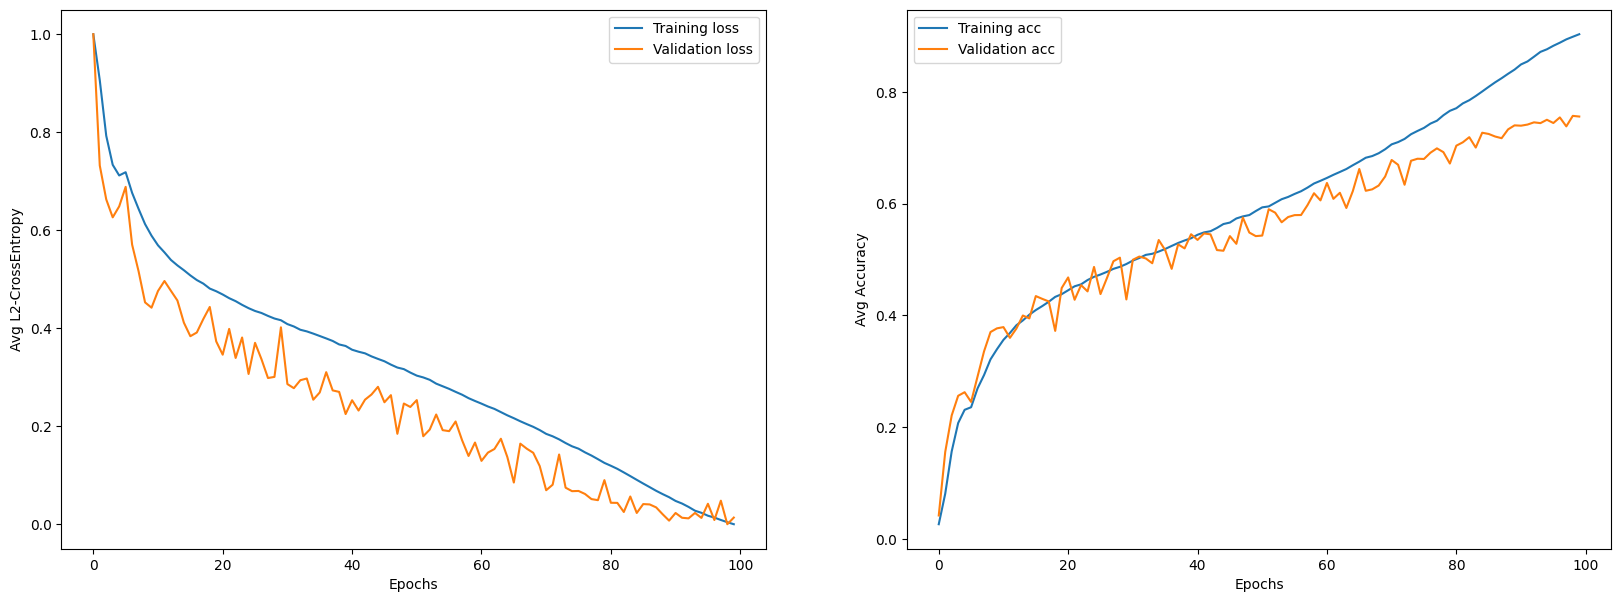

In [17]:
scaled_loss = (res_df['Loss'].to_numpy() - np.min(res_df['Loss'].to_numpy())) / (np.max(res_df['Loss'].to_numpy()) - np.min(res_df['Loss'].to_numpy()))
scaled_val_loss = (res_df['Val_Loss'].to_numpy() - np.min(res_df['Val_Loss'].to_numpy())) / (np.max(res_df['Val_Loss'].to_numpy()) - np.min(res_df['Val_Loss'].to_numpy()))

# Plot results
plt.figure(figsize=[20,7])
plt.subplot(1,2,1)
plt.plot(range(settings['epochs']), scaled_loss, label='Training loss')
plt.plot(range(settings['epochs']), scaled_val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Avg L2-CrossEntropy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(settings['epochs']), res_df['Accuracy'], label='Training acc')
plt.plot(range(settings['epochs']), res_df['Val_Accuracy'], label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Avg Accuracy')
plt.legend();

### 2.1.2 Exporting the model and testing

In [18]:
exported = SuperNet_model.export(verbose=1)

[BEST ALTERNATIVE for features.4.block.2]:
Identity()

[BEST ALTERNATIVE for features.5.block.2]:
DepthwiseSeparableConv(
  (depthwise): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=120)
  (depth_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pointwise): Conv2d(120, 120, kernel_size=(1, 1), stride=(1, 1), groups=2)
  (point_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE for features.6.block.2]:
Identity()

[BEST ALTERNATIVE for features.11.block.2]:
Identity()

[BEST ALTERNATIVE for features.12.block.2]:
DepthwiseSeparableConv(
  (depthwise): Conv2d(672, 672, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=672)
  (depth_bn): BatchNorm2d(672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pointwise): Conv2d(672, 672, kernel_size=(1, 1), stride=(1, 1), groups=2)
  (point_bn): BatchNorm2d(672, eps=1e-05, mo

In [19]:
# Look at the model
exported

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [20]:
# Test the exported model
SuperNet_acc = utils.eval_model(
    model=exported,
    device=device,
    data_loader=test_dataloader
)  

  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED - Avg Accuracy: 77.50%


In [21]:
# Save the exported model
utils.save_experiment(root='./experiments', model=exported, seed=SEED, settings=settings, exported=True, metrics_df=res_df)

### 2.1.3 Comparison with baseline

In [26]:
baseline_model = torch.load(f'./main_models/MobileNetV3_seed{SEED}.pt', weights_only=False)
baseline_model 

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [27]:
# Test the basline model
baseline_acc = utils.eval_model(
    model=baseline_model,
    device=device,
    data_loader=test_dataloader
)  

  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED - Avg Accuracy: 80.73%


In [28]:
gap = SuperNet_acc - baseline_acc

print(f'SuperNet accuracy on test data: {(SuperNet_acc*100):.2f}', end=" -> ")
if gap <= 0:
    print(f'{(abs(gap)*100):.2f}% less than baseline')
else:
    print(f'{(abs(gap)*100):.2f}% more than baseline')

SuperNet accuracy on test data: 77.50 -> 3.23% less than baseline


In [29]:
baseline_params = utils.count_parameters(model=baseline_model)
SuperNet_params = utils.count_parameters(model=exported)
params_ratio = 1 - SuperNet_params / baseline_params if SuperNet_params <= baseline_params else (SuperNet_params - baseline_params) / baseline_params

print(f'#Parameters SuperNet MBNV3: {SuperNet_params}', end=" -> ")
if SuperNet_params <= baseline_params:
    print(f'{(params_ratio*100):.2f}% less than baseline')
else:
    print(f'{(params_ratio*100):.2f}% more than baseline')

#Parameters SuperNet MBNV3: 4013124 -> 7.32% less than baseline


## 2.2 - Target Weighted Parameters

Even if we skipped 4 modules in the previous experiment, we achieved an architecture "just" ~7% lighter than a standard MobileNetV3. This is in part beacuse of the fact that we are targeting only Squeeze and Excite modules, which all together account for 1.5M out of 5.3M parameters of the architecture (~28% of total parameters), therefore there is less room of improvement with respect to working on the whole network. Moreover, non-skipped layers are mainly `DepthWiseSeparableConv`s, which are the "heaviest" alternatives in our set.

Let's say we want an even lighter model. If we pushed for a model retaining around 50% of the parameters of Squeeze and Excite modules, we would get models ~14% lighter than standard MBNV3.

In [10]:
# Target: 50% of SE modules total parameters
baseline_model = torchvision.models.mobilenet_v3_large()

se_params = 0
for _, module in baseline_model.named_modules():
    if module.__class__.__name__ == 'SqueezeExcitation': se_params += utils.count_parameters(module)

target_params = se_params // 2

print(f'#Parameters of SE modules in MBNV3: {se_params} | Target (50%): {target_params}')

#Parameters of SE modules in MBNV3: 1512280 | Target (50%): 756140


### 2.2.1 - Training

In [11]:
# Settings
settings = {
    'epochs': 100,
    'lr': 0.2,
    'loss': 'L2-CrossEntropy',
    'label_smoothing': 0.1,
    'regularizer': 'TWR',
    'cost': 'params',
    'target_gamma': 1e-8,
    'target': target_params,
    'momentum': 0.9,
    'weight_decay': 2e-5
}

In [12]:
# Load the initialization
SuperNet_model = utils.baseline_SuperNet(exp_seed=SEED, dataset=train_dataset, identity=True, verbose=False)

# Loss function and regularizer
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=settings['label_smoothing'])
regularizer = SuperRegularizer(type_cost=settings['cost'], stable_alpha=0.0, target=target_params, target_gamma=settings['target_gamma'])


In [13]:
# Balance gradients
utils.check_gradients(model=SuperNet_model, primar_loss_fn=loss_fn, reg_loss_fn=regularizer, dataset=train_dataset)

Primar Loss ((<class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'utils')):
- Loss:		4.610083103179932
- Gradient:	1.986168622970581
Soft-Constraint Loss (Metric: params | Target: 756140):
- Loss:		0.0022070787381380796
- Gradient:	0.0016908363904803991


In [14]:
# Optimizer
optimizer = torch.optim.SGD(params=SuperNet_model.parameters(), lr=settings['lr'], momentum=settings['momentum'], weight_decay=settings['weight_decay'])

# Learning rate scheduler 
main_shceduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=settings['epochs'])
warmup = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=0.01, total_iters=5) # Linear warmup
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=optimizer, schedulers=[warmup, main_shceduler], milestones=[5])

In [15]:
# Train the model
loss_h, acc_h, val_loss_h, val_acc_h = utils.train_model(
    model=SuperNet_model,
    device=device,
    data_loader=train_dataloader,
    loss_fn=loss_fn,
    regularizer=regularizer,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    val_dataloader=test_dataloader,
    seed=SEED
)

*********************
EPOCH 0 on cuda - Current learning rate: 0.0020



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.59406 | Avg Accuracy: 1.54%
Computed 1999/8125 batches - Avg Loss: 4.55960 | Avg Accuracy: 1.78%
Computed 2999/8125 batches - Avg Loss: 4.53761 | Avg Accuracy: 1.85%
Computed 3999/8125 batches - Avg Loss: 4.52251 | Avg Accuracy: 1.96%
Computed 4999/8125 batches - Avg Loss: 4.50830 | Avg Accuracy: 2.10%
Computed 5999/8125 batches - Avg Loss: 4.49060 | Avg Accuracy: 2.32%
Computed 6999/8125 batches - Avg Loss: 4.47170 | Avg Accuracy: 2.55%
Computed 7999/8125 batches - Avg Loss: 4.45307 | Avg Accuracy: 2.75%

End of EPOCH 0 - Avg Loss: 4.45043 | Avg Accuracy: 2.78%
Training time: 590.895 seconds.

DNAS parameters:
	- features.4.block.2: [[0.2665536105632782, 0.32769086956977844, 0.21142376959323883, 0.1910913586616516]]
	- features.5.block.2: [[0.2336779534816742, 0.25043272972106934, 0.26681241393089294, 0.24583518505096436]]
	- features.6.block.2: [[0.2597196102142334, 0.25260117650032043, 0.235743910074234, 0.2486945390701294]]
	- features.11.bl

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 3.87%
*********************
EPOCH 1 on cuda - Current learning rate: 0.0416



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.51601 | Avg Accuracy: 2.56%
Computed 1999/8125 batches - Avg Loss: 4.42543 | Avg Accuracy: 3.37%
Computed 2999/8125 batches - Avg Loss: 4.36126 | Avg Accuracy: 4.20%
Computed 3999/8125 batches - Avg Loss: 4.30824 | Avg Accuracy: 5.02%
Computed 4999/8125 batches - Avg Loss: 4.26232 | Avg Accuracy: 5.80%
Computed 5999/8125 batches - Avg Loss: 4.22121 | Avg Accuracy: 6.55%
Computed 6999/8125 batches - Avg Loss: 4.18313 | Avg Accuracy: 7.22%
Computed 7999/8125 batches - Avg Loss: 4.14826 | Avg Accuracy: 7.88%

End of EPOCH 1 - Avg Loss: 4.14329 | Avg Accuracy: 7.97%
Training time: 590.392 seconds.

DNAS parameters:
	- features.4.block.2: [[1.197596788406372, 0.2672033905982971, -0.10349617898464203, -0.42970505356788635]]
	- features.5.block.2: [[0.6477922201156616, -0.10442684590816498, -0.3032878637313843, 0.691523015499115]]
	- features.6.block.2: [[0.012498859316110611, 0.20450106263160706, 0.3236592710018158, 0.39094170928001404]]
	- features.1

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 15.71%
*********************
EPOCH 2 on cuda - Current learning rate: 0.0812



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.96877 | Avg Accuracy: 11.28%
Computed 1999/8125 batches - Avg Loss: 3.92915 | Avg Accuracy: 12.05%
Computed 2999/8125 batches - Avg Loss: 3.89796 | Avg Accuracy: 12.72%
Computed 3999/8125 batches - Avg Loss: 3.86863 | Avg Accuracy: 13.35%
Computed 4999/8125 batches - Avg Loss: 3.83842 | Avg Accuracy: 14.02%
Computed 5999/8125 batches - Avg Loss: 3.80978 | Avg Accuracy: 14.65%
Computed 6999/8125 batches - Avg Loss: 3.78181 | Avg Accuracy: 15.35%
Computed 7999/8125 batches - Avg Loss: 3.75451 | Avg Accuracy: 15.99%

End of EPOCH 2 - Avg Loss: 3.75162 | Avg Accuracy: 16.05%
Training time: 586.843 seconds.

DNAS parameters:
	- features.4.block.2: [[4.317607402801514, -0.5378496050834656, -1.551059365272522, -1.4122717380523682]]
	- features.5.block.2: [[0.057395435869693756, -0.38455766439437866, -0.7940279245376587, 1.9376184940338135]]
	- features.6.block.2: [[-0.33030086755752563, -0.08613746613264084, -0.34533584117889404, 1.5781970024108887]]
	

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 20.95%
*********************
EPOCH 3 on cuda - Current learning rate: 0.1208



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.69635 | Avg Accuracy: 17.56%
Computed 1999/8125 batches - Avg Loss: 3.66642 | Avg Accuracy: 18.27%
Computed 2999/8125 batches - Avg Loss: 3.64588 | Avg Accuracy: 18.72%
Computed 3999/8125 batches - Avg Loss: 3.62326 | Avg Accuracy: 19.30%
Computed 4999/8125 batches - Avg Loss: 3.60468 | Avg Accuracy: 19.81%
Computed 5999/8125 batches - Avg Loss: 3.58552 | Avg Accuracy: 20.30%
Computed 6999/8125 batches - Avg Loss: 3.56835 | Avg Accuracy: 20.69%
Computed 7999/8125 batches - Avg Loss: 3.55428 | Avg Accuracy: 21.01%

End of EPOCH 3 - Avg Loss: 3.55188 | Avg Accuracy: 21.06%
Training time: 585.477 seconds.

DNAS parameters:
	- features.4.block.2: [[5.756303787231445, -1.3834964036941528, -1.785682201385498, -1.9162565469741821]]
	- features.5.block.2: [[-0.6343013048171997, -0.9943149089813232, -0.8041240572929382, 3.1036267280578613]]
	- features.6.block.2: [[-0.7519470453262329, -0.4557134807109833, -0.8125285506248474, 2.6910698413848877]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 25.02%
*********************
EPOCH 4 on cuda - Current learning rate: 0.1604



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.59450 | Avg Accuracy: 21.23%
Computed 1999/8125 batches - Avg Loss: 3.58215 | Avg Accuracy: 21.06%
Computed 2999/8125 batches - Avg Loss: 3.56439 | Avg Accuracy: 21.42%
Computed 3999/8125 batches - Avg Loss: 3.55828 | Avg Accuracy: 21.65%
Computed 4999/8125 batches - Avg Loss: 3.54169 | Avg Accuracy: 22.04%
Computed 5999/8125 batches - Avg Loss: 3.52942 | Avg Accuracy: 22.33%
Computed 6999/8125 batches - Avg Loss: 3.51685 | Avg Accuracy: 22.65%
Computed 7999/8125 batches - Avg Loss: 3.50526 | Avg Accuracy: 22.99%

End of EPOCH 4 - Avg Loss: 3.50282 | Avg Accuracy: 23.04%
Training time: 584.840 seconds.

DNAS parameters:
	- features.4.block.2: [[5.895899772644043, -1.420556664466858, -2.2958474159240723, -1.6626123189926147]]
	- features.5.block.2: [[-1.0731391906738281, -0.9490105509757996, -1.214674949645996, 3.7537386417388916]]
	- features.6.block.2: [[-0.8008469939231873, -0.9416127800941467, -0.9053800106048584, 3.164734363555908]]
	- featu

/home/tiziano-tezze/ProgramFiles/miniconda3/envs/cv-project/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 28.51%
*********************
EPOCH 5 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.55988 | Avg Accuracy: 22.82%
Computed 1999/8125 batches - Avg Loss: 3.57085 | Avg Accuracy: 22.44%
Computed 2999/8125 batches - Avg Loss: 3.56740 | Avg Accuracy: 22.53%
Computed 3999/8125 batches - Avg Loss: 3.56416 | Avg Accuracy: 22.47%
Computed 4999/8125 batches - Avg Loss: 3.56102 | Avg Accuracy: 22.57%
Computed 5999/8125 batches - Avg Loss: 3.55535 | Avg Accuracy: 22.66%
Computed 6999/8125 batches - Avg Loss: 3.54815 | Avg Accuracy: 22.79%
Computed 7999/8125 batches - Avg Loss: 3.54027 | Avg Accuracy: 22.98%

End of EPOCH 5 - Avg Loss: 3.53940 | Avg Accuracy: 22.98%
Training time: 589.666 seconds.

DNAS parameters:
	- features.4.block.2: [[5.850921154022217, -1.7288615703582764, -2.1939666271209717, -1.5546586513519287]]
	- features.5.block.2: [[-1.3039027452468872, -1.1639243364334106, -1.0635013580322266, 3.9047625064849854]]
	- features.6.block.2: [[-0.8573704957962036, -1.3409775495529175, -1.0152077674865723, 3.586984872817993]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 25.88%
*********************
EPOCH 6 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.45327 | Avg Accuracy: 24.97%
Computed 1999/8125 batches - Avg Loss: 3.44071 | Avg Accuracy: 25.03%
Computed 2999/8125 batches - Avg Loss: 3.44163 | Avg Accuracy: 25.03%
Computed 3999/8125 batches - Avg Loss: 3.43237 | Avg Accuracy: 25.28%
Computed 4999/8125 batches - Avg Loss: 3.42586 | Avg Accuracy: 25.48%
Computed 5999/8125 batches - Avg Loss: 3.41751 | Avg Accuracy: 25.67%
Computed 6999/8125 batches - Avg Loss: 3.41339 | Avg Accuracy: 25.84%
Computed 7999/8125 batches - Avg Loss: 3.40798 | Avg Accuracy: 26.00%

End of EPOCH 6 - Avg Loss: 3.40687 | Avg Accuracy: 26.01%
Training time: 584.441 seconds.

DNAS parameters:
	- features.4.block.2: [[6.312547206878662, -1.3127402067184448, -2.0595996379852295, -2.6704063415527344]]
	- features.5.block.2: [[-1.4623782634735107, -1.1499091386795044, -1.255067229270935, 4.137168884277344]]
	- features.6.block.2: [[-0.9829961657524109, -1.1946442127227783, -1.143267035484314, 3.590721607208252]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 28.21%
*********************
EPOCH 7 on cuda - Current learning rate: 0.1998



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.33543 | Avg Accuracy: 27.31%
Computed 1999/8125 batches - Avg Loss: 3.32895 | Avg Accuracy: 27.55%
Computed 2999/8125 batches - Avg Loss: 3.32532 | Avg Accuracy: 27.84%
Computed 3999/8125 batches - Avg Loss: 3.32232 | Avg Accuracy: 28.04%
Computed 4999/8125 batches - Avg Loss: 3.31580 | Avg Accuracy: 28.20%
Computed 5999/8125 batches - Avg Loss: 3.31349 | Avg Accuracy: 28.20%
Computed 6999/8125 batches - Avg Loss: 3.30572 | Avg Accuracy: 28.39%
Computed 7999/8125 batches - Avg Loss: 3.30041 | Avg Accuracy: 28.58%

End of EPOCH 7 - Avg Loss: 3.29991 | Avg Accuracy: 28.58%
Training time: 587.504 seconds.

DNAS parameters:
	- features.4.block.2: [[5.377870559692383, -1.301491379737854, -1.5882576704025269, -2.293168067932129]]
	- features.5.block.2: [[-1.6433324813842773, -1.191913366317749, -1.2415480613708496, 4.271783828735352]]
	- features.6.block.2: [[-1.0078346729278564, -1.1124240159988403, -1.1467305421829224, 3.461977481842041]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 29.19%
*********************
EPOCH 8 on cuda - Current learning rate: 0.1996



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.22713 | Avg Accuracy: 30.35%
Computed 1999/8125 batches - Avg Loss: 3.22841 | Avg Accuracy: 30.53%
Computed 2999/8125 batches - Avg Loss: 3.22921 | Avg Accuracy: 30.50%
Computed 3999/8125 batches - Avg Loss: 3.21843 | Avg Accuracy: 30.83%
Computed 4999/8125 batches - Avg Loss: 3.21654 | Avg Accuracy: 30.83%
Computed 5999/8125 batches - Avg Loss: 3.21522 | Avg Accuracy: 30.86%
Computed 6999/8125 batches - Avg Loss: 3.21168 | Avg Accuracy: 30.90%
Computed 7999/8125 batches - Avg Loss: 3.20699 | Avg Accuracy: 30.98%

End of EPOCH 8 - Avg Loss: 3.20520 | Avg Accuracy: 31.01%
Training time: 588.772 seconds.

DNAS parameters:
	- features.4.block.2: [[5.859780788421631, -1.3367935419082642, -2.279980182647705, -2.1020636558532715]]
	- features.5.block.2: [[-1.7052760124206543, -1.2687407732009888, -1.2590274810791016, 4.374025344848633]]
	- features.6.block.2: [[-1.08408784866333, -1.2063082456588745, -0.9437598586082458, 3.375122308731079]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 34.33%
*********************
EPOCH 9 on cuda - Current learning rate: 0.1992



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.14408 | Avg Accuracy: 31.83%
Computed 1999/8125 batches - Avg Loss: 3.13983 | Avg Accuracy: 32.40%
Computed 2999/8125 batches - Avg Loss: 3.13951 | Avg Accuracy: 32.56%
Computed 3999/8125 batches - Avg Loss: 3.13401 | Avg Accuracy: 32.68%
Computed 4999/8125 batches - Avg Loss: 3.12936 | Avg Accuracy: 32.72%
Computed 5999/8125 batches - Avg Loss: 3.12591 | Avg Accuracy: 32.95%
Computed 6999/8125 batches - Avg Loss: 3.12242 | Avg Accuracy: 33.10%
Computed 7999/8125 batches - Avg Loss: 3.11970 | Avg Accuracy: 33.24%

End of EPOCH 9 - Avg Loss: 3.12025 | Avg Accuracy: 33.22%
Training time: 589.072 seconds.

DNAS parameters:
	- features.4.block.2: [[6.325196266174316, -1.6288836002349854, -1.8335213661193848, -2.7608273029327393]]
	- features.5.block.2: [[-1.8464195728302002, -1.315333604812622, -1.2074185609817505, 4.471172332763672]]
	- features.6.block.2: [[-1.2079570293426514, -1.0762790441513062, -0.9854568243026733, 3.3716723918914795]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 30.99%
*********************
EPOCH 10 on cuda - Current learning rate: 0.1988



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.07191 | Avg Accuracy: 34.06%
Computed 1999/8125 batches - Avg Loss: 3.08452 | Avg Accuracy: 33.74%
Computed 2999/8125 batches - Avg Loss: 3.08321 | Avg Accuracy: 33.60%
Computed 3999/8125 batches - Avg Loss: 3.07153 | Avg Accuracy: 33.90%
Computed 4999/8125 batches - Avg Loss: 3.06911 | Avg Accuracy: 34.05%
Computed 5999/8125 batches - Avg Loss: 3.06306 | Avg Accuracy: 34.31%
Computed 6999/8125 batches - Avg Loss: 3.06179 | Avg Accuracy: 34.35%
Computed 7999/8125 batches - Avg Loss: 3.05973 | Avg Accuracy: 34.42%

End of EPOCH 10 - Avg Loss: 3.05949 | Avg Accuracy: 34.43%
Training time: 586.601 seconds.

DNAS parameters:
	- features.4.block.2: [[5.3175048828125, -1.2591110467910767, -1.9511970281600952, -2.0333752632141113]]
	- features.5.block.2: [[-1.7682466506958008, -1.519750952720642, -1.0893661975860596, 4.451209545135498]]
	- features.6.block.2: [[-0.9664405584335327, -1.1067947149276733, -0.866107165813446, 3.013160467147827]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 33.75%
*********************
EPOCH 11 on cuda - Current learning rate: 0.1982



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.03264 | Avg Accuracy: 35.34%
Computed 1999/8125 batches - Avg Loss: 3.02853 | Avg Accuracy: 35.40%
Computed 2999/8125 batches - Avg Loss: 3.02977 | Avg Accuracy: 35.40%
Computed 3999/8125 batches - Avg Loss: 3.02852 | Avg Accuracy: 35.43%
Computed 4999/8125 batches - Avg Loss: 3.02593 | Avg Accuracy: 35.42%
Computed 5999/8125 batches - Avg Loss: 3.02241 | Avg Accuracy: 35.58%
Computed 6999/8125 batches - Avg Loss: 3.01725 | Avg Accuracy: 35.71%
Computed 7999/8125 batches - Avg Loss: 3.01505 | Avg Accuracy: 35.82%

End of EPOCH 11 - Avg Loss: 3.01470 | Avg Accuracy: 35.81%
Training time: 588.748 seconds.

DNAS parameters:
	- features.4.block.2: [[6.82936954498291, -1.1482415199279785, -3.2192745208740234, -2.4083750247955322]]
	- features.5.block.2: [[-1.681968331336975, -1.355425477027893, -1.0461148023605347, 4.137024879455566]]
	- features.6.block.2: [[-0.9833118319511414, -1.0350819826126099, -0.8925474286079407, 2.9644272327423096]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 33.81%
*********************
EPOCH 12 on cuda - Current learning rate: 0.1976



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.97920 | Avg Accuracy: 36.69%
Computed 1999/8125 batches - Avg Loss: 2.96892 | Avg Accuracy: 37.03%
Computed 2999/8125 batches - Avg Loss: 2.96548 | Avg Accuracy: 37.02%
Computed 3999/8125 batches - Avg Loss: 2.97416 | Avg Accuracy: 36.85%
Computed 4999/8125 batches - Avg Loss: 2.97569 | Avg Accuracy: 36.82%
Computed 5999/8125 batches - Avg Loss: 2.97264 | Avg Accuracy: 36.86%
Computed 6999/8125 batches - Avg Loss: 2.97343 | Avg Accuracy: 36.87%
Computed 7999/8125 batches - Avg Loss: 2.97154 | Avg Accuracy: 36.93%

End of EPOCH 12 - Avg Loss: 2.97113 | Avg Accuracy: 36.91%
Training time: 588.901 seconds.

DNAS parameters:
	- features.4.block.2: [[7.109274864196777, -1.0511845350265503, -4.253002643585205, -1.7662965059280396]]
	- features.5.block.2: [[-1.7722090482711792, -1.2348815202713013, -1.2033051252365112, 4.249222278594971]]
	- features.6.block.2: [[-1.1065369844436646, -0.923003077507019, -0.8490027189254761, 2.9173381328582764]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 35.26%
*********************
EPOCH 13 on cuda - Current learning rate: 0.1969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.92645 | Avg Accuracy: 38.10%
Computed 1999/8125 batches - Avg Loss: 2.93849 | Avg Accuracy: 37.70%
Computed 2999/8125 batches - Avg Loss: 2.94154 | Avg Accuracy: 37.77%
Computed 3999/8125 batches - Avg Loss: 2.93720 | Avg Accuracy: 37.85%
Computed 4999/8125 batches - Avg Loss: 2.93142 | Avg Accuracy: 37.98%
Computed 5999/8125 batches - Avg Loss: 2.93082 | Avg Accuracy: 37.96%
Computed 6999/8125 batches - Avg Loss: 2.92862 | Avg Accuracy: 38.06%
Computed 7999/8125 batches - Avg Loss: 2.92829 | Avg Accuracy: 38.06%

End of EPOCH 13 - Avg Loss: 2.92774 | Avg Accuracy: 38.08%
Training time: 588.294 seconds.

DNAS parameters:
	- features.4.block.2: [[5.733656883239746, -1.3826756477355957, -3.0564136505126953, -1.266402006149292]]
	- features.5.block.2: [[-1.8399707078933716, -1.0506445169448853, -0.9183984398841858, 3.837214946746826]]
	- features.6.block.2: [[-1.0658153295516968, -1.0238100290298462, -0.9760617613792419, 3.0938613414764404]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 39.46%
*********************
EPOCH 14 on cuda - Current learning rate: 0.1960



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.90048 | Avg Accuracy: 38.93%
Computed 1999/8125 batches - Avg Loss: 2.89528 | Avg Accuracy: 38.98%
Computed 2999/8125 batches - Avg Loss: 2.90076 | Avg Accuracy: 38.81%
Computed 3999/8125 batches - Avg Loss: 2.89972 | Avg Accuracy: 38.81%
Computed 4999/8125 batches - Avg Loss: 2.89873 | Avg Accuracy: 38.79%
Computed 5999/8125 batches - Avg Loss: 2.89856 | Avg Accuracy: 38.79%
Computed 6999/8125 batches - Avg Loss: 2.89750 | Avg Accuracy: 38.81%
Computed 7999/8125 batches - Avg Loss: 2.89801 | Avg Accuracy: 38.81%

End of EPOCH 14 - Avg Loss: 2.89697 | Avg Accuracy: 38.82%
Training time: 588.659 seconds.

DNAS parameters:
	- features.4.block.2: [[5.515040874481201, -1.1462793350219727, -2.2894811630249023, -2.058816909790039]]
	- features.5.block.2: [[-1.7638731002807617, -1.3771330118179321, -1.1032686233520508, 4.264786720275879]]
	- features.6.block.2: [[-0.7474639415740967, -0.8865031003952026, -0.8963689208030701, 2.5508134365081787]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 37.68%
*********************
EPOCH 15 on cuda - Current learning rate: 0.1951



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.87578 | Avg Accuracy: 39.28%
Computed 1999/8125 batches - Avg Loss: 2.87667 | Avg Accuracy: 39.38%
Computed 2999/8125 batches - Avg Loss: 2.87303 | Avg Accuracy: 39.37%
Computed 3999/8125 batches - Avg Loss: 2.87379 | Avg Accuracy: 39.52%
Computed 4999/8125 batches - Avg Loss: 2.87357 | Avg Accuracy: 39.53%
Computed 5999/8125 batches - Avg Loss: 2.87383 | Avg Accuracy: 39.53%
Computed 6999/8125 batches - Avg Loss: 2.87072 | Avg Accuracy: 39.59%
Computed 7999/8125 batches - Avg Loss: 2.86906 | Avg Accuracy: 39.63%

End of EPOCH 15 - Avg Loss: 2.86830 | Avg Accuracy: 39.63%
Training time: 589.030 seconds.

DNAS parameters:
	- features.4.block.2: [[6.194197654724121, -1.803575038909912, -1.7024009227752686, -2.6733157634735107]]
	- features.5.block.2: [[-2.18648099899292, -1.1628214120864868, -0.9532528519630432, 4.317488193511963]]
	- features.6.block.2: [[-0.8829274773597717, -0.8280741572380066, -0.8295321464538574, 2.5554392337799072]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.17%
*********************
EPOCH 16 on cuda - Current learning rate: 0.1941



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.85873 | Avg Accuracy: 40.14%
Computed 1999/8125 batches - Avg Loss: 2.85029 | Avg Accuracy: 40.18%
Computed 2999/8125 batches - Avg Loss: 2.84441 | Avg Accuracy: 40.38%
Computed 3999/8125 batches - Avg Loss: 2.84102 | Avg Accuracy: 40.48%
Computed 4999/8125 batches - Avg Loss: 2.83263 | Avg Accuracy: 40.70%
Computed 5999/8125 batches - Avg Loss: 2.83223 | Avg Accuracy: 40.70%
Computed 6999/8125 batches - Avg Loss: 2.82929 | Avg Accuracy: 40.66%
Computed 7999/8125 batches - Avg Loss: 2.83083 | Avg Accuracy: 40.66%

End of EPOCH 16 - Avg Loss: 2.83030 | Avg Accuracy: 40.63%
Training time: 587.714 seconds.

DNAS parameters:
	- features.4.block.2: [[5.663069725036621, -1.5071983337402344, -2.1808345317840576, -1.964157223701477]]
	- features.5.block.2: [[-2.133070945739746, -1.1275867223739624, -0.8545107841491699, 4.126058101654053]]
	- features.6.block.2: [[-1.1386152505874634, -0.7222151756286621, -0.5957413911819458, 2.467432737350464]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 39.82%
*********************
EPOCH 17 on cuda - Current learning rate: 0.1930



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.79362 | Avg Accuracy: 41.76%
Computed 1999/8125 batches - Avg Loss: 2.80699 | Avg Accuracy: 41.21%
Computed 2999/8125 batches - Avg Loss: 2.80804 | Avg Accuracy: 41.34%
Computed 3999/8125 batches - Avg Loss: 2.81109 | Avg Accuracy: 41.10%
Computed 4999/8125 batches - Avg Loss: 2.80960 | Avg Accuracy: 41.05%
Computed 5999/8125 batches - Avg Loss: 2.81050 | Avg Accuracy: 41.10%
Computed 6999/8125 batches - Avg Loss: 2.81055 | Avg Accuracy: 41.06%
Computed 7999/8125 batches - Avg Loss: 2.80994 | Avg Accuracy: 41.08%

End of EPOCH 17 - Avg Loss: 2.80990 | Avg Accuracy: 41.05%
Training time: 588.638 seconds.

DNAS parameters:
	- features.4.block.2: [[5.648125171661377, -1.2948637008666992, -2.766674041748047, -1.578654170036316]]
	- features.5.block.2: [[-1.7891658544540405, -1.1089073419570923, -0.9889437556266785, 3.8949697017669678]]
	- features.6.block.2: [[-0.9328082799911499, -0.7935076355934143, -0.8436185717582703, 2.5778727531433105]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 45.03%
*********************
EPOCH 18 on cuda - Current learning rate: 0.1918



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.76763 | Avg Accuracy: 42.38%
Computed 1999/8125 batches - Avg Loss: 2.76989 | Avg Accuracy: 42.11%
Computed 2999/8125 batches - Avg Loss: 2.76454 | Avg Accuracy: 42.26%
Computed 3999/8125 batches - Avg Loss: 2.76979 | Avg Accuracy: 42.22%
Computed 4999/8125 batches - Avg Loss: 2.77263 | Avg Accuracy: 42.12%
Computed 5999/8125 batches - Avg Loss: 2.77042 | Avg Accuracy: 42.11%
Computed 6999/8125 batches - Avg Loss: 2.77358 | Avg Accuracy: 41.97%
Computed 7999/8125 batches - Avg Loss: 2.77383 | Avg Accuracy: 41.97%

End of EPOCH 18 - Avg Loss: 2.77374 | Avg Accuracy: 41.97%
Training time: 588.999 seconds.

DNAS parameters:
	- features.4.block.2: [[5.957402229309082, -1.0194288492202759, -3.579221248626709, -1.3529547452926636]]
	- features.5.block.2: [[-1.7884784936904907, -0.9607759714126587, -1.0035535097122192, 3.758634090423584]]
	- features.6.block.2: [[-1.0803802013397217, -0.671720027923584, -0.760377049446106, 2.5182838439941406]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 38.18%
*********************
EPOCH 19 on cuda - Current learning rate: 0.1905



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.71721 | Avg Accuracy: 43.34%
Computed 1999/8125 batches - Avg Loss: 2.73817 | Avg Accuracy: 42.71%
Computed 2999/8125 batches - Avg Loss: 2.74483 | Avg Accuracy: 42.62%
Computed 3999/8125 batches - Avg Loss: 2.74867 | Avg Accuracy: 42.49%
Computed 4999/8125 batches - Avg Loss: 2.75126 | Avg Accuracy: 42.54%
Computed 5999/8125 batches - Avg Loss: 2.75562 | Avg Accuracy: 42.45%
Computed 6999/8125 batches - Avg Loss: 2.75880 | Avg Accuracy: 42.30%
Computed 7999/8125 batches - Avg Loss: 2.76377 | Avg Accuracy: 42.21%

End of EPOCH 19 - Avg Loss: 2.76367 | Avg Accuracy: 42.18%
Training time: 586.942 seconds.

DNAS parameters:
	- features.4.block.2: [[5.251904010772705, -0.8731017112731934, -2.7499656677246094, -1.6245678663253784]]
	- features.5.block.2: [[-2.0529065132141113, -0.8696715831756592, -0.9397895932197571, 3.866638422012329]]
	- features.6.block.2: [[-1.259850025177002, -0.5234950184822083, -0.7606118321418762, 2.5482287406921387]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 43.03%
*********************
EPOCH 20 on cuda - Current learning rate: 0.1891



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.74792 | Avg Accuracy: 43.12%
Computed 1999/8125 batches - Avg Loss: 2.73996 | Avg Accuracy: 43.06%
Computed 2999/8125 batches - Avg Loss: 2.73693 | Avg Accuracy: 43.08%
Computed 3999/8125 batches - Avg Loss: 2.73744 | Avg Accuracy: 43.08%
Computed 4999/8125 batches - Avg Loss: 2.73749 | Avg Accuracy: 43.08%
Computed 5999/8125 batches - Avg Loss: 2.73810 | Avg Accuracy: 42.99%
Computed 6999/8125 batches - Avg Loss: 2.73668 | Avg Accuracy: 43.08%
Computed 7999/8125 batches - Avg Loss: 2.73500 | Avg Accuracy: 43.16%

End of EPOCH 20 - Avg Loss: 2.73439 | Avg Accuracy: 43.14%
Training time: 589.019 seconds.

DNAS parameters:
	- features.4.block.2: [[4.92728328704834, -1.2806119918823242, -2.06101131439209, -1.5825390815734863]]
	- features.5.block.2: [[-2.123891592025757, -0.6595779061317444, -0.8968250751495361, 3.6834380626678467]]
	- features.6.block.2: [[-1.2837811708450317, -0.4523729085922241, -0.6757476925849915, 2.415032148361206]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.19%
*********************
EPOCH 21 on cuda - Current learning rate: 0.1876



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.70755 | Avg Accuracy: 44.11%
Computed 1999/8125 batches - Avg Loss: 2.70183 | Avg Accuracy: 43.99%
Computed 2999/8125 batches - Avg Loss: 2.69980 | Avg Accuracy: 44.09%
Computed 3999/8125 batches - Avg Loss: 2.72400 | Avg Accuracy: 43.52%
Computed 4999/8125 batches - Avg Loss: 2.72409 | Avg Accuracy: 43.56%
Computed 5999/8125 batches - Avg Loss: 2.72474 | Avg Accuracy: 43.51%
Computed 6999/8125 batches - Avg Loss: 2.72312 | Avg Accuracy: 43.61%
Computed 7999/8125 batches - Avg Loss: 2.72301 | Avg Accuracy: 43.60%

End of EPOCH 21 - Avg Loss: 2.72230 | Avg Accuracy: 43.60%
Training time: 589.132 seconds.

DNAS parameters:
	- features.4.block.2: [[7.01479434967041, -2.2630016803741455, -2.0344247817993164, -2.715073347091675]]
	- features.5.block.2: [[-2.122654676437378, -0.723164975643158, -0.7972016930580139, 3.6453378200531006]]
	- features.6.block.2: [[-1.1020327806472778, -0.38847440481185913, -0.7124584913253784, 2.20528244972229]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.77%
*********************
EPOCH 22 on cuda - Current learning rate: 0.1861



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.68817 | Avg Accuracy: 44.79%
Computed 1999/8125 batches - Avg Loss: 2.68704 | Avg Accuracy: 44.49%
Computed 2999/8125 batches - Avg Loss: 2.69260 | Avg Accuracy: 44.13%
Computed 3999/8125 batches - Avg Loss: 2.69083 | Avg Accuracy: 44.10%
Computed 4999/8125 batches - Avg Loss: 2.68956 | Avg Accuracy: 44.20%
Computed 5999/8125 batches - Avg Loss: 2.68775 | Avg Accuracy: 44.28%
Computed 6999/8125 batches - Avg Loss: 2.68652 | Avg Accuracy: 44.25%
Computed 7999/8125 batches - Avg Loss: 2.68684 | Avg Accuracy: 44.26%

End of EPOCH 22 - Avg Loss: 2.68638 | Avg Accuracy: 44.24%
Training time: 587.805 seconds.

DNAS parameters:
	- features.4.block.2: [[5.518148422241211, -1.6929371356964111, -1.6974564790725708, -2.1260695457458496]]
	- features.5.block.2: [[-2.46932053565979, -0.9653545022010803, -0.8796980381011963, 4.316079139709473]]
	- features.6.block.2: [[-1.0177288055419922, -0.34224656224250793, -0.8020477294921875, 2.1637284755706787]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.24%
*********************
EPOCH 23 on cuda - Current learning rate: 0.1844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.63300 | Avg Accuracy: 46.02%
Computed 1999/8125 batches - Avg Loss: 2.65729 | Avg Accuracy: 45.28%
Computed 2999/8125 batches - Avg Loss: 2.65394 | Avg Accuracy: 45.23%
Computed 3999/8125 batches - Avg Loss: 2.66187 | Avg Accuracy: 45.01%
Computed 4999/8125 batches - Avg Loss: 2.66628 | Avg Accuracy: 44.81%
Computed 5999/8125 batches - Avg Loss: 2.66946 | Avg Accuracy: 44.78%
Computed 6999/8125 batches - Avg Loss: 2.67100 | Avg Accuracy: 44.71%
Computed 7999/8125 batches - Avg Loss: 2.67096 | Avg Accuracy: 44.73%

End of EPOCH 23 - Avg Loss: 2.67072 | Avg Accuracy: 44.73%
Training time: 588.846 seconds.

DNAS parameters:
	- features.4.block.2: [[6.314098358154297, -1.6989697217941284, -1.279392957687378, -3.3344545364379883]]
	- features.5.block.2: [[-2.2503480911254883, -0.9622236490249634, -0.7761972546577454, 3.9900453090667725]]
	- features.6.block.2: [[-0.9703751802444458, -0.2833781838417053, -0.893957793712616, 2.148980140686035]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 41.33%
*********************
EPOCH 24 on cuda - Current learning rate: 0.1827



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.61703 | Avg Accuracy: 46.22%
Computed 1999/8125 batches - Avg Loss: 2.62577 | Avg Accuracy: 45.71%
Computed 2999/8125 batches - Avg Loss: 2.62994 | Avg Accuracy: 45.71%
Computed 3999/8125 batches - Avg Loss: 2.63560 | Avg Accuracy: 45.65%
Computed 4999/8125 batches - Avg Loss: 2.63978 | Avg Accuracy: 45.61%
Computed 5999/8125 batches - Avg Loss: 2.64185 | Avg Accuracy: 45.56%
Computed 6999/8125 batches - Avg Loss: 2.64170 | Avg Accuracy: 45.54%
Computed 7999/8125 batches - Avg Loss: 2.64238 | Avg Accuracy: 45.50%

End of EPOCH 24 - Avg Loss: 2.64207 | Avg Accuracy: 45.49%
Training time: 589.795 seconds.

DNAS parameters:
	- features.4.block.2: [[5.140192985534668, -1.3572942018508911, -1.2912474870681763, -2.4907004833221436]]
	- features.5.block.2: [[-2.162475824356079, -0.7588861584663391, -0.5587593913078308, 3.4810631275177]]
	- features.6.block.2: [[-1.1269525289535522, -0.18695421516895294, -0.5250025987625122, 1.8398488759994507]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 43.99%
*********************
EPOCH 25 on cuda - Current learning rate: 0.1809



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.59538 | Avg Accuracy: 46.52%
Computed 1999/8125 batches - Avg Loss: 2.60024 | Avg Accuracy: 46.96%
Computed 2999/8125 batches - Avg Loss: 2.61151 | Avg Accuracy: 46.64%
Computed 3999/8125 batches - Avg Loss: 2.61799 | Avg Accuracy: 46.35%
Computed 4999/8125 batches - Avg Loss: 2.61859 | Avg Accuracy: 46.24%
Computed 5999/8125 batches - Avg Loss: 2.61963 | Avg Accuracy: 46.18%
Computed 6999/8125 batches - Avg Loss: 2.62237 | Avg Accuracy: 46.07%
Computed 7999/8125 batches - Avg Loss: 2.62272 | Avg Accuracy: 46.06%

End of EPOCH 25 - Avg Loss: 2.62285 | Avg Accuracy: 46.04%
Training time: 588.160 seconds.

DNAS parameters:
	- features.4.block.2: [[4.812469959259033, -1.1660019159317017, -1.3778847455978394, -2.2678701877593994]]
	- features.5.block.2: [[-2.1549625396728516, -0.747791588306427, -0.38748985528945923, 3.290931224822998]]
	- features.6.block.2: [[-0.669470489025116, -0.211774080991745, -0.5984281897544861, 1.4803729057312012]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 35.92%
*********************
EPOCH 26 on cuda - Current learning rate: 0.1790



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.59377 | Avg Accuracy: 46.57%
Computed 1999/8125 batches - Avg Loss: 2.58166 | Avg Accuracy: 47.04%
Computed 2999/8125 batches - Avg Loss: 2.58490 | Avg Accuracy: 47.02%
Computed 3999/8125 batches - Avg Loss: 2.58802 | Avg Accuracy: 46.99%
Computed 4999/8125 batches - Avg Loss: 2.58704 | Avg Accuracy: 46.99%
Computed 5999/8125 batches - Avg Loss: 2.58960 | Avg Accuracy: 46.92%
Computed 6999/8125 batches - Avg Loss: 2.59021 | Avg Accuracy: 46.85%
Computed 7999/8125 batches - Avg Loss: 2.59317 | Avg Accuracy: 46.80%

End of EPOCH 26 - Avg Loss: 2.59270 | Avg Accuracy: 46.80%
Training time: 585.216 seconds.

DNAS parameters:
	- features.4.block.2: [[4.891626834869385, -1.0141736268997192, -2.081472635269165, -1.795438289642334]]
	- features.5.block.2: [[-2.1148786544799805, -0.7928066849708557, -0.4534894824028015, 3.361691474914551]]
	- features.6.block.2: [[-1.2967064380645752, -0.09361743927001953, -0.4325507879257202, 1.8234128952026367]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.48%
*********************
EPOCH 27 on cuda - Current learning rate: 0.1771



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.55122 | Avg Accuracy: 47.72%
Computed 1999/8125 batches - Avg Loss: 2.55585 | Avg Accuracy: 47.78%
Computed 2999/8125 batches - Avg Loss: 2.57014 | Avg Accuracy: 47.23%
Computed 3999/8125 batches - Avg Loss: 2.56979 | Avg Accuracy: 47.25%
Computed 4999/8125 batches - Avg Loss: 2.57285 | Avg Accuracy: 47.22%
Computed 5999/8125 batches - Avg Loss: 2.57471 | Avg Accuracy: 47.16%
Computed 6999/8125 batches - Avg Loss: 2.57578 | Avg Accuracy: 47.16%
Computed 7999/8125 batches - Avg Loss: 2.57467 | Avg Accuracy: 47.22%

End of EPOCH 27 - Avg Loss: 2.57454 | Avg Accuracy: 47.21%
Training time: 586.878 seconds.

DNAS parameters:
	- features.4.block.2: [[4.8307881355285645, -1.043816089630127, -2.4501595497131348, -1.3364052772521973]]
	- features.5.block.2: [[-1.9991651773452759, -0.8621343970298767, -0.4908292293548584, 3.3525185585021973]]
	- features.6.block.2: [[-1.280031442642212, -0.2309848666191101, -0.3018306791782379, 1.8132500648498535]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.20%
*********************
EPOCH 28 on cuda - Current learning rate: 0.1750



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.53827 | Avg Accuracy: 48.39%
Computed 1999/8125 batches - Avg Loss: 2.55408 | Avg Accuracy: 47.78%
Computed 2999/8125 batches - Avg Loss: 2.55462 | Avg Accuracy: 47.72%
Computed 3999/8125 batches - Avg Loss: 2.55018 | Avg Accuracy: 47.81%
Computed 4999/8125 batches - Avg Loss: 2.55025 | Avg Accuracy: 47.87%
Computed 5999/8125 batches - Avg Loss: 2.55389 | Avg Accuracy: 47.73%
Computed 6999/8125 batches - Avg Loss: 2.55585 | Avg Accuracy: 47.67%
Computed 7999/8125 batches - Avg Loss: 2.55791 | Avg Accuracy: 47.63%

End of EPOCH 28 - Avg Loss: 2.55824 | Avg Accuracy: 47.62%
Training time: 589.531 seconds.

DNAS parameters:
	- features.4.block.2: [[4.616647243499756, -0.8008881211280823, -1.890785813331604, -1.9246644973754883]]
	- features.5.block.2: [[-2.2808327674865723, -0.7436805367469788, -0.48937004804611206, 3.5141713619232178]]
	- features.6.block.2: [[-1.420096516609192, -0.33518269658088684, -0.3756159842014313, 2.131196975708008]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.02%
*********************
EPOCH 29 on cuda - Current learning rate: 0.1729



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.51605 | Avg Accuracy: 48.57%
Computed 1999/8125 batches - Avg Loss: 2.52695 | Avg Accuracy: 48.33%
Computed 2999/8125 batches - Avg Loss: 2.53289 | Avg Accuracy: 48.31%
Computed 3999/8125 batches - Avg Loss: 2.54271 | Avg Accuracy: 48.17%
Computed 4999/8125 batches - Avg Loss: 2.54438 | Avg Accuracy: 48.14%
Computed 5999/8125 batches - Avg Loss: 2.54827 | Avg Accuracy: 47.94%
Computed 6999/8125 batches - Avg Loss: 2.55036 | Avg Accuracy: 47.83%
Computed 7999/8125 batches - Avg Loss: 2.54919 | Avg Accuracy: 47.87%

End of EPOCH 29 - Avg Loss: 2.54838 | Avg Accuracy: 47.90%
Training time: 589.287 seconds.

DNAS parameters:
	- features.4.block.2: [[4.533721923828125, -0.6728605628013611, -2.3291847705841064, -1.531439185142517]]
	- features.5.block.2: [[-2.2701730728149414, -0.692665696144104, -0.2247978150844574, 3.1878504753112793]]
	- features.6.block.2: [[-1.4153783321380615, -0.24137423932552338, -0.37582552433013916, 2.032803773880005]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.73%
*********************
EPOCH 30 on cuda - Current learning rate: 0.1707



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.50296 | Avg Accuracy: 49.36%
Computed 1999/8125 batches - Avg Loss: 2.50431 | Avg Accuracy: 49.12%
Computed 2999/8125 batches - Avg Loss: 2.51171 | Avg Accuracy: 49.12%
Computed 3999/8125 batches - Avg Loss: 2.51165 | Avg Accuracy: 49.08%
Computed 4999/8125 batches - Avg Loss: 2.51556 | Avg Accuracy: 49.00%
Computed 5999/8125 batches - Avg Loss: 2.51687 | Avg Accuracy: 48.84%
Computed 6999/8125 batches - Avg Loss: 2.51962 | Avg Accuracy: 48.80%
Computed 7999/8125 batches - Avg Loss: 2.52319 | Avg Accuracy: 48.67%

End of EPOCH 30 - Avg Loss: 2.52251 | Avg Accuracy: 48.67%
Training time: 588.032 seconds.

DNAS parameters:
	- features.4.block.2: [[3.615878105163574, -0.4536246955394745, -1.9384950399398804, -1.22357177734375]]
	- features.5.block.2: [[-2.322038173675537, -0.5329710245132446, -0.1749114692211151, 3.030099630355835]]
	- features.6.block.2: [[-1.4456185102462769, -0.11532799899578094, -0.39196354150772095, 1.9530822038650513]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.10%
*********************
EPOCH 31 on cuda - Current learning rate: 0.1685



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.53564 | Avg Accuracy: 48.69%
Computed 1999/8125 batches - Avg Loss: 2.52108 | Avg Accuracy: 49.03%
Computed 2999/8125 batches - Avg Loss: 2.51618 | Avg Accuracy: 49.06%
Computed 3999/8125 batches - Avg Loss: 2.51969 | Avg Accuracy: 48.85%
Computed 4999/8125 batches - Avg Loss: 2.52284 | Avg Accuracy: 48.71%
Computed 5999/8125 batches - Avg Loss: 2.52459 | Avg Accuracy: 48.64%
Computed 6999/8125 batches - Avg Loss: 2.52375 | Avg Accuracy: 48.62%
Computed 7999/8125 batches - Avg Loss: 2.52293 | Avg Accuracy: 48.61%

End of EPOCH 31 - Avg Loss: 2.52219 | Avg Accuracy: 48.65%
Training time: 589.301 seconds.

DNAS parameters:
	- features.4.block.2: [[3.838801622390747, -0.35340040922164917, -2.499082088470459, -0.9861629009246826]]
	- features.5.block.2: [[-2.325221538543701, -0.458332896232605, -0.3486259877681732, 3.132319211959839]]
	- features.6.block.2: [[-1.3093433380126953, -0.15318834781646729, -0.3805690407752991, 1.8432326316833496]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.96%
*********************
EPOCH 32 on cuda - Current learning rate: 0.1661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.49135 | Avg Accuracy: 50.18%
Computed 1999/8125 batches - Avg Loss: 2.48345 | Avg Accuracy: 50.26%
Computed 2999/8125 batches - Avg Loss: 2.48418 | Avg Accuracy: 50.12%
Computed 3999/8125 batches - Avg Loss: 2.48266 | Avg Accuracy: 50.00%
Computed 4999/8125 batches - Avg Loss: 2.48190 | Avg Accuracy: 50.07%
Computed 5999/8125 batches - Avg Loss: 2.48332 | Avg Accuracy: 50.04%
Computed 6999/8125 batches - Avg Loss: 2.48610 | Avg Accuracy: 49.95%
Computed 7999/8125 batches - Avg Loss: 2.48639 | Avg Accuracy: 49.93%

End of EPOCH 32 - Avg Loss: 2.48619 | Avg Accuracy: 49.92%
Training time: 590.249 seconds.

DNAS parameters:
	- features.4.block.2: [[4.249399185180664, -0.2697656452655792, -3.2254652976989746, -0.7540572881698608]]
	- features.5.block.2: [[-2.347421884536743, -0.4538089334964752, -0.3172091841697693, 3.118555784225464]]
	- features.6.block.2: [[-1.3262118101119995, -0.1876814216375351, -0.5898763537406921, 2.103878974914551]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.85%
*********************
EPOCH 33 on cuda - Current learning rate: 0.1637



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.44888 | Avg Accuracy: 50.66%
Computed 1999/8125 batches - Avg Loss: 2.45332 | Avg Accuracy: 50.45%
Computed 2999/8125 batches - Avg Loss: 2.45196 | Avg Accuracy: 50.49%
Computed 3999/8125 batches - Avg Loss: 2.45495 | Avg Accuracy: 50.40%
Computed 4999/8125 batches - Avg Loss: 2.46573 | Avg Accuracy: 50.10%
Computed 5999/8125 batches - Avg Loss: 2.46804 | Avg Accuracy: 50.07%
Computed 6999/8125 batches - Avg Loss: 2.46972 | Avg Accuracy: 49.99%
Computed 7999/8125 batches - Avg Loss: 2.46925 | Avg Accuracy: 50.00%

End of EPOCH 33 - Avg Loss: 2.46876 | Avg Accuracy: 50.00%
Training time: 588.826 seconds.

DNAS parameters:
	- features.4.block.2: [[6.007108688354492, -0.20910030603408813, -2.5424509048461914, -3.255499839782715]]
	- features.5.block.2: [[-2.279226064682007, -0.41313350200653076, -0.29128167033195496, 2.9837334156036377]]
	- features.6.block.2: [[-1.4068065881729126, -0.2596522867679596, -0.5868958830833435, 2.2534425258636475]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.60%
*********************
EPOCH 34 on cuda - Current learning rate: 0.1613



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.42831 | Avg Accuracy: 51.63%
Computed 1999/8125 batches - Avg Loss: 2.44524 | Avg Accuracy: 50.80%
Computed 2999/8125 batches - Avg Loss: 2.44540 | Avg Accuracy: 50.73%
Computed 3999/8125 batches - Avg Loss: 2.44758 | Avg Accuracy: 50.60%
Computed 4999/8125 batches - Avg Loss: 2.45340 | Avg Accuracy: 50.42%
Computed 5999/8125 batches - Avg Loss: 2.45754 | Avg Accuracy: 50.30%
Computed 6999/8125 batches - Avg Loss: 2.45583 | Avg Accuracy: 50.33%
Computed 7999/8125 batches - Avg Loss: 2.45517 | Avg Accuracy: 50.35%

End of EPOCH 34 - Avg Loss: 2.45475 | Avg Accuracy: 50.34%
Training time: 589.785 seconds.

DNAS parameters:
	- features.4.block.2: [[4.622265338897705, -0.16267314553260803, -1.9639939069747925, -2.49556827545166]]
	- features.5.block.2: [[-2.2464852333068848, -0.29186055064201355, -0.4595046043395996, 2.9979240894317627]]
	- features.6.block.2: [[-1.5609912872314453, -0.2734066843986511, -0.40506216883659363, 2.239529848098755]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.70%
*********************
EPOCH 35 on cuda - Current learning rate: 0.1588



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.40535 | Avg Accuracy: 51.99%
Computed 1999/8125 batches - Avg Loss: 2.41131 | Avg Accuracy: 51.81%
Computed 2999/8125 batches - Avg Loss: 2.41206 | Avg Accuracy: 51.55%
Computed 3999/8125 batches - Avg Loss: 2.41823 | Avg Accuracy: 51.42%
Computed 4999/8125 batches - Avg Loss: 2.41906 | Avg Accuracy: 51.35%
Computed 5999/8125 batches - Avg Loss: 2.42316 | Avg Accuracy: 51.28%
Computed 6999/8125 batches - Avg Loss: 2.42738 | Avg Accuracy: 51.18%
Computed 7999/8125 batches - Avg Loss: 2.43107 | Avg Accuracy: 51.12%

End of EPOCH 35 - Avg Loss: 2.43023 | Avg Accuracy: 51.12%
Training time: 586.228 seconds.

DNAS parameters:
	- features.4.block.2: [[5.481076240539551, -1.1495062112808228, -1.515920877456665, -2.8156180381774902]]
	- features.5.block.2: [[-2.6082046031951904, -0.38006943464279175, -0.3680795431137085, 3.3564298152923584]]
	- features.6.block.2: [[-1.239130973815918, -0.21433322131633759, -0.39882126450538635, 1.8523359298706055]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 45.99%
*********************
EPOCH 36 on cuda - Current learning rate: 0.1562



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.39928 | Avg Accuracy: 52.23%
Computed 1999/8125 batches - Avg Loss: 2.40876 | Avg Accuracy: 51.67%
Computed 2999/8125 batches - Avg Loss: 2.40067 | Avg Accuracy: 51.69%
Computed 3999/8125 batches - Avg Loss: 2.40119 | Avg Accuracy: 51.77%
Computed 4999/8125 batches - Avg Loss: 2.40393 | Avg Accuracy: 51.75%
Computed 5999/8125 batches - Avg Loss: 2.40613 | Avg Accuracy: 51.75%
Computed 6999/8125 batches - Avg Loss: 2.40653 | Avg Accuracy: 51.72%
Computed 7999/8125 batches - Avg Loss: 2.41058 | Avg Accuracy: 51.58%

End of EPOCH 36 - Avg Loss: 2.40996 | Avg Accuracy: 51.57%
Training time: 588.217 seconds.

DNAS parameters:
	- features.4.block.2: [[4.518675327301025, -0.8909462094306946, -1.1818548440933228, -2.4458699226379395]]
	- features.5.block.2: [[-2.468839645385742, -0.34453636407852173, -0.40737658739089966, 3.220818042755127]]
	- features.6.block.2: [[-1.3624552488327026, -0.08565421402454376, -0.2401604950428009, 1.6883059740066528]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.68%
*********************
EPOCH 37 on cuda - Current learning rate: 0.1536



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.38413 | Avg Accuracy: 52.56%
Computed 1999/8125 batches - Avg Loss: 2.39996 | Avg Accuracy: 52.09%
Computed 2999/8125 batches - Avg Loss: 2.39549 | Avg Accuracy: 52.02%
Computed 3999/8125 batches - Avg Loss: 2.39569 | Avg Accuracy: 52.06%
Computed 4999/8125 batches - Avg Loss: 2.39647 | Avg Accuracy: 52.05%
Computed 5999/8125 batches - Avg Loss: 2.40342 | Avg Accuracy: 51.80%
Computed 6999/8125 batches - Avg Loss: 2.40012 | Avg Accuracy: 51.86%
Computed 7999/8125 batches - Avg Loss: 2.40016 | Avg Accuracy: 51.87%

End of EPOCH 37 - Avg Loss: 2.39973 | Avg Accuracy: 51.86%
Training time: 589.151 seconds.

DNAS parameters:
	- features.4.block.2: [[3.7030858993530273, -0.6929866075515747, -0.9100771546363831, -2.1000149250030518]]
	- features.5.block.2: [[-2.0974273681640625, -0.24816736578941345, -0.2811117172241211, 2.6267623901367188]]
	- features.6.block.2: [[-1.5470855236053467, -0.02164524793624878, -0.28281542658805847, 1.8515746593475342]]


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 38.76%
*********************
EPOCH 38 on cuda - Current learning rate: 0.1509



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.34579 | Avg Accuracy: 53.59%
Computed 1999/8125 batches - Avg Loss: 2.36597 | Avg Accuracy: 52.96%
Computed 2999/8125 batches - Avg Loss: 2.36238 | Avg Accuracy: 53.06%
Computed 3999/8125 batches - Avg Loss: 2.36393 | Avg Accuracy: 52.91%
Computed 4999/8125 batches - Avg Loss: 2.36888 | Avg Accuracy: 52.77%
Computed 5999/8125 batches - Avg Loss: 2.37874 | Avg Accuracy: 52.49%
Computed 6999/8125 batches - Avg Loss: 2.38125 | Avg Accuracy: 52.38%
Computed 7999/8125 batches - Avg Loss: 2.37832 | Avg Accuracy: 52.50%

End of EPOCH 38 - Avg Loss: 2.37795 | Avg Accuracy: 52.50%
Training time: 589.129 seconds.

DNAS parameters:
	- features.4.block.2: [[4.702851295471191, -1.892188310623169, -1.050774335861206, -1.7598800659179688]]
	- features.5.block.2: [[-2.4302492141723633, -0.2667381763458252, -0.2603638470172882, 2.95740008354187]]
	- features.6.block.2: [[-1.371732473373413, -0.11373744159936905, -0.09545359760522842, 1.5809448957443237]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.88%
*********************
EPOCH 39 on cuda - Current learning rate: 0.1482



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.34327 | Avg Accuracy: 53.20%
Computed 1999/8125 batches - Avg Loss: 2.34678 | Avg Accuracy: 53.10%
Computed 2999/8125 batches - Avg Loss: 2.35931 | Avg Accuracy: 52.82%
Computed 3999/8125 batches - Avg Loss: 2.36164 | Avg Accuracy: 52.77%
Computed 4999/8125 batches - Avg Loss: 2.36322 | Avg Accuracy: 52.77%
Computed 5999/8125 batches - Avg Loss: 2.36749 | Avg Accuracy: 52.73%
Computed 6999/8125 batches - Avg Loss: 2.37101 | Avg Accuracy: 52.67%
Computed 7999/8125 batches - Avg Loss: 2.37051 | Avg Accuracy: 52.70%

End of EPOCH 39 - Avg Loss: 2.37044 | Avg Accuracy: 52.71%
Training time: 587.542 seconds.

DNAS parameters:
	- features.4.block.2: [[5.223369121551514, -1.487715721130371, -2.356173038482666, -1.379485845565796]]
	- features.5.block.2: [[-2.081134557723999, -0.26906439661979675, -0.47395408153533936, 2.824183702468872]]
	- features.6.block.2: [[-1.658016324043274, -0.3366631865501404, 0.10954400151968002, 1.885147213935852]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.08%
*********************
EPOCH 40 on cuda - Current learning rate: 0.1454



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.31305 | Avg Accuracy: 54.27%
Computed 1999/8125 batches - Avg Loss: 2.32857 | Avg Accuracy: 53.92%
Computed 2999/8125 batches - Avg Loss: 2.32752 | Avg Accuracy: 53.96%
Computed 3999/8125 batches - Avg Loss: 2.33443 | Avg Accuracy: 53.70%
Computed 4999/8125 batches - Avg Loss: 2.33985 | Avg Accuracy: 53.55%
Computed 5999/8125 batches - Avg Loss: 2.33732 | Avg Accuracy: 53.61%
Computed 6999/8125 batches - Avg Loss: 2.33746 | Avg Accuracy: 53.54%
Computed 7999/8125 batches - Avg Loss: 2.33802 | Avg Accuracy: 53.54%

End of EPOCH 40 - Avg Loss: 2.33801 | Avg Accuracy: 53.53%
Training time: 590.413 seconds.

DNAS parameters:
	- features.4.block.2: [[4.120270729064941, -1.1725056171417236, -1.8586581945419312, -1.0891039371490479]]
	- features.5.block.2: [[-2.4494900703430176, -0.567196786403656, -0.38338232040405273, 3.4001057147979736]]
	- features.6.block.2: [[-1.6648904085159302, -0.3000211715698242, 0.04730939120054245, 1.9176081418991089]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.96%
*********************
EPOCH 41 on cuda - Current learning rate: 0.1426



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.28067 | Avg Accuracy: 55.02%
Computed 1999/8125 batches - Avg Loss: 2.29758 | Avg Accuracy: 54.66%
Computed 2999/8125 batches - Avg Loss: 2.31020 | Avg Accuracy: 54.10%
Computed 3999/8125 batches - Avg Loss: 2.31912 | Avg Accuracy: 53.90%
Computed 4999/8125 batches - Avg Loss: 2.32441 | Avg Accuracy: 53.76%
Computed 5999/8125 batches - Avg Loss: 2.32502 | Avg Accuracy: 53.76%
Computed 6999/8125 batches - Avg Loss: 2.32813 | Avg Accuracy: 53.70%
Computed 7999/8125 batches - Avg Loss: 2.33152 | Avg Accuracy: 53.67%

End of EPOCH 41 - Avg Loss: 2.33166 | Avg Accuracy: 53.65%
Training time: 590.347 seconds.

DNAS parameters:
	- features.4.block.2: [[4.800985813140869, -0.9311736226081848, -1.4817335605621338, -2.38805890083313]]
	- features.5.block.2: [[-2.5840847492218018, -0.5110599994659424, -0.2827853262424469, 3.3779633045196533]]
	- features.6.block.2: [[-1.720259428024292, -0.41869276762008667, -0.06791787594556808, 2.2068681716918945]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.49%
*********************
EPOCH 42 on cuda - Current learning rate: 0.1397



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.28598 | Avg Accuracy: 55.42%
Computed 1999/8125 batches - Avg Loss: 2.29517 | Avg Accuracy: 54.57%
Computed 2999/8125 batches - Avg Loss: 2.30313 | Avg Accuracy: 54.41%
Computed 3999/8125 batches - Avg Loss: 2.30681 | Avg Accuracy: 54.25%
Computed 4999/8125 batches - Avg Loss: 2.30880 | Avg Accuracy: 54.26%
Computed 5999/8125 batches - Avg Loss: 2.30832 | Avg Accuracy: 54.27%
Computed 6999/8125 batches - Avg Loss: 2.31074 | Avg Accuracy: 54.21%
Computed 7999/8125 batches - Avg Loss: 2.31053 | Avg Accuracy: 54.24%

End of EPOCH 42 - Avg Loss: 2.30981 | Avg Accuracy: 54.23%
Training time: 586.515 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9667162895202637, -0.7379024624824524, -1.183555245399475, -2.0452237129211426]]
	- features.5.block.2: [[-2.4061660766601562, -0.4749651551246643, -0.26346951723098755, 3.1446406841278076]]
	- features.6.block.2: [[-1.686475157737732, -0.371951162815094, -0.09898105263710022, 2.157409429550171]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.82%
*********************
EPOCH 43 on cuda - Current learning rate: 0.1368



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.27071 | Avg Accuracy: 55.46%
Computed 1999/8125 batches - Avg Loss: 2.29196 | Avg Accuracy: 55.05%
Computed 2999/8125 batches - Avg Loss: 2.29371 | Avg Accuracy: 54.83%
Computed 3999/8125 batches - Avg Loss: 2.29015 | Avg Accuracy: 54.79%
Computed 4999/8125 batches - Avg Loss: 2.29288 | Avg Accuracy: 54.65%
Computed 5999/8125 batches - Avg Loss: 2.29430 | Avg Accuracy: 54.65%
Computed 6999/8125 batches - Avg Loss: 2.29480 | Avg Accuracy: 54.67%
Computed 7999/8125 batches - Avg Loss: 2.29253 | Avg Accuracy: 54.77%

End of EPOCH 43 - Avg Loss: 2.29308 | Avg Accuracy: 54.73%
Training time: 590.557 seconds.

DNAS parameters:
	- features.4.block.2: [[3.287079095840454, -0.5786062479019165, -0.9381385445594788, -1.7702901363372803]]
	- features.5.block.2: [[-2.2646872997283936, -0.3743084669113159, -0.48498034477233887, 3.124009132385254]]
	- features.6.block.2: [[-1.6918178796768188, -0.38155555725097656, -0.15665511786937714, 2.230018377304077]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.38%
*********************
EPOCH 44 on cuda - Current learning rate: 0.1339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.25948 | Avg Accuracy: 55.64%
Computed 1999/8125 batches - Avg Loss: 2.26709 | Avg Accuracy: 55.38%
Computed 2999/8125 batches - Avg Loss: 2.27160 | Avg Accuracy: 55.25%
Computed 3999/8125 batches - Avg Loss: 2.27137 | Avg Accuracy: 55.19%
Computed 4999/8125 batches - Avg Loss: 2.27447 | Avg Accuracy: 55.12%
Computed 5999/8125 batches - Avg Loss: 2.27381 | Avg Accuracy: 55.14%
Computed 6999/8125 batches - Avg Loss: 2.27653 | Avg Accuracy: 55.06%
Computed 7999/8125 batches - Avg Loss: 2.27692 | Avg Accuracy: 55.02%

End of EPOCH 44 - Avg Loss: 2.27615 | Avg Accuracy: 55.03%
Training time: 589.757 seconds.

DNAS parameters:
	- features.4.block.2: [[2.745737314224243, -0.4951462745666504, -0.8027752637863159, -1.4477860927581787]]
	- features.5.block.2: [[-2.4638633728027344, -0.40703144669532776, -0.4703221619129181, 3.341242551803589]]
	- features.6.block.2: [[-1.5727266073226929, -0.409099817276001, -0.1189359799027443, 2.1007440090179443]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.76%
*********************
EPOCH 45 on cuda - Current learning rate: 0.1309



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.25003 | Avg Accuracy: 55.87%
Computed 1999/8125 batches - Avg Loss: 2.23828 | Avg Accuracy: 56.32%
Computed 2999/8125 batches - Avg Loss: 2.24736 | Avg Accuracy: 56.10%
Computed 3999/8125 batches - Avg Loss: 2.25316 | Avg Accuracy: 55.83%
Computed 4999/8125 batches - Avg Loss: 2.25375 | Avg Accuracy: 55.88%
Computed 5999/8125 batches - Avg Loss: 2.25455 | Avg Accuracy: 55.87%
Computed 6999/8125 batches - Avg Loss: 2.25430 | Avg Accuracy: 55.84%
Computed 7999/8125 batches - Avg Loss: 2.25701 | Avg Accuracy: 55.79%

End of EPOCH 45 - Avg Loss: 2.25793 | Avg Accuracy: 55.75%
Training time: 586.407 seconds.

DNAS parameters:
	- features.4.block.2: [[3.893160820007324, -0.36453932523727417, -2.347830057144165, -1.1807749271392822]]
	- features.5.block.2: [[-2.2801084518432617, -0.36254605650901794, -0.4069848656654358, 3.049652576446533]]
	- features.6.block.2: [[-1.7979656457901, -0.3376772999763489, -0.18924511969089508, 2.3248724937438965]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 52.06%
*********************
EPOCH 46 on cuda - Current learning rate: 0.1279



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.20188 | Avg Accuracy: 57.01%
Computed 1999/8125 batches - Avg Loss: 2.21369 | Avg Accuracy: 56.88%
Computed 2999/8125 batches - Avg Loss: 2.21676 | Avg Accuracy: 56.89%
Computed 3999/8125 batches - Avg Loss: 2.22383 | Avg Accuracy: 56.68%
Computed 4999/8125 batches - Avg Loss: 2.22839 | Avg Accuracy: 56.53%
Computed 5999/8125 batches - Avg Loss: 2.23150 | Avg Accuracy: 56.48%
Computed 6999/8125 batches - Avg Loss: 2.23538 | Avg Accuracy: 56.37%
Computed 7999/8125 batches - Avg Loss: 2.23562 | Avg Accuracy: 56.43%

End of EPOCH 46 - Avg Loss: 2.23591 | Avg Accuracy: 56.40%
Training time: 590.366 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3946852684020996, -0.30028989911079407, -2.1333277225494385, -0.9610645771026611]]
	- features.5.block.2: [[-2.1914000511169434, -0.42963916063308716, -0.3538173735141754, 2.9748663902282715]]
	- features.6.block.2: [[-1.7415274381637573, -0.31037330627441406, -0.22080138325691223, 2.2726874351501465]]

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.83%
*********************
EPOCH 47 on cuda - Current learning rate: 0.1249



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.20594 | Avg Accuracy: 57.41%
Computed 1999/8125 batches - Avg Loss: 2.20336 | Avg Accuracy: 57.20%
Computed 2999/8125 batches - Avg Loss: 2.21251 | Avg Accuracy: 56.96%
Computed 3999/8125 batches - Avg Loss: 2.21509 | Avg Accuracy: 56.85%
Computed 4999/8125 batches - Avg Loss: 2.21685 | Avg Accuracy: 56.76%
Computed 5999/8125 batches - Avg Loss: 2.21818 | Avg Accuracy: 56.74%
Computed 6999/8125 batches - Avg Loss: 2.21915 | Avg Accuracy: 56.68%
Computed 7999/8125 batches - Avg Loss: 2.22046 | Avg Accuracy: 56.64%

End of EPOCH 47 - Avg Loss: 2.21975 | Avg Accuracy: 56.64%
Training time: 589.370 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3294126987457275, -0.22367557883262634, -2.319269895553589, -0.786461591720581]]
	- features.5.block.2: [[-2.504966974258423, -0.5430088043212891, -0.28232938051223755, 3.3303117752075195]]
	- features.6.block.2: [[-1.725177526473999, -0.35339128971099854, -0.33213770389556885, 2.41070294380188]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.17%
*********************
EPOCH 48 on cuda - Current learning rate: 0.1218



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.16383 | Avg Accuracy: 58.10%
Computed 1999/8125 batches - Avg Loss: 2.17080 | Avg Accuracy: 58.01%
Computed 2999/8125 batches - Avg Loss: 2.17589 | Avg Accuracy: 57.90%
Computed 3999/8125 batches - Avg Loss: 2.18331 | Avg Accuracy: 57.67%
Computed 4999/8125 batches - Avg Loss: 2.18779 | Avg Accuracy: 57.51%
Computed 5999/8125 batches - Avg Loss: 2.19067 | Avg Accuracy: 57.46%
Computed 6999/8125 batches - Avg Loss: 2.19357 | Avg Accuracy: 57.43%
Computed 7999/8125 batches - Avg Loss: 2.19843 | Avg Accuracy: 57.34%

End of EPOCH 48 - Avg Loss: 2.19885 | Avg Accuracy: 57.32%
Training time: 590.070 seconds.

DNAS parameters:
	- features.4.block.2: [[2.9706759452819824, -0.42028871178627014, -1.8981380462646484, -0.6522491574287415]]
	- features.5.block.2: [[-2.242457628250122, -0.5199931263923645, -0.3894650638103485, 3.1519176959991455]]
	- features.6.block.2: [[-1.6824136972427368, -0.3689776360988617, -0.2186030149459839, 2.2699859142303467]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.70%
*********************
EPOCH 49 on cuda - Current learning rate: 0.1187



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.15057 | Avg Accuracy: 58.77%
Computed 1999/8125 batches - Avg Loss: 2.15737 | Avg Accuracy: 58.59%
Computed 2999/8125 batches - Avg Loss: 2.16120 | Avg Accuracy: 58.51%
Computed 3999/8125 batches - Avg Loss: 2.16442 | Avg Accuracy: 58.40%
Computed 4999/8125 batches - Avg Loss: 2.16558 | Avg Accuracy: 58.26%
Computed 5999/8125 batches - Avg Loss: 2.17047 | Avg Accuracy: 58.13%
Computed 6999/8125 batches - Avg Loss: 2.17312 | Avg Accuracy: 58.08%
Computed 7999/8125 batches - Avg Loss: 2.17565 | Avg Accuracy: 57.99%

End of EPOCH 49 - Avg Loss: 2.17559 | Avg Accuracy: 58.00%
Training time: 589.000 seconds.

DNAS parameters:
	- features.4.block.2: [[3.455418586730957, -1.0041420459747314, -1.5648021697998047, -0.8864582180976868]]
	- features.5.block.2: [[-2.6592578887939453, -0.33111169934272766, -0.331333190202713, 3.3216938972473145]]
	- features.6.block.2: [[-1.579779863357544, -0.400675505399704, -0.20861642062664032, 2.1890594959259033]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.26%
*********************
EPOCH 50 on cuda - Current learning rate: 0.1156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.13966 | Avg Accuracy: 59.41%
Computed 1999/8125 batches - Avg Loss: 2.15392 | Avg Accuracy: 58.89%
Computed 2999/8125 batches - Avg Loss: 2.15176 | Avg Accuracy: 58.68%
Computed 3999/8125 batches - Avg Loss: 2.15615 | Avg Accuracy: 58.49%
Computed 4999/8125 batches - Avg Loss: 2.15621 | Avg Accuracy: 58.49%
Computed 5999/8125 batches - Avg Loss: 2.15385 | Avg Accuracy: 58.53%
Computed 6999/8125 batches - Avg Loss: 2.15723 | Avg Accuracy: 58.46%
Computed 7999/8125 batches - Avg Loss: 2.15865 | Avg Accuracy: 58.43%

End of EPOCH 50 - Avg Loss: 2.15880 | Avg Accuracy: 58.42%
Training time: 590.270 seconds.

DNAS parameters:
	- features.4.block.2: [[3.005242347717285, -0.8218676447868347, -1.2740981578826904, -0.9092627763748169]]
	- features.5.block.2: [[-2.6139144897460938, -0.38866814970970154, -0.30059361457824707, 3.303173303604126]]
	- features.6.block.2: [[-1.551735758781433, -0.41313812136650085, -0.22703275084495544, 2.191899299621582]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.27%
*********************
EPOCH 51 on cuda - Current learning rate: 0.1125



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.12805 | Avg Accuracy: 59.13%
Computed 1999/8125 batches - Avg Loss: 2.12850 | Avg Accuracy: 59.06%
Computed 2999/8125 batches - Avg Loss: 2.13688 | Avg Accuracy: 58.89%
Computed 3999/8125 batches - Avg Loss: 2.14116 | Avg Accuracy: 58.73%
Computed 4999/8125 batches - Avg Loss: 2.14560 | Avg Accuracy: 58.60%
Computed 5999/8125 batches - Avg Loss: 2.14487 | Avg Accuracy: 58.70%
Computed 6999/8125 batches - Avg Loss: 2.14969 | Avg Accuracy: 58.51%
Computed 7999/8125 batches - Avg Loss: 2.15077 | Avg Accuracy: 58.47%

End of EPOCH 51 - Avg Loss: 2.14985 | Avg Accuracy: 58.50%
Training time: 586.980 seconds.

DNAS parameters:
	- features.4.block.2: [[2.862316131591797, -0.7138459086418152, -1.3646806478500366, -0.7837722897529602]]
	- features.5.block.2: [[-2.4445302486419678, -0.4490111172199249, -0.2682171165943146, 3.1617698669433594]]
	- features.6.block.2: [[-1.6153615713119507, -0.3774489164352417, -0.2734925150871277, 2.2663018703460693]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.64%
*********************
EPOCH 52 on cuda - Current learning rate: 0.1094



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.11235 | Avg Accuracy: 59.95%
Computed 1999/8125 batches - Avg Loss: 2.10563 | Avg Accuracy: 60.06%
Computed 2999/8125 batches - Avg Loss: 2.11102 | Avg Accuracy: 59.77%
Computed 3999/8125 batches - Avg Loss: 2.11620 | Avg Accuracy: 59.58%
Computed 4999/8125 batches - Avg Loss: 2.12169 | Avg Accuracy: 59.42%
Computed 5999/8125 batches - Avg Loss: 2.12407 | Avg Accuracy: 59.33%
Computed 6999/8125 batches - Avg Loss: 2.12324 | Avg Accuracy: 59.41%
Computed 7999/8125 batches - Avg Loss: 2.12411 | Avg Accuracy: 59.42%

End of EPOCH 52 - Avg Loss: 2.12390 | Avg Accuracy: 59.41%
Training time: 585.927 seconds.

DNAS parameters:
	- features.4.block.2: [[2.6940619945526123, -0.939569890499115, -1.1406753063201904, -0.6138012409210205]]
	- features.5.block.2: [[-2.3467910289764404, -0.37867528200149536, -0.25303640961647034, 2.978520393371582]]
	- features.6.block.2: [[-1.6301300525665283, -0.26511862874031067, -0.298831582069397, 2.19407057762146]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.72%
*********************
EPOCH 53 on cuda - Current learning rate: 0.1063



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.07319 | Avg Accuracy: 60.95%
Computed 1999/8125 batches - Avg Loss: 2.07542 | Avg Accuracy: 60.81%
Computed 2999/8125 batches - Avg Loss: 2.07713 | Avg Accuracy: 60.61%
Computed 3999/8125 batches - Avg Loss: 2.08696 | Avg Accuracy: 60.37%
Computed 4999/8125 batches - Avg Loss: 2.09284 | Avg Accuracy: 60.20%
Computed 5999/8125 batches - Avg Loss: 2.09459 | Avg Accuracy: 60.15%
Computed 6999/8125 batches - Avg Loss: 2.09950 | Avg Accuracy: 60.03%
Computed 7999/8125 batches - Avg Loss: 2.09952 | Avg Accuracy: 60.04%

End of EPOCH 53 - Avg Loss: 2.09998 | Avg Accuracy: 60.01%
Training time: 590.075 seconds.

DNAS parameters:
	- features.4.block.2: [[3.176034688949585, -0.9564716815948486, -0.958785355091095, -1.2607719898223877]]
	- features.5.block.2: [[-2.3232603073120117, -0.5437108278274536, -0.29528626799583435, 3.1622679233551025]]
	- features.6.block.2: [[-1.5298043489456177, -0.1973247528076172, -0.290349543094635, 2.017462968826294]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.57%
*********************
EPOCH 54 on cuda - Current learning rate: 0.1031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.06371 | Avg Accuracy: 60.90%
Computed 1999/8125 batches - Avg Loss: 2.06460 | Avg Accuracy: 60.73%
Computed 2999/8125 batches - Avg Loss: 2.06123 | Avg Accuracy: 61.09%
Computed 3999/8125 batches - Avg Loss: 2.06290 | Avg Accuracy: 61.03%
Computed 4999/8125 batches - Avg Loss: 2.06770 | Avg Accuracy: 60.83%
Computed 5999/8125 batches - Avg Loss: 2.07406 | Avg Accuracy: 60.69%
Computed 6999/8125 batches - Avg Loss: 2.07649 | Avg Accuracy: 60.63%
Computed 7999/8125 batches - Avg Loss: 2.08057 | Avg Accuracy: 60.52%

End of EPOCH 54 - Avg Loss: 2.08046 | Avg Accuracy: 60.49%
Training time: 590.367 seconds.

DNAS parameters:
	- features.4.block.2: [[2.739445924758911, -0.8700574040412903, -0.8055459856987, -1.0638293027877808]]
	- features.5.block.2: [[-2.3808765411376953, -0.4787803888320923, -0.29400309920310974, 3.1536741256713867]]
	- features.6.block.2: [[-1.7256361246109009, -0.2731437087059021, -0.27840274572372437, 2.277160882949829]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.15%
*********************
EPOCH 55 on cuda - Current learning rate: 0.1000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.03571 | Avg Accuracy: 62.19%
Computed 1999/8125 batches - Avg Loss: 2.04805 | Avg Accuracy: 61.62%
Computed 2999/8125 batches - Avg Loss: 2.04556 | Avg Accuracy: 61.73%
Computed 3999/8125 batches - Avg Loss: 2.05123 | Avg Accuracy: 61.58%
Computed 4999/8125 batches - Avg Loss: 2.05353 | Avg Accuracy: 61.43%
Computed 5999/8125 batches - Avg Loss: 2.05639 | Avg Accuracy: 61.28%
Computed 6999/8125 batches - Avg Loss: 2.05891 | Avg Accuracy: 61.18%
Computed 7999/8125 batches - Avg Loss: 2.06228 | Avg Accuracy: 61.06%

End of EPOCH 55 - Avg Loss: 2.06286 | Avg Accuracy: 61.04%
Training time: 590.205 seconds.

DNAS parameters:
	- features.4.block.2: [[2.4394049644470215, -0.7432423233985901, -0.7094286680221558, -0.9867233633995056]]
	- features.5.block.2: [[-2.432270050048828, -0.3773123621940613, -0.2968653440475464, 3.1064674854278564]]
	- features.6.block.2: [[-1.682368516921997, -0.24127249419689178, -0.3375527560710907, 2.261165142059326]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.69%
*********************
EPOCH 56 on cuda - Current learning rate: 0.0969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.01774 | Avg Accuracy: 62.09%
Computed 1999/8125 batches - Avg Loss: 2.01857 | Avg Accuracy: 62.06%
Computed 2999/8125 batches - Avg Loss: 2.02648 | Avg Accuracy: 61.87%
Computed 3999/8125 batches - Avg Loss: 2.03208 | Avg Accuracy: 61.78%
Computed 4999/8125 batches - Avg Loss: 2.03920 | Avg Accuracy: 61.55%
Computed 5999/8125 batches - Avg Loss: 2.04131 | Avg Accuracy: 61.44%
Computed 6999/8125 batches - Avg Loss: 2.04355 | Avg Accuracy: 61.43%
Computed 7999/8125 batches - Avg Loss: 2.04686 | Avg Accuracy: 61.34%

End of EPOCH 56 - Avg Loss: 2.04685 | Avg Accuracy: 61.32%
Training time: 587.575 seconds.

DNAS parameters:
	- features.4.block.2: [[2.9979069232940674, -0.6492689847946167, -1.2203599214553833, -1.1282802820205688]]
	- features.5.block.2: [[-2.466559648513794, -0.3771258294582367, -0.3007267415523529, 3.144429922103882]]
	- features.6.block.2: [[-1.6700550317764282, -0.3178529143333435, -0.3504883646965027, 2.3383820056915283]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.49%
*********************
EPOCH 57 on cuda - Current learning rate: 0.0937



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.99152 | Avg Accuracy: 62.87%
Computed 1999/8125 batches - Avg Loss: 1.99726 | Avg Accuracy: 62.89%
Computed 2999/8125 batches - Avg Loss: 2.01433 | Avg Accuracy: 62.36%
Computed 3999/8125 batches - Avg Loss: 2.02016 | Avg Accuracy: 62.24%
Computed 4999/8125 batches - Avg Loss: 2.02759 | Avg Accuracy: 62.06%
Computed 5999/8125 batches - Avg Loss: 2.02880 | Avg Accuracy: 61.98%
Computed 6999/8125 batches - Avg Loss: 2.03072 | Avg Accuracy: 61.95%
Computed 7999/8125 batches - Avg Loss: 2.03148 | Avg Accuracy: 61.90%

End of EPOCH 57 - Avg Loss: 2.03105 | Avg Accuracy: 61.90%
Training time: 590.987 seconds.

DNAS parameters:
	- features.4.block.2: [[3.172664165496826, -1.0926648378372192, -1.0980232954025269, -0.9819799065589905]]
	- features.5.block.2: [[-2.556105613708496, -0.3095710575580597, -0.27854230999946594, 3.144221305847168]]
	- features.6.block.2: [[-1.6118594408035278, -0.31123942136764526, -0.3082515299320221, 2.2313461303710938]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.47%
*********************
EPOCH 58 on cuda - Current learning rate: 0.0906



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.98035 | Avg Accuracy: 63.16%
Computed 1999/8125 batches - Avg Loss: 1.98152 | Avg Accuracy: 63.40%
Computed 2999/8125 batches - Avg Loss: 1.98751 | Avg Accuracy: 63.13%
Computed 3999/8125 batches - Avg Loss: 1.99344 | Avg Accuracy: 62.96%
Computed 4999/8125 batches - Avg Loss: 1.99619 | Avg Accuracy: 62.85%
Computed 5999/8125 batches - Avg Loss: 2.00135 | Avg Accuracy: 62.69%
Computed 6999/8125 batches - Avg Loss: 2.00274 | Avg Accuracy: 62.62%
Computed 7999/8125 batches - Avg Loss: 2.00353 | Avg Accuracy: 62.59%

End of EPOCH 58 - Avg Loss: 2.00359 | Avg Accuracy: 62.58%
Training time: 591.252 seconds.

DNAS parameters:
	- features.4.block.2: [[3.079399824142456, -1.1657888889312744, -1.0275373458862305, -0.8860639929771423]]
	- features.5.block.2: [[-2.531787633895874, -0.2894136607646942, -0.3392569124698639, 3.1604654788970947]]
	- features.6.block.2: [[-1.5747900009155273, -0.3101935386657715, -0.4013479948043823, 2.2863378524780273]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 58.31%
*********************
EPOCH 59 on cuda - Current learning rate: 0.0875



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.96258 | Avg Accuracy: 63.58%
Computed 1999/8125 batches - Avg Loss: 1.95508 | Avg Accuracy: 63.92%
Computed 2999/8125 batches - Avg Loss: 1.96526 | Avg Accuracy: 63.69%
Computed 3999/8125 batches - Avg Loss: 1.97594 | Avg Accuracy: 63.37%
Computed 4999/8125 batches - Avg Loss: 1.98050 | Avg Accuracy: 63.18%
Computed 5999/8125 batches - Avg Loss: 1.98409 | Avg Accuracy: 63.10%
Computed 6999/8125 batches - Avg Loss: 1.98700 | Avg Accuracy: 63.05%
Computed 7999/8125 batches - Avg Loss: 1.99067 | Avg Accuracy: 62.92%

End of EPOCH 59 - Avg Loss: 1.99010 | Avg Accuracy: 62.92%
Training time: 591.163 seconds.

DNAS parameters:
	- features.4.block.2: [[4.429441928863525, -1.3029496669769287, -0.9287150502204895, -2.1977789402008057]]
	- features.5.block.2: [[-2.3543570041656494, -0.40608975291252136, -0.38654831051826477, 3.147005796432495]]
	- features.6.block.2: [[-1.5873301029205322, -0.2632991671562195, -0.3144696354866028, 2.165105104446411]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 60.58%
*********************
EPOCH 60 on cuda - Current learning rate: 0.0844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.92756 | Avg Accuracy: 65.08%
Computed 1999/8125 batches - Avg Loss: 1.94279 | Avg Accuracy: 64.52%
Computed 2999/8125 batches - Avg Loss: 1.95397 | Avg Accuracy: 64.19%
Computed 3999/8125 batches - Avg Loss: 1.95574 | Avg Accuracy: 64.11%
Computed 4999/8125 batches - Avg Loss: 1.95776 | Avg Accuracy: 64.08%
Computed 5999/8125 batches - Avg Loss: 1.96233 | Avg Accuracy: 63.93%
Computed 6999/8125 batches - Avg Loss: 1.96503 | Avg Accuracy: 63.88%
Computed 7999/8125 batches - Avg Loss: 1.96856 | Avg Accuracy: 63.78%

End of EPOCH 60 - Avg Loss: 1.96832 | Avg Accuracy: 63.79%
Training time: 588.879 seconds.

DNAS parameters:
	- features.4.block.2: [[4.02462911605835, -1.2499871253967285, -0.8578694462776184, -1.9167910814285278]]
	- features.5.block.2: [[-2.315984010696411, -0.46224159002304077, -0.3141815960407257, 3.0924220085144043]]
	- features.6.block.2: [[-1.5568158626556396, -0.3089144825935364, -0.2746783494949341, 2.1404082775115967]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 58.03%
*********************
EPOCH 61 on cuda - Current learning rate: 0.0813



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.93349 | Avg Accuracy: 64.61%
Computed 1999/8125 batches - Avg Loss: 1.93419 | Avg Accuracy: 64.58%
Computed 2999/8125 batches - Avg Loss: 1.93479 | Avg Accuracy: 64.51%
Computed 3999/8125 batches - Avg Loss: 1.93289 | Avg Accuracy: 64.58%
Computed 4999/8125 batches - Avg Loss: 1.93694 | Avg Accuracy: 64.47%
Computed 5999/8125 batches - Avg Loss: 1.93589 | Avg Accuracy: 64.47%
Computed 6999/8125 batches - Avg Loss: 1.94091 | Avg Accuracy: 64.34%
Computed 7999/8125 batches - Avg Loss: 1.94346 | Avg Accuracy: 64.26%

End of EPOCH 61 - Avg Loss: 1.94349 | Avg Accuracy: 64.26%
Training time: 591.458 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5204949378967285, -1.0903456211090088, -0.7631663084030151, -1.6669923067092896]]
	- features.5.block.2: [[-2.2807204723358154, -0.4735015034675598, -0.5133804678916931, 3.2676148414611816]]
	- features.6.block.2: [[-1.4804918766021729, -0.38499876856803894, -0.2673320770263672, 2.1328210830688477]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.73%
*********************
EPOCH 62 on cuda - Current learning rate: 0.0782



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.90578 | Avg Accuracy: 65.56%
Computed 1999/8125 batches - Avg Loss: 1.91170 | Avg Accuracy: 65.51%
Computed 2999/8125 batches - Avg Loss: 1.91607 | Avg Accuracy: 65.27%
Computed 3999/8125 batches - Avg Loss: 1.92013 | Avg Accuracy: 65.16%
Computed 4999/8125 batches - Avg Loss: 1.92453 | Avg Accuracy: 65.03%
Computed 5999/8125 batches - Avg Loss: 1.92591 | Avg Accuracy: 64.99%
Computed 6999/8125 batches - Avg Loss: 1.92545 | Avg Accuracy: 65.03%
Computed 7999/8125 batches - Avg Loss: 1.92751 | Avg Accuracy: 64.95%

End of EPOCH 62 - Avg Loss: 1.92742 | Avg Accuracy: 64.95%
Training time: 591.406 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3819077014923096, -1.1270732879638672, -0.7872076034545898, -1.467625379562378]]
	- features.5.block.2: [[-2.1115880012512207, -0.40349212288856506, -0.43798863887786865, 2.9530773162841797]]
	- features.6.block.2: [[-1.6402652263641357, -0.3639066517353058, -0.3026081323623657, 2.3067712783813477]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 58.03%
*********************
EPOCH 63 on cuda - Current learning rate: 0.0751



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.87859 | Avg Accuracy: 66.22%
Computed 1999/8125 batches - Avg Loss: 1.87819 | Avg Accuracy: 66.38%
Computed 2999/8125 batches - Avg Loss: 1.88306 | Avg Accuracy: 66.33%
Computed 3999/8125 batches - Avg Loss: 1.88932 | Avg Accuracy: 66.11%
Computed 4999/8125 batches - Avg Loss: 1.90207 | Avg Accuracy: 65.72%
Computed 5999/8125 batches - Avg Loss: 1.90681 | Avg Accuracy: 65.48%
Computed 6999/8125 batches - Avg Loss: 1.91041 | Avg Accuracy: 65.38%
Computed 7999/8125 batches - Avg Loss: 1.91210 | Avg Accuracy: 65.31%

End of EPOCH 63 - Avg Loss: 1.91254 | Avg Accuracy: 65.28%
Training time: 591.564 seconds.

DNAS parameters:
	- features.4.block.2: [[3.449324131011963, -0.9898691773414612, -0.978091835975647, -1.481348991394043]]
	- features.5.block.2: [[-2.314655303955078, -0.3694162666797638, -0.43927502632141113, 3.1233530044555664]]
	- features.6.block.2: [[-1.593346118927002, -0.3501242399215698, -0.30192261934280396, 2.245387077331543]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.55%
*********************
EPOCH 64 on cuda - Current learning rate: 0.0721



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.87431 | Avg Accuracy: 66.32%
Computed 1999/8125 batches - Avg Loss: 1.86972 | Avg Accuracy: 66.43%
Computed 2999/8125 batches - Avg Loss: 1.88140 | Avg Accuracy: 65.97%
Computed 3999/8125 batches - Avg Loss: 1.88636 | Avg Accuracy: 65.90%
Computed 4999/8125 batches - Avg Loss: 1.88511 | Avg Accuracy: 65.96%
Computed 5999/8125 batches - Avg Loss: 1.88687 | Avg Accuracy: 65.91%
Computed 6999/8125 batches - Avg Loss: 1.88790 | Avg Accuracy: 65.90%
Computed 7999/8125 batches - Avg Loss: 1.88797 | Avg Accuracy: 65.88%

End of EPOCH 64 - Avg Loss: 1.88770 | Avg Accuracy: 65.87%
Training time: 591.057 seconds.

DNAS parameters:
	- features.4.block.2: [[3.057633876800537, -0.8879063725471497, -0.8565447926521301, -1.3131767511367798]]
	- features.5.block.2: [[-2.2750601768493652, -0.38234594464302063, -0.41930124163627625, 3.0767173767089844]]
	- features.6.block.2: [[-1.597253680229187, -0.3395734429359436, -0.318034827709198, 2.254852771759033]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 55.05%
*********************
EPOCH 65 on cuda - Current learning rate: 0.0691



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.83150 | Avg Accuracy: 67.71%
Computed 1999/8125 batches - Avg Loss: 1.83462 | Avg Accuracy: 67.69%
Computed 2999/8125 batches - Avg Loss: 1.84558 | Avg Accuracy: 67.23%
Computed 3999/8125 batches - Avg Loss: 1.85042 | Avg Accuracy: 67.03%
Computed 4999/8125 batches - Avg Loss: 1.85939 | Avg Accuracy: 66.77%
Computed 5999/8125 batches - Avg Loss: 1.86342 | Avg Accuracy: 66.63%
Computed 6999/8125 batches - Avg Loss: 1.86543 | Avg Accuracy: 66.55%
Computed 7999/8125 batches - Avg Loss: 1.86647 | Avg Accuracy: 66.52%

End of EPOCH 65 - Avg Loss: 1.86562 | Avg Accuracy: 66.53%
Training time: 591.033 seconds.

DNAS parameters:
	- features.4.block.2: [[3.030552625656128, -1.1216366291046143, -0.7431914806365967, -1.1657201051712036]]
	- features.5.block.2: [[-2.2939698696136475, -0.32466939091682434, -0.41722044348716736, 3.035872459411621]]
	- features.6.block.2: [[-1.5659812688827515, -0.3035306930541992, -0.26969122886657715, 2.1391983032226562]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.87%
*********************
EPOCH 66 on cuda - Current learning rate: 0.0661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.84445 | Avg Accuracy: 67.57%
Computed 1999/8125 batches - Avg Loss: 1.83613 | Avg Accuracy: 67.65%
Computed 2999/8125 batches - Avg Loss: 1.83468 | Avg Accuracy: 67.53%
Computed 3999/8125 batches - Avg Loss: 1.84044 | Avg Accuracy: 67.27%
Computed 4999/8125 batches - Avg Loss: 1.84145 | Avg Accuracy: 67.29%
Computed 5999/8125 batches - Avg Loss: 1.84245 | Avg Accuracy: 67.21%
Computed 6999/8125 batches - Avg Loss: 1.84283 | Avg Accuracy: 67.20%
Computed 7999/8125 batches - Avg Loss: 1.84628 | Avg Accuracy: 67.07%

End of EPOCH 66 - Avg Loss: 1.84683 | Avg Accuracy: 67.05%
Training time: 589.298 seconds.

DNAS parameters:
	- features.4.block.2: [[3.158674716949463, -1.0129319429397583, -0.9355643391609192, -1.2101695537567139]]
	- features.5.block.2: [[-2.2708163261413574, -0.3161304295063019, -0.38127341866493225, 2.968233346939087]]
	- features.6.block.2: [[-1.5757538080215454, -0.26101481914520264, -0.4173163175582886, 2.2540714740753174]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 58.53%
*********************
EPOCH 67 on cuda - Current learning rate: 0.0632



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.80791 | Avg Accuracy: 68.65%
Computed 1999/8125 batches - Avg Loss: 1.81257 | Avg Accuracy: 68.17%
Computed 2999/8125 batches - Avg Loss: 1.81483 | Avg Accuracy: 67.96%
Computed 3999/8125 batches - Avg Loss: 1.80928 | Avg Accuracy: 68.12%
Computed 4999/8125 batches - Avg Loss: 1.81435 | Avg Accuracy: 67.97%
Computed 5999/8125 batches - Avg Loss: 1.81615 | Avg Accuracy: 67.88%
Computed 6999/8125 batches - Avg Loss: 1.81863 | Avg Accuracy: 67.78%
Computed 7999/8125 batches - Avg Loss: 1.82236 | Avg Accuracy: 67.69%

End of EPOCH 67 - Avg Loss: 1.82229 | Avg Accuracy: 67.66%
Training time: 589.770 seconds.

DNAS parameters:
	- features.4.block.2: [[3.1087515354156494, -0.9161452651023865, -1.104629635810852, -1.0879771709442139]]
	- features.5.block.2: [[-2.3515548706054688, -0.31634974479675293, -0.3566543757915497, 3.0245859622955322]]
	- features.6.block.2: [[-1.4190922975540161, -0.3507208526134491, -0.44923916459083557, 2.2190263271331787]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.37%
*********************
EPOCH 68 on cuda - Current learning rate: 0.0603



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.76871 | Avg Accuracy: 69.36%
Computed 1999/8125 batches - Avg Loss: 1.78046 | Avg Accuracy: 69.23%
Computed 2999/8125 batches - Avg Loss: 1.78299 | Avg Accuracy: 69.01%
Computed 3999/8125 batches - Avg Loss: 1.78405 | Avg Accuracy: 69.04%
Computed 4999/8125 batches - Avg Loss: 1.79366 | Avg Accuracy: 68.68%
Computed 5999/8125 batches - Avg Loss: 1.79419 | Avg Accuracy: 68.63%
Computed 6999/8125 batches - Avg Loss: 1.79736 | Avg Accuracy: 68.55%
Computed 7999/8125 batches - Avg Loss: 1.80019 | Avg Accuracy: 68.46%

End of EPOCH 68 - Avg Loss: 1.80129 | Avg Accuracy: 68.40%
Training time: 591.848 seconds.

DNAS parameters:
	- features.4.block.2: [[2.8994815349578857, -0.8129693865776062, -1.0029438734054565, -1.0835680961608887]]
	- features.5.block.2: [[-2.3990631103515625, -0.3918240964412689, -0.3112017810344696, 3.10213303565979]]
	- features.6.block.2: [[-1.4743742942810059, -0.33914077281951904, -0.43439650535583496, 2.247882604598999]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.23%
*********************
EPOCH 69 on cuda - Current learning rate: 0.0574



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.77318 | Avg Accuracy: 69.14%
Computed 1999/8125 batches - Avg Loss: 1.76326 | Avg Accuracy: 69.44%
Computed 2999/8125 batches - Avg Loss: 1.76659 | Avg Accuracy: 69.44%
Computed 3999/8125 batches - Avg Loss: 1.77228 | Avg Accuracy: 69.27%
Computed 4999/8125 batches - Avg Loss: 1.77508 | Avg Accuracy: 69.15%
Computed 5999/8125 batches - Avg Loss: 1.77961 | Avg Accuracy: 68.99%
Computed 6999/8125 batches - Avg Loss: 1.77853 | Avg Accuracy: 69.04%
Computed 7999/8125 batches - Avg Loss: 1.77834 | Avg Accuracy: 69.06%

End of EPOCH 69 - Avg Loss: 1.77888 | Avg Accuracy: 69.04%
Training time: 591.162 seconds.

DNAS parameters:
	- features.4.block.2: [[2.7668988704681396, -0.7343019247055054, -1.0481164455413818, -0.9844804406166077]]
	- features.5.block.2: [[-2.3245625495910645, -0.40065714716911316, -0.38387176394462585, 3.109133243560791]]
	- features.6.block.2: [[-1.4441394805908203, -0.34153956174850464, -0.44008511304855347, 2.22574520111084]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 55.69%
*********************
EPOCH 70 on cuda - Current learning rate: 0.0546



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.72499 | Avg Accuracy: 70.82%
Computed 1999/8125 batches - Avg Loss: 1.72891 | Avg Accuracy: 70.62%
Computed 2999/8125 batches - Avg Loss: 1.72977 | Avg Accuracy: 70.54%
Computed 3999/8125 batches - Avg Loss: 1.73579 | Avg Accuracy: 70.35%
Computed 4999/8125 batches - Avg Loss: 1.74241 | Avg Accuracy: 70.16%
Computed 5999/8125 batches - Avg Loss: 1.74643 | Avg Accuracy: 70.01%
Computed 6999/8125 batches - Avg Loss: 1.75026 | Avg Accuracy: 69.88%
Computed 7999/8125 batches - Avg Loss: 1.75366 | Avg Accuracy: 69.77%

End of EPOCH 70 - Avg Loss: 1.75340 | Avg Accuracy: 69.76%
Training time: 589.503 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5713303089141846, -1.7116721868515015, -0.9572309255599976, -0.9024303555488586]]
	- features.5.block.2: [[-2.3004376888275146, -0.40294349193573, -0.41001757979393005, 3.113429069519043]]
	- features.6.block.2: [[-1.508431315422058, -0.37577876448631287, -0.4392835199832916, 2.323477268218994]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.90%
*********************
EPOCH 71 on cuda - Current learning rate: 0.0518



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.70445 | Avg Accuracy: 71.34%
Computed 1999/8125 batches - Avg Loss: 1.71709 | Avg Accuracy: 70.81%
Computed 2999/8125 batches - Avg Loss: 1.71427 | Avg Accuracy: 70.95%
Computed 3999/8125 batches - Avg Loss: 1.72081 | Avg Accuracy: 70.74%
Computed 4999/8125 batches - Avg Loss: 1.72510 | Avg Accuracy: 70.61%
Computed 5999/8125 batches - Avg Loss: 1.73208 | Avg Accuracy: 70.34%
Computed 6999/8125 batches - Avg Loss: 1.73350 | Avg Accuracy: 70.29%
Computed 7999/8125 batches - Avg Loss: 1.73655 | Avg Accuracy: 70.19%

End of EPOCH 71 - Avg Loss: 1.73633 | Avg Accuracy: 70.16%
Training time: 591.078 seconds.

DNAS parameters:
	- features.4.block.2: [[3.27569580078125, -1.5794847011566162, -0.8676174879074097, -0.8286026120185852]]
	- features.5.block.2: [[-2.275643825531006, -0.4449734091758728, -0.3817055821418762, 3.1023459434509277]]
	- features.6.block.2: [[-1.4762506484985352, -0.4660700857639313, -0.41995567083358765, 2.3622655868530273]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.43%
*********************
EPOCH 72 on cuda - Current learning rate: 0.0491



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.68807 | Avg Accuracy: 71.88%
Computed 1999/8125 batches - Avg Loss: 1.68893 | Avg Accuracy: 71.99%
Computed 2999/8125 batches - Avg Loss: 1.69483 | Avg Accuracy: 71.81%
Computed 3999/8125 batches - Avg Loss: 1.69727 | Avg Accuracy: 71.61%
Computed 4999/8125 batches - Avg Loss: 1.70119 | Avg Accuracy: 71.45%
Computed 5999/8125 batches - Avg Loss: 1.70324 | Avg Accuracy: 71.33%
Computed 6999/8125 batches - Avg Loss: 1.70507 | Avg Accuracy: 71.24%
Computed 7999/8125 batches - Avg Loss: 1.71058 | Avg Accuracy: 71.08%

End of EPOCH 72 - Avg Loss: 1.71064 | Avg Accuracy: 71.06%
Training time: 590.876 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5702950954437256, -1.4580702781677246, -0.8352513909339905, -1.2769957780838013]]
	- features.5.block.2: [[-2.2248523235321045, -0.4615339934825897, -0.43137621879577637, 3.1177828311920166]]
	- features.6.block.2: [[-1.3915863037109375, -0.43376561999320984, -0.34160953760147095, 2.1669514179229736]]


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 58.09%
*********************
EPOCH 73 on cuda - Current learning rate: 0.0464



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.67394 | Avg Accuracy: 72.19%
Computed 1999/8125 batches - Avg Loss: 1.67945 | Avg Accuracy: 72.04%
Computed 2999/8125 batches - Avg Loss: 1.68085 | Avg Accuracy: 71.98%
Computed 3999/8125 batches - Avg Loss: 1.68026 | Avg Accuracy: 71.91%
Computed 4999/8125 batches - Avg Loss: 1.68363 | Avg Accuracy: 71.83%
Computed 5999/8125 batches - Avg Loss: 1.68667 | Avg Accuracy: 71.71%
Computed 6999/8125 batches - Avg Loss: 1.68885 | Avg Accuracy: 71.69%
Computed 7999/8125 batches - Avg Loss: 1.69184 | Avg Accuracy: 71.61%

End of EPOCH 73 - Avg Loss: 1.69248 | Avg Accuracy: 71.58%
Training time: 591.193 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3472626209259033, -1.3497170209884644, -0.775826096534729, -1.2217369079589844]]
	- features.5.block.2: [[-2.342254877090454, -0.48220494389533997, -0.4262235164642334, 3.2507052421569824]]
	- features.6.block.2: [[-1.4902396202087402, -0.44858282804489136, -0.39907169342041016, 2.3378915786743164]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.54%
*********************
EPOCH 74 on cuda - Current learning rate: 0.0438



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.63140 | Avg Accuracy: 73.47%
Computed 1999/8125 batches - Avg Loss: 1.64514 | Avg Accuracy: 73.09%
Computed 2999/8125 batches - Avg Loss: 1.64842 | Avg Accuracy: 73.03%
Computed 3999/8125 batches - Avg Loss: 1.65217 | Avg Accuracy: 72.91%
Computed 4999/8125 batches - Avg Loss: 1.65737 | Avg Accuracy: 72.73%
Computed 5999/8125 batches - Avg Loss: 1.65874 | Avg Accuracy: 72.62%
Computed 6999/8125 batches - Avg Loss: 1.66242 | Avg Accuracy: 72.45%
Computed 7999/8125 batches - Avg Loss: 1.66448 | Avg Accuracy: 72.39%

End of EPOCH 74 - Avg Loss: 1.66449 | Avg Accuracy: 72.37%
Training time: 591.620 seconds.

DNAS parameters:
	- features.4.block.2: [[3.2429258823394775, -1.2522448301315308, -0.7198376059532166, -1.2708715200424194]]
	- features.5.block.2: [[-2.351043224334717, -0.46438977122306824, -0.42373126745224, 3.2391765117645264]]
	- features.6.block.2: [[-1.4419118165969849, -0.3853634297847748, -0.3671625554561615, 2.194432497024536]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.10%
*********************
EPOCH 75 on cuda - Current learning rate: 0.0412



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.61390 | Avg Accuracy: 73.87%
Computed 1999/8125 batches - Avg Loss: 1.62672 | Avg Accuracy: 73.41%
Computed 2999/8125 batches - Avg Loss: 1.62708 | Avg Accuracy: 73.53%
Computed 3999/8125 batches - Avg Loss: 1.63019 | Avg Accuracy: 73.50%
Computed 4999/8125 batches - Avg Loss: 1.63119 | Avg Accuracy: 73.49%
Computed 5999/8125 batches - Avg Loss: 1.63650 | Avg Accuracy: 73.30%
Computed 6999/8125 batches - Avg Loss: 1.64007 | Avg Accuracy: 73.16%
Computed 7999/8125 batches - Avg Loss: 1.64401 | Avg Accuracy: 73.03%

End of EPOCH 75 - Avg Loss: 1.64465 | Avg Accuracy: 72.99%
Training time: 590.395 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5563318729400635, -1.1699941158294678, -1.202438473701477, -1.1839197874069214]]
	- features.5.block.2: [[-2.284698009490967, -0.5108751058578491, -0.4123159646987915, 3.207918167114258]]
	- features.6.block.2: [[-1.456199288368225, -0.4118044674396515, -0.42279958724975586, 2.2907893657684326]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.46%
*********************
EPOCH 76 on cuda - Current learning rate: 0.0387



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.58361 | Avg Accuracy: 75.17%
Computed 1999/8125 batches - Avg Loss: 1.59612 | Avg Accuracy: 74.58%
Computed 2999/8125 batches - Avg Loss: 1.60788 | Avg Accuracy: 74.26%
Computed 3999/8125 batches - Avg Loss: 1.60937 | Avg Accuracy: 74.20%
Computed 4999/8125 batches - Avg Loss: 1.61638 | Avg Accuracy: 73.99%
Computed 5999/8125 batches - Avg Loss: 1.61952 | Avg Accuracy: 73.91%
Computed 6999/8125 batches - Avg Loss: 1.62186 | Avg Accuracy: 73.82%
Computed 7999/8125 batches - Avg Loss: 1.62558 | Avg Accuracy: 73.72%

End of EPOCH 76 - Avg Loss: 1.62513 | Avg Accuracy: 73.71%
Training time: 589.930 seconds.

DNAS parameters:
	- features.4.block.2: [[3.357700824737549, -1.1009987592697144, -1.1480785608291626, -1.1086448431015015]]
	- features.5.block.2: [[-2.2767419815063477, -0.5940535068511963, -0.4445513188838959, 3.315378427505493]]
	- features.6.block.2: [[-1.4618748426437378, -0.3869454264640808, -0.4336737096309662, 2.282472848892212]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.70%
*********************
EPOCH 77 on cuda - Current learning rate: 0.0363



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.57741 | Avg Accuracy: 75.20%
Computed 1999/8125 batches - Avg Loss: 1.57512 | Avg Accuracy: 75.27%
Computed 2999/8125 batches - Avg Loss: 1.58208 | Avg Accuracy: 75.00%
Computed 3999/8125 batches - Avg Loss: 1.58558 | Avg Accuracy: 74.90%
Computed 4999/8125 batches - Avg Loss: 1.59194 | Avg Accuracy: 74.69%
Computed 5999/8125 batches - Avg Loss: 1.59598 | Avg Accuracy: 74.59%
Computed 6999/8125 batches - Avg Loss: 1.59769 | Avg Accuracy: 74.54%
Computed 7999/8125 batches - Avg Loss: 1.60026 | Avg Accuracy: 74.46%

End of EPOCH 77 - Avg Loss: 1.60064 | Avg Accuracy: 74.43%
Training time: 590.963 seconds.

DNAS parameters:
	- features.4.block.2: [[3.504437208175659, -1.390339970588684, -1.073395013809204, -1.0407127141952515]]
	- features.5.block.2: [[-2.2999935150146484, -0.5685158967971802, -0.4616091251373291, 3.3301637172698975]]
	- features.6.block.2: [[-1.4905577898025513, -0.36358243227005005, -0.4321267902851105, 2.286250352859497]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.28%
*********************
EPOCH 78 on cuda - Current learning rate: 0.0339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.54852 | Avg Accuracy: 76.26%
Computed 1999/8125 batches - Avg Loss: 1.55310 | Avg Accuracy: 75.95%
Computed 2999/8125 batches - Avg Loss: 1.55322 | Avg Accuracy: 75.88%
Computed 3999/8125 batches - Avg Loss: 1.55636 | Avg Accuracy: 75.82%
Computed 4999/8125 batches - Avg Loss: 1.55952 | Avg Accuracy: 75.69%
Computed 5999/8125 batches - Avg Loss: 1.56677 | Avg Accuracy: 75.36%
Computed 6999/8125 batches - Avg Loss: 1.57083 | Avg Accuracy: 75.24%
Computed 7999/8125 batches - Avg Loss: 1.57425 | Avg Accuracy: 75.16%

End of EPOCH 78 - Avg Loss: 1.57522 | Avg Accuracy: 75.13%
Training time: 592.293 seconds.

DNAS parameters:
	- features.4.block.2: [[3.52548885345459, -1.357346773147583, -1.1839001178741455, -0.9842389822006226]]
	- features.5.block.2: [[-2.3210642337799072, -0.5506535768508911, -0.4377872049808502, 3.309544801712036]]
	- features.6.block.2: [[-1.4667840003967285, -0.37327253818511963, -0.4129137098789215, 2.252946138381958]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.70%
*********************
EPOCH 79 on cuda - Current learning rate: 0.0315



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.52540 | Avg Accuracy: 76.83%
Computed 1999/8125 batches - Avg Loss: 1.52980 | Avg Accuracy: 76.63%
Computed 2999/8125 batches - Avg Loss: 1.53675 | Avg Accuracy: 76.47%
Computed 3999/8125 batches - Avg Loss: 1.54332 | Avg Accuracy: 76.27%
Computed 4999/8125 batches - Avg Loss: 1.54656 | Avg Accuracy: 76.16%
Computed 5999/8125 batches - Avg Loss: 1.54662 | Avg Accuracy: 76.11%
Computed 6999/8125 batches - Avg Loss: 1.55030 | Avg Accuracy: 76.00%
Computed 7999/8125 batches - Avg Loss: 1.55255 | Avg Accuracy: 75.84%

End of EPOCH 79 - Avg Loss: 1.55242 | Avg Accuracy: 75.83%
Training time: 588.157 seconds.

DNAS parameters:
	- features.4.block.2: [[3.403642177581787, -1.3272440433502197, -1.1353541612625122, -0.9410396814346313]]
	- features.5.block.2: [[-2.2756121158599854, -0.5770974159240723, -0.4254838824272156, 3.27821946144104]]
	- features.6.block.2: [[-1.4631088972091675, -0.38284435868263245, -0.45654821395874023, 2.3024768829345703]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.08%
*********************
EPOCH 80 on cuda - Current learning rate: 0.0293



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.50818 | Avg Accuracy: 77.41%
Computed 1999/8125 batches - Avg Loss: 1.51364 | Avg Accuracy: 77.34%
Computed 2999/8125 batches - Avg Loss: 1.51478 | Avg Accuracy: 77.29%
Computed 3999/8125 batches - Avg Loss: 1.51642 | Avg Accuracy: 77.11%
Computed 4999/8125 batches - Avg Loss: 1.52307 | Avg Accuracy: 76.85%
Computed 5999/8125 batches - Avg Loss: 1.52832 | Avg Accuracy: 76.68%
Computed 6999/8125 batches - Avg Loss: 1.53174 | Avg Accuracy: 76.54%
Computed 7999/8125 batches - Avg Loss: 1.53449 | Avg Accuracy: 76.45%

End of EPOCH 80 - Avg Loss: 1.53412 | Avg Accuracy: 76.45%
Training time: 589.111 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3880279064178467, -1.2669181823730469, -1.2221083641052246, -0.898989200592041]]
	- features.5.block.2: [[-2.358257532119751, -0.6048770546913147, -0.41458365321159363, 3.377732515335083]]
	- features.6.block.2: [[-1.4256353378295898, -0.41761258244514465, -0.44907355308532715, 2.2922985553741455]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.04%
*********************
EPOCH 81 on cuda - Current learning rate: 0.0271



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.49979 | Avg Accuracy: 77.50%
Computed 1999/8125 batches - Avg Loss: 1.49048 | Avg Accuracy: 77.85%
Computed 2999/8125 batches - Avg Loss: 1.49656 | Avg Accuracy: 77.69%
Computed 3999/8125 batches - Avg Loss: 1.49911 | Avg Accuracy: 77.61%
Computed 4999/8125 batches - Avg Loss: 1.50068 | Avg Accuracy: 77.57%
Computed 5999/8125 batches - Avg Loss: 1.50229 | Avg Accuracy: 77.53%
Computed 6999/8125 batches - Avg Loss: 1.50595 | Avg Accuracy: 77.38%
Computed 7999/8125 batches - Avg Loss: 1.51102 | Avg Accuracy: 77.20%

End of EPOCH 81 - Avg Loss: 1.51144 | Avg Accuracy: 77.18%
Training time: 591.781 seconds.

DNAS parameters:
	- features.4.block.2: [[3.336817741394043, -1.2138904333114624, -1.165897011756897, -0.9570139646530151]]
	- features.5.block.2: [[-2.3528623580932617, -0.6111888885498047, -0.4219265580177307, 3.385986328125]]
	- features.6.block.2: [[-1.4626141786575317, -0.4328753352165222, -0.4516671597957611, 2.3471384048461914]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.26%
*********************
EPOCH 82 on cuda - Current learning rate: 0.0250



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.45818 | Avg Accuracy: 78.94%
Computed 1999/8125 batches - Avg Loss: 1.46605 | Avg Accuracy: 78.71%
Computed 2999/8125 batches - Avg Loss: 1.46601 | Avg Accuracy: 78.67%
Computed 3999/8125 batches - Avg Loss: 1.47406 | Avg Accuracy: 78.36%
Computed 4999/8125 batches - Avg Loss: 1.47674 | Avg Accuracy: 78.27%
Computed 5999/8125 batches - Avg Loss: 1.48049 | Avg Accuracy: 78.13%
Computed 6999/8125 batches - Avg Loss: 1.48330 | Avg Accuracy: 78.05%
Computed 7999/8125 batches - Avg Loss: 1.48678 | Avg Accuracy: 77.92%

End of EPOCH 82 - Avg Loss: 1.48640 | Avg Accuracy: 77.90%
Training time: 591.345 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3210396766662598, -1.2706310749053955, -1.123024344444275, -0.927372932434082]]
	- features.5.block.2: [[-2.3068439960479736, -0.6073270440101624, -0.40766650438308716, 3.321861743927002]]
	- features.6.block.2: [[-1.4338091611862183, -0.4347617030143738, -0.4340250790119171, 2.3025848865509033]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.83%
*********************
EPOCH 83 on cuda - Current learning rate: 0.0229



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.44261 | Avg Accuracy: 79.39%
Computed 1999/8125 batches - Avg Loss: 1.44242 | Avg Accuracy: 79.34%
Computed 2999/8125 batches - Avg Loss: 1.44359 | Avg Accuracy: 79.22%
Computed 3999/8125 batches - Avg Loss: 1.45496 | Avg Accuracy: 78.97%
Computed 4999/8125 batches - Avg Loss: 1.45363 | Avg Accuracy: 79.04%
Computed 5999/8125 batches - Avg Loss: 1.45814 | Avg Accuracy: 78.84%
Computed 6999/8125 batches - Avg Loss: 1.46054 | Avg Accuracy: 78.74%
Computed 7999/8125 batches - Avg Loss: 1.46223 | Avg Accuracy: 78.68%

End of EPOCH 83 - Avg Loss: 1.46268 | Avg Accuracy: 78.62%
Training time: 590.436 seconds.

DNAS parameters:
	- features.4.block.2: [[3.221952199935913, -1.2541559934616089, -1.0794293880462646, -0.8883547186851501]]
	- features.5.block.2: [[-2.3158674240112305, -0.5948100090026855, -0.413398414850235, 3.3241078853607178]]
	- features.6.block.2: [[-1.4706392288208008, -0.44681844115257263, -0.4362538158893585, 2.353686809539795]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.18%
*********************
EPOCH 84 on cuda - Current learning rate: 0.0210



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.41723 | Avg Accuracy: 80.60%
Computed 1999/8125 batches - Avg Loss: 1.42221 | Avg Accuracy: 80.25%
Computed 2999/8125 batches - Avg Loss: 1.42769 | Avg Accuracy: 79.97%
Computed 3999/8125 batches - Avg Loss: 1.43111 | Avg Accuracy: 79.79%
Computed 4999/8125 batches - Avg Loss: 1.43109 | Avg Accuracy: 79.72%
Computed 5999/8125 batches - Avg Loss: 1.43220 | Avg Accuracy: 79.66%
Computed 6999/8125 batches - Avg Loss: 1.43804 | Avg Accuracy: 79.44%
Computed 7999/8125 batches - Avg Loss: 1.43924 | Avg Accuracy: 79.44%

End of EPOCH 84 - Avg Loss: 1.43938 | Avg Accuracy: 79.41%
Training time: 590.180 seconds.

DNAS parameters:
	- features.4.block.2: [[3.482468366622925, -1.5601296424865723, -1.0505262613296509, -0.8718039393424988]]
	- features.5.block.2: [[-2.324695348739624, -0.5812038779258728, -0.4080284833908081, 3.3139545917510986]]
	- features.6.block.2: [[-1.4738086462020874, -0.44839635491371155, -0.44039344787597656, 2.36257266998291]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.59%
*********************
EPOCH 85 on cuda - Current learning rate: 0.0191



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.38578 | Avg Accuracy: 81.09%
Computed 1999/8125 batches - Avg Loss: 1.38198 | Avg Accuracy: 81.31%
Computed 2999/8125 batches - Avg Loss: 1.39335 | Avg Accuracy: 80.87%
Computed 3999/8125 batches - Avg Loss: 1.39961 | Avg Accuracy: 80.75%
Computed 4999/8125 batches - Avg Loss: 1.40404 | Avg Accuracy: 80.59%
Computed 5999/8125 batches - Avg Loss: 1.40659 | Avg Accuracy: 80.47%
Computed 6999/8125 batches - Avg Loss: 1.40903 | Avg Accuracy: 80.33%
Computed 7999/8125 batches - Avg Loss: 1.41367 | Avg Accuracy: 80.19%

End of EPOCH 85 - Avg Loss: 1.41434 | Avg Accuracy: 80.14%
Training time: 589.114 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3695905208587646, -1.5115071535110474, -1.0195739269256592, -0.8384966850280762]]
	- features.5.block.2: [[-2.3360517024993896, -0.5786505341529846, -0.40962910652160645, 3.3243584632873535]]
	- features.6.block.2: [[-1.4660085439682007, -0.4593779444694519, -0.4664250612258911, 2.3917715549468994]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.73%
*********************
EPOCH 86 on cuda - Current learning rate: 0.0173



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.36938 | Avg Accuracy: 81.88%
Computed 1999/8125 batches - Avg Loss: 1.37639 | Avg Accuracy: 81.67%
Computed 2999/8125 batches - Avg Loss: 1.37711 | Avg Accuracy: 81.61%
Computed 3999/8125 batches - Avg Loss: 1.37443 | Avg Accuracy: 81.68%
Computed 4999/8125 batches - Avg Loss: 1.37563 | Avg Accuracy: 81.53%
Computed 5999/8125 batches - Avg Loss: 1.37787 | Avg Accuracy: 81.44%
Computed 6999/8125 batches - Avg Loss: 1.38058 | Avg Accuracy: 81.36%
Computed 7999/8125 batches - Avg Loss: 1.38513 | Avg Accuracy: 81.20%

End of EPOCH 86 - Avg Loss: 1.38546 | Avg Accuracy: 81.18%
Training time: 591.569 seconds.

DNAS parameters:
	- features.4.block.2: [[3.4870717525482178, -1.469678521156311, -1.0280330181121826, -0.9893412590026855]]
	- features.5.block.2: [[-2.3413236141204834, -0.5744291543960571, -0.40691110491752625, 3.322690010070801]]
	- features.6.block.2: [[-1.4573358297348022, -0.4409641623497009, -0.46502354741096497, 2.3632917404174805]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.63%
*********************
EPOCH 87 on cuda - Current learning rate: 0.0156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.37116 | Avg Accuracy: 81.60%
Computed 1999/8125 batches - Avg Loss: 1.35589 | Avg Accuracy: 82.10%
Computed 2999/8125 batches - Avg Loss: 1.35500 | Avg Accuracy: 82.20%
Computed 3999/8125 batches - Avg Loss: 1.35734 | Avg Accuracy: 82.13%
Computed 4999/8125 batches - Avg Loss: 1.35866 | Avg Accuracy: 82.01%
Computed 5999/8125 batches - Avg Loss: 1.35921 | Avg Accuracy: 82.00%
Computed 6999/8125 batches - Avg Loss: 1.35960 | Avg Accuracy: 81.99%
Computed 7999/8125 batches - Avg Loss: 1.36144 | Avg Accuracy: 81.92%

End of EPOCH 87 - Avg Loss: 1.36105 | Avg Accuracy: 81.92%
Training time: 591.350 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5776655673980713, -1.4539684057235718, -1.1623331308364868, -0.9613440036773682]]
	- features.5.block.2: [[-2.3168342113494873, -0.5643975734710693, -0.40099164843559265, 3.2822659015655518]]
	- features.6.block.2: [[-1.439975380897522, -0.43373963236808777, -0.44388869404792786, 2.3175699710845947]]
	

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.55%
*********************
EPOCH 88 on cuda - Current learning rate: 0.0139



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.32479 | Avg Accuracy: 83.65%
Computed 1999/8125 batches - Avg Loss: 1.32427 | Avg Accuracy: 83.40%
Computed 2999/8125 batches - Avg Loss: 1.32825 | Avg Accuracy: 83.22%
Computed 3999/8125 batches - Avg Loss: 1.33267 | Avg Accuracy: 83.01%
Computed 4999/8125 batches - Avg Loss: 1.33445 | Avg Accuracy: 82.96%
Computed 5999/8125 batches - Avg Loss: 1.33577 | Avg Accuracy: 82.82%
Computed 6999/8125 batches - Avg Loss: 1.33626 | Avg Accuracy: 82.80%
Computed 7999/8125 batches - Avg Loss: 1.33966 | Avg Accuracy: 82.72%

End of EPOCH 88 - Avg Loss: 1.33932 | Avg Accuracy: 82.72%
Training time: 591.726 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5726208686828613, -1.4541834592819214, -1.1384574174880981, -0.9799699783325195]]
	- features.5.block.2: [[-2.2994449138641357, -0.5513288974761963, -0.4006235897541046, 3.2514407634735107]]
	- features.6.block.2: [[-1.441004753112793, -0.42824918031692505, -0.4586077630519867, 2.3278307914733887]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.93%
*********************
EPOCH 89 on cuda - Current learning rate: 0.0124



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.30314 | Avg Accuracy: 84.22%
Computed 1999/8125 batches - Avg Loss: 1.30024 | Avg Accuracy: 84.25%
Computed 2999/8125 batches - Avg Loss: 1.30280 | Avg Accuracy: 84.07%
Computed 3999/8125 batches - Avg Loss: 1.30565 | Avg Accuracy: 84.01%
Computed 4999/8125 batches - Avg Loss: 1.30840 | Avg Accuracy: 83.92%
Computed 5999/8125 batches - Avg Loss: 1.31126 | Avg Accuracy: 83.78%
Computed 6999/8125 batches - Avg Loss: 1.31331 | Avg Accuracy: 83.64%
Computed 7999/8125 batches - Avg Loss: 1.31592 | Avg Accuracy: 83.52%

End of EPOCH 89 - Avg Loss: 1.31591 | Avg Accuracy: 83.50%
Training time: 592.350 seconds.

DNAS parameters:
	- features.4.block.2: [[3.977304458618164, -1.4257805347442627, -1.5929006338119507, -0.9586195349693298]]
	- features.5.block.2: [[-2.312709331512451, -0.5234060883522034, -0.4019319415092468, 3.238102674484253]]
	- features.6.block.2: [[-1.4393185377120972, -0.43001309037208557, -0.46172580122947693, 2.33101487159729]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.71%
*********************
EPOCH 90 on cuda - Current learning rate: 0.0109



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.28490 | Avg Accuracy: 84.62%
Computed 1999/8125 batches - Avg Loss: 1.28631 | Avg Accuracy: 84.55%
Computed 2999/8125 batches - Avg Loss: 1.28418 | Avg Accuracy: 84.63%
Computed 3999/8125 batches - Avg Loss: 1.28673 | Avg Accuracy: 84.60%
Computed 4999/8125 batches - Avg Loss: 1.28816 | Avg Accuracy: 84.52%
Computed 5999/8125 batches - Avg Loss: 1.28824 | Avg Accuracy: 84.46%
Computed 6999/8125 batches - Avg Loss: 1.28967 | Avg Accuracy: 84.40%
Computed 7999/8125 batches - Avg Loss: 1.29146 | Avg Accuracy: 84.38%

End of EPOCH 90 - Avg Loss: 1.29175 | Avg Accuracy: 84.36%
Training time: 591.737 seconds.

DNAS parameters:
	- features.4.block.2: [[4.085550308227539, -1.5662556886672974, -1.5781946182250977, -0.9413200616836548]]
	- features.5.block.2: [[-2.325169324874878, -0.5350906252861023, -0.43062713742256165, 3.2909576892852783]]
	- features.6.block.2: [[-1.4340825080871582, -0.4324539601802826, -0.46138641238212585, 2.327878952026367]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.71%
*********************
EPOCH 91 on cuda - Current learning rate: 0.0095



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.25731 | Avg Accuracy: 85.87%
Computed 1999/8125 batches - Avg Loss: 1.26429 | Avg Accuracy: 85.57%
Computed 2999/8125 batches - Avg Loss: 1.26179 | Avg Accuracy: 85.57%
Computed 3999/8125 batches - Avg Loss: 1.26274 | Avg Accuracy: 85.55%
Computed 4999/8125 batches - Avg Loss: 1.26715 | Avg Accuracy: 85.33%
Computed 5999/8125 batches - Avg Loss: 1.26919 | Avg Accuracy: 85.24%
Computed 6999/8125 batches - Avg Loss: 1.27061 | Avg Accuracy: 85.15%
Computed 7999/8125 batches - Avg Loss: 1.27246 | Avg Accuracy: 85.08%

End of EPOCH 91 - Avg Loss: 1.27232 | Avg Accuracy: 85.06%
Training time: 588.609 seconds.

DNAS parameters:
	- features.4.block.2: [[4.027440547943115, -1.5458297729492188, -1.554032802581787, -0.9274528622627258]]
	- features.5.block.2: [[-2.3228585720062256, -0.5535573363304138, -0.4351530969142914, 3.3116438388824463]]
	- features.6.block.2: [[-1.4246690273284912, -0.44490545988082886, -0.4689006507396698, 2.3384368419647217]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.54%
*********************
EPOCH 92 on cuda - Current learning rate: 0.0082



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.23865 | Avg Accuracy: 86.26%
Computed 1999/8125 batches - Avg Loss: 1.23732 | Avg Accuracy: 86.31%
Computed 2999/8125 batches - Avg Loss: 1.24076 | Avg Accuracy: 86.03%
Computed 3999/8125 batches - Avg Loss: 1.24283 | Avg Accuracy: 85.93%
Computed 4999/8125 batches - Avg Loss: 1.24403 | Avg Accuracy: 85.88%
Computed 5999/8125 batches - Avg Loss: 1.24490 | Avg Accuracy: 85.85%
Computed 6999/8125 batches - Avg Loss: 1.24535 | Avg Accuracy: 85.86%
Computed 7999/8125 batches - Avg Loss: 1.24873 | Avg Accuracy: 85.74%

End of EPOCH 92 - Avg Loss: 1.24845 | Avg Accuracy: 85.72%
Training time: 592.176 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9930050373077393, -1.5262625217437744, -1.5339536666870117, -0.933077335357666]]
	- features.5.block.2: [[-2.3112244606018066, -0.5662109851837158, -0.42934951186180115, 3.3068530559539795]]
	- features.6.block.2: [[-1.4274317026138306, -0.45005282759666443, -0.46834588050842285, 2.3457930088043213]]
	

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.11%
*********************
EPOCH 93 on cuda - Current learning rate: 0.0070



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.20849 | Avg Accuracy: 87.41%
Computed 1999/8125 batches - Avg Loss: 1.21061 | Avg Accuracy: 87.26%
Computed 2999/8125 batches - Avg Loss: 1.21415 | Avg Accuracy: 87.00%
Computed 3999/8125 batches - Avg Loss: 1.21588 | Avg Accuracy: 86.95%
Computed 4999/8125 batches - Avg Loss: 1.21927 | Avg Accuracy: 86.78%
Computed 5999/8125 batches - Avg Loss: 1.22058 | Avg Accuracy: 86.77%
Computed 6999/8125 batches - Avg Loss: 1.22336 | Avg Accuracy: 86.67%
Computed 7999/8125 batches - Avg Loss: 1.22397 | Avg Accuracy: 86.62%

End of EPOCH 93 - Avg Loss: 1.22397 | Avg Accuracy: 86.60%
Training time: 592.887 seconds.

DNAS parameters:
	- features.4.block.2: [[4.034193992614746, -1.5169670581817627, -1.5524265766143799, -0.9651988744735718]]
	- features.5.block.2: [[-2.3098855018615723, -0.5629898905754089, -0.4395352900028229, 3.3124868869781494]]
	- features.6.block.2: [[-1.4235632419586182, -0.46282169222831726, -0.4724719524383545, 2.3588201999664307]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.85%
*********************
EPOCH 94 on cuda - Current learning rate: 0.0059



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.19098 | Avg Accuracy: 88.00%
Computed 1999/8125 batches - Avg Loss: 1.19820 | Avg Accuracy: 87.53%
Computed 2999/8125 batches - Avg Loss: 1.20197 | Avg Accuracy: 87.45%
Computed 3999/8125 batches - Avg Loss: 1.20497 | Avg Accuracy: 87.35%
Computed 4999/8125 batches - Avg Loss: 1.20429 | Avg Accuracy: 87.34%
Computed 5999/8125 batches - Avg Loss: 1.20549 | Avg Accuracy: 87.30%
Computed 6999/8125 batches - Avg Loss: 1.20750 | Avg Accuracy: 87.24%
Computed 7999/8125 batches - Avg Loss: 1.20890 | Avg Accuracy: 87.18%

End of EPOCH 94 - Avg Loss: 1.20898 | Avg Accuracy: 87.16%
Training time: 591.705 seconds.

DNAS parameters:
	- features.4.block.2: [[4.01603364944458, -1.5131819248199463, -1.5377460718154907, -0.9657813310623169]]
	- features.5.block.2: [[-2.3090128898620605, -0.5548312664031982, -0.4430927038192749, 3.307018995285034]]
	- features.6.block.2: [[-1.4296470880508423, -0.4713355600833893, -0.4789479076862335, 2.379896879196167]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.06%
*********************
EPOCH 95 on cuda - Current learning rate: 0.0049



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.19691 | Avg Accuracy: 87.69%
Computed 1999/8125 batches - Avg Loss: 1.19513 | Avg Accuracy: 87.65%
Computed 2999/8125 batches - Avg Loss: 1.19004 | Avg Accuracy: 87.86%
Computed 3999/8125 batches - Avg Loss: 1.18897 | Avg Accuracy: 87.83%
Computed 4999/8125 batches - Avg Loss: 1.18780 | Avg Accuracy: 87.85%
Computed 5999/8125 batches - Avg Loss: 1.18977 | Avg Accuracy: 87.76%
Computed 6999/8125 batches - Avg Loss: 1.18971 | Avg Accuracy: 87.78%
Computed 7999/8125 batches - Avg Loss: 1.19074 | Avg Accuracy: 87.75%

End of EPOCH 95 - Avg Loss: 1.19046 | Avg Accuracy: 87.73%
Training time: 590.485 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9940032958984375, -1.5050203800201416, -1.5255677700042725, -0.9637045860290527]]
	- features.5.block.2: [[-2.3090767860412598, -0.5668827295303345, -0.4490107297897339, 3.3250555992126465]]
	- features.6.block.2: [[-1.4247528314590454, -0.46776652336120605, -0.48234695196151733, 2.374830722808838]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.55%
*********************
EPOCH 96 on cuda - Current learning rate: 0.0040



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.17632 | Avg Accuracy: 88.93%
Computed 1999/8125 batches - Avg Loss: 1.17527 | Avg Accuracy: 88.67%
Computed 2999/8125 batches - Avg Loss: 1.17531 | Avg Accuracy: 88.55%
Computed 3999/8125 batches - Avg Loss: 1.17795 | Avg Accuracy: 88.42%
Computed 4999/8125 batches - Avg Loss: 1.17515 | Avg Accuracy: 88.44%
Computed 5999/8125 batches - Avg Loss: 1.17578 | Avg Accuracy: 88.41%
Computed 6999/8125 batches - Avg Loss: 1.17592 | Avg Accuracy: 88.38%
Computed 7999/8125 batches - Avg Loss: 1.17673 | Avg Accuracy: 88.33%

End of EPOCH 96 - Avg Loss: 1.17659 | Avg Accuracy: 88.32%
Training time: 591.612 seconds.

DNAS parameters:
	- features.4.block.2: [[4.023967266082764, -1.5117003917694092, -1.5154969692230225, -0.9972106218338013]]
	- features.5.block.2: [[-2.302381753921509, -0.5698344111442566, -0.44843789935112, 3.320736885070801]]
	- features.6.block.2: [[-1.4166260957717896, -0.4703325033187866, -0.4858693480491638, 2.3727893829345703]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.32%
*********************
EPOCH 97 on cuda - Current learning rate: 0.0031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.15642 | Avg Accuracy: 89.24%
Computed 1999/8125 batches - Avg Loss: 1.15526 | Avg Accuracy: 89.11%
Computed 2999/8125 batches - Avg Loss: 1.15746 | Avg Accuracy: 89.07%
Computed 3999/8125 batches - Avg Loss: 1.15886 | Avg Accuracy: 89.05%
Computed 4999/8125 batches - Avg Loss: 1.16029 | Avg Accuracy: 88.98%
Computed 5999/8125 batches - Avg Loss: 1.16063 | Avg Accuracy: 88.96%
Computed 6999/8125 batches - Avg Loss: 1.15973 | Avg Accuracy: 88.96%
Computed 7999/8125 batches - Avg Loss: 1.15992 | Avg Accuracy: 88.92%

End of EPOCH 97 - Avg Loss: 1.15960 | Avg Accuracy: 88.90%
Training time: 592.391 seconds.

DNAS parameters:
	- features.4.block.2: [[4.0240478515625, -1.5042200088500977, -1.5086435079574585, -1.0108559131622314]]
	- features.5.block.2: [[-2.2952687740325928, -0.5751137733459473, -0.4524049460887909, 3.3228535652160645]]
	- features.6.block.2: [[-1.4147770404815674, -0.46973490715026855, -0.48676997423171997, 2.3712501525878906]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.58%
*********************
EPOCH 98 on cuda - Current learning rate: 0.0024



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.14493 | Avg Accuracy: 89.55%
Computed 1999/8125 batches - Avg Loss: 1.14248 | Avg Accuracy: 89.65%
Computed 2999/8125 batches - Avg Loss: 1.14424 | Avg Accuracy: 89.54%
Computed 3999/8125 batches - Avg Loss: 1.14325 | Avg Accuracy: 89.56%
Computed 4999/8125 batches - Avg Loss: 1.14376 | Avg Accuracy: 89.46%
Computed 5999/8125 batches - Avg Loss: 1.14500 | Avg Accuracy: 89.43%
Computed 6999/8125 batches - Avg Loss: 1.14551 | Avg Accuracy: 89.44%
Computed 7999/8125 batches - Avg Loss: 1.14458 | Avg Accuracy: 89.45%

End of EPOCH 98 - Avg Loss: 1.14489 | Avg Accuracy: 89.43%
Training time: 592.341 seconds.

DNAS parameters:
	- features.4.block.2: [[4.010575771331787, -1.498600959777832, -1.5027554035186768, -1.0088824033737183]]
	- features.5.block.2: [[-2.2947258949279785, -0.5731204748153687, -0.45534950494766235, 3.3232669830322266]]
	- features.6.block.2: [[-1.4129326343536377, -0.4701114296913147, -0.48554182052612305, 2.3685576915740967]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.92%
*********************
EPOCH 99 on cuda - Current learning rate: 0.0018



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.12877 | Avg Accuracy: 89.95%
Computed 1999/8125 batches - Avg Loss: 1.12776 | Avg Accuracy: 90.03%
Computed 2999/8125 batches - Avg Loss: 1.12666 | Avg Accuracy: 90.07%
Computed 3999/8125 batches - Avg Loss: 1.12825 | Avg Accuracy: 90.10%
Computed 4999/8125 batches - Avg Loss: 1.12945 | Avg Accuracy: 90.08%
Computed 5999/8125 batches - Avg Loss: 1.12867 | Avg Accuracy: 90.09%
Computed 6999/8125 batches - Avg Loss: 1.13150 | Avg Accuracy: 89.97%
Computed 7999/8125 batches - Avg Loss: 1.13206 | Avg Accuracy: 89.93%

End of EPOCH 99 - Avg Loss: 1.13214 | Avg Accuracy: 89.91%
Training time: 591.776 seconds.

DNAS parameters:
	- features.4.block.2: [[4.000363826751709, -1.4944614171981812, -1.4996697902679443, -1.0064952373504639]]
	- features.5.block.2: [[-2.293447971343994, -0.5725399851799011, -0.4545802175998688, 3.320636749267578]]
	- features.6.block.2: [[-1.413489818572998, -0.4713180363178253, -0.4870922267436981, 2.37186598777771]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.16%
TRAINING COMPLETED - Avg Loss: 1.13214 | Avg Accuracy: 89.91%
Total trianing time: 16 hours 22 minutes 36 seconds.


In [16]:
# Create dataframe for results
res_df = pd.DataFrame({'Loss': loss_h, 'Val_Loss': val_loss_h, 'Accuracy': acc_h, 'Val_Accuracy': val_acc_h})
res_df.head()

,Loss,Val_Loss,Accuracy,Val_Accuracy
0,4.450431,4.339264,0.027792,0.038738
1,4.143288,3.713388,0.079677,0.157149
2,3.751619,3.557604,0.160508,0.209465
3,3.551880,3.380019,0.210600,0.250200
4,3.502819,3.300974,0.230362,0.285144


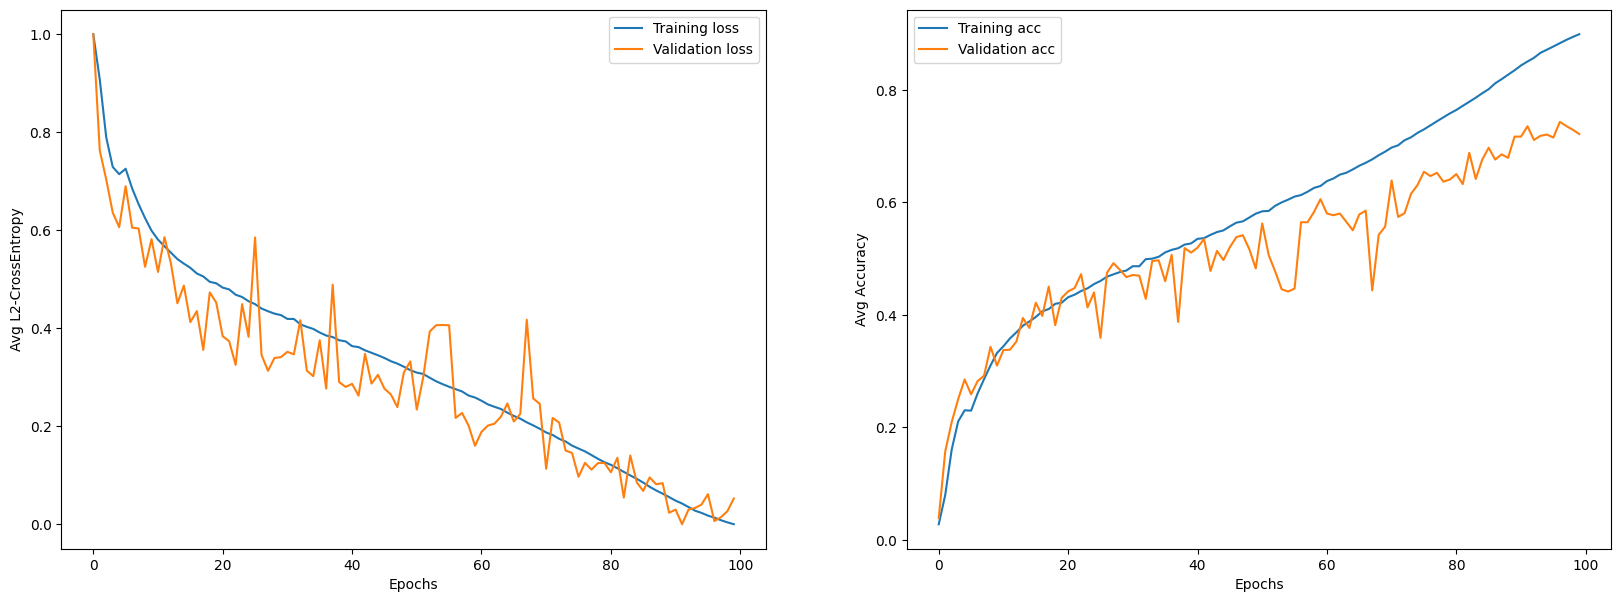

In [17]:
scaled_loss = (res_df['Loss'].to_numpy() - np.min(res_df['Loss'].to_numpy())) / (np.max(res_df['Loss'].to_numpy()) - np.min(res_df['Loss'].to_numpy()))
scaled_val_loss = (res_df['Val_Loss'].to_numpy() - np.min(res_df['Val_Loss'].to_numpy())) / (np.max(res_df['Val_Loss'].to_numpy()) - np.min(res_df['Val_Loss'].to_numpy()))

# Plot results
plt.figure(figsize=[20,7])
plt.subplot(1,2,1)
plt.plot(range(settings['epochs']), scaled_loss, label='Training loss')
plt.plot(range(settings['epochs']), scaled_val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Avg L2-CrossEntropy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(settings['epochs']), res_df['Accuracy'], label='Training acc')
plt.plot(range(settings['epochs']), res_df['Val_Accuracy'], label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Avg Accuracy')
plt.legend();

### 2.2.2 - Exporting the model and tesing

In [18]:
# Export the export
exported = SuperNet_model.export(verbose=1)

[BEST ALTERNATIVE for features.4.block.2]:
Identity()

[BEST ALTERNATIVE for features.5.block.2]:
DepthwiseSeparableConv(
  (depthwise): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=120)
  (depth_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pointwise): Conv2d(120, 120, kernel_size=(1, 1), stride=(1, 1), groups=2)
  (point_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE for features.6.block.2]:
DepthwiseSeparableConv(
  (depthwise): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=120)
  (depth_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pointwise): Conv2d(120, 120, kernel_size=(1, 1), stride=(1, 1), groups=2)
  (point_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE for features.11.b

In [19]:
# look at the exported model
exported

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [20]:
# Test the exported model
SuperNet_acc = utils.eval_model(
    model=exported,
    device=device,
    data_loader=test_dataloader
)  

  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED - Avg Accuracy: 76.68%


In [21]:
# Save the exported model
utils.save_experiment(root='./experiments', model=exported, seed=SEED, settings=settings, exported=True, metrics_df=res_df)

### 2.2.3 - Comparison with basline MBNV3

In [22]:
# Test the baseline model
baseline_model = torch.load(f'./main_models/MobileNetV3_seed{SEED}.pt', weights_only=False)

# Test the basline model
baseline_acc = utils.eval_model(
    model=baseline_model,
    device=device,
    data_loader=test_dataloader
) 

  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED - Avg Accuracy: 80.73%


In [23]:
gap = SuperNet_acc - baseline_acc

print(f'SuperNet accuracy on test data: {(SuperNet_acc*100):.2f}', end=" -> ")
if gap <= 0:
    print(f'{(abs(gap)*100):.2f}% less than baseline')
else:
    print(f'{(abs(gap)*100):.2f}% more than baseline')

SuperNet accuracy on test data: 76.68 -> 4.05% less than baseline


In [24]:
baseline_params = utils.count_parameters(model=baseline_model)
SuperNet_params = utils.count_parameters(model=exported)
params_ratio = 1 - SuperNet_params / baseline_params if SuperNet_params <= baseline_params else (SuperNet_params - baseline_params) / baseline_params

print(f'#Parameters SuperNet MBNV3: {SuperNet_params}', end=" -> ")
if SuperNet_params <= baseline_params:
    print(f'{(params_ratio*100):.2f}% less than baseline')
else:
    print(f'{(params_ratio*100):.2f}% more than baseline')

#Parameters SuperNet MBNV3: 3482412 -> 19.58% less than baseline


# 3 - FLOPs-based Regularizers

The second cost metric we consider is the number of floating point operations (_FLOPs_) performed by each alternative in a `SuperModule`.

This cost metric moves the optimization process towards more efficient networks in terms of computational costs. This might help when we want to find a model with a lower complexity such that it consumes less energy when deployed on battery devices. 

## 3.1 - Stable Weighted FLOPs

In [10]:
# Load the initialization
SuperNet_model = utils.baseline_SuperNet(exp_seed=SEED, dataset=train_dataset, identity=True, verbose=False)
SuperNet_model

SuperNet(
  (seed): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
   

In [11]:
# Let's look at the FLOPs for each alternative in each SuperModule
for path in SuperNet_model.paths:
    super_module = SuperNet_model.seed.get_submodule(path)
    print(f'{path}:')

    for idx, alt in enumerate(super_module.alternatives):
        print(f'\t- #FLOPs {alt.__class__.__name__}: {super_module.flops_count[idx]}')

    print()

features.4.block.2:
	- #FLOPs Identity: 0.0
	- #FLOPs ConvBNRelu: 1806336.0
	- #FLOPs ConvBNRelu: 2314368.0
	- #FLOPs DepthwiseSeparableConv: 2991744.0

features.5.block.2:
	- #FLOPs Identity: 0.0
	- #FLOPs ConvBNRelu: 4704000.0
	- #FLOPs ConvBNRelu: 6115200.0
	- #FLOPs DepthwiseSeparableConv: 7244160.0

features.6.block.2:
	- #FLOPs Identity: 0.0
	- #FLOPs ConvBNRelu: 4704000.0
	- #FLOPs ConvBNRelu: 6115200.0
	- #FLOPs DepthwiseSeparableConv: 7244160.0

features.11.block.2:
	- #FLOPs Identity: 0.0
	- #FLOPs ConvBNRelu: 17404800.0
	- #FLOPs ConvBNRelu: 23049600.0
	- #FLOPs DepthwiseSeparableConv: 24178560.0

features.12.block.2:
	- #FLOPs Identity: 0.0
	- #FLOPs ConvBNRelu: 33849984.0
	- #FLOPs ConvBNRelu: 44913792.0
	- #FLOPs DepthwiseSeparableConv: 46494336.0

features.13.block.2:
	- #FLOPs Identity: 0.0
	- #FLOPs ConvBNRelu: 8462496.0
	- #FLOPs ConvBNRelu: 11228448.0
	- #FLOPs DepthwiseSeparableConv: 11623584.0

features.14.block.2:
	- #FLOPs Identity: 0.0
	- #FLOPs ConvBNRelu: 1716

### 3.1.1 - Training

In [12]:
settings = {
    'epochs': 100,
    'lr': 0.2,
    'loss': 'L2-CrossEntropy',
    'label_smoothing': 0.1,
    'regularizer': 'SWR',
    'cost': 'flops',
    'stable_alpha': 1e-3,
    'momentum': 0.9,
    'weight_decay': 2e-5
}

In [13]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=settings['label_smoothing'])

# Regularizer
regularizer = SuperRegularizer(type_cost=settings['cost'], stable_alpha=settings['stable_alpha'])
regularizer

SuperRegularizer()

In [14]:
# Balance gradients
utils.check_gradients(model=SuperNet_model, primar_loss_fn=loss_fn, reg_loss_fn=regularizer, dataset=train_dataset)

Primar Loss ((<class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'utils')):
- Loss:		4.610083103179932
- Gradient:	1.986168622970581
SWR Loss (Metric: flops):
- Loss:		0.005242327693849802
- Gradient:	0.0005256168660707772


In [15]:
# Optimizer
optimizer = torch.optim.SGD(params=SuperNet_model.parameters(), lr=settings['lr'], momentum=settings['momentum'], weight_decay=settings['weight_decay'])

# Learning rate scheduler 
main_shceduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=settings['epochs'])
warmup = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=0.01, total_iters=5) # Linear warmup
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=optimizer, schedulers=[warmup, main_shceduler], milestones=[5])

In [16]:
# Train the model
loss_h, acc_h, val_loss_h, val_acc_h = utils.train_model(
    model=SuperNet_model,
    device=device,
    data_loader=train_dataloader,
    loss_fn=loss_fn,
    regularizer=regularizer,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    val_dataloader=test_dataloader,
    seed=SEED
)

*********************
EPOCH 0 on cuda - Current learning rate: 0.0020



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.59492 | Avg Accuracy: 1.50%
Computed 1999/8125 batches - Avg Loss: 4.55991 | Avg Accuracy: 1.72%
Computed 2999/8125 batches - Avg Loss: 4.52759 | Avg Accuracy: 2.01%
Computed 3999/8125 batches - Avg Loss: 4.50085 | Avg Accuracy: 2.26%
Computed 4999/8125 batches - Avg Loss: 4.47823 | Avg Accuracy: 2.52%
Computed 5999/8125 batches - Avg Loss: 4.45752 | Avg Accuracy: 2.73%
Computed 6999/8125 batches - Avg Loss: 4.43786 | Avg Accuracy: 2.93%
Computed 7999/8125 batches - Avg Loss: 4.41973 | Avg Accuracy: 3.16%

End of EPOCH 0 - Avg Loss: 4.41689 | Avg Accuracy: 3.20%
Training time: 585.392 seconds.

DNAS parameters:
	- features.4.block.2: [[0.24183928966522217, 0.31278494000434875, 0.2592916488647461, 0.1828412413597107]]
	- features.5.block.2: [[0.2839590311050415, 0.2331344485282898, 0.24380436539649963, 0.2358604073524475]]
	- features.6.block.2: [[0.25774821639060974, 0.25013425946235657, 0.25439271330833435, 0.23448258638381958]]
	- features.11.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 5.33%
*********************
EPOCH 1 on cuda - Current learning rate: 0.0416



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.55014 | Avg Accuracy: 2.48%
Computed 1999/8125 batches - Avg Loss: 4.44885 | Avg Accuracy: 3.40%
Computed 2999/8125 batches - Avg Loss: 4.37640 | Avg Accuracy: 4.26%
Computed 3999/8125 batches - Avg Loss: 4.32158 | Avg Accuracy: 5.04%
Computed 4999/8125 batches - Avg Loss: 4.27329 | Avg Accuracy: 5.82%
Computed 5999/8125 batches - Avg Loss: 4.23168 | Avg Accuracy: 6.48%
Computed 6999/8125 batches - Avg Loss: 4.19417 | Avg Accuracy: 7.14%
Computed 7999/8125 batches - Avg Loss: 4.15861 | Avg Accuracy: 7.79%

End of EPOCH 1 - Avg Loss: 4.15369 | Avg Accuracy: 7.87%
Training time: 584.326 seconds.

DNAS parameters:
	- features.4.block.2: [[1.339334487915039, -0.3699326813220978, 0.5880219340324402, -0.6258286833763123]]
	- features.5.block.2: [[0.17940446734428406, -0.060616523027420044, 0.13928483426570892, 0.6735284328460693]]
	- features.6.block.2: [[0.5224555730819702, 0.3398140072822571, 0.21358196437358856, -0.14425092935562134]]
	- features.1

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 11.72%
*********************
EPOCH 2 on cuda - Current learning rate: 0.0812



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.97342 | Avg Accuracy: 10.97%
Computed 1999/8125 batches - Avg Loss: 3.93105 | Avg Accuracy: 11.76%
Computed 2999/8125 batches - Avg Loss: 3.89481 | Avg Accuracy: 12.62%
Computed 3999/8125 batches - Avg Loss: 3.86556 | Avg Accuracy: 13.30%
Computed 4999/8125 batches - Avg Loss: 3.83271 | Avg Accuracy: 14.06%
Computed 5999/8125 batches - Avg Loss: 3.80339 | Avg Accuracy: 14.67%
Computed 6999/8125 batches - Avg Loss: 3.77481 | Avg Accuracy: 15.37%
Computed 7999/8125 batches - Avg Loss: 3.74660 | Avg Accuracy: 16.05%

End of EPOCH 2 - Avg Loss: 3.74343 | Avg Accuracy: 16.12%
Training time: 585.142 seconds.

DNAS parameters:
	- features.4.block.2: [[4.760272026062012, -1.7214736938476562, -0.748278021812439, -1.4741110801696777]]
	- features.5.block.2: [[0.14113260805606842, -0.2488967776298523, -0.4584702253341675, 1.3826639652252197]]
	- features.6.block.2: [[1.4747194051742554, -0.45823001861572266, 0.318569153547287, -0.5186371803283691]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 25.14%
*********************
EPOCH 3 on cuda - Current learning rate: 0.1208



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.67581 | Avg Accuracy: 18.33%
Computed 1999/8125 batches - Avg Loss: 3.64878 | Avg Accuracy: 18.95%
Computed 2999/8125 batches - Avg Loss: 3.63266 | Avg Accuracy: 19.30%
Computed 3999/8125 batches - Avg Loss: 3.61566 | Avg Accuracy: 19.64%
Computed 4999/8125 batches - Avg Loss: 3.59626 | Avg Accuracy: 20.04%
Computed 5999/8125 batches - Avg Loss: 3.57790 | Avg Accuracy: 20.52%
Computed 6999/8125 batches - Avg Loss: 3.56370 | Avg Accuracy: 20.88%
Computed 7999/8125 batches - Avg Loss: 3.55021 | Avg Accuracy: 21.16%

End of EPOCH 3 - Avg Loss: 3.54790 | Avg Accuracy: 21.20%
Training time: 584.504 seconds.

DNAS parameters:
	- features.4.block.2: [[5.536515712738037, -1.6874507665634155, -1.3457567691802979, -1.832429051399231]]
	- features.5.block.2: [[-0.5308255553245544, -0.6506801843643188, -0.7935140132904053, 2.6459054946899414]]
	- features.6.block.2: [[1.8973922729492188, -0.7482162117958069, 0.5340633392333984, -1.0123592615127563]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 28.31%
*********************
EPOCH 4 on cuda - Current learning rate: 0.1604



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.59148 | Avg Accuracy: 21.02%
Computed 1999/8125 batches - Avg Loss: 3.57895 | Avg Accuracy: 21.03%
Computed 2999/8125 batches - Avg Loss: 3.56721 | Avg Accuracy: 21.18%
Computed 3999/8125 batches - Avg Loss: 3.56315 | Avg Accuracy: 21.49%
Computed 4999/8125 batches - Avg Loss: 3.54737 | Avg Accuracy: 21.83%
Computed 5999/8125 batches - Avg Loss: 3.53640 | Avg Accuracy: 22.14%
Computed 6999/8125 batches - Avg Loss: 3.52398 | Avg Accuracy: 22.47%
Computed 7999/8125 batches - Avg Loss: 3.51350 | Avg Accuracy: 22.75%

End of EPOCH 4 - Avg Loss: 3.51122 | Avg Accuracy: 22.79%
Training time: 585.511 seconds.

DNAS parameters:
	- features.4.block.2: [[5.797330379486084, -1.7047110795974731, -1.7091213464736938, -1.8665900230407715]]
	- features.5.block.2: [[-1.1141126155853271, -0.8761510848999023, -0.9453110694885254, 3.452495574951172]]
	- features.6.block.2: [[2.231229543685913, -1.276732325553894, 0.3345023989677429, -0.7720839381217957]]
	- featur

/home/tiziano-tezze/ProgramFiles/miniconda3/envs/cv-project/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 28.23%
*********************
EPOCH 5 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.56845 | Avg Accuracy: 22.70%
Computed 1999/8125 batches - Avg Loss: 3.57560 | Avg Accuracy: 22.16%
Computed 2999/8125 batches - Avg Loss: 3.57177 | Avg Accuracy: 22.30%
Computed 3999/8125 batches - Avg Loss: 3.56628 | Avg Accuracy: 22.59%
Computed 4999/8125 batches - Avg Loss: 3.56511 | Avg Accuracy: 22.55%
Computed 5999/8125 batches - Avg Loss: 3.55846 | Avg Accuracy: 22.63%
Computed 6999/8125 batches - Avg Loss: 3.55019 | Avg Accuracy: 22.81%
Computed 7999/8125 batches - Avg Loss: 3.54341 | Avg Accuracy: 23.00%

End of EPOCH 5 - Avg Loss: 3.54205 | Avg Accuracy: 23.02%
Training time: 586.530 seconds.

DNAS parameters:
	- features.4.block.2: [[5.868359565734863, -1.908092737197876, -1.6476926803588867, -1.939149260520935]]
	- features.5.block.2: [[-0.8236088752746582, -1.2791615724563599, -1.131379246711731, 3.607595205307007]]
	- features.6.block.2: [[2.569854497909546, -1.4119218587875366, 0.26205429434776306, -1.046546459197998]]
	- features

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 27.34%
*********************
EPOCH 6 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.44836 | Avg Accuracy: 25.34%
Computed 1999/8125 batches - Avg Loss: 3.43522 | Avg Accuracy: 25.54%
Computed 2999/8125 batches - Avg Loss: 3.43929 | Avg Accuracy: 25.49%
Computed 3999/8125 batches - Avg Loss: 3.42793 | Avg Accuracy: 25.78%
Computed 4999/8125 batches - Avg Loss: 3.41971 | Avg Accuracy: 25.93%
Computed 5999/8125 batches - Avg Loss: 3.40903 | Avg Accuracy: 26.27%
Computed 6999/8125 batches - Avg Loss: 3.40259 | Avg Accuracy: 26.35%
Computed 7999/8125 batches - Avg Loss: 3.39719 | Avg Accuracy: 26.48%

End of EPOCH 6 - Avg Loss: 3.39596 | Avg Accuracy: 26.48%
Training time: 586.049 seconds.

DNAS parameters:
	- features.4.block.2: [[6.144353866577148, -1.576472282409668, -1.7796190977096558, -2.5184552669525146]]
	- features.5.block.2: [[-1.1091668605804443, -1.0549882650375366, -1.6401711702346802, 4.074132442474365]]
	- features.6.block.2: [[2.9394545555114746, -1.5013313293457031, -0.0029716617427766323, -1.1653521060943604]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 29.89%
*********************
EPOCH 7 on cuda - Current learning rate: 0.1998



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.32598 | Avg Accuracy: 28.23%
Computed 1999/8125 batches - Avg Loss: 3.30651 | Avg Accuracy: 28.80%
Computed 2999/8125 batches - Avg Loss: 3.30611 | Avg Accuracy: 28.59%
Computed 3999/8125 batches - Avg Loss: 3.29954 | Avg Accuracy: 28.76%
Computed 4999/8125 batches - Avg Loss: 3.29608 | Avg Accuracy: 28.73%
Computed 5999/8125 batches - Avg Loss: 3.29327 | Avg Accuracy: 28.85%
Computed 6999/8125 batches - Avg Loss: 3.28672 | Avg Accuracy: 29.02%
Computed 7999/8125 batches - Avg Loss: 3.28161 | Avg Accuracy: 29.12%

End of EPOCH 7 - Avg Loss: 3.28072 | Avg Accuracy: 29.14%
Training time: 585.446 seconds.

DNAS parameters:
	- features.4.block.2: [[5.729170322418213, -1.425113320350647, -1.8716000318527222, -2.2374837398529053]]
	- features.5.block.2: [[-1.161812424659729, -1.1956002712249756, -1.577547311782837, 4.129929065704346]]
	- features.6.block.2: [[3.570685625076294, -1.6487009525299072, -0.3654525876045227, -1.3615518808364868]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 30.99%
*********************
EPOCH 8 on cuda - Current learning rate: 0.1996



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.21694 | Avg Accuracy: 30.72%
Computed 1999/8125 batches - Avg Loss: 3.21493 | Avg Accuracy: 30.98%
Computed 2999/8125 batches - Avg Loss: 3.21548 | Avg Accuracy: 30.86%
Computed 3999/8125 batches - Avg Loss: 3.20715 | Avg Accuracy: 31.13%
Computed 4999/8125 batches - Avg Loss: 3.20492 | Avg Accuracy: 31.14%
Computed 5999/8125 batches - Avg Loss: 3.20838 | Avg Accuracy: 31.04%
Computed 6999/8125 batches - Avg Loss: 3.20486 | Avg Accuracy: 31.02%
Computed 7999/8125 batches - Avg Loss: 3.20207 | Avg Accuracy: 31.06%

End of EPOCH 8 - Avg Loss: 3.20049 | Avg Accuracy: 31.07%
Training time: 588.307 seconds.

DNAS parameters:
	- features.4.block.2: [[5.588384628295898, -1.508226752281189, -2.1780636310577393, -1.7611432075500488]]
	- features.5.block.2: [[-1.2405723333358765, -0.9866827726364136, -1.2581700086593628, 3.6263694763183594]]
	- features.6.block.2: [[4.374601364135742, -1.6643062829971313, -0.9616637825965881, -1.6076743602752686]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 37.40%
*********************
EPOCH 9 on cuda - Current learning rate: 0.1992



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.15174 | Avg Accuracy: 32.27%
Computed 1999/8125 batches - Avg Loss: 3.14593 | Avg Accuracy: 32.24%
Computed 2999/8125 batches - Avg Loss: 3.14746 | Avg Accuracy: 32.44%
Computed 3999/8125 batches - Avg Loss: 3.13675 | Avg Accuracy: 32.73%
Computed 4999/8125 batches - Avg Loss: 3.13549 | Avg Accuracy: 32.78%
Computed 5999/8125 batches - Avg Loss: 3.13464 | Avg Accuracy: 32.84%
Computed 6999/8125 batches - Avg Loss: 3.13153 | Avg Accuracy: 32.95%
Computed 7999/8125 batches - Avg Loss: 3.13030 | Avg Accuracy: 33.01%

End of EPOCH 9 - Avg Loss: 3.12981 | Avg Accuracy: 33.00%
Training time: 584.972 seconds.

DNAS parameters:
	- features.4.block.2: [[6.0654473304748535, -1.7859835624694824, -2.0133635997772217, -2.164151906967163]]
	- features.5.block.2: [[-1.61002779006958, -0.7911401391029358, -1.326751708984375, 3.829874038696289]]
	- features.6.block.2: [[4.155097961425781, -1.3685153722763062, -0.9820770621299744, -1.702544927597046]]
	- features

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 37.64%
*********************
EPOCH 10 on cuda - Current learning rate: 0.1988



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.06830 | Avg Accuracy: 34.30%
Computed 1999/8125 batches - Avg Loss: 3.09049 | Avg Accuracy: 33.70%
Computed 2999/8125 batches - Avg Loss: 3.08644 | Avg Accuracy: 33.67%
Computed 3999/8125 batches - Avg Loss: 3.07867 | Avg Accuracy: 33.96%
Computed 4999/8125 batches - Avg Loss: 3.07711 | Avg Accuracy: 34.05%
Computed 5999/8125 batches - Avg Loss: 3.07459 | Avg Accuracy: 34.15%
Computed 6999/8125 batches - Avg Loss: 3.07102 | Avg Accuracy: 34.28%
Computed 7999/8125 batches - Avg Loss: 3.06835 | Avg Accuracy: 34.37%

End of EPOCH 10 - Avg Loss: 3.06879 | Avg Accuracy: 34.36%
Training time: 583.892 seconds.

DNAS parameters:
	- features.4.block.2: [[5.6102752685546875, -1.4305630922317505, -2.3874921798706055, -1.7184149026870728]]
	- features.5.block.2: [[-1.3860875368118286, -0.8966808915138245, -1.1359121799468994, 3.4924962520599365]]
	- features.6.block.2: [[4.477019309997559, -1.3705501556396484, -1.287848711013794, -1.7448179721832275]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 36.26%
*********************
EPOCH 11 on cuda - Current learning rate: 0.1982



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.02298 | Avg Accuracy: 35.82%
Computed 1999/8125 batches - Avg Loss: 3.02891 | Avg Accuracy: 35.54%
Computed 2999/8125 batches - Avg Loss: 3.03312 | Avg Accuracy: 35.36%
Computed 3999/8125 batches - Avg Loss: 3.03346 | Avg Accuracy: 35.36%
Computed 4999/8125 batches - Avg Loss: 3.03354 | Avg Accuracy: 35.30%
Computed 5999/8125 batches - Avg Loss: 3.03364 | Avg Accuracy: 35.37%
Computed 6999/8125 batches - Avg Loss: 3.02881 | Avg Accuracy: 35.49%
Computed 7999/8125 batches - Avg Loss: 3.02736 | Avg Accuracy: 35.52%

End of EPOCH 11 - Avg Loss: 3.02730 | Avg Accuracy: 35.49%
Training time: 588.356 seconds.

DNAS parameters:
	- features.4.block.2: [[6.959046840667725, -1.1795443296432495, -3.04475998878479, -2.681271553039551]]
	- features.5.block.2: [[-1.1629533767700195, -1.2706449031829834, -1.1754926443099976, 3.662576913833618]]
	- features.6.block.2: [[4.034655570983887, -1.5130568742752075, -0.9269631505012512, -1.5411676168441772]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 36.80%
*********************
EPOCH 12 on cuda - Current learning rate: 0.1976



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.00160 | Avg Accuracy: 36.54%
Computed 1999/8125 batches - Avg Loss: 2.99700 | Avg Accuracy: 36.58%
Computed 2999/8125 batches - Avg Loss: 2.98488 | Avg Accuracy: 36.83%
Computed 3999/8125 batches - Avg Loss: 2.98183 | Avg Accuracy: 36.82%
Computed 4999/8125 batches - Avg Loss: 2.98366 | Avg Accuracy: 36.81%
Computed 5999/8125 batches - Avg Loss: 2.98535 | Avg Accuracy: 36.66%
Computed 6999/8125 batches - Avg Loss: 2.98938 | Avg Accuracy: 36.54%
Computed 7999/8125 batches - Avg Loss: 2.98836 | Avg Accuracy: 36.56%

End of EPOCH 12 - Avg Loss: 2.98771 | Avg Accuracy: 36.53%
Training time: 587.234 seconds.

DNAS parameters:
	- features.4.block.2: [[6.9770660400390625, -1.6321113109588623, -3.257587194442749, -2.048555374145508]]
	- features.5.block.2: [[-1.0969469547271729, -1.3532768487930298, -1.2453452348709106, 3.7343618869781494]]
	- features.6.block.2: [[4.425133228302002, -1.474236011505127, -1.3187857866287231, -1.5933445692062378]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 36.10%
*********************
EPOCH 13 on cuda - Current learning rate: 0.1969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.94991 | Avg Accuracy: 37.17%
Computed 1999/8125 batches - Avg Loss: 2.96072 | Avg Accuracy: 37.01%
Computed 2999/8125 batches - Avg Loss: 2.95989 | Avg Accuracy: 37.04%
Computed 3999/8125 batches - Avg Loss: 2.95833 | Avg Accuracy: 37.20%
Computed 4999/8125 batches - Avg Loss: 2.95242 | Avg Accuracy: 37.31%
Computed 5999/8125 batches - Avg Loss: 2.94920 | Avg Accuracy: 37.34%
Computed 6999/8125 batches - Avg Loss: 2.94885 | Avg Accuracy: 37.38%
Computed 7999/8125 batches - Avg Loss: 2.94685 | Avg Accuracy: 37.45%

End of EPOCH 13 - Avg Loss: 2.94672 | Avg Accuracy: 37.43%
Training time: 587.429 seconds.

DNAS parameters:
	- features.4.block.2: [[5.931207656860352, -1.766067385673523, -2.6423258781433105, -1.4946485757827759]]
	- features.5.block.2: [[-1.6273584365844727, -1.2351207733154297, -1.1128756999969482, 4.0035271644592285]]
	- features.6.block.2: [[4.367433547973633, -1.3048430681228638, -1.4110705852508545, -1.6233481168746948]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 39.72%
*********************
EPOCH 14 on cuda - Current learning rate: 0.1960



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.91367 | Avg Accuracy: 38.43%
Computed 1999/8125 batches - Avg Loss: 2.90971 | Avg Accuracy: 38.59%
Computed 2999/8125 batches - Avg Loss: 2.91426 | Avg Accuracy: 38.39%
Computed 3999/8125 batches - Avg Loss: 2.91499 | Avg Accuracy: 38.25%
Computed 4999/8125 batches - Avg Loss: 2.91959 | Avg Accuracy: 38.17%
Computed 5999/8125 batches - Avg Loss: 2.91988 | Avg Accuracy: 38.22%
Computed 6999/8125 batches - Avg Loss: 2.91625 | Avg Accuracy: 38.33%
Computed 7999/8125 batches - Avg Loss: 2.91609 | Avg Accuracy: 38.38%

End of EPOCH 14 - Avg Loss: 2.91487 | Avg Accuracy: 38.39%
Training time: 587.713 seconds.

DNAS parameters:
	- features.4.block.2: [[5.333570957183838, -1.4160887002944946, -1.8736010789871216, -2.023426055908203]]
	- features.5.block.2: [[-1.5782301425933838, -0.9684195518493652, -1.1025642156600952, 3.6696906089782715]]
	- features.6.block.2: [[4.2357940673828125, -1.3633198738098145, -1.4298908710479736, -1.4221022129058838]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 38.92%
*********************
EPOCH 15 on cuda - Current learning rate: 0.1951



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.89723 | Avg Accuracy: 39.08%
Computed 1999/8125 batches - Avg Loss: 2.89939 | Avg Accuracy: 38.93%
Computed 2999/8125 batches - Avg Loss: 2.89451 | Avg Accuracy: 39.11%
Computed 3999/8125 batches - Avg Loss: 2.89549 | Avg Accuracy: 38.96%
Computed 4999/8125 batches - Avg Loss: 2.89638 | Avg Accuracy: 38.94%
Computed 5999/8125 batches - Avg Loss: 2.89474 | Avg Accuracy: 39.06%
Computed 6999/8125 batches - Avg Loss: 2.89080 | Avg Accuracy: 39.10%
Computed 7999/8125 batches - Avg Loss: 2.88830 | Avg Accuracy: 39.17%

End of EPOCH 15 - Avg Loss: 2.88821 | Avg Accuracy: 39.17%
Training time: 587.895 seconds.

DNAS parameters:
	- features.4.block.2: [[6.59914493560791, -1.1518861055374146, -1.5679572820663452, -3.8643953800201416]]
	- features.5.block.2: [[-1.7712434530258179, -0.7444652318954468, -1.0184417963027954, 3.549062490463257]]
	- features.6.block.2: [[3.8688199520111084, -1.1262681484222412, -1.3468992710113525, -1.3807272911071777]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 37.74%
*********************
EPOCH 16 on cuda - Current learning rate: 0.1941



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.87023 | Avg Accuracy: 39.75%
Computed 1999/8125 batches - Avg Loss: 2.86577 | Avg Accuracy: 39.73%
Computed 2999/8125 batches - Avg Loss: 2.85989 | Avg Accuracy: 39.77%
Computed 3999/8125 batches - Avg Loss: 2.86015 | Avg Accuracy: 39.76%
Computed 4999/8125 batches - Avg Loss: 2.85562 | Avg Accuracy: 39.97%
Computed 5999/8125 batches - Avg Loss: 2.85758 | Avg Accuracy: 39.86%
Computed 6999/8125 batches - Avg Loss: 2.85577 | Avg Accuracy: 39.94%
Computed 7999/8125 batches - Avg Loss: 2.85668 | Avg Accuracy: 39.90%

End of EPOCH 16 - Avg Loss: 2.85680 | Avg Accuracy: 39.86%
Training time: 587.711 seconds.

DNAS parameters:
	- features.4.block.2: [[6.021815299987793, -0.8876854777336121, -2.288539409637451, -2.834738254547119]]
	- features.5.block.2: [[-1.7559012174606323, -1.1086820363998413, -0.9728103280067444, 3.848273992538452]]
	- features.6.block.2: [[4.181905269622803, -1.4339698553085327, -1.3575431108474731, -1.379501461982727]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 40.73%
*********************
EPOCH 17 on cuda - Current learning rate: 0.1930



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.81255 | Avg Accuracy: 41.22%
Computed 1999/8125 batches - Avg Loss: 2.82802 | Avg Accuracy: 41.04%
Computed 2999/8125 batches - Avg Loss: 2.82738 | Avg Accuracy: 40.99%
Computed 3999/8125 batches - Avg Loss: 2.83283 | Avg Accuracy: 40.81%
Computed 4999/8125 batches - Avg Loss: 2.83163 | Avg Accuracy: 40.78%
Computed 5999/8125 batches - Avg Loss: 2.83353 | Avg Accuracy: 40.74%
Computed 6999/8125 batches - Avg Loss: 2.83458 | Avg Accuracy: 40.62%
Computed 7999/8125 batches - Avg Loss: 2.83389 | Avg Accuracy: 40.63%

End of EPOCH 17 - Avg Loss: 2.83391 | Avg Accuracy: 40.63%
Training time: 587.150 seconds.

DNAS parameters:
	- features.4.block.2: [[5.548276901245117, -0.799747884273529, -2.5977532863616943, -2.142836809158325]]
	- features.5.block.2: [[-1.7637556791305542, -0.9856539964675903, -0.7177397012710571, 3.475100040435791]]
	- features.6.block.2: [[4.053117275238037, -1.4762448072433472, -1.3247220516204834, -1.2441763877868652]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.63%
*********************
EPOCH 18 on cuda - Current learning rate: 0.1918



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.79898 | Avg Accuracy: 41.66%
Computed 1999/8125 batches - Avg Loss: 2.80171 | Avg Accuracy: 41.38%
Computed 2999/8125 batches - Avg Loss: 2.80124 | Avg Accuracy: 41.34%
Computed 3999/8125 batches - Avg Loss: 2.80755 | Avg Accuracy: 41.18%
Computed 4999/8125 batches - Avg Loss: 2.80652 | Avg Accuracy: 41.15%
Computed 5999/8125 batches - Avg Loss: 2.80519 | Avg Accuracy: 41.18%
Computed 6999/8125 batches - Avg Loss: 2.81005 | Avg Accuracy: 41.01%
Computed 7999/8125 batches - Avg Loss: 2.81052 | Avg Accuracy: 41.03%

End of EPOCH 18 - Avg Loss: 2.81024 | Avg Accuracy: 41.01%
Training time: 587.567 seconds.

DNAS parameters:
	- features.4.block.2: [[6.429717063903809, -0.7147291302680969, -3.942559003829956, -1.7666012048721313]]
	- features.5.block.2: [[-1.8133091926574707, -0.8439285755157471, -0.9205283522605896, 3.5835843086242676]]
	- features.6.block.2: [[3.9194560050964355, -1.2478798627853394, -1.5244511365890503, -1.1412923336029053]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.87%
*********************
EPOCH 19 on cuda - Current learning rate: 0.1905



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.77891 | Avg Accuracy: 42.13%
Computed 1999/8125 batches - Avg Loss: 2.78075 | Avg Accuracy: 42.02%
Computed 2999/8125 batches - Avg Loss: 2.77728 | Avg Accuracy: 41.98%
Computed 3999/8125 batches - Avg Loss: 2.78363 | Avg Accuracy: 41.87%
Computed 4999/8125 batches - Avg Loss: 2.78293 | Avg Accuracy: 41.91%
Computed 5999/8125 batches - Avg Loss: 2.78867 | Avg Accuracy: 41.78%
Computed 6999/8125 batches - Avg Loss: 2.79133 | Avg Accuracy: 41.67%
Computed 7999/8125 batches - Avg Loss: 2.78899 | Avg Accuracy: 41.72%

End of EPOCH 19 - Avg Loss: 2.78829 | Avg Accuracy: 41.73%
Training time: 586.780 seconds.

DNAS parameters:
	- features.4.block.2: [[6.338149547576904, -0.6789769530296326, -2.8836867809295654, -2.7712175846099854]]
	- features.5.block.2: [[-1.8443514108657837, -0.8040252327919006, -0.8671655058860779, 3.519819498062134]]
	- features.6.block.2: [[4.0606889724731445, -1.3847739696502686, -1.5081350803375244, -1.1635098457336426]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.15%
*********************
EPOCH 20 on cuda - Current learning rate: 0.1891



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.76619 | Avg Accuracy: 43.13%
Computed 1999/8125 batches - Avg Loss: 2.76862 | Avg Accuracy: 42.49%
Computed 2999/8125 batches - Avg Loss: 2.76722 | Avg Accuracy: 42.36%
Computed 3999/8125 batches - Avg Loss: 2.76698 | Avg Accuracy: 42.35%
Computed 4999/8125 batches - Avg Loss: 2.76808 | Avg Accuracy: 42.35%
Computed 5999/8125 batches - Avg Loss: 2.76858 | Avg Accuracy: 42.41%
Computed 6999/8125 batches - Avg Loss: 2.76640 | Avg Accuracy: 42.52%
Computed 7999/8125 batches - Avg Loss: 2.76581 | Avg Accuracy: 42.47%

End of EPOCH 20 - Avg Loss: 2.76559 | Avg Accuracy: 42.44%
Training time: 587.311 seconds.

DNAS parameters:
	- features.4.block.2: [[4.983752250671387, -0.7274428009986877, -2.0928311347961426, -2.160339117050171]]
	- features.5.block.2: [[-1.9610079526901245, -0.7420760989189148, -0.736480176448822, 3.442715644836426]]
	- features.6.block.2: [[3.810526132583618, -1.3392976522445679, -1.3333476781845093, -1.1347416639328003]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 41.65%
*********************
EPOCH 21 on cuda - Current learning rate: 0.1876



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.75276 | Avg Accuracy: 43.04%
Computed 1999/8125 batches - Avg Loss: 2.74584 | Avg Accuracy: 42.78%
Computed 2999/8125 batches - Avg Loss: 2.74370 | Avg Accuracy: 42.97%
Computed 3999/8125 batches - Avg Loss: 2.74930 | Avg Accuracy: 42.96%
Computed 4999/8125 batches - Avg Loss: 2.74461 | Avg Accuracy: 43.10%
Computed 5999/8125 batches - Avg Loss: 2.74758 | Avg Accuracy: 43.02%
Computed 6999/8125 batches - Avg Loss: 2.74721 | Avg Accuracy: 43.01%
Computed 7999/8125 batches - Avg Loss: 2.74787 | Avg Accuracy: 43.00%

End of EPOCH 21 - Avg Loss: 2.74794 | Avg Accuracy: 42.99%
Training time: 586.185 seconds.

DNAS parameters:
	- features.4.block.2: [[6.801679611206055, -1.4210385084152222, -1.6622956991195679, -3.7160120010375977]]
	- features.5.block.2: [[-1.824129343032837, -0.657693088054657, -0.8644979596138, 3.348646402359009]]
	- features.6.block.2: [[3.694596529006958, -1.3198915719985962, -1.2130540609359741, -1.1593272686004639]]
	- features

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 43.95%
*********************
EPOCH 22 on cuda - Current learning rate: 0.1861



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.72561 | Avg Accuracy: 43.67%
Computed 1999/8125 batches - Avg Loss: 2.72727 | Avg Accuracy: 43.57%
Computed 2999/8125 batches - Avg Loss: 2.73561 | Avg Accuracy: 43.25%
Computed 3999/8125 batches - Avg Loss: 2.73179 | Avg Accuracy: 43.16%
Computed 4999/8125 batches - Avg Loss: 2.73240 | Avg Accuracy: 43.18%
Computed 5999/8125 batches - Avg Loss: 2.73144 | Avg Accuracy: 43.22%
Computed 6999/8125 batches - Avg Loss: 2.73213 | Avg Accuracy: 43.25%
Computed 7999/8125 batches - Avg Loss: 2.73316 | Avg Accuracy: 43.21%

End of EPOCH 22 - Avg Loss: 2.73315 | Avg Accuracy: 43.17%
Training time: 586.682 seconds.

DNAS parameters:
	- features.4.block.2: [[5.5765275955200195, -1.1126444339752197, -1.7117271423339844, -2.750413417816162]]
	- features.5.block.2: [[-2.001589298248291, -0.5118390321731567, -0.7823744416236877, 3.2975220680236816]]
	- features.6.block.2: [[3.55478572845459, -1.2051080465316772, -1.187897801399231, -1.1600608825683594]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 45.17%
*********************
EPOCH 23 on cuda - Current learning rate: 0.1844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.67568 | Avg Accuracy: 45.09%
Computed 1999/8125 batches - Avg Loss: 2.69273 | Avg Accuracy: 44.35%
Computed 2999/8125 batches - Avg Loss: 2.69610 | Avg Accuracy: 44.28%
Computed 3999/8125 batches - Avg Loss: 2.69981 | Avg Accuracy: 44.22%
Computed 4999/8125 batches - Avg Loss: 2.70503 | Avg Accuracy: 43.96%
Computed 5999/8125 batches - Avg Loss: 2.71073 | Avg Accuracy: 43.90%
Computed 6999/8125 batches - Avg Loss: 2.71184 | Avg Accuracy: 43.89%
Computed 7999/8125 batches - Avg Loss: 2.71082 | Avg Accuracy: 43.91%

End of EPOCH 23 - Avg Loss: 2.71065 | Avg Accuracy: 43.91%
Training time: 587.684 seconds.

DNAS parameters:
	- features.4.block.2: [[7.021296977996826, -2.821331024169922, -1.4322634935379028, -2.7664148807525635]]
	- features.5.block.2: [[-2.1169679164886475, -0.549117922782898, -0.9318073391914368, 3.599181890487671]]
	- features.6.block.2: [[3.4492664337158203, -1.1007691621780396, -1.2387241125106812, -1.1084911823272705]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.65%
*********************
EPOCH 24 on cuda - Current learning rate: 0.1827



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.66470 | Avg Accuracy: 44.98%
Computed 1999/8125 batches - Avg Loss: 2.66711 | Avg Accuracy: 45.09%
Computed 2999/8125 batches - Avg Loss: 2.67038 | Avg Accuracy: 44.90%
Computed 3999/8125 batches - Avg Loss: 2.67401 | Avg Accuracy: 44.87%
Computed 4999/8125 batches - Avg Loss: 2.67850 | Avg Accuracy: 44.80%
Computed 5999/8125 batches - Avg Loss: 2.68079 | Avg Accuracy: 44.73%
Computed 6999/8125 batches - Avg Loss: 2.68007 | Avg Accuracy: 44.69%
Computed 7999/8125 batches - Avg Loss: 2.68129 | Avg Accuracy: 44.62%

End of EPOCH 24 - Avg Loss: 2.68059 | Avg Accuracy: 44.62%
Training time: 587.698 seconds.

DNAS parameters:
	- features.4.block.2: [[5.5113043785095215, -2.2949819564819336, -1.1087194681167603, -2.1066696643829346]]
	- features.5.block.2: [[-2.166193962097168, -0.6395126581192017, -0.5744597315788269, 3.3811450004577637]]
	- features.6.block.2: [[3.537637948989868, -1.1507045030593872, -1.2336565256118774, -1.15232515335083]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.22%
*********************
EPOCH 25 on cuda - Current learning rate: 0.1809



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.63892 | Avg Accuracy: 45.56%
Computed 1999/8125 batches - Avg Loss: 2.65467 | Avg Accuracy: 45.27%
Computed 2999/8125 batches - Avg Loss: 2.65911 | Avg Accuracy: 45.22%
Computed 3999/8125 batches - Avg Loss: 2.66165 | Avg Accuracy: 45.10%
Computed 4999/8125 batches - Avg Loss: 2.65926 | Avg Accuracy: 45.14%
Computed 5999/8125 batches - Avg Loss: 2.65786 | Avg Accuracy: 45.21%
Computed 6999/8125 batches - Avg Loss: 2.66054 | Avg Accuracy: 45.14%
Computed 7999/8125 batches - Avg Loss: 2.66197 | Avg Accuracy: 45.08%

End of EPOCH 25 - Avg Loss: 2.66257 | Avg Accuracy: 45.05%
Training time: 586.040 seconds.

DNAS parameters:
	- features.4.block.2: [[5.35142707824707, -2.6269896030426025, -0.9950074553489685, -1.7287269830703735]]
	- features.5.block.2: [[-2.322237253189087, -0.4235667884349823, -0.5747091174125671, 3.321249485015869]]
	- features.6.block.2: [[3.4734556674957275, -1.0413340330123901, -1.289980411529541, -1.1414299011230469]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 43.25%
*********************
EPOCH 26 on cuda - Current learning rate: 0.1790



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.63933 | Avg Accuracy: 46.05%
Computed 1999/8125 batches - Avg Loss: 2.62948 | Avg Accuracy: 46.03%
Computed 2999/8125 batches - Avg Loss: 2.63270 | Avg Accuracy: 45.74%
Computed 3999/8125 batches - Avg Loss: 2.63613 | Avg Accuracy: 45.65%
Computed 4999/8125 batches - Avg Loss: 2.63627 | Avg Accuracy: 45.68%
Computed 5999/8125 batches - Avg Loss: 2.64032 | Avg Accuracy: 45.52%
Computed 6999/8125 batches - Avg Loss: 2.64143 | Avg Accuracy: 45.49%
Computed 7999/8125 batches - Avg Loss: 2.64473 | Avg Accuracy: 45.38%

End of EPOCH 26 - Avg Loss: 2.64463 | Avg Accuracy: 45.36%
Training time: 585.524 seconds.

DNAS parameters:
	- features.4.block.2: [[5.173750877380371, -2.3607349395751953, -1.542484998703003, -1.2700176239013672]]
	- features.5.block.2: [[-2.7900538444519043, -0.18079744279384613, -0.44558343291282654, 3.416985511779785]]
	- features.6.block.2: [[3.42067813873291, -1.0266730785369873, -1.2302087545394897, -1.1632575988769531]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 45.37%
*********************
EPOCH 27 on cuda - Current learning rate: 0.1771



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.60890 | Avg Accuracy: 45.98%
Computed 1999/8125 batches - Avg Loss: 2.61736 | Avg Accuracy: 45.86%
Computed 2999/8125 batches - Avg Loss: 2.62340 | Avg Accuracy: 45.89%
Computed 3999/8125 batches - Avg Loss: 2.62135 | Avg Accuracy: 45.99%
Computed 4999/8125 batches - Avg Loss: 2.62282 | Avg Accuracy: 45.89%
Computed 5999/8125 batches - Avg Loss: 2.62520 | Avg Accuracy: 45.90%
Computed 6999/8125 batches - Avg Loss: 2.62598 | Avg Accuracy: 45.89%
Computed 7999/8125 batches - Avg Loss: 2.62431 | Avg Accuracy: 45.97%

End of EPOCH 27 - Avg Loss: 2.62426 | Avg Accuracy: 45.95%
Training time: 587.328 seconds.

DNAS parameters:
	- features.4.block.2: [[4.902499198913574, -2.389292001724243, -1.3379474878311157, -1.1748778820037842]]
	- features.5.block.2: [[-2.778919219970703, 0.04943038895726204, -0.3118562400341034, 3.0417540073394775]]
	- features.6.block.2: [[3.3035452365875244, -0.9664162397384644, -1.1529266834259033, -1.1837985515594482]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.16%
*********************
EPOCH 28 on cuda - Current learning rate: 0.1750



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.58577 | Avg Accuracy: 47.03%
Computed 1999/8125 batches - Avg Loss: 2.59663 | Avg Accuracy: 46.63%
Computed 2999/8125 batches - Avg Loss: 2.60118 | Avg Accuracy: 46.57%
Computed 3999/8125 batches - Avg Loss: 2.59822 | Avg Accuracy: 46.63%
Computed 4999/8125 batches - Avg Loss: 2.59804 | Avg Accuracy: 46.62%
Computed 5999/8125 batches - Avg Loss: 2.60043 | Avg Accuracy: 46.57%
Computed 6999/8125 batches - Avg Loss: 2.60194 | Avg Accuracy: 46.59%
Computed 7999/8125 batches - Avg Loss: 2.60375 | Avg Accuracy: 46.58%

End of EPOCH 28 - Avg Loss: 2.60400 | Avg Accuracy: 46.56%
Training time: 587.538 seconds.

DNAS parameters:
	- features.4.block.2: [[5.219433307647705, -2.161405086517334, -1.147542119026184, -1.9102104902267456]]
	- features.5.block.2: [[-2.843353033065796, 0.2012195587158203, -0.45307594537734985, 3.0955090522766113]]
	- features.6.block.2: [[3.414548397064209, -0.9733455181121826, -1.2436379194259644, -1.1972551345825195]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.70%
*********************
EPOCH 29 on cuda - Current learning rate: 0.1729



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.55389 | Avg Accuracy: 47.92%
Computed 1999/8125 batches - Avg Loss: 2.57054 | Avg Accuracy: 47.51%
Computed 2999/8125 batches - Avg Loss: 2.57694 | Avg Accuracy: 47.36%
Computed 3999/8125 batches - Avg Loss: 2.58788 | Avg Accuracy: 47.03%
Computed 4999/8125 batches - Avg Loss: 2.59096 | Avg Accuracy: 46.96%
Computed 5999/8125 batches - Avg Loss: 2.59087 | Avg Accuracy: 46.91%
Computed 6999/8125 batches - Avg Loss: 2.59125 | Avg Accuracy: 46.84%
Computed 7999/8125 batches - Avg Loss: 2.59180 | Avg Accuracy: 46.86%

End of EPOCH 29 - Avg Loss: 2.59136 | Avg Accuracy: 46.86%
Training time: 587.931 seconds.

DNAS parameters:
	- features.4.block.2: [[4.549062728881836, -1.6276122331619263, -1.3431445360183716, -1.5781391859054565]]
	- features.5.block.2: [[-2.8379554748535156, 0.13648387789726257, -0.24528257548809052, 2.9469783306121826]]
	- features.6.block.2: [[3.3712961673736572, -0.9380022287368774, -1.2437199354171753, -1.1893446445465088]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.42%
*********************
EPOCH 30 on cuda - Current learning rate: 0.1707



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.52566 | Avg Accuracy: 48.77%
Computed 1999/8125 batches - Avg Loss: 2.54087 | Avg Accuracy: 48.37%
Computed 2999/8125 batches - Avg Loss: 2.54727 | Avg Accuracy: 48.25%
Computed 3999/8125 batches - Avg Loss: 2.54809 | Avg Accuracy: 48.14%
Computed 4999/8125 batches - Avg Loss: 2.55164 | Avg Accuracy: 48.02%
Computed 5999/8125 batches - Avg Loss: 2.55536 | Avg Accuracy: 47.82%
Computed 6999/8125 batches - Avg Loss: 2.55962 | Avg Accuracy: 47.73%
Computed 7999/8125 batches - Avg Loss: 2.56291 | Avg Accuracy: 47.61%

End of EPOCH 30 - Avg Loss: 2.56222 | Avg Accuracy: 47.60%
Training time: 586.368 seconds.

DNAS parameters:
	- features.4.block.2: [[4.095839023590088, -1.5045666694641113, -1.1521320343017578, -1.4390268325805664]]
	- features.5.block.2: [[-2.827967882156372, 0.17325247824192047, -0.17370440065860748, 2.828583240509033]]
	- features.6.block.2: [[3.546846389770508, -0.9739828109741211, -1.3323804140090942, -1.2403087615966797]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 41.85%
*********************
EPOCH 31 on cuda - Current learning rate: 0.1685



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.52533 | Avg Accuracy: 48.85%
Computed 1999/8125 batches - Avg Loss: 2.52215 | Avg Accuracy: 48.69%
Computed 2999/8125 batches - Avg Loss: 2.53077 | Avg Accuracy: 48.30%
Computed 3999/8125 batches - Avg Loss: 2.53531 | Avg Accuracy: 48.13%
Computed 4999/8125 batches - Avg Loss: 2.53825 | Avg Accuracy: 48.11%
Computed 5999/8125 batches - Avg Loss: 2.54087 | Avg Accuracy: 48.11%
Computed 6999/8125 batches - Avg Loss: 2.54319 | Avg Accuracy: 47.98%
Computed 7999/8125 batches - Avg Loss: 2.54301 | Avg Accuracy: 48.00%

End of EPOCH 31 - Avg Loss: 2.54264 | Avg Accuracy: 47.99%
Training time: 587.355 seconds.

DNAS parameters:
	- features.4.block.2: [[3.857058525085449, -1.266579031944275, -1.1101963520050049, -1.4801952838897705]]
	- features.5.block.2: [[-2.9111976623535156, 0.5003908276557922, -0.24497145414352417, 2.655893087387085]]
	- features.6.block.2: [[3.552934169769287, -1.022316813468933, -1.2786105871200562, -1.2518752813339233]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.61%
*********************
EPOCH 32 on cuda - Current learning rate: 0.1661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.51832 | Avg Accuracy: 48.62%
Computed 1999/8125 batches - Avg Loss: 2.51728 | Avg Accuracy: 48.86%
Computed 2999/8125 batches - Avg Loss: 2.51529 | Avg Accuracy: 49.01%
Computed 3999/8125 batches - Avg Loss: 2.51265 | Avg Accuracy: 49.04%
Computed 4999/8125 batches - Avg Loss: 2.51308 | Avg Accuracy: 49.01%
Computed 5999/8125 batches - Avg Loss: 2.51409 | Avg Accuracy: 48.99%
Computed 6999/8125 batches - Avg Loss: 2.51677 | Avg Accuracy: 48.92%
Computed 7999/8125 batches - Avg Loss: 2.51819 | Avg Accuracy: 48.90%

End of EPOCH 32 - Avg Loss: 2.51828 | Avg Accuracy: 48.87%
Training time: 588.138 seconds.

DNAS parameters:
	- features.4.block.2: [[4.972249984741211, -1.069108486175537, -2.326845169067383, -1.5762302875518799]]
	- features.5.block.2: [[-2.8832387924194336, 0.8336045742034912, -0.2787099778652191, 2.3284218311309814]]
	- features.6.block.2: [[3.386420965194702, -1.001518726348877, -1.1154366731643677, -1.2693710327148438]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 43.59%
*********************
EPOCH 33 on cuda - Current learning rate: 0.1637



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.47266 | Avg Accuracy: 50.02%
Computed 1999/8125 batches - Avg Loss: 2.48297 | Avg Accuracy: 49.58%
Computed 2999/8125 batches - Avg Loss: 2.48242 | Avg Accuracy: 49.73%
Computed 3999/8125 batches - Avg Loss: 2.48827 | Avg Accuracy: 49.58%
Computed 4999/8125 batches - Avg Loss: 2.49852 | Avg Accuracy: 49.22%
Computed 5999/8125 batches - Avg Loss: 2.49960 | Avg Accuracy: 49.14%
Computed 6999/8125 batches - Avg Loss: 2.49841 | Avg Accuracy: 49.20%
Computed 7999/8125 batches - Avg Loss: 2.50171 | Avg Accuracy: 49.12%

End of EPOCH 33 - Avg Loss: 2.50162 | Avg Accuracy: 49.11%
Training time: 587.148 seconds.

DNAS parameters:
	- features.4.block.2: [[5.114200115203857, -0.8850951790809631, -2.213277578353882, -2.015801191329956]]
	- features.5.block.2: [[-2.6345739364624023, 0.9261919856071472, -0.31325075030326843, 2.021695613861084]]
	- features.6.block.2: [[3.316131114959717, -0.9707711935043335, -1.1302707195281982, -1.2150070667266846]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.35%
*********************
EPOCH 34 on cuda - Current learning rate: 0.1613



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.45493 | Avg Accuracy: 50.63%
Computed 1999/8125 batches - Avg Loss: 2.46086 | Avg Accuracy: 50.65%
Computed 2999/8125 batches - Avg Loss: 2.46744 | Avg Accuracy: 50.30%
Computed 3999/8125 batches - Avg Loss: 2.47122 | Avg Accuracy: 50.03%
Computed 4999/8125 batches - Avg Loss: 2.47685 | Avg Accuracy: 49.84%
Computed 5999/8125 batches - Avg Loss: 2.47944 | Avg Accuracy: 49.69%
Computed 6999/8125 batches - Avg Loss: 2.47891 | Avg Accuracy: 49.70%
Computed 7999/8125 batches - Avg Loss: 2.48060 | Avg Accuracy: 49.67%

End of EPOCH 34 - Avg Loss: 2.48077 | Avg Accuracy: 49.64%
Training time: 587.802 seconds.

DNAS parameters:
	- features.4.block.2: [[4.269716262817383, -0.767732560634613, -1.7448896169662476, -1.7570655345916748]]
	- features.5.block.2: [[-2.664027690887451, 0.6739262342453003, -0.4854564368724823, 2.475607395172119]]
	- features.6.block.2: [[3.363109827041626, -0.9760884642601013, -1.1657358407974243, -1.221219778060913]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.40%
*********************
EPOCH 35 on cuda - Current learning rate: 0.1588



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.44441 | Avg Accuracy: 50.85%
Computed 1999/8125 batches - Avg Loss: 2.44552 | Avg Accuracy: 50.43%
Computed 2999/8125 batches - Avg Loss: 2.44869 | Avg Accuracy: 50.21%
Computed 3999/8125 batches - Avg Loss: 2.44962 | Avg Accuracy: 50.23%
Computed 4999/8125 batches - Avg Loss: 2.45032 | Avg Accuracy: 50.34%
Computed 5999/8125 batches - Avg Loss: 2.45597 | Avg Accuracy: 50.22%
Computed 6999/8125 batches - Avg Loss: 2.45944 | Avg Accuracy: 50.21%
Computed 7999/8125 batches - Avg Loss: 2.46227 | Avg Accuracy: 50.16%

End of EPOCH 35 - Avg Loss: 2.46100 | Avg Accuracy: 50.20%
Training time: 586.998 seconds.

DNAS parameters:
	- features.4.block.2: [[5.415206432342529, -2.098975658416748, -1.6161402463912964, -1.700056552886963]]
	- features.5.block.2: [[-2.696101427078247, 0.733946681022644, -0.4378148019313812, 2.4000093936920166]]
	- features.6.block.2: [[3.4173197746276855, -0.9901840686798096, -1.1309075355529785, -1.2961785793304443]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.50%
*********************
EPOCH 36 on cuda - Current learning rate: 0.1562



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.42771 | Avg Accuracy: 51.42%
Computed 1999/8125 batches - Avg Loss: 2.44400 | Avg Accuracy: 50.85%
Computed 2999/8125 batches - Avg Loss: 2.43367 | Avg Accuracy: 50.90%
Computed 3999/8125 batches - Avg Loss: 2.43666 | Avg Accuracy: 50.85%
Computed 4999/8125 batches - Avg Loss: 2.44123 | Avg Accuracy: 50.81%
Computed 5999/8125 batches - Avg Loss: 2.44442 | Avg Accuracy: 50.72%
Computed 6999/8125 batches - Avg Loss: 2.44518 | Avg Accuracy: 50.71%
Computed 7999/8125 batches - Avg Loss: 2.44729 | Avg Accuracy: 50.64%

End of EPOCH 36 - Avg Loss: 2.44640 | Avg Accuracy: 50.62%
Training time: 585.599 seconds.

DNAS parameters:
	- features.4.block.2: [[4.771738529205322, -2.06949782371521, -1.3175005912780762, -1.3847198486328125]]
	- features.5.block.2: [[-2.6158878803253174, 0.7433632016181946, -0.5789386034011841, 2.451493501663208]]
	- features.6.block.2: [[3.4649040699005127, -0.9802343845367432, -1.2186975479125977, -1.2659271955490112]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.29%
*********************
EPOCH 37 on cuda - Current learning rate: 0.1536



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.42000 | Avg Accuracy: 51.56%
Computed 1999/8125 batches - Avg Loss: 2.42651 | Avg Accuracy: 51.17%
Computed 2999/8125 batches - Avg Loss: 2.42145 | Avg Accuracy: 51.16%
Computed 3999/8125 batches - Avg Loss: 2.42424 | Avg Accuracy: 51.12%
Computed 4999/8125 batches - Avg Loss: 2.42428 | Avg Accuracy: 51.20%
Computed 5999/8125 batches - Avg Loss: 2.42959 | Avg Accuracy: 51.04%
Computed 6999/8125 batches - Avg Loss: 2.42595 | Avg Accuracy: 51.19%
Computed 7999/8125 batches - Avg Loss: 2.42528 | Avg Accuracy: 51.20%

End of EPOCH 37 - Avg Loss: 2.42513 | Avg Accuracy: 51.18%
Training time: 587.273 seconds.

DNAS parameters:
	- features.4.block.2: [[4.106196403503418, -1.750481128692627, -1.1457847356796265, -1.2099015712738037]]
	- features.5.block.2: [[-2.644218921661377, 0.7828709483146667, -0.3856780230998993, 2.247051477432251]]
	- features.6.block.2: [[3.5748074054718018, -0.9792444705963135, -1.2879595756530762, -1.3075783252716064]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.32%
*********************
EPOCH 38 on cuda - Current learning rate: 0.1509



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.37698 | Avg Accuracy: 52.76%
Computed 1999/8125 batches - Avg Loss: 2.39338 | Avg Accuracy: 52.27%
Computed 2999/8125 batches - Avg Loss: 2.39488 | Avg Accuracy: 52.01%
Computed 3999/8125 batches - Avg Loss: 2.39490 | Avg Accuracy: 51.94%
Computed 4999/8125 batches - Avg Loss: 2.40152 | Avg Accuracy: 51.81%
Computed 5999/8125 batches - Avg Loss: 2.40861 | Avg Accuracy: 51.54%
Computed 6999/8125 batches - Avg Loss: 2.40760 | Avg Accuracy: 51.60%
Computed 7999/8125 batches - Avg Loss: 2.40607 | Avg Accuracy: 51.65%

End of EPOCH 38 - Avg Loss: 2.40550 | Avg Accuracy: 51.65%
Training time: 585.729 seconds.

DNAS parameters:
	- features.4.block.2: [[4.189321517944336, -1.6540286540985107, -1.3776743412017822, -1.1575969457626343]]
	- features.5.block.2: [[-2.4332971572875977, 0.5064390301704407, -0.36674079298973083, 2.2936244010925293]]
	- features.6.block.2: [[3.508779764175415, -1.032987356185913, -1.22861909866333, -1.2471708059310913]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.22%
*********************
EPOCH 39 on cuda - Current learning rate: 0.1482



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.38179 | Avg Accuracy: 52.52%
Computed 1999/8125 batches - Avg Loss: 2.37914 | Avg Accuracy: 52.35%
Computed 2999/8125 batches - Avg Loss: 2.38644 | Avg Accuracy: 52.23%
Computed 3999/8125 batches - Avg Loss: 2.38530 | Avg Accuracy: 52.34%
Computed 4999/8125 batches - Avg Loss: 2.38678 | Avg Accuracy: 52.40%
Computed 5999/8125 batches - Avg Loss: 2.39091 | Avg Accuracy: 52.31%
Computed 6999/8125 batches - Avg Loss: 2.39264 | Avg Accuracy: 52.24%
Computed 7999/8125 batches - Avg Loss: 2.39412 | Avg Accuracy: 52.17%

End of EPOCH 39 - Avg Loss: 2.39383 | Avg Accuracy: 52.18%
Training time: 587.487 seconds.

DNAS parameters:
	- features.4.block.2: [[4.245547771453857, -1.5241954326629639, -1.5710963010787964, -1.1502400636672974]]
	- features.5.block.2: [[-2.3082029819488525, 0.4581322968006134, -0.6582021713256836, 2.5082919597625732]]
	- features.6.block.2: [[3.4152846336364746, -1.0606940984725952, -1.1419235467910767, -1.2126613855361938]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.22%
*********************
EPOCH 40 on cuda - Current learning rate: 0.1454



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.34299 | Avg Accuracy: 53.72%
Computed 1999/8125 batches - Avg Loss: 2.35249 | Avg Accuracy: 53.38%
Computed 2999/8125 batches - Avg Loss: 2.35085 | Avg Accuracy: 53.39%
Computed 3999/8125 batches - Avg Loss: 2.35902 | Avg Accuracy: 53.20%
Computed 4999/8125 batches - Avg Loss: 2.36608 | Avg Accuracy: 52.99%
Computed 5999/8125 batches - Avg Loss: 2.36447 | Avg Accuracy: 52.92%
Computed 6999/8125 batches - Avg Loss: 2.36580 | Avg Accuracy: 52.83%
Computed 7999/8125 batches - Avg Loss: 2.36715 | Avg Accuracy: 52.80%

End of EPOCH 40 - Avg Loss: 2.36701 | Avg Accuracy: 52.79%
Training time: 587.350 seconds.

DNAS parameters:
	- features.4.block.2: [[3.747722864151001, -1.288325548171997, -1.3630775213241577, -1.096301555633545]]
	- features.5.block.2: [[-2.2579030990600586, 0.2731548845767975, -0.5046142339706421, 2.489384651184082]]
	- features.6.block.2: [[3.4806649684906006, -1.1113088130950928, -1.195554494857788, -1.1737922430038452]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.24%
*********************
EPOCH 41 on cuda - Current learning rate: 0.1426



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.30057 | Avg Accuracy: 54.90%
Computed 1999/8125 batches - Avg Loss: 2.31701 | Avg Accuracy: 54.52%
Computed 2999/8125 batches - Avg Loss: 2.33234 | Avg Accuracy: 54.01%
Computed 3999/8125 batches - Avg Loss: 2.33853 | Avg Accuracy: 53.79%
Computed 4999/8125 batches - Avg Loss: 2.34391 | Avg Accuracy: 53.60%
Computed 5999/8125 batches - Avg Loss: 2.34514 | Avg Accuracy: 53.56%
Computed 6999/8125 batches - Avg Loss: 2.34862 | Avg Accuracy: 53.45%
Computed 7999/8125 batches - Avg Loss: 2.35233 | Avg Accuracy: 53.34%

End of EPOCH 41 - Avg Loss: 2.35295 | Avg Accuracy: 53.30%
Training time: 587.164 seconds.

DNAS parameters:
	- features.4.block.2: [[4.124127388000488, -1.130967378616333, -1.2161465883255005, -1.7769867181777954]]
	- features.5.block.2: [[-2.4874374866485596, 0.46695676445961, -0.45451822876930237, 2.4750123023986816]]
	- features.6.block.2: [[3.425199508666992, -1.091647982597351, -1.1504911184310913, -1.1830410957336426]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.63%
*********************
EPOCH 42 on cuda - Current learning rate: 0.1397



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.33172 | Avg Accuracy: 54.09%
Computed 1999/8125 batches - Avg Loss: 2.33964 | Avg Accuracy: 53.45%
Computed 2999/8125 batches - Avg Loss: 2.34521 | Avg Accuracy: 53.38%
Computed 3999/8125 batches - Avg Loss: 2.34277 | Avg Accuracy: 53.34%
Computed 4999/8125 batches - Avg Loss: 2.34466 | Avg Accuracy: 53.27%
Computed 5999/8125 batches - Avg Loss: 2.34127 | Avg Accuracy: 53.34%
Computed 6999/8125 batches - Avg Loss: 2.34115 | Avg Accuracy: 53.32%
Computed 7999/8125 batches - Avg Loss: 2.33880 | Avg Accuracy: 53.37%

End of EPOCH 42 - Avg Loss: 2.33826 | Avg Accuracy: 53.37%
Training time: 585.224 seconds.

DNAS parameters:
	- features.4.block.2: [[3.790825366973877, -1.0075899362564087, -1.2444268465042114, -1.5387904644012451]]
	- features.5.block.2: [[-2.5030903816223145, 0.3177405297756195, -0.3723689019680023, 2.5577354431152344]]
	- features.6.block.2: [[3.257901906967163, -0.9618602991104126, -1.1137797832489014, -1.1822339296340942]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 52.06%
*********************
EPOCH 43 on cuda - Current learning rate: 0.1368



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.30865 | Avg Accuracy: 54.71%
Computed 1999/8125 batches - Avg Loss: 2.31643 | Avg Accuracy: 54.60%
Computed 2999/8125 batches - Avg Loss: 2.31301 | Avg Accuracy: 54.55%
Computed 3999/8125 batches - Avg Loss: 2.30841 | Avg Accuracy: 54.62%
Computed 4999/8125 batches - Avg Loss: 2.31277 | Avg Accuracy: 54.47%
Computed 5999/8125 batches - Avg Loss: 2.31615 | Avg Accuracy: 54.33%
Computed 6999/8125 batches - Avg Loss: 2.31637 | Avg Accuracy: 54.33%
Computed 7999/8125 batches - Avg Loss: 2.31518 | Avg Accuracy: 54.33%

End of EPOCH 43 - Avg Loss: 2.31566 | Avg Accuracy: 54.28%
Training time: 586.816 seconds.

DNAS parameters:
	- features.4.block.2: [[3.501030445098877, -0.9467638731002808, -1.1556476354599, -1.3985955715179443]]
	- features.5.block.2: [[-2.4622318744659424, 0.34318044781684875, -0.2780139446258545, 2.397080659866333]]
	- features.6.block.2: [[3.423712968826294, -1.132243037223816, -1.1361885070800781, -1.1552698612213135]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.70%
*********************
EPOCH 44 on cuda - Current learning rate: 0.1339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.27890 | Avg Accuracy: 54.93%
Computed 1999/8125 batches - Avg Loss: 2.28885 | Avg Accuracy: 54.69%
Computed 2999/8125 batches - Avg Loss: 2.28872 | Avg Accuracy: 54.77%
Computed 3999/8125 batches - Avg Loss: 2.28784 | Avg Accuracy: 54.83%
Computed 4999/8125 batches - Avg Loss: 2.28931 | Avg Accuracy: 54.86%
Computed 5999/8125 batches - Avg Loss: 2.29122 | Avg Accuracy: 54.75%
Computed 6999/8125 batches - Avg Loss: 2.29384 | Avg Accuracy: 54.71%
Computed 7999/8125 batches - Avg Loss: 2.29455 | Avg Accuracy: 54.66%

End of EPOCH 44 - Avg Loss: 2.29405 | Avg Accuracy: 54.66%
Training time: 588.032 seconds.

DNAS parameters:
	- features.4.block.2: [[3.356696844100952, -0.9228498935699463, -1.0980981588363647, -1.3357306718826294]]
	- features.5.block.2: [[-2.4685161113739014, 0.30180519819259644, -0.26003554463386536, 2.426748037338257]]
	- features.6.block.2: [[3.338217258453369, -1.0547645092010498, -1.1164395809173584, -1.16701078414917]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.40%
*********************
EPOCH 45 on cuda - Current learning rate: 0.1309



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.25919 | Avg Accuracy: 55.84%
Computed 1999/8125 batches - Avg Loss: 2.25326 | Avg Accuracy: 55.91%
Computed 2999/8125 batches - Avg Loss: 2.26250 | Avg Accuracy: 55.80%
Computed 3999/8125 batches - Avg Loss: 2.27059 | Avg Accuracy: 55.55%
Computed 4999/8125 batches - Avg Loss: 2.27245 | Avg Accuracy: 55.56%
Computed 5999/8125 batches - Avg Loss: 2.27454 | Avg Accuracy: 55.44%
Computed 6999/8125 batches - Avg Loss: 2.27407 | Avg Accuracy: 55.41%
Computed 7999/8125 batches - Avg Loss: 2.27568 | Avg Accuracy: 55.42%

End of EPOCH 45 - Avg Loss: 2.27601 | Avg Accuracy: 55.38%
Training time: 588.115 seconds.

DNAS parameters:
	- features.4.block.2: [[3.2796642780303955, -0.8171692490577698, -1.096638560295105, -1.3658332824707031]]
	- features.5.block.2: [[-2.324458599090576, 0.49104171991348267, -0.3976897895336151, 2.2311110496520996]]
	- features.6.block.2: [[3.529562473297119, -1.1786079406738281, -1.0898574590682983, -1.261081337928772]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 41.85%
*********************
EPOCH 46 on cuda - Current learning rate: 0.1279



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.22790 | Avg Accuracy: 55.99%
Computed 1999/8125 batches - Avg Loss: 2.24179 | Avg Accuracy: 55.86%
Computed 2999/8125 batches - Avg Loss: 2.23972 | Avg Accuracy: 55.90%
Computed 3999/8125 batches - Avg Loss: 2.24706 | Avg Accuracy: 55.89%
Computed 4999/8125 batches - Avg Loss: 2.25200 | Avg Accuracy: 55.78%
Computed 5999/8125 batches - Avg Loss: 2.25327 | Avg Accuracy: 55.79%
Computed 6999/8125 batches - Avg Loss: 2.25752 | Avg Accuracy: 55.65%
Computed 7999/8125 batches - Avg Loss: 2.25865 | Avg Accuracy: 55.66%

End of EPOCH 46 - Avg Loss: 2.25891 | Avg Accuracy: 55.64%
Training time: 587.282 seconds.

DNAS parameters:
	- features.4.block.2: [[3.2427995204925537, -0.8356565833091736, -1.087875485420227, -1.319237470626831]]
	- features.5.block.2: [[-2.41438627243042, 0.4195830225944519, -0.35168302059173584, 2.346496105194092]]
	- features.6.block.2: [[3.4362518787384033, -1.1076765060424805, -1.0845668315887451, -1.2440080642700195]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.08%
*********************
EPOCH 47 on cuda - Current learning rate: 0.1249



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.23161 | Avg Accuracy: 56.37%
Computed 1999/8125 batches - Avg Loss: 2.22867 | Avg Accuracy: 56.38%
Computed 2999/8125 batches - Avg Loss: 2.23710 | Avg Accuracy: 56.18%
Computed 3999/8125 batches - Avg Loss: 2.23828 | Avg Accuracy: 56.20%
Computed 4999/8125 batches - Avg Loss: 2.24091 | Avg Accuracy: 56.12%
Computed 5999/8125 batches - Avg Loss: 2.24324 | Avg Accuracy: 56.06%
Computed 6999/8125 batches - Avg Loss: 2.24285 | Avg Accuracy: 56.09%
Computed 7999/8125 batches - Avg Loss: 2.24274 | Avg Accuracy: 56.09%

End of EPOCH 47 - Avg Loss: 2.24117 | Avg Accuracy: 56.12%
Training time: 587.380 seconds.

DNAS parameters:
	- features.4.block.2: [[3.454451560974121, -0.8574651479721069, -1.3087490797042847, -1.2882089614868164]]
	- features.5.block.2: [[-2.5080318450927734, 0.6345751881599426, -0.47574856877326965, 2.3492119312286377]]
	- features.6.block.2: [[3.370384454727173, -1.0537930727005005, -1.0710842609405518, -1.2454980611801147]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.53%
*********************
EPOCH 48 on cuda - Current learning rate: 0.1218



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.20273 | Avg Accuracy: 56.94%
Computed 1999/8125 batches - Avg Loss: 2.20488 | Avg Accuracy: 57.05%
Computed 2999/8125 batches - Avg Loss: 2.20933 | Avg Accuracy: 56.96%
Computed 3999/8125 batches - Avg Loss: 2.21191 | Avg Accuracy: 56.96%
Computed 4999/8125 batches - Avg Loss: 2.21546 | Avg Accuracy: 56.87%
Computed 5999/8125 batches - Avg Loss: 2.21756 | Avg Accuracy: 56.78%
Computed 6999/8125 batches - Avg Loss: 2.21977 | Avg Accuracy: 56.77%
Computed 7999/8125 batches - Avg Loss: 2.22353 | Avg Accuracy: 56.68%

End of EPOCH 48 - Avg Loss: 2.22411 | Avg Accuracy: 56.64%
Training time: 586.873 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3566231727600098, -0.8497595191001892, -1.240253210067749, -1.2665919065475464]]
	- features.5.block.2: [[-2.35800838470459, 0.3558661639690399, -0.5312398672103882, 2.5333898067474365]]
	- features.6.block.2: [[3.2734193801879883, -1.02327299118042, -1.0653725862503052, -1.1847670078277588]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.62%
*********************
EPOCH 49 on cuda - Current learning rate: 0.1187



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.17760 | Avg Accuracy: 57.82%
Computed 1999/8125 batches - Avg Loss: 2.18896 | Avg Accuracy: 57.71%
Computed 2999/8125 batches - Avg Loss: 2.18976 | Avg Accuracy: 57.62%
Computed 3999/8125 batches - Avg Loss: 2.19312 | Avg Accuracy: 57.53%
Computed 4999/8125 batches - Avg Loss: 2.19554 | Avg Accuracy: 57.49%
Computed 5999/8125 batches - Avg Loss: 2.19803 | Avg Accuracy: 57.37%
Computed 6999/8125 batches - Avg Loss: 2.19955 | Avg Accuracy: 57.29%
Computed 7999/8125 batches - Avg Loss: 2.20190 | Avg Accuracy: 57.17%

End of EPOCH 49 - Avg Loss: 2.20166 | Avg Accuracy: 57.18%
Training time: 586.372 seconds.

DNAS parameters:
	- features.4.block.2: [[3.506998300552368, -1.026521921157837, -1.1650605201721191, -1.3153977394104004]]
	- features.5.block.2: [[-2.3259730339050293, 0.5337885022163391, -0.5809066295623779, 2.373081922531128]]
	- features.6.block.2: [[3.4266481399536133, -1.0926952362060547, -1.1418023109436035, -1.1921488046646118]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.31%
*********************
EPOCH 50 on cuda - Current learning rate: 0.1156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.15460 | Avg Accuracy: 59.10%
Computed 1999/8125 batches - Avg Loss: 2.17135 | Avg Accuracy: 58.59%
Computed 2999/8125 batches - Avg Loss: 2.17372 | Avg Accuracy: 58.37%
Computed 3999/8125 batches - Avg Loss: 2.17759 | Avg Accuracy: 58.13%
Computed 4999/8125 batches - Avg Loss: 2.17809 | Avg Accuracy: 58.09%
Computed 5999/8125 batches - Avg Loss: 2.17699 | Avg Accuracy: 58.10%
Computed 6999/8125 batches - Avg Loss: 2.17943 | Avg Accuracy: 58.01%
Computed 7999/8125 batches - Avg Loss: 2.18155 | Avg Accuracy: 57.93%

End of EPOCH 50 - Avg Loss: 2.18177 | Avg Accuracy: 57.91%
Training time: 587.529 seconds.

DNAS parameters:
	- features.4.block.2: [[3.2974138259887695, -0.9197491407394409, -1.1040129661560059, -1.2736562490463257]]
	- features.5.block.2: [[-2.0290420055389404, 0.3356829285621643, -0.5668938755989075, 2.2602529525756836]]
	- features.6.block.2: [[3.4025590419769287, -1.1022170782089233, -1.1378591060638428, -1.1624921560287476]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.39%
*********************
EPOCH 51 on cuda - Current learning rate: 0.1125



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.14757 | Avg Accuracy: 58.99%
Computed 1999/8125 batches - Avg Loss: 2.15389 | Avg Accuracy: 58.77%
Computed 2999/8125 batches - Avg Loss: 2.15641 | Avg Accuracy: 58.64%
Computed 3999/8125 batches - Avg Loss: 2.16003 | Avg Accuracy: 58.38%
Computed 4999/8125 batches - Avg Loss: 2.16661 | Avg Accuracy: 58.17%
Computed 5999/8125 batches - Avg Loss: 2.16453 | Avg Accuracy: 58.25%
Computed 6999/8125 batches - Avg Loss: 2.16768 | Avg Accuracy: 58.13%
Computed 7999/8125 batches - Avg Loss: 2.16762 | Avg Accuracy: 58.15%

End of EPOCH 51 - Avg Loss: 2.16716 | Avg Accuracy: 58.16%
Training time: 586.271 seconds.

DNAS parameters:
	- features.4.block.2: [[3.317276954650879, -0.8879456520080566, -1.2387250661849976, -1.1906061172485352]]
	- features.5.block.2: [[-2.052177906036377, 0.14529170095920563, -0.45162490010261536, 2.3585057258605957]]
	- features.6.block.2: [[3.347306728363037, -1.0774203538894653, -1.1054444313049316, -1.164451241493225]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 55.69%
*********************
EPOCH 52 on cuda - Current learning rate: 0.1094



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.12578 | Avg Accuracy: 59.20%
Computed 1999/8125 batches - Avg Loss: 2.12479 | Avg Accuracy: 59.16%
Computed 2999/8125 batches - Avg Loss: 2.12769 | Avg Accuracy: 59.09%
Computed 3999/8125 batches - Avg Loss: 2.13449 | Avg Accuracy: 58.95%
Computed 4999/8125 batches - Avg Loss: 2.14210 | Avg Accuracy: 58.71%
Computed 5999/8125 batches - Avg Loss: 2.14430 | Avg Accuracy: 58.75%
Computed 6999/8125 batches - Avg Loss: 2.14387 | Avg Accuracy: 58.75%
Computed 7999/8125 batches - Avg Loss: 2.14581 | Avg Accuracy: 58.74%

End of EPOCH 52 - Avg Loss: 2.14553 | Avg Accuracy: 58.74%
Training time: 587.811 seconds.

DNAS parameters:
	- features.4.block.2: [[3.2804338932037354, -0.9011059403419495, -1.1938775777816772, -1.1854503154754639]]
	- features.5.block.2: [[-2.242691993713379, 0.17856049537658691, -0.43643584847450256, 2.5005507469177246]]
	- features.6.block.2: [[3.362053155899048, -1.0262850522994995, -1.1166062355041504, -1.219178318977356]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.61%
*********************
EPOCH 53 on cuda - Current learning rate: 0.1063



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.09672 | Avg Accuracy: 60.12%
Computed 1999/8125 batches - Avg Loss: 2.10027 | Avg Accuracy: 59.85%
Computed 2999/8125 batches - Avg Loss: 2.10467 | Avg Accuracy: 59.85%
Computed 3999/8125 batches - Avg Loss: 2.11409 | Avg Accuracy: 59.59%
Computed 4999/8125 batches - Avg Loss: 2.11837 | Avg Accuracy: 59.45%
Computed 5999/8125 batches - Avg Loss: 2.11974 | Avg Accuracy: 59.41%
Computed 6999/8125 batches - Avg Loss: 2.12491 | Avg Accuracy: 59.26%
Computed 7999/8125 batches - Avg Loss: 2.12649 | Avg Accuracy: 59.24%

End of EPOCH 53 - Avg Loss: 2.12665 | Avg Accuracy: 59.23%
Training time: 587.527 seconds.

DNAS parameters:
	- features.4.block.2: [[3.700716495513916, -0.8826546669006348, -1.1276973485946655, -1.6903735399246216]]
	- features.5.block.2: [[-2.161882162094116, 0.12675195932388306, -0.41696202754974365, 2.4520745277404785]]
	- features.6.block.2: [[3.3779823780059814, -1.0058575868606567, -1.1488962173461914, -1.22324538230896]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.81%
*********************
EPOCH 54 on cuda - Current learning rate: 0.1031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.08901 | Avg Accuracy: 60.47%
Computed 1999/8125 batches - Avg Loss: 2.09469 | Avg Accuracy: 59.97%
Computed 2999/8125 batches - Avg Loss: 2.09480 | Avg Accuracy: 60.18%
Computed 3999/8125 batches - Avg Loss: 2.09564 | Avg Accuracy: 60.13%
Computed 4999/8125 batches - Avg Loss: 2.09607 | Avg Accuracy: 60.14%
Computed 5999/8125 batches - Avg Loss: 2.10006 | Avg Accuracy: 60.04%
Computed 6999/8125 batches - Avg Loss: 2.10259 | Avg Accuracy: 60.00%
Computed 7999/8125 batches - Avg Loss: 2.10585 | Avg Accuracy: 59.92%

End of EPOCH 54 - Avg Loss: 2.10614 | Avg Accuracy: 59.89%
Training time: 585.610 seconds.

DNAS parameters:
	- features.4.block.2: [[3.508678436279297, -0.8724306225776672, -1.0834852457046509, -1.5527540445327759]]
	- features.5.block.2: [[-2.2600655555725098, 0.22290022671222687, -0.3558635711669922, 2.3930139541625977]]
	- features.6.block.2: [[3.3611414432525635, -0.9831764698028564, -1.1476624011993408, -1.2303105592727661]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.39%
*********************
EPOCH 55 on cuda - Current learning rate: 0.1000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.04338 | Avg Accuracy: 61.65%
Computed 1999/8125 batches - Avg Loss: 2.06576 | Avg Accuracy: 61.14%
Computed 2999/8125 batches - Avg Loss: 2.06907 | Avg Accuracy: 61.12%
Computed 3999/8125 batches - Avg Loss: 2.07690 | Avg Accuracy: 60.89%
Computed 4999/8125 batches - Avg Loss: 2.07986 | Avg Accuracy: 60.75%
Computed 5999/8125 batches - Avg Loss: 2.08333 | Avg Accuracy: 60.61%
Computed 6999/8125 batches - Avg Loss: 2.08416 | Avg Accuracy: 60.59%
Computed 7999/8125 batches - Avg Loss: 2.08832 | Avg Accuracy: 60.44%

End of EPOCH 55 - Avg Loss: 2.08830 | Avg Accuracy: 60.43%
Training time: 586.528 seconds.

DNAS parameters:
	- features.4.block.2: [[3.388725996017456, -0.8652225732803345, -1.066699743270874, -1.4567883014678955]]
	- features.5.block.2: [[-2.322450876235962, 0.30824220180511475, -0.39388346672058105, 2.408086061477661]]
	- features.6.block.2: [[3.388868808746338, -0.9794830083847046, -1.1371243000030518, -1.272265911102295]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.19%
*********************
EPOCH 56 on cuda - Current learning rate: 0.0969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.04370 | Avg Accuracy: 61.69%
Computed 1999/8125 batches - Avg Loss: 2.04322 | Avg Accuracy: 61.85%
Computed 2999/8125 batches - Avg Loss: 2.04933 | Avg Accuracy: 61.64%
Computed 3999/8125 batches - Avg Loss: 2.05314 | Avg Accuracy: 61.49%
Computed 4999/8125 batches - Avg Loss: 2.06026 | Avg Accuracy: 61.26%
Computed 5999/8125 batches - Avg Loss: 2.06277 | Avg Accuracy: 61.15%
Computed 6999/8125 batches - Avg Loss: 2.06670 | Avg Accuracy: 61.01%
Computed 7999/8125 batches - Avg Loss: 2.07079 | Avg Accuracy: 60.92%

End of EPOCH 56 - Avg Loss: 2.07111 | Avg Accuracy: 60.89%
Training time: 586.332 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3726258277893066, -0.8767045736312866, -1.1076014041900635, -1.388313889503479]]
	- features.5.block.2: [[-2.2518632411956787, 0.33785173296928406, -0.424672394990921, 2.338691234588623]]
	- features.6.block.2: [[3.3229875564575195, -0.9369785785675049, -1.1425093412399292, -1.243511438369751]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 58.29%
*********************
EPOCH 57 on cuda - Current learning rate: 0.0937



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.02076 | Avg Accuracy: 62.15%
Computed 1999/8125 batches - Avg Loss: 2.02633 | Avg Accuracy: 61.95%
Computed 2999/8125 batches - Avg Loss: 2.02884 | Avg Accuracy: 61.97%
Computed 3999/8125 batches - Avg Loss: 2.03512 | Avg Accuracy: 61.80%
Computed 4999/8125 batches - Avg Loss: 2.04406 | Avg Accuracy: 61.55%
Computed 5999/8125 batches - Avg Loss: 2.04545 | Avg Accuracy: 61.56%
Computed 6999/8125 batches - Avg Loss: 2.04774 | Avg Accuracy: 61.49%
Computed 7999/8125 batches - Avg Loss: 2.04832 | Avg Accuracy: 61.50%

End of EPOCH 57 - Avg Loss: 2.04785 | Avg Accuracy: 61.50%
Training time: 585.756 seconds.

DNAS parameters:
	- features.4.block.2: [[4.1058454513549805, -1.7188708782196045, -1.0771551132202148, -1.309807300567627]]
	- features.5.block.2: [[-2.344587802886963, 0.24578994512557983, -0.4952356517314911, 2.594027519226074]]
	- features.6.block.2: [[3.375931978225708, -0.9281029105186462, -1.1347543001174927, -1.3130815029144287]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 58.87%
*********************
EPOCH 58 on cuda - Current learning rate: 0.0906



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.00498 | Avg Accuracy: 62.78%
Computed 1999/8125 batches - Avg Loss: 2.00563 | Avg Accuracy: 62.74%
Computed 2999/8125 batches - Avg Loss: 2.00984 | Avg Accuracy: 62.54%
Computed 3999/8125 batches - Avg Loss: 2.01737 | Avg Accuracy: 62.26%
Computed 4999/8125 batches - Avg Loss: 2.01960 | Avg Accuracy: 62.23%
Computed 5999/8125 batches - Avg Loss: 2.02277 | Avg Accuracy: 62.15%
Computed 6999/8125 batches - Avg Loss: 2.02363 | Avg Accuracy: 62.14%
Computed 7999/8125 batches - Avg Loss: 2.02406 | Avg Accuracy: 62.14%

End of EPOCH 58 - Avg Loss: 2.02424 | Avg Accuracy: 62.11%
Training time: 587.769 seconds.

DNAS parameters:
	- features.4.block.2: [[4.449545383453369, -2.2205424308776855, -1.0099897384643555, -1.2190037965774536]]
	- features.5.block.2: [[-2.3471994400024414, 0.1516454666852951, -0.5135505795478821, 2.7091026306152344]]
	- features.6.block.2: [[3.3259427547454834, -0.8993337154388428, -1.142364740371704, -1.2842472791671753]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.05%
*********************
EPOCH 59 on cuda - Current learning rate: 0.0875



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.98944 | Avg Accuracy: 63.34%
Computed 1999/8125 batches - Avg Loss: 1.98474 | Avg Accuracy: 63.54%
Computed 2999/8125 batches - Avg Loss: 1.98906 | Avg Accuracy: 63.32%
Computed 3999/8125 batches - Avg Loss: 1.99514 | Avg Accuracy: 63.16%
Computed 4999/8125 batches - Avg Loss: 1.99802 | Avg Accuracy: 63.04%
Computed 5999/8125 batches - Avg Loss: 2.00150 | Avg Accuracy: 62.88%
Computed 6999/8125 batches - Avg Loss: 2.00452 | Avg Accuracy: 62.74%
Computed 7999/8125 batches - Avg Loss: 2.00746 | Avg Accuracy: 62.65%

End of EPOCH 59 - Avg Loss: 2.00718 | Avg Accuracy: 62.65%
Training time: 588.568 seconds.

DNAS parameters:
	- features.4.block.2: [[5.193535804748535, -2.1919806003570557, -0.9443938732147217, -2.057126045227051]]
	- features.5.block.2: [[-2.337398052215576, 0.14247912168502808, -0.562539279460907, 2.7574634552001953]]
	- features.6.block.2: [[3.3951549530029297, -0.9260703325271606, -1.1536225080490112, -1.3154618740081787]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 60.48%
*********************
EPOCH 60 on cuda - Current learning rate: 0.0844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.94705 | Avg Accuracy: 64.65%
Computed 1999/8125 batches - Avg Loss: 1.95956 | Avg Accuracy: 64.30%
Computed 2999/8125 batches - Avg Loss: 1.97324 | Avg Accuracy: 63.73%
Computed 3999/8125 batches - Avg Loss: 1.97148 | Avg Accuracy: 63.70%
Computed 4999/8125 batches - Avg Loss: 1.97633 | Avg Accuracy: 63.51%
Computed 5999/8125 batches - Avg Loss: 1.97933 | Avg Accuracy: 63.50%
Computed 6999/8125 batches - Avg Loss: 1.98078 | Avg Accuracy: 63.41%
Computed 7999/8125 batches - Avg Loss: 1.98476 | Avg Accuracy: 63.25%

End of EPOCH 60 - Avg Loss: 1.98438 | Avg Accuracy: 63.25%
Training time: 584.700 seconds.

DNAS parameters:
	- features.4.block.2: [[4.6388020515441895, -1.931764006614685, -0.8807907104492188, -1.8262144327163696]]
	- features.5.block.2: [[-2.1262519359588623, 0.21894454956054688, -0.5212372541427612, 2.4285526275634766]]
	- features.6.block.2: [[3.3541603088378906, -0.8852294087409973, -1.1458481550216675, -1.323096513748169]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 60.34%
*********************
EPOCH 61 on cuda - Current learning rate: 0.0813



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.95009 | Avg Accuracy: 64.31%
Computed 1999/8125 batches - Avg Loss: 1.95485 | Avg Accuracy: 64.12%
Computed 2999/8125 batches - Avg Loss: 1.95579 | Avg Accuracy: 64.15%
Computed 3999/8125 batches - Avg Loss: 1.95417 | Avg Accuracy: 64.21%
Computed 4999/8125 batches - Avg Loss: 1.95923 | Avg Accuracy: 64.04%
Computed 5999/8125 batches - Avg Loss: 1.95979 | Avg Accuracy: 64.08%
Computed 6999/8125 batches - Avg Loss: 1.96539 | Avg Accuracy: 63.92%
Computed 7999/8125 batches - Avg Loss: 1.96674 | Avg Accuracy: 63.86%

End of EPOCH 61 - Avg Loss: 1.96628 | Avg Accuracy: 63.84%
Training time: 587.276 seconds.

DNAS parameters:
	- features.4.block.2: [[4.296813488006592, -1.72349214553833, -0.8528744578361511, -1.7204227447509766]]
	- features.5.block.2: [[-2.2631680965423584, 0.34959661960601807, -0.5076926350593567, 2.4212756156921387]]
	- features.6.block.2: [[3.38700795173645, -0.8758935332298279, -1.1756268739700317, -1.3355038166046143]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.12%
*********************
EPOCH 62 on cuda - Current learning rate: 0.0782



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.92896 | Avg Accuracy: 64.65%
Computed 1999/8125 batches - Avg Loss: 1.92988 | Avg Accuracy: 64.76%
Computed 2999/8125 batches - Avg Loss: 1.93815 | Avg Accuracy: 64.49%
Computed 3999/8125 batches - Avg Loss: 1.94008 | Avg Accuracy: 64.47%
Computed 4999/8125 batches - Avg Loss: 1.94332 | Avg Accuracy: 64.36%
Computed 5999/8125 batches - Avg Loss: 1.94399 | Avg Accuracy: 64.35%
Computed 6999/8125 batches - Avg Loss: 1.94397 | Avg Accuracy: 64.37%
Computed 7999/8125 batches - Avg Loss: 1.94720 | Avg Accuracy: 64.30%

End of EPOCH 62 - Avg Loss: 1.94725 | Avg Accuracy: 64.28%
Training time: 587.831 seconds.

DNAS parameters:
	- features.4.block.2: [[4.056666374206543, -1.5726113319396973, -0.9053606986999512, -1.5786525011062622]]
	- features.5.block.2: [[-2.3296830654144287, 0.3953976631164551, -0.399246484041214, 2.333540678024292]]
	- features.6.block.2: [[3.3721823692321777, -0.8721853494644165, -1.153540015220642, -1.34646737575531]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 60.04%
*********************
EPOCH 63 on cuda - Current learning rate: 0.0751



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.90613 | Avg Accuracy: 65.72%
Computed 1999/8125 batches - Avg Loss: 1.90434 | Avg Accuracy: 65.61%
Computed 2999/8125 batches - Avg Loss: 1.90689 | Avg Accuracy: 65.64%
Computed 3999/8125 batches - Avg Loss: 1.91295 | Avg Accuracy: 65.44%
Computed 4999/8125 batches - Avg Loss: 1.91857 | Avg Accuracy: 65.24%
Computed 5999/8125 batches - Avg Loss: 1.92169 | Avg Accuracy: 65.13%
Computed 6999/8125 batches - Avg Loss: 1.92428 | Avg Accuracy: 65.06%
Computed 7999/8125 batches - Avg Loss: 1.92639 | Avg Accuracy: 64.98%

End of EPOCH 63 - Avg Loss: 1.92643 | Avg Accuracy: 64.94%
Training time: 586.728 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9019570350646973, -1.4405031204223633, -0.9374825954437256, -1.52393639087677]]
	- features.5.block.2: [[-2.179328680038452, 0.2542513608932495, -0.3578057587146759, 2.2829020023345947]]
	- features.6.block.2: [[3.3677940368652344, -0.8764393329620361, -1.1706571578979492, -1.3207001686096191]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.40%
*********************
EPOCH 64 on cuda - Current learning rate: 0.0721



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.88808 | Avg Accuracy: 66.66%
Computed 1999/8125 batches - Avg Loss: 1.88636 | Avg Accuracy: 66.50%
Computed 2999/8125 batches - Avg Loss: 1.89556 | Avg Accuracy: 66.00%
Computed 3999/8125 batches - Avg Loss: 1.90061 | Avg Accuracy: 65.88%
Computed 4999/8125 batches - Avg Loss: 1.90139 | Avg Accuracy: 65.84%
Computed 5999/8125 batches - Avg Loss: 1.90312 | Avg Accuracy: 65.73%
Computed 6999/8125 batches - Avg Loss: 1.90274 | Avg Accuracy: 65.72%
Computed 7999/8125 batches - Avg Loss: 1.90364 | Avg Accuracy: 65.64%

End of EPOCH 64 - Avg Loss: 1.90307 | Avg Accuracy: 65.64%
Training time: 585.948 seconds.

DNAS parameters:
	- features.4.block.2: [[3.7395105361938477, -1.3343451023101807, -0.969796895980835, -1.4353256225585938]]
	- features.5.block.2: [[-2.300018787384033, 0.2030324935913086, -0.3202267289161682, 2.4172091484069824]]
	- features.6.block.2: [[3.4381704330444336, -0.8881673216819763, -1.2628097534179688, -1.2871885299682617]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.96%
*********************
EPOCH 65 on cuda - Current learning rate: 0.0691



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.84311 | Avg Accuracy: 67.48%
Computed 1999/8125 batches - Avg Loss: 1.84468 | Avg Accuracy: 67.34%
Computed 2999/8125 batches - Avg Loss: 1.85651 | Avg Accuracy: 67.08%
Computed 3999/8125 batches - Avg Loss: 1.86122 | Avg Accuracy: 66.89%
Computed 4999/8125 batches - Avg Loss: 1.87001 | Avg Accuracy: 66.65%
Computed 5999/8125 batches - Avg Loss: 1.87534 | Avg Accuracy: 66.47%
Computed 6999/8125 batches - Avg Loss: 1.87755 | Avg Accuracy: 66.40%
Computed 7999/8125 batches - Avg Loss: 1.87930 | Avg Accuracy: 66.32%

End of EPOCH 65 - Avg Loss: 1.87890 | Avg Accuracy: 66.30%
Training time: 585.901 seconds.

DNAS parameters:
	- features.4.block.2: [[3.549060106277466, -1.2305405139923096, -0.9382948875427246, -1.3801902532577515]]
	- features.5.block.2: [[-2.3611342906951904, 0.2178216427564621, -0.3472718298435211, 2.490584135055542]]
	- features.6.block.2: [[3.477538585662842, -0.9281787872314453, -1.2974302768707275, -1.2519314289093018]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.82%
*********************
EPOCH 66 on cuda - Current learning rate: 0.0661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.85239 | Avg Accuracy: 67.50%
Computed 1999/8125 batches - Avg Loss: 1.85123 | Avg Accuracy: 67.15%
Computed 2999/8125 batches - Avg Loss: 1.85129 | Avg Accuracy: 67.04%
Computed 3999/8125 batches - Avg Loss: 1.85773 | Avg Accuracy: 66.94%
Computed 4999/8125 batches - Avg Loss: 1.85575 | Avg Accuracy: 67.01%
Computed 5999/8125 batches - Avg Loss: 1.85735 | Avg Accuracy: 66.95%
Computed 6999/8125 batches - Avg Loss: 1.85790 | Avg Accuracy: 66.98%
Computed 7999/8125 batches - Avg Loss: 1.86075 | Avg Accuracy: 66.88%

End of EPOCH 66 - Avg Loss: 1.86179 | Avg Accuracy: 66.84%
Training time: 583.783 seconds.

DNAS parameters:
	- features.4.block.2: [[3.6287333965301514, -1.1687476634979248, -0.9904618859291077, -1.4694942235946655]]
	- features.5.block.2: [[-2.341524362564087, 0.20684769749641418, -0.3699084520339966, 2.504593849182129]]
	- features.6.block.2: [[3.4637255668640137, -0.9532966613769531, -1.253836750984192, -1.256582260131836]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 60.48%
*********************
EPOCH 67 on cuda - Current learning rate: 0.0632



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.83062 | Avg Accuracy: 67.46%
Computed 1999/8125 batches - Avg Loss: 1.83080 | Avg Accuracy: 67.52%
Computed 2999/8125 batches - Avg Loss: 1.83337 | Avg Accuracy: 67.55%
Computed 3999/8125 batches - Avg Loss: 1.82774 | Avg Accuracy: 67.76%
Computed 4999/8125 batches - Avg Loss: 1.83418 | Avg Accuracy: 67.60%
Computed 5999/8125 batches - Avg Loss: 1.83523 | Avg Accuracy: 67.57%
Computed 6999/8125 batches - Avg Loss: 1.83595 | Avg Accuracy: 67.55%
Computed 7999/8125 batches - Avg Loss: 1.83934 | Avg Accuracy: 67.50%

End of EPOCH 67 - Avg Loss: 1.83893 | Avg Accuracy: 67.51%
Training time: 586.103 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5842630863189697, -1.1136422157287598, -1.0621875524520874, -1.4084141254425049]]
	- features.5.block.2: [[-2.319965362548828, 0.27008068561553955, -0.5778782367706299, 2.627784252166748]]
	- features.6.block.2: [[3.346588611602783, -0.9157552719116211, -1.1950221061706543, -1.2357956171035767]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.18%
*********************
EPOCH 68 on cuda - Current learning rate: 0.0603



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.78534 | Avg Accuracy: 68.94%
Computed 1999/8125 batches - Avg Loss: 1.80195 | Avg Accuracy: 68.52%
Computed 2999/8125 batches - Avg Loss: 1.80203 | Avg Accuracy: 68.61%
Computed 3999/8125 batches - Avg Loss: 1.80531 | Avg Accuracy: 68.57%
Computed 4999/8125 batches - Avg Loss: 1.81567 | Avg Accuracy: 68.22%
Computed 5999/8125 batches - Avg Loss: 1.81707 | Avg Accuracy: 68.11%
Computed 6999/8125 batches - Avg Loss: 1.82006 | Avg Accuracy: 68.06%
Computed 7999/8125 batches - Avg Loss: 1.82204 | Avg Accuracy: 68.01%

End of EPOCH 68 - Avg Loss: 1.82244 | Avg Accuracy: 67.98%
Training time: 585.421 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5127243995666504, -1.0877392292022705, -1.0500247478485107, -1.3749440908432007]]
	- features.5.block.2: [[-2.38154673576355, 0.1809980720281601, -0.547222375869751, 2.7477846145629883]]
	- features.6.block.2: [[3.3416574001312256, -0.9126166105270386, -1.1692203283309937, -1.259803295135498]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.98%
*********************
EPOCH 69 on cuda - Current learning rate: 0.0574



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.79506 | Avg Accuracy: 68.61%
Computed 1999/8125 batches - Avg Loss: 1.78532 | Avg Accuracy: 69.01%
Computed 2999/8125 batches - Avg Loss: 1.78559 | Avg Accuracy: 69.01%
Computed 3999/8125 batches - Avg Loss: 1.78945 | Avg Accuracy: 68.82%
Computed 4999/8125 batches - Avg Loss: 1.79300 | Avg Accuracy: 68.65%
Computed 5999/8125 batches - Avg Loss: 1.79440 | Avg Accuracy: 68.63%
Computed 6999/8125 batches - Avg Loss: 1.79420 | Avg Accuracy: 68.71%
Computed 7999/8125 batches - Avg Loss: 1.79626 | Avg Accuracy: 68.66%

End of EPOCH 69 - Avg Loss: 1.79694 | Avg Accuracy: 68.64%
Training time: 587.603 seconds.

DNAS parameters:
	- features.4.block.2: [[3.477771520614624, -1.038356900215149, -1.096627116203308, -1.3427603244781494]]
	- features.5.block.2: [[-2.3451991081237793, 0.19833125174045563, -0.4925557076931, 2.639435052871704]]
	- features.6.block.2: [[3.3679065704345703, -0.9321563839912415, -1.1711912155151367, -1.264555811882019]]
	- features

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.72%
*********************
EPOCH 70 on cuda - Current learning rate: 0.0546



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.73893 | Avg Accuracy: 71.25%
Computed 1999/8125 batches - Avg Loss: 1.74749 | Avg Accuracy: 70.46%
Computed 2999/8125 batches - Avg Loss: 1.74890 | Avg Accuracy: 70.16%
Computed 3999/8125 batches - Avg Loss: 1.75304 | Avg Accuracy: 70.12%
Computed 4999/8125 batches - Avg Loss: 1.76003 | Avg Accuracy: 69.88%
Computed 5999/8125 batches - Avg Loss: 1.76357 | Avg Accuracy: 69.80%
Computed 6999/8125 batches - Avg Loss: 1.76904 | Avg Accuracy: 69.66%
Computed 7999/8125 batches - Avg Loss: 1.77074 | Avg Accuracy: 69.61%

End of EPOCH 70 - Avg Loss: 1.77069 | Avg Accuracy: 69.59%
Training time: 585.630 seconds.

DNAS parameters:
	- features.4.block.2: [[4.121667385101318, -1.748849630355835, -1.0717639923095703, -1.3010298013687134]]
	- features.5.block.2: [[-2.228438138961792, 0.17620788514614105, -0.47910141944885254, 2.5313549041748047]]
	- features.6.block.2: [[3.410310983657837, -0.9355534315109253, -1.1567926406860352, -1.317952036857605]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.23%
*********************
EPOCH 71 on cuda - Current learning rate: 0.0518



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.73444 | Avg Accuracy: 70.46%
Computed 1999/8125 batches - Avg Loss: 1.74098 | Avg Accuracy: 70.24%
Computed 2999/8125 batches - Avg Loss: 1.73861 | Avg Accuracy: 70.22%
Computed 3999/8125 batches - Avg Loss: 1.74570 | Avg Accuracy: 70.03%
Computed 4999/8125 batches - Avg Loss: 1.74764 | Avg Accuracy: 69.95%
Computed 5999/8125 batches - Avg Loss: 1.75244 | Avg Accuracy: 69.79%
Computed 6999/8125 batches - Avg Loss: 1.75286 | Avg Accuracy: 69.84%
Computed 7999/8125 batches - Avg Loss: 1.75550 | Avg Accuracy: 69.80%

End of EPOCH 71 - Avg Loss: 1.75577 | Avg Accuracy: 69.76%
Training time: 587.833 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9399287700653076, -1.636385440826416, -1.0436010360717773, -1.2599048614501953]]
	- features.5.block.2: [[-2.256486654281616, 0.09712763875722885, -0.5096466541290283, 2.6690237522125244]]
	- features.6.block.2: [[3.3945810794830322, -0.938248336315155, -1.162873387336731, -1.293449878692627]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.42%
*********************
EPOCH 72 on cuda - Current learning rate: 0.0491



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.70661 | Avg Accuracy: 71.38%
Computed 1999/8125 batches - Avg Loss: 1.70829 | Avg Accuracy: 71.39%
Computed 2999/8125 batches - Avg Loss: 1.71870 | Avg Accuracy: 71.01%
Computed 3999/8125 batches - Avg Loss: 1.71928 | Avg Accuracy: 70.98%
Computed 4999/8125 batches - Avg Loss: 1.72356 | Avg Accuracy: 70.81%
Computed 5999/8125 batches - Avg Loss: 1.72395 | Avg Accuracy: 70.81%
Computed 6999/8125 batches - Avg Loss: 1.72517 | Avg Accuracy: 70.78%
Computed 7999/8125 batches - Avg Loss: 1.73152 | Avg Accuracy: 70.58%

End of EPOCH 72 - Avg Loss: 1.73168 | Avg Accuracy: 70.56%
Training time: 587.851 seconds.

DNAS parameters:
	- features.4.block.2: [[4.149438858032227, -1.5418967008590698, -1.0234158039093018, -1.5841224193572998]]
	- features.5.block.2: [[-2.2676751613616943, 0.045779213309288025, -0.4984585642814636, 2.720358371734619]]
	- features.6.block.2: [[3.390819549560547, -0.9573471546173096, -1.1508792638778687, -1.2825884819030762]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.84%
*********************
EPOCH 73 on cuda - Current learning rate: 0.0464



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.69450 | Avg Accuracy: 71.92%
Computed 1999/8125 batches - Avg Loss: 1.69839 | Avg Accuracy: 71.75%
Computed 2999/8125 batches - Avg Loss: 1.69803 | Avg Accuracy: 71.74%
Computed 3999/8125 batches - Avg Loss: 1.69824 | Avg Accuracy: 71.64%
Computed 4999/8125 batches - Avg Loss: 1.70053 | Avg Accuracy: 71.60%
Computed 5999/8125 batches - Avg Loss: 1.70199 | Avg Accuracy: 71.53%
Computed 6999/8125 batches - Avg Loss: 1.70479 | Avg Accuracy: 71.45%
Computed 7999/8125 batches - Avg Loss: 1.70804 | Avg Accuracy: 71.31%

End of EPOCH 73 - Avg Loss: 1.70905 | Avg Accuracy: 71.27%
Training time: 587.007 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9822747707366943, -1.4587047100067139, -0.9994904398918152, -1.5240821838378906]]
	- features.5.block.2: [[-2.1620523929595947, -0.019772522151470184, -0.5179190635681152, 2.6997315883636475]]
	- features.6.block.2: [[3.4103543758392334, -0.9964948296546936, -1.1429452896118164, -1.270914077758789]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.39%
*********************
EPOCH 74 on cuda - Current learning rate: 0.0438



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.64895 | Avg Accuracy: 73.29%
Computed 1999/8125 batches - Avg Loss: 1.66647 | Avg Accuracy: 72.65%
Computed 2999/8125 batches - Avg Loss: 1.66847 | Avg Accuracy: 72.62%
Computed 3999/8125 batches - Avg Loss: 1.67594 | Avg Accuracy: 72.27%
Computed 4999/8125 batches - Avg Loss: 1.67860 | Avg Accuracy: 72.20%
Computed 5999/8125 batches - Avg Loss: 1.68092 | Avg Accuracy: 72.13%
Computed 6999/8125 batches - Avg Loss: 1.68485 | Avg Accuracy: 71.99%
Computed 7999/8125 batches - Avg Loss: 1.68509 | Avg Accuracy: 72.00%

End of EPOCH 74 - Avg Loss: 1.68516 | Avg Accuracy: 71.99%
Training time: 587.967 seconds.

DNAS parameters:
	- features.4.block.2: [[3.8550398349761963, -1.389066457748413, -0.9847726821899414, -1.481201171875]]
	- features.5.block.2: [[-2.2276418209075928, 0.002296451246365905, -0.5099525451660156, 2.735275983810425]]
	- features.6.block.2: [[3.4203598499298096, -0.9955843091011047, -1.1558853387832642, -1.2688722610473633]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.81%
*********************
EPOCH 75 on cuda - Current learning rate: 0.0412



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.63775 | Avg Accuracy: 73.27%
Computed 1999/8125 batches - Avg Loss: 1.64483 | Avg Accuracy: 72.96%
Computed 2999/8125 batches - Avg Loss: 1.64610 | Avg Accuracy: 73.10%
Computed 3999/8125 batches - Avg Loss: 1.64826 | Avg Accuracy: 73.11%
Computed 4999/8125 batches - Avg Loss: 1.65043 | Avg Accuracy: 73.10%
Computed 5999/8125 batches - Avg Loss: 1.65629 | Avg Accuracy: 72.91%
Computed 6999/8125 batches - Avg Loss: 1.65949 | Avg Accuracy: 72.80%
Computed 7999/8125 batches - Avg Loss: 1.66348 | Avg Accuracy: 72.64%

End of EPOCH 75 - Avg Loss: 1.66380 | Avg Accuracy: 72.61%
Training time: 586.557 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9361088275909424, -1.3306725025177002, -1.1702022552490234, -1.4352309703826904]]
	- features.5.block.2: [[-2.1888415813446045, -0.0418265126645565, -0.5133537650108337, 2.744004011154175]]
	- features.6.block.2: [[3.388089418411255, -1.0025227069854736, -1.1379393339157104, -1.2476061582565308]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.23%
*********************
EPOCH 76 on cuda - Current learning rate: 0.0387



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.60794 | Avg Accuracy: 74.41%
Computed 1999/8125 batches - Avg Loss: 1.62018 | Avg Accuracy: 73.97%
Computed 2999/8125 batches - Avg Loss: 1.63133 | Avg Accuracy: 73.72%
Computed 3999/8125 batches - Avg Loss: 1.63158 | Avg Accuracy: 73.66%
Computed 4999/8125 batches - Avg Loss: 1.63816 | Avg Accuracy: 73.42%
Computed 5999/8125 batches - Avg Loss: 1.64074 | Avg Accuracy: 73.33%
Computed 6999/8125 batches - Avg Loss: 1.64289 | Avg Accuracy: 73.25%
Computed 7999/8125 batches - Avg Loss: 1.64573 | Avg Accuracy: 73.12%

End of EPOCH 76 - Avg Loss: 1.64547 | Avg Accuracy: 73.12%
Training time: 587.813 seconds.

DNAS parameters:
	- features.4.block.2: [[3.8172430992126465, -1.277498722076416, -1.1444450616836548, -1.3953022956848145]]
	- features.5.block.2: [[-2.2466695308685303, -0.10084664076566696, -0.5200625658035278, 2.8675568103790283]]
	- features.6.block.2: [[3.396010160446167, -1.0072927474975586, -1.1458407640457153, -1.2428535223007202]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.27%
*********************
EPOCH 77 on cuda - Current learning rate: 0.0363



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.59253 | Avg Accuracy: 74.80%
Computed 1999/8125 batches - Avg Loss: 1.58974 | Avg Accuracy: 75.13%
Computed 2999/8125 batches - Avg Loss: 1.60047 | Avg Accuracy: 74.57%
Computed 3999/8125 batches - Avg Loss: 1.60357 | Avg Accuracy: 74.47%
Computed 4999/8125 batches - Avg Loss: 1.61013 | Avg Accuracy: 74.27%
Computed 5999/8125 batches - Avg Loss: 1.61569 | Avg Accuracy: 74.07%
Computed 6999/8125 batches - Avg Loss: 1.61729 | Avg Accuracy: 74.02%
Computed 7999/8125 batches - Avg Loss: 1.61930 | Avg Accuracy: 73.90%

End of EPOCH 77 - Avg Loss: 1.61948 | Avg Accuracy: 73.87%
Training time: 586.507 seconds.

DNAS parameters:
	- features.4.block.2: [[3.8097171783447266, -1.3451200723648071, -1.102470874786377, -1.3621357679367065]]
	- features.5.block.2: [[-2.2976419925689697, -0.06199393421411514, -0.48279204964637756, 2.8424010276794434]]
	- features.6.block.2: [[3.4041402339935303, -1.000509262084961, -1.1259410381317139, -1.2776728868484497]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.07%
*********************
EPOCH 78 on cuda - Current learning rate: 0.0339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.58027 | Avg Accuracy: 75.27%
Computed 1999/8125 batches - Avg Loss: 1.58478 | Avg Accuracy: 75.01%
Computed 2999/8125 batches - Avg Loss: 1.58530 | Avg Accuracy: 75.03%
Computed 3999/8125 batches - Avg Loss: 1.58588 | Avg Accuracy: 75.00%
Computed 4999/8125 batches - Avg Loss: 1.58712 | Avg Accuracy: 74.94%
Computed 5999/8125 batches - Avg Loss: 1.59306 | Avg Accuracy: 74.77%
Computed 6999/8125 batches - Avg Loss: 1.59514 | Avg Accuracy: 74.70%
Computed 7999/8125 batches - Avg Loss: 1.59680 | Avg Accuracy: 74.64%

End of EPOCH 78 - Avg Loss: 1.59779 | Avg Accuracy: 74.60%
Training time: 587.861 seconds.

DNAS parameters:
	- features.4.block.2: [[3.8114535808563232, -1.3080092668533325, -1.1616804599761963, -1.3417702913284302]]
	- features.5.block.2: [[-2.254699230194092, -0.06338556110858917, -0.4502115249633789, 2.7682669162750244]]
	- features.6.block.2: [[3.4393441677093506, -0.9984880685806274, -1.157727837562561, -1.2831110954284668]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.57%
*********************
EPOCH 79 on cuda - Current learning rate: 0.0315



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.54422 | Avg Accuracy: 76.19%
Computed 1999/8125 batches - Avg Loss: 1.54832 | Avg Accuracy: 76.17%
Computed 2999/8125 batches - Avg Loss: 1.55561 | Avg Accuracy: 75.89%
Computed 3999/8125 batches - Avg Loss: 1.56452 | Avg Accuracy: 75.58%
Computed 4999/8125 batches - Avg Loss: 1.56735 | Avg Accuracy: 75.52%
Computed 5999/8125 batches - Avg Loss: 1.56837 | Avg Accuracy: 75.43%
Computed 6999/8125 batches - Avg Loss: 1.57313 | Avg Accuracy: 75.30%
Computed 7999/8125 batches - Avg Loss: 1.57479 | Avg Accuracy: 75.25%

End of EPOCH 79 - Avg Loss: 1.57467 | Avg Accuracy: 75.24%
Training time: 587.306 seconds.

DNAS parameters:
	- features.4.block.2: [[3.7430224418640137, -1.288906455039978, -1.135298728942871, -1.3188292980194092]]
	- features.5.block.2: [[-2.1919643878936768, -0.066551573574543, -0.47941988706588745, 2.7379162311553955]]
	- features.6.block.2: [[3.434805393218994, -1.0110799074172974, -1.1417711973190308, -1.2819349765777588]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.21%
*********************
EPOCH 80 on cuda - Current learning rate: 0.0293



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.52143 | Avg Accuracy: 77.01%
Computed 1999/8125 batches - Avg Loss: 1.53395 | Avg Accuracy: 76.59%
Computed 2999/8125 batches - Avg Loss: 1.53643 | Avg Accuracy: 76.41%
Computed 3999/8125 batches - Avg Loss: 1.53707 | Avg Accuracy: 76.35%
Computed 4999/8125 batches - Avg Loss: 1.54220 | Avg Accuracy: 76.21%
Computed 5999/8125 batches - Avg Loss: 1.54545 | Avg Accuracy: 76.10%
Computed 6999/8125 batches - Avg Loss: 1.54847 | Avg Accuracy: 76.01%
Computed 7999/8125 batches - Avg Loss: 1.55088 | Avg Accuracy: 75.95%

End of EPOCH 80 - Avg Loss: 1.55055 | Avg Accuracy: 75.96%
Training time: 588.245 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9673118591308594, -1.2530462741851807, -1.4196099042892456, -1.2946778535842896]]
	- features.5.block.2: [[-2.2018022537231445, -0.03641663119196892, -0.48368433117866516, 2.721883773803711]]
	- features.6.block.2: [[3.45709490776062, -1.029828429222107, -1.1479976177215576, -1.2792649269104004]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.61%
*********************
EPOCH 81 on cuda - Current learning rate: 0.0271



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.53004 | Avg Accuracy: 76.78%
Computed 1999/8125 batches - Avg Loss: 1.51328 | Avg Accuracy: 77.12%
Computed 2999/8125 batches - Avg Loss: 1.51467 | Avg Accuracy: 77.07%
Computed 3999/8125 batches - Avg Loss: 1.51772 | Avg Accuracy: 76.99%
Computed 4999/8125 batches - Avg Loss: 1.52146 | Avg Accuracy: 76.78%
Computed 5999/8125 batches - Avg Loss: 1.52272 | Avg Accuracy: 76.73%
Computed 6999/8125 batches - Avg Loss: 1.52495 | Avg Accuracy: 76.68%
Computed 7999/8125 batches - Avg Loss: 1.52983 | Avg Accuracy: 76.49%

End of EPOCH 81 - Avg Loss: 1.53012 | Avg Accuracy: 76.46%
Training time: 586.167 seconds.

DNAS parameters:
	- features.4.block.2: [[3.88588809967041, -1.2190380096435547, -1.3778369426727295, -1.2890231609344482]]
	- features.5.block.2: [[-2.238041877746582, -0.042497240006923676, -0.4778831899166107, 2.758396863937378]]
	- features.6.block.2: [[3.462157726287842, -1.0308572053909302, -1.1396598815917969, -1.2916465997695923]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.01%
*********************
EPOCH 82 on cuda - Current learning rate: 0.0250



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.47801 | Avg Accuracy: 78.28%
Computed 1999/8125 batches - Avg Loss: 1.47982 | Avg Accuracy: 78.17%
Computed 2999/8125 batches - Avg Loss: 1.48247 | Avg Accuracy: 78.14%
Computed 3999/8125 batches - Avg Loss: 1.49163 | Avg Accuracy: 77.81%
Computed 4999/8125 batches - Avg Loss: 1.49358 | Avg Accuracy: 77.76%
Computed 5999/8125 batches - Avg Loss: 1.49913 | Avg Accuracy: 77.56%
Computed 6999/8125 batches - Avg Loss: 1.50226 | Avg Accuracy: 77.48%
Computed 7999/8125 batches - Avg Loss: 1.50442 | Avg Accuracy: 77.36%

End of EPOCH 82 - Avg Loss: 1.50401 | Avg Accuracy: 77.36%
Training time: 587.780 seconds.

DNAS parameters:
	- features.4.block.2: [[3.82068133354187, -1.2111519575119019, -1.3368929624557495, -1.2726408243179321]]
	- features.5.block.2: [[-2.188354969024658, -0.013451891951262951, -0.4722003638744354, 2.6739771366119385]]
	- features.6.block.2: [[3.4574718475341797, -1.0195457935333252, -1.119947075843811, -1.3179899454116821]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.27%
*********************
EPOCH 83 on cuda - Current learning rate: 0.0229



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.46649 | Avg Accuracy: 78.78%
Computed 1999/8125 batches - Avg Loss: 1.46405 | Avg Accuracy: 78.84%
Computed 2999/8125 batches - Avg Loss: 1.46570 | Avg Accuracy: 78.69%
Computed 3999/8125 batches - Avg Loss: 1.47519 | Avg Accuracy: 78.39%
Computed 4999/8125 batches - Avg Loss: 1.47551 | Avg Accuracy: 78.38%
Computed 5999/8125 batches - Avg Loss: 1.47901 | Avg Accuracy: 78.24%
Computed 6999/8125 batches - Avg Loss: 1.48119 | Avg Accuracy: 78.17%
Computed 7999/8125 batches - Avg Loss: 1.48151 | Avg Accuracy: 78.15%

End of EPOCH 83 - Avg Loss: 1.48181 | Avg Accuracy: 78.12%
Training time: 588.463 seconds.

DNAS parameters:
	- features.4.block.2: [[3.777095079421997, -1.189530849456787, -1.3181935548782349, -1.269378423690796]]
	- features.5.block.2: [[-2.211151599884033, 0.02893545664846897, -0.5103603005409241, 2.6925389766693115]]
	- features.6.block.2: [[3.47100567817688, -1.0192644596099854, -1.141655683517456, -1.3100968599319458]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.91%
*********************
EPOCH 84 on cuda - Current learning rate: 0.0210



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.43973 | Avg Accuracy: 79.75%
Computed 1999/8125 batches - Avg Loss: 1.43989 | Avg Accuracy: 79.60%
Computed 2999/8125 batches - Avg Loss: 1.44368 | Avg Accuracy: 79.50%
Computed 3999/8125 batches - Avg Loss: 1.44938 | Avg Accuracy: 79.19%
Computed 4999/8125 batches - Avg Loss: 1.44764 | Avg Accuracy: 79.33%
Computed 5999/8125 batches - Avg Loss: 1.45057 | Avg Accuracy: 79.19%
Computed 6999/8125 batches - Avg Loss: 1.45479 | Avg Accuracy: 79.07%
Computed 7999/8125 batches - Avg Loss: 1.45650 | Avg Accuracy: 78.99%

End of EPOCH 84 - Avg Loss: 1.45664 | Avg Accuracy: 78.96%
Training time: 587.828 seconds.

DNAS parameters:
	- features.4.block.2: [[4.006397247314453, -1.4564731121063232, -1.2914106845855713, -1.2585150003433228]]
	- features.5.block.2: [[-2.2167444229125977, 0.026860421523451805, -0.4991535246372223, 2.6890060901641846]]
	- features.6.block.2: [[3.4491841793060303, -1.0042964220046997, -1.1414077281951904, -1.3034865856170654]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.94%
*********************
EPOCH 85 on cuda - Current learning rate: 0.0191



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.40131 | Avg Accuracy: 80.92%
Computed 1999/8125 batches - Avg Loss: 1.40301 | Avg Accuracy: 80.65%
Computed 2999/8125 batches - Avg Loss: 1.41389 | Avg Accuracy: 80.32%
Computed 3999/8125 batches - Avg Loss: 1.42012 | Avg Accuracy: 80.18%
Computed 4999/8125 batches - Avg Loss: 1.42268 | Avg Accuracy: 80.01%
Computed 5999/8125 batches - Avg Loss: 1.42385 | Avg Accuracy: 79.95%
Computed 6999/8125 batches - Avg Loss: 1.42533 | Avg Accuracy: 79.93%
Computed 7999/8125 batches - Avg Loss: 1.42917 | Avg Accuracy: 79.81%

End of EPOCH 85 - Avg Loss: 1.42997 | Avg Accuracy: 79.77%
Training time: 586.585 seconds.

DNAS parameters:
	- features.4.block.2: [[3.949904203414917, -1.4296826124191284, -1.2740267515182495, -1.2462056875228882]]
	- features.5.block.2: [[-2.27766489982605, 0.017102759331464767, -0.515164852142334, 2.7756874561309814]]
	- features.6.block.2: [[3.4745824337005615, -1.0146464109420776, -1.1641525030136108, -1.2957956790924072]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.68%
*********************
EPOCH 86 on cuda - Current learning rate: 0.0173



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.38443 | Avg Accuracy: 81.41%
Computed 1999/8125 batches - Avg Loss: 1.39467 | Avg Accuracy: 81.03%
Computed 2999/8125 batches - Avg Loss: 1.39207 | Avg Accuracy: 80.96%
Computed 3999/8125 batches - Avg Loss: 1.39202 | Avg Accuracy: 81.06%
Computed 4999/8125 batches - Avg Loss: 1.39474 | Avg Accuracy: 80.98%
Computed 5999/8125 batches - Avg Loss: 1.39801 | Avg Accuracy: 80.89%
Computed 6999/8125 batches - Avg Loss: 1.40063 | Avg Accuracy: 80.74%
Computed 7999/8125 batches - Avg Loss: 1.40507 | Avg Accuracy: 80.57%

End of EPOCH 86 - Avg Loss: 1.40564 | Avg Accuracy: 80.54%
Training time: 586.040 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9259908199310303, -1.4021347761154175, -1.2573684453964233, -1.266497254371643]]
	- features.5.block.2: [[-2.243619441986084, -0.026949800550937653, -0.518069326877594, 2.7885937690734863]]
	- features.6.block.2: [[3.5506274700164795, -1.0213744640350342, -1.210788607597351, -1.3184823989868164]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.85%
*********************
EPOCH 87 on cuda - Current learning rate: 0.0156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.37704 | Avg Accuracy: 81.44%
Computed 1999/8125 batches - Avg Loss: 1.35975 | Avg Accuracy: 81.94%
Computed 2999/8125 batches - Avg Loss: 1.36559 | Avg Accuracy: 81.81%
Computed 3999/8125 batches - Avg Loss: 1.37001 | Avg Accuracy: 81.70%
Computed 4999/8125 batches - Avg Loss: 1.37384 | Avg Accuracy: 81.58%
Computed 5999/8125 batches - Avg Loss: 1.37452 | Avg Accuracy: 81.53%
Computed 6999/8125 batches - Avg Loss: 1.37510 | Avg Accuracy: 81.55%
Computed 7999/8125 batches - Avg Loss: 1.37716 | Avg Accuracy: 81.44%

End of EPOCH 87 - Avg Loss: 1.37709 | Avg Accuracy: 81.43%
Training time: 588.158 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9494540691375732, -1.3786976337432861, -1.3144245147705078, -1.256328821182251]]
	- features.5.block.2: [[-2.214576482772827, -0.033991143107414246, -0.5288481116294861, 2.777383804321289]]
	- features.6.block.2: [[3.5623388290405273, -1.0198113918304443, -1.2236274480819702, -1.3189282417297363]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.92%
*********************
EPOCH 88 on cuda - Current learning rate: 0.0139



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.34585 | Avg Accuracy: 82.75%
Computed 1999/8125 batches - Avg Loss: 1.34309 | Avg Accuracy: 82.70%
Computed 2999/8125 batches - Avg Loss: 1.34421 | Avg Accuracy: 82.55%
Computed 3999/8125 batches - Avg Loss: 1.34726 | Avg Accuracy: 82.48%
Computed 4999/8125 batches - Avg Loss: 1.34870 | Avg Accuracy: 82.45%
Computed 5999/8125 batches - Avg Loss: 1.34956 | Avg Accuracy: 82.39%
Computed 6999/8125 batches - Avg Loss: 1.35063 | Avg Accuracy: 82.31%
Computed 7999/8125 batches - Avg Loss: 1.35470 | Avg Accuracy: 82.18%

End of EPOCH 88 - Avg Loss: 1.35481 | Avg Accuracy: 82.16%
Training time: 587.525 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9389536380767822, -1.3723701238632202, -1.2943429946899414, -1.2722231149673462]]
	- features.5.block.2: [[-2.2327749729156494, -0.02966483123600483, -0.5074493288993835, 2.7698497772216797]]
	- features.6.block.2: [[3.573024034500122, -1.031886339187622, -1.2202426195144653, -1.3209288120269775]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.70%
*********************
EPOCH 89 on cuda - Current learning rate: 0.0124



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.31919 | Avg Accuracy: 83.92%
Computed 1999/8125 batches - Avg Loss: 1.31364 | Avg Accuracy: 83.81%
Computed 2999/8125 batches - Avg Loss: 1.31814 | Avg Accuracy: 83.62%
Computed 3999/8125 batches - Avg Loss: 1.32037 | Avg Accuracy: 83.47%
Computed 4999/8125 batches - Avg Loss: 1.32482 | Avg Accuracy: 83.33%
Computed 5999/8125 batches - Avg Loss: 1.32672 | Avg Accuracy: 83.24%
Computed 6999/8125 batches - Avg Loss: 1.32897 | Avg Accuracy: 83.13%
Computed 7999/8125 batches - Avg Loss: 1.33142 | Avg Accuracy: 83.03%

End of EPOCH 89 - Avg Loss: 1.33161 | Avg Accuracy: 83.01%
Training time: 588.143 seconds.

DNAS parameters:
	- features.4.block.2: [[4.234702110290527, -1.3525832891464233, -1.6193866729736328, -1.2627054452896118]]
	- features.5.block.2: [[-2.23905873298645, -0.027029771357774734, -0.5104512572288513, 2.7765040397644043]]
	- features.6.block.2: [[3.56425404548645, -1.0344263315200806, -1.2147376537322998, -1.3151088953018188]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.90%
*********************
EPOCH 90 on cuda - Current learning rate: 0.0109



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.30226 | Avg Accuracy: 84.06%
Computed 1999/8125 batches - Avg Loss: 1.30258 | Avg Accuracy: 83.95%
Computed 2999/8125 batches - Avg Loss: 1.30110 | Avg Accuracy: 83.98%
Computed 3999/8125 batches - Avg Loss: 1.30555 | Avg Accuracy: 83.88%
Computed 4999/8125 batches - Avg Loss: 1.30819 | Avg Accuracy: 83.80%
Computed 5999/8125 batches - Avg Loss: 1.30630 | Avg Accuracy: 83.85%
Computed 6999/8125 batches - Avg Loss: 1.30728 | Avg Accuracy: 83.81%
Computed 7999/8125 batches - Avg Loss: 1.30854 | Avg Accuracy: 83.75%

End of EPOCH 90 - Avg Loss: 1.30881 | Avg Accuracy: 83.72%
Training time: 588.641 seconds.

DNAS parameters:
	- features.4.block.2: [[4.314765930175781, -1.4599746465682983, -1.6027430295944214, -1.2520182132720947]]
	- features.5.block.2: [[-2.256671667098999, -0.044375449419021606, -0.5139111876487732, 2.814908266067505]]
	- features.6.block.2: [[3.5691380500793457, -1.0352067947387695, -1.2219117879867554, -1.3120479583740234]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.36%
*********************
EPOCH 91 on cuda - Current learning rate: 0.0095



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.28107 | Avg Accuracy: 84.70%
Computed 1999/8125 batches - Avg Loss: 1.28093 | Avg Accuracy: 84.67%
Computed 2999/8125 batches - Avg Loss: 1.27922 | Avg Accuracy: 84.76%
Computed 3999/8125 batches - Avg Loss: 1.27893 | Avg Accuracy: 84.77%
Computed 4999/8125 batches - Avg Loss: 1.28169 | Avg Accuracy: 84.66%
Computed 5999/8125 batches - Avg Loss: 1.28433 | Avg Accuracy: 84.60%
Computed 6999/8125 batches - Avg Loss: 1.28569 | Avg Accuracy: 84.58%
Computed 7999/8125 batches - Avg Loss: 1.28618 | Avg Accuracy: 84.54%

End of EPOCH 91 - Avg Loss: 1.28599 | Avg Accuracy: 84.53%
Training time: 588.145 seconds.

DNAS parameters:
	- features.4.block.2: [[4.2699055671691895, -1.4434031248092651, -1.5839563608169556, -1.242516040802002]]
	- features.5.block.2: [[-2.268986701965332, -0.08088409900665283, -0.5160111784934998, 2.8658320903778076]]
	- features.6.block.2: [[3.566555976867676, -1.0327459573745728, -1.2173148393630981, -1.3165210485458374]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.22%
*********************
EPOCH 92 on cuda - Current learning rate: 0.0082



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.25633 | Avg Accuracy: 85.79%
Computed 1999/8125 batches - Avg Loss: 1.25682 | Avg Accuracy: 85.67%
Computed 2999/8125 batches - Avg Loss: 1.25547 | Avg Accuracy: 85.63%
Computed 3999/8125 batches - Avg Loss: 1.25779 | Avg Accuracy: 85.50%
Computed 4999/8125 batches - Avg Loss: 1.25910 | Avg Accuracy: 85.47%
Computed 5999/8125 batches - Avg Loss: 1.25806 | Avg Accuracy: 85.51%
Computed 6999/8125 batches - Avg Loss: 1.25873 | Avg Accuracy: 85.45%
Computed 7999/8125 batches - Avg Loss: 1.26173 | Avg Accuracy: 85.35%

End of EPOCH 92 - Avg Loss: 1.26146 | Avg Accuracy: 85.35%
Training time: 585.747 seconds.

DNAS parameters:
	- features.4.block.2: [[4.250494480133057, -1.4288792610168457, -1.5679866075515747, -1.2535885572433472]]
	- features.5.block.2: [[-2.281599283218384, -0.08359009027481079, -0.5157209634780884, 2.880866765975952]]
	- features.6.block.2: [[3.5638086795806885, -1.030344843864441, -1.2095266580581665, -1.3239660263061523]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.16%
*********************
EPOCH 93 on cuda - Current learning rate: 0.0070



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.21997 | Avg Accuracy: 86.81%
Computed 1999/8125 batches - Avg Loss: 1.22416 | Avg Accuracy: 86.63%
Computed 2999/8125 batches - Avg Loss: 1.22777 | Avg Accuracy: 86.56%
Computed 3999/8125 batches - Avg Loss: 1.22833 | Avg Accuracy: 86.49%
Computed 4999/8125 batches - Avg Loss: 1.23104 | Avg Accuracy: 86.38%
Computed 5999/8125 batches - Avg Loss: 1.23309 | Avg Accuracy: 86.32%
Computed 6999/8125 batches - Avg Loss: 1.23653 | Avg Accuracy: 86.18%
Computed 7999/8125 batches - Avg Loss: 1.23772 | Avg Accuracy: 86.11%

End of EPOCH 93 - Avg Loss: 1.23732 | Avg Accuracy: 86.11%
Training time: 586.521 seconds.

DNAS parameters:
	- features.4.block.2: [[4.289550304412842, -1.4475833177566528, -1.5754129886627197, -1.2665210962295532]]
	- features.5.block.2: [[-2.2753617763519287, -0.08458223938941956, -0.510147213935852, 2.8700380325317383]]
	- features.6.block.2: [[3.5653254985809326, -1.0324862003326416, -1.2116997241973877, -1.3211721181869507]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.44%
*********************
EPOCH 94 on cuda - Current learning rate: 0.0059



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.20325 | Avg Accuracy: 87.49%
Computed 1999/8125 batches - Avg Loss: 1.20819 | Avg Accuracy: 87.23%
Computed 2999/8125 batches - Avg Loss: 1.21124 | Avg Accuracy: 87.12%
Computed 3999/8125 batches - Avg Loss: 1.21469 | Avg Accuracy: 87.02%
Computed 4999/8125 batches - Avg Loss: 1.21476 | Avg Accuracy: 87.02%
Computed 5999/8125 batches - Avg Loss: 1.21636 | Avg Accuracy: 86.98%
Computed 6999/8125 batches - Avg Loss: 1.21894 | Avg Accuracy: 86.89%
Computed 7999/8125 batches - Avg Loss: 1.22040 | Avg Accuracy: 86.84%

End of EPOCH 94 - Avg Loss: 1.22048 | Avg Accuracy: 86.81%
Training time: 587.762 seconds.

DNAS parameters:
	- features.4.block.2: [[4.272584915161133, -1.4469735622406006, -1.5641385316848755, -1.2614291906356812]]
	- features.5.block.2: [[-2.26880145072937, -0.0905415341258049, -0.5217782855033875, 2.8810598850250244]]
	- features.6.block.2: [[3.5557847023010254, -1.029860019683838, -1.2099250555038452, -1.3160181045532227]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.26%
*********************
EPOCH 95 on cuda - Current learning rate: 0.0049



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.21181 | Avg Accuracy: 87.14%
Computed 1999/8125 batches - Avg Loss: 1.20810 | Avg Accuracy: 87.32%
Computed 2999/8125 batches - Avg Loss: 1.20325 | Avg Accuracy: 87.47%
Computed 3999/8125 batches - Avg Loss: 1.20259 | Avg Accuracy: 87.47%
Computed 4999/8125 batches - Avg Loss: 1.20092 | Avg Accuracy: 87.42%
Computed 5999/8125 batches - Avg Loss: 1.20234 | Avg Accuracy: 87.37%
Computed 6999/8125 batches - Avg Loss: 1.20204 | Avg Accuracy: 87.36%
Computed 7999/8125 batches - Avg Loss: 1.20272 | Avg Accuracy: 87.32%

End of EPOCH 95 - Avg Loss: 1.20268 | Avg Accuracy: 87.31%
Training time: 588.169 seconds.

DNAS parameters:
	- features.4.block.2: [[4.250874996185303, -1.4384922981262207, -1.5548114776611328, -1.2575310468673706]]
	- features.5.block.2: [[-2.2607359886169434, -0.10185107588768005, -0.5232021808624268, 2.8857178688049316]]
	- features.6.block.2: [[3.5533266067504883, -1.0316776037216187, -1.2068414688110352, -1.3148332834243774]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.58%
*********************
EPOCH 96 on cuda - Current learning rate: 0.0040



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.17989 | Avg Accuracy: 88.31%
Computed 1999/8125 batches - Avg Loss: 1.18071 | Avg Accuracy: 88.20%
Computed 2999/8125 batches - Avg Loss: 1.18187 | Avg Accuracy: 88.08%
Computed 3999/8125 batches - Avg Loss: 1.18574 | Avg Accuracy: 87.94%
Computed 4999/8125 batches - Avg Loss: 1.18271 | Avg Accuracy: 88.02%
Computed 5999/8125 batches - Avg Loss: 1.18417 | Avg Accuracy: 87.99%
Computed 6999/8125 batches - Avg Loss: 1.18531 | Avg Accuracy: 87.97%
Computed 7999/8125 batches - Avg Loss: 1.18608 | Avg Accuracy: 87.95%

End of EPOCH 96 - Avg Loss: 1.18596 | Avg Accuracy: 87.92%
Training time: 586.936 seconds.

DNAS parameters:
	- features.4.block.2: [[4.260829925537109, -1.453238844871521, -1.547493577003479, -1.2600507736206055]]
	- features.5.block.2: [[-2.2597031593322754, -0.11027295142412186, -0.5274773240089417, 2.897369146347046]]
	- features.6.block.2: [[3.5552284717559814, -1.036179780960083, -1.205030083656311, -1.3140413761138916]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.64%
*********************
EPOCH 97 on cuda - Current learning rate: 0.0031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.16754 | Avg Accuracy: 88.90%
Computed 1999/8125 batches - Avg Loss: 1.16402 | Avg Accuracy: 88.84%
Computed 2999/8125 batches - Avg Loss: 1.16698 | Avg Accuracy: 88.70%
Computed 3999/8125 batches - Avg Loss: 1.16735 | Avg Accuracy: 88.67%
Computed 4999/8125 batches - Avg Loss: 1.16960 | Avg Accuracy: 88.55%
Computed 5999/8125 batches - Avg Loss: 1.16976 | Avg Accuracy: 88.57%
Computed 6999/8125 batches - Avg Loss: 1.16873 | Avg Accuracy: 88.59%
Computed 7999/8125 batches - Avg Loss: 1.16880 | Avg Accuracy: 88.57%

End of EPOCH 97 - Avg Loss: 1.16855 | Avg Accuracy: 88.55%
Training time: 588.072 seconds.

DNAS parameters:
	- features.4.block.2: [[4.255427360534668, -1.448076605796814, -1.542934775352478, -1.2643332481384277]]
	- features.5.block.2: [[-2.252396821975708, -0.11901269853115082, -0.525967538356781, 2.897287130355835]]
	- features.6.block.2: [[3.5534229278564453, -1.0339323282241821, -1.2059270143508911, -1.3135826587677002]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.82%
*********************
EPOCH 98 on cuda - Current learning rate: 0.0024



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.15373 | Avg Accuracy: 89.26%
Computed 1999/8125 batches - Avg Loss: 1.15348 | Avg Accuracy: 89.22%
Computed 2999/8125 batches - Avg Loss: 1.15510 | Avg Accuracy: 89.06%
Computed 3999/8125 batches - Avg Loss: 1.15253 | Avg Accuracy: 89.18%
Computed 4999/8125 batches - Avg Loss: 1.15285 | Avg Accuracy: 89.16%
Computed 5999/8125 batches - Avg Loss: 1.15451 | Avg Accuracy: 89.10%
Computed 6999/8125 batches - Avg Loss: 1.15580 | Avg Accuracy: 89.07%
Computed 7999/8125 batches - Avg Loss: 1.15424 | Avg Accuracy: 89.10%

End of EPOCH 98 - Avg Loss: 1.15417 | Avg Accuracy: 89.08%
Training time: 588.698 seconds.

DNAS parameters:
	- features.4.block.2: [[4.243473052978516, -1.4435657262802124, -1.538527250289917, -1.2612123489379883]]
	- features.5.block.2: [[-2.252716541290283, -0.12085495889186859, -0.5291562080383301, 2.9026522636413574]]
	- features.6.block.2: [[3.550467014312744, -1.0343029499053955, -1.2052491903305054, -1.3109431266784668]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 76.88%
*********************
EPOCH 99 on cuda - Current learning rate: 0.0018



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.13651 | Avg Accuracy: 89.91%
Computed 1999/8125 batches - Avg Loss: 1.13604 | Avg Accuracy: 89.74%
Computed 2999/8125 batches - Avg Loss: 1.13628 | Avg Accuracy: 89.69%
Computed 3999/8125 batches - Avg Loss: 1.13647 | Avg Accuracy: 89.74%
Computed 4999/8125 batches - Avg Loss: 1.13707 | Avg Accuracy: 89.68%
Computed 5999/8125 batches - Avg Loss: 1.13745 | Avg Accuracy: 89.66%
Computed 6999/8125 batches - Avg Loss: 1.13917 | Avg Accuracy: 89.59%
Computed 7999/8125 batches - Avg Loss: 1.13918 | Avg Accuracy: 89.58%

End of EPOCH 99 - Avg Loss: 1.13922 | Avg Accuracy: 89.56%
Training time: 588.468 seconds.

DNAS parameters:
	- features.4.block.2: [[4.236720085144043, -1.4402194023132324, -1.5366041660308838, -1.2594335079193115]]
	- features.5.block.2: [[-2.250454902648926, -0.1212073266506195, -0.5261898636817932, 2.8977837562561035]]
	- features.6.block.2: [[3.5534770488739014, -1.0349200963974, -1.2071739435195923, -1.3113937377929688]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.96%
TRAINING COMPLETED - Avg Loss: 1.13922 | Avg Accuracy: 89.56%
Total trianing time: 16 hours 18 minutes 13 seconds.


In [17]:
# Create dataframe for results
res_df = pd.DataFrame({'Loss': loss_h, 'Val_Loss': val_loss_h, 'Accuracy': acc_h, 'Val_Accuracy': val_acc_h})
res_df.head()

,Loss,Val_Loss,Accuracy,Val_Accuracy
0,4.416894,4.248245,0.031992,0.053315
1,4.153687,3.868583,0.078685,0.117212
2,3.743426,3.376653,0.161154,0.251398
3,3.547898,3.260859,0.212046,0.283147
4,3.511215,3.255968,0.227862,0.282348


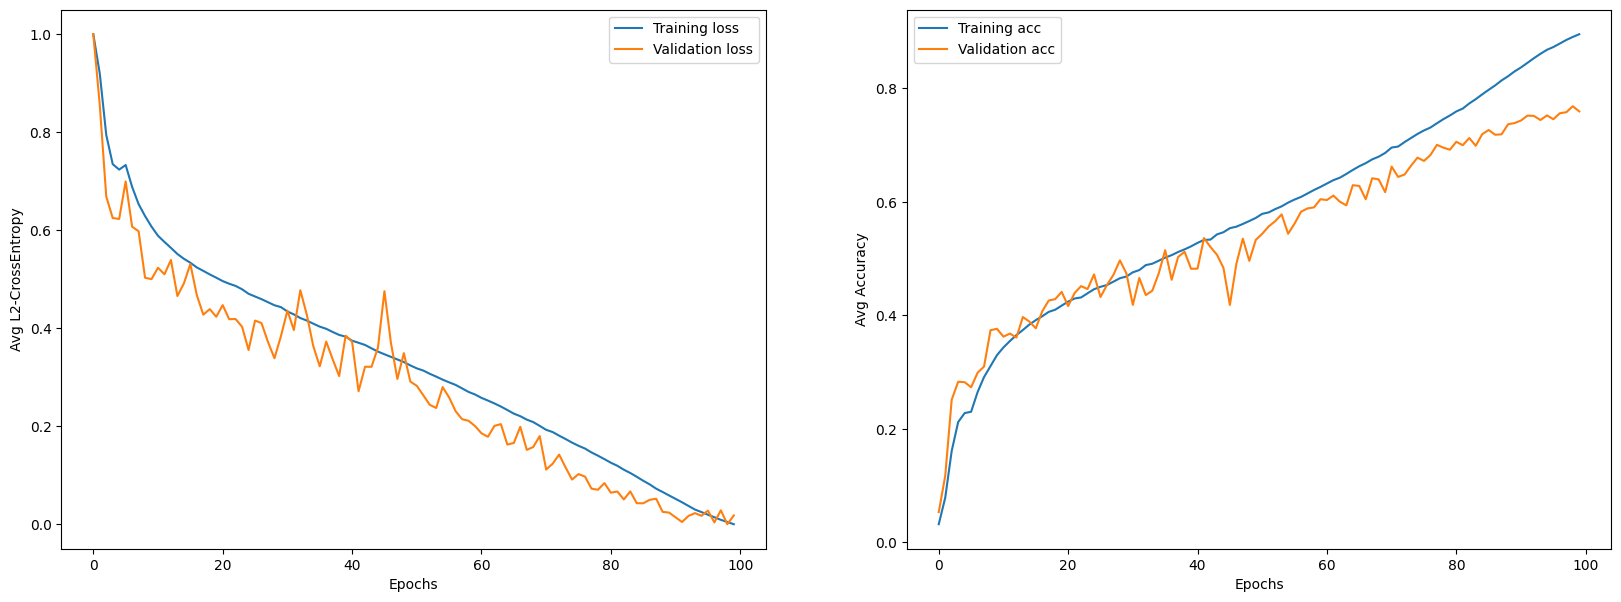

In [18]:
scaled_loss = (res_df['Loss'].to_numpy() - np.min(res_df['Loss'].to_numpy())) / (np.max(res_df['Loss'].to_numpy()) - np.min(res_df['Loss'].to_numpy()))
scaled_val_loss = (res_df['Val_Loss'].to_numpy() - np.min(res_df['Val_Loss'].to_numpy())) / (np.max(res_df['Val_Loss'].to_numpy()) - np.min(res_df['Val_Loss'].to_numpy()))

# Plot results
plt.figure(figsize=[20,7])
plt.subplot(1,2,1)
plt.plot(range(settings['epochs']), scaled_loss, label='Training loss')
plt.plot(range(settings['epochs']), scaled_val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Avg L2-CrossEntropy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(settings['epochs']), res_df['Accuracy'], label='Training acc')
plt.plot(range(settings['epochs']), res_df['Val_Accuracy'], label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Avg Accuracy')
plt.legend();

### 3.1.2 Exporting the model and testing

In [19]:
exported = SuperNet_model.export(verbose=1)

[BEST ALTERNATIVE for features.4.block.2]:
Identity()

[BEST ALTERNATIVE for features.5.block.2]:
DepthwiseSeparableConv(
  (depthwise): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=120)
  (depth_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pointwise): Conv2d(120, 120, kernel_size=(1, 1), stride=(1, 1), groups=2)
  (point_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE for features.6.block.2]:
Identity()

[BEST ALTERNATIVE for features.11.block.2]:
Identity()

[BEST ALTERNATIVE for features.12.block.2]:
ConvBNRelu(
  (conv): Conv2d(672, 672, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24)
  (bn): BatchNorm2d(672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE for features.13.block.2]:
DepthwiseSeparableConv(
  (depthwise): Conv2d(672, 672, kernel_size=(3, 3),

In [20]:
# Look at the model
exported

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [21]:
# Test the exported model
SuperNet_acc = utils.eval_model(
    model=exported,
    device=device,
    data_loader=test_dataloader
)  

  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED - Avg Accuracy: 78.17%


In [22]:
# Save the exported model
utils.save_experiment(root='./experiments', model=exported, seed=SEED, settings=settings, exported=True, metrics_df=res_df)

### 3.1.3 Comparison with baseline

In [23]:
baseline_model = torch.load(f'./main_models/MobileNetV3_seed{SEED}.pt', weights_only=False)
baseline_model 

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [24]:
# Test the basline model
baseline_acc = utils.eval_model(
    model=baseline_model,
    device=device,
    data_loader=test_dataloader
)  

  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED - Avg Accuracy: 80.73%


In [25]:
gap = SuperNet_acc - baseline_acc

print(f'SuperNet accuracy on test data: {(SuperNet_acc*100):.2f}', end=" -> ")
if gap <= 0:
    print(f'{(abs(gap)*100):.2f}% less than baseline')
else:
    print(f'{(abs(gap)*100):.2f}% more than baseline')

SuperNet accuracy on test data: 78.17 -> 2.56% less than baseline


In [26]:
baseline_flops = utils.count_flops(model=baseline_model, dataset=train_dataset)
SuperNet_flops = utils.count_flops(model=exported, dataset=train_dataset)
flops_ratio = 1 - SuperNet_flops / baseline_flops if SuperNet_flops <= baseline_flops else (SuperNet_flops - baseline_flops) / baseline_flops

print(f'#FLOPs SuperNet MBNV3: {SuperNet_flops}', end=" -> ")
if SuperNet_flops <= baseline_flops:
    print(f'{(flops_ratio*100):.2f}% less than baseline')
else:
    print(f'{(flops_ratio*100):.2f}% more than baseline')

#FLOPs SuperNet MBNV3: 326929860 -> 42.04% more than baseline


## 3.2 - Target Weighted FLOPs

In the previous experiment, notice how the resulting model performs ~42% more FLOPs than standard MBNV3 (we have added ~100M FLOPs). This is due to the Squeeze and Excite module being a very efficient module in terms of FLOPs. 

In [10]:
# Baseline model
baseline_model = torch.load(f'./main_models/MobileNetV3_seed{SEED}.pt', weights_only=False)

# Count MBNV3 FLOPs
baseline_flops = utils.count_flops(model=baseline_model, dataset=train_dataset)
print(f'#FLOPs MBNV3: {baseline_flops}\n')

# Count SE modules FLOPs
se_flops = utils.count_submodule_flops(model=baseline_model, sm_name='SqueezeExcitation', dataset=train_dataset)

#FLOPs MBNV3: 230163516

#FLOPs SqueezeExcitation @ features.4.block.2: 116496
#FLOPs SqueezeExcitation @ features.5.block.2: 196056
#FLOPs SqueezeExcitation @ features.6.block.2: 196056
#FLOPs SqueezeExcitation @ features.11.block.2: 304200
#FLOPs SqueezeExcitation @ features.12.block.2: 490392
#FLOPs SqueezeExcitation @ features.13.block.2: 292824
#FLOPs SqueezeExcitation @ features.14.block.2: 556560
#FLOPs SqueezeExcitation @ features.15.block.2: 556560


In [11]:
se_flops_ratio = se_flops / baseline_flops

print(f'Total FLOPs SE modules: {se_flops} -> {(se_flops_ratio*100):.2f}% of MBNV3 FLOPs')

Total FLOPs SE modules: 2709144 -> 1.18% of MBNV3 FLOPs


If we push for an architecture which is going to add "only" ~40M FLOPs, we would get a model which has around 17% FLOPs more than standard MBNV3 

### 3.2.1 - Training

In [12]:
# Settings
settings = {
    'epochs': 100,
    'lr': 0.2,
    'loss': 'L2-CrossEntropy',
    'label_smoothing': 0.1,
    'regularizer': 'TWR',
    'cost': 'flops',
    'target_gamma': 2e-10,
    'target': int(4e7),
    'momentum': 0.9,
    'weight_decay': 2e-5
}

In [13]:
# Load the initialization
SuperNet_model = utils.baseline_SuperNet(exp_seed=SEED, dataset=train_dataset, identity=True, verbose=False)

# Loss function and regularizer
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=settings['label_smoothing'])
regularizer = SuperRegularizer(type_cost=settings['cost'], stable_alpha=0.0, target=settings['target'], target_gamma=settings['target_gamma'])


In [14]:
# Balance gradients
utils.check_gradients(model=SuperNet_model, primar_loss_fn=loss_fn, reg_loss_fn=regularizer, dataset=train_dataset)

Primar Loss ((<class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'utils')):
- Loss:		4.610083103179932
- Gradient:	1.986168622970581
Soft-Constraint Loss (Metric: flops | Target: 40000000):
- Loss:		0.011821568012237549
- Gradient:	0.0019210189348086715


In [15]:
# Optimizer
optimizer = torch.optim.SGD(params=SuperNet_model.parameters(), lr=settings['lr'], momentum=settings['momentum'], weight_decay=settings['weight_decay'])

# Learning rate scheduler 
main_shceduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=settings['epochs'])
warmup = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=0.01, total_iters=5) # Linear warmup
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=optimizer, schedulers=[warmup, main_shceduler], milestones=[5])

In [16]:
# Train the model
loss_h, acc_h, val_loss_h, val_acc_h = utils.train_model(
    model=SuperNet_model,
    device=device,
    data_loader=train_dataloader,
    loss_fn=loss_fn,
    regularizer=regularizer,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    val_dataloader=test_dataloader,
    seed=SEED
)

*********************
EPOCH 0 on cuda - Current learning rate: 0.0020



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.60075 | Avg Accuracy: 1.53%
Computed 1999/8125 batches - Avg Loss: 4.56317 | Avg Accuracy: 1.80%
Computed 2999/8125 batches - Avg Loss: 4.53060 | Avg Accuracy: 2.09%
Computed 3999/8125 batches - Avg Loss: 4.50475 | Avg Accuracy: 2.31%
Computed 4999/8125 batches - Avg Loss: 4.48289 | Avg Accuracy: 2.55%
Computed 5999/8125 batches - Avg Loss: 4.46263 | Avg Accuracy: 2.73%
Computed 6999/8125 batches - Avg Loss: 4.44359 | Avg Accuracy: 2.93%
Computed 7999/8125 batches - Avg Loss: 4.42489 | Avg Accuracy: 3.13%

End of EPOCH 0 - Avg Loss: 4.42204 | Avg Accuracy: 3.17%
Training time: 590.162 seconds.

DNAS parameters:
	- features.4.block.2: [[0.23876826465129852, 0.3232566714286804, 0.2768336534500122, 0.1579015702009201]]
	- features.5.block.2: [[0.2575050890445709, 0.26474156975746155, 0.25125250220298767, 0.223260760307312]]
	- features.6.block.2: [[0.26771876215934753, 0.23990237712860107, 0.2666464149951935, 0.22249242663383484]]
	- features.11.bl

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 4.29%
*********************
EPOCH 1 on cuda - Current learning rate: 0.0416



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.50898 | Avg Accuracy: 3.01%
Computed 1999/8125 batches - Avg Loss: 4.40430 | Avg Accuracy: 3.96%
Computed 2999/8125 batches - Avg Loss: 4.33712 | Avg Accuracy: 4.82%
Computed 3999/8125 batches - Avg Loss: 4.28275 | Avg Accuracy: 5.67%
Computed 4999/8125 batches - Avg Loss: 4.23251 | Avg Accuracy: 6.48%
Computed 5999/8125 batches - Avg Loss: 4.19027 | Avg Accuracy: 7.17%
Computed 6999/8125 batches - Avg Loss: 4.15175 | Avg Accuracy: 7.88%
Computed 7999/8125 batches - Avg Loss: 4.11584 | Avg Accuracy: 8.64%

End of EPOCH 1 - Avg Loss: 4.11081 | Avg Accuracy: 8.73%
Training time: 590.386 seconds.

DNAS parameters:
	- features.4.block.2: [[1.4280966520309448, 0.6961778998374939, -0.032558608800172806, -1.1601142883300781]]
	- features.5.block.2: [[0.9777011871337891, 0.39773988723754883, -0.37385591864585876, -0.0699847936630249]]
	- features.6.block.2: [[0.5932261347770691, 0.4610636234283447, 0.16373610496520996, -0.2864261269569397]]
	- features.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 16.23%
*********************
EPOCH 2 on cuda - Current learning rate: 0.0812



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.93481 | Avg Accuracy: 11.67%
Computed 1999/8125 batches - Avg Loss: 3.89625 | Avg Accuracy: 12.65%
Computed 2999/8125 batches - Avg Loss: 3.86406 | Avg Accuracy: 13.52%
Computed 3999/8125 batches - Avg Loss: 3.83392 | Avg Accuracy: 14.28%
Computed 4999/8125 batches - Avg Loss: 3.80297 | Avg Accuracy: 14.97%
Computed 5999/8125 batches - Avg Loss: 3.77439 | Avg Accuracy: 15.57%
Computed 6999/8125 batches - Avg Loss: 3.74679 | Avg Accuracy: 16.22%
Computed 7999/8125 batches - Avg Loss: 3.72038 | Avg Accuracy: 16.86%

End of EPOCH 2 - Avg Loss: 3.71760 | Avg Accuracy: 16.92%
Training time: 589.514 seconds.

DNAS parameters:
	- features.4.block.2: [[4.439516544342041, 0.10919446498155594, -1.5064529180526733, -2.2258269786834717]]
	- features.5.block.2: [[1.5005258321762085, -0.08320914208889008, -0.6706066727638245, 0.06972024589776993]]
	- features.6.block.2: [[0.909540593624115, 0.16394813358783722, 0.27586430311203003, -0.5329311490058899]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 23.62%
*********************
EPOCH 3 on cuda - Current learning rate: 0.1208



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.66453 | Avg Accuracy: 18.46%
Computed 1999/8125 batches - Avg Loss: 3.63978 | Avg Accuracy: 19.18%
Computed 2999/8125 batches - Avg Loss: 3.62033 | Avg Accuracy: 19.54%
Computed 3999/8125 batches - Avg Loss: 3.60188 | Avg Accuracy: 20.01%
Computed 4999/8125 batches - Avg Loss: 3.58413 | Avg Accuracy: 20.38%
Computed 5999/8125 batches - Avg Loss: 3.56762 | Avg Accuracy: 20.80%
Computed 6999/8125 batches - Avg Loss: 3.55204 | Avg Accuracy: 21.18%
Computed 7999/8125 batches - Avg Loss: 3.53874 | Avg Accuracy: 21.46%

End of EPOCH 3 - Avg Loss: 3.53611 | Avg Accuracy: 21.52%
Training time: 589.707 seconds.

DNAS parameters:
	- features.4.block.2: [[5.452234745025635, -0.7767254114151001, -1.7812532186508179, -2.2233517169952393]]
	- features.5.block.2: [[1.9427763223648071, -0.07672131061553955, -1.1759511232376099, -0.019218502566218376]]
	- features.6.block.2: [[0.8766069412231445, 0.2301701307296753, 0.4375801682472229, -0.8734809160232544]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 24.70%
*********************
EPOCH 4 on cuda - Current learning rate: 0.1604



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.57984 | Avg Accuracy: 21.72%
Computed 1999/8125 batches - Avg Loss: 3.56870 | Avg Accuracy: 21.77%
Computed 2999/8125 batches - Avg Loss: 3.55655 | Avg Accuracy: 21.90%
Computed 3999/8125 batches - Avg Loss: 3.54701 | Avg Accuracy: 22.15%
Computed 4999/8125 batches - Avg Loss: 3.52949 | Avg Accuracy: 22.56%
Computed 5999/8125 batches - Avg Loss: 3.51756 | Avg Accuracy: 22.88%
Computed 6999/8125 batches - Avg Loss: 3.50237 | Avg Accuracy: 23.26%
Computed 7999/8125 batches - Avg Loss: 3.49136 | Avg Accuracy: 23.50%

End of EPOCH 4 - Avg Loss: 3.48890 | Avg Accuracy: 23.54%
Training time: 589.914 seconds.

DNAS parameters:
	- features.4.block.2: [[5.77835750579834, -1.103988528251648, -2.1457815170288086, -2.011662721633911]]
	- features.5.block.2: [[2.176453113555908, 0.01237406674772501, -1.5492291450500488, -0.12268479913473129]]
	- features.6.block.2: [[1.3353933095932007, -0.36536699533462524, 0.564010739326477, -1.0171318054199219]]
	- featur

/home/tiziano-tezze/ProgramFiles/miniconda3/envs/cv-project/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 29.65%
*********************
EPOCH 5 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.55053 | Avg Accuracy: 23.10%
Computed 1999/8125 batches - Avg Loss: 3.55970 | Avg Accuracy: 22.77%
Computed 2999/8125 batches - Avg Loss: 3.55676 | Avg Accuracy: 22.88%
Computed 3999/8125 batches - Avg Loss: 3.54886 | Avg Accuracy: 22.99%
Computed 4999/8125 batches - Avg Loss: 3.54760 | Avg Accuracy: 23.06%
Computed 5999/8125 batches - Avg Loss: 3.54176 | Avg Accuracy: 23.17%
Computed 6999/8125 batches - Avg Loss: 3.53454 | Avg Accuracy: 23.29%
Computed 7999/8125 batches - Avg Loss: 3.52554 | Avg Accuracy: 23.52%

End of EPOCH 5 - Avg Loss: 3.52468 | Avg Accuracy: 23.51%
Training time: 589.515 seconds.

DNAS parameters:
	- features.4.block.2: [[5.954566955566406, -1.542972207069397, -2.1285147666931152, -1.909624695777893]]
	- features.5.block.2: [[3.059025764465332, -0.5838091373443604, -1.4291784763336182, -0.6725980043411255]]
	- features.6.block.2: [[1.4704018831253052, -0.39094099402427673, 0.8436151146888733, -1.5496450662612915]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 24.78%
*********************
EPOCH 6 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.42529 | Avg Accuracy: 25.67%
Computed 1999/8125 batches - Avg Loss: 3.41692 | Avg Accuracy: 25.96%
Computed 2999/8125 batches - Avg Loss: 3.42624 | Avg Accuracy: 25.78%
Computed 3999/8125 batches - Avg Loss: 3.41476 | Avg Accuracy: 26.14%
Computed 4999/8125 batches - Avg Loss: 3.40880 | Avg Accuracy: 26.24%
Computed 5999/8125 batches - Avg Loss: 3.39880 | Avg Accuracy: 26.47%
Computed 6999/8125 batches - Avg Loss: 3.39168 | Avg Accuracy: 26.62%
Computed 7999/8125 batches - Avg Loss: 3.38446 | Avg Accuracy: 26.80%

End of EPOCH 6 - Avg Loss: 3.38269 | Avg Accuracy: 26.81%
Training time: 589.286 seconds.

DNAS parameters:
	- features.4.block.2: [[5.9139533042907715, -1.1892950534820557, -1.7845357656478882, -2.6702990531921387]]
	- features.5.block.2: [[3.50179123878479, -1.0034658908843994, -1.1745904684066772, -1.0539264678955078]]
	- features.6.block.2: [[1.301962971687317, -0.47857996821403503, 0.8432109355926514, -1.3967883586883545]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 29.87%
*********************
EPOCH 7 on cuda - Current learning rate: 0.1998



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.31491 | Avg Accuracy: 28.50%
Computed 1999/8125 batches - Avg Loss: 3.30060 | Avg Accuracy: 28.86%
Computed 2999/8125 batches - Avg Loss: 3.29523 | Avg Accuracy: 28.99%
Computed 3999/8125 batches - Avg Loss: 3.29337 | Avg Accuracy: 28.98%
Computed 4999/8125 batches - Avg Loss: 3.28993 | Avg Accuracy: 29.00%
Computed 5999/8125 batches - Avg Loss: 3.28821 | Avg Accuracy: 29.04%
Computed 6999/8125 batches - Avg Loss: 3.28113 | Avg Accuracy: 29.21%
Computed 7999/8125 batches - Avg Loss: 3.27472 | Avg Accuracy: 29.42%

End of EPOCH 7 - Avg Loss: 3.27419 | Avg Accuracy: 29.43%
Training time: 588.984 seconds.

DNAS parameters:
	- features.4.block.2: [[5.611779689788818, -1.1455379724502563, -2.257495641708374, -2.013735055923462]]
	- features.5.block.2: [[3.901736259460449, -0.9192212224006653, -1.5743346214294434, -1.2131885290145874]]
	- features.6.block.2: [[2.1331615447998047, -0.7274546027183533, 1.061659812927246, -2.2723748683929443]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 32.19%
*********************
EPOCH 8 on cuda - Current learning rate: 0.1996



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.20597 | Avg Accuracy: 31.14%
Computed 1999/8125 batches - Avg Loss: 3.19647 | Avg Accuracy: 31.22%
Computed 2999/8125 batches - Avg Loss: 3.19676 | Avg Accuracy: 31.29%
Computed 3999/8125 batches - Avg Loss: 3.18583 | Avg Accuracy: 31.71%
Computed 4999/8125 batches - Avg Loss: 3.18455 | Avg Accuracy: 31.65%
Computed 5999/8125 batches - Avg Loss: 3.18604 | Avg Accuracy: 31.54%
Computed 6999/8125 batches - Avg Loss: 3.18397 | Avg Accuracy: 31.49%
Computed 7999/8125 batches - Avg Loss: 3.18133 | Avg Accuracy: 31.56%

End of EPOCH 8 - Avg Loss: 3.17968 | Avg Accuracy: 31.58%
Training time: 590.002 seconds.

DNAS parameters:
	- features.4.block.2: [[5.848268032073975, -1.4625078439712524, -2.312119960784912, -1.932664155960083]]
	- features.5.block.2: [[3.83540940284729, -0.8751758337020874, -1.6273164749145508, -1.1919435262680054]]
	- features.6.block.2: [[2.3253188133239746, -0.8002564311027527, 0.954009473323822, -2.338104486465454]]
	- features.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 36.38%
*********************
EPOCH 9 on cuda - Current learning rate: 0.1992



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.12765 | Avg Accuracy: 32.87%
Computed 1999/8125 batches - Avg Loss: 3.12976 | Avg Accuracy: 32.83%
Computed 2999/8125 batches - Avg Loss: 3.12756 | Avg Accuracy: 32.84%
Computed 3999/8125 batches - Avg Loss: 3.12011 | Avg Accuracy: 33.04%
Computed 4999/8125 batches - Avg Loss: 3.11597 | Avg Accuracy: 33.10%
Computed 5999/8125 batches - Avg Loss: 3.11652 | Avg Accuracy: 33.16%
Computed 6999/8125 batches - Avg Loss: 3.11383 | Avg Accuracy: 33.26%
Computed 7999/8125 batches - Avg Loss: 3.11180 | Avg Accuracy: 33.37%

End of EPOCH 9 - Avg Loss: 3.11133 | Avg Accuracy: 33.37%
Training time: 589.536 seconds.

DNAS parameters:
	- features.4.block.2: [[5.929172515869141, -1.8115912675857544, -2.218921661376953, -1.7966597080230713]]
	- features.5.block.2: [[4.1081953048706055, -1.1277472972869873, -1.343019962310791, -1.5354554653167725]]
	- features.6.block.2: [[3.0264711380004883, -1.009596586227417, 0.31146228313446045, -2.2263665199279785]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 36.26%
*********************
EPOCH 10 on cuda - Current learning rate: 0.1988



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.06571 | Avg Accuracy: 34.30%
Computed 1999/8125 batches - Avg Loss: 3.07583 | Avg Accuracy: 34.08%
Computed 2999/8125 batches - Avg Loss: 3.06958 | Avg Accuracy: 34.10%
Computed 3999/8125 batches - Avg Loss: 3.06084 | Avg Accuracy: 34.29%
Computed 4999/8125 batches - Avg Loss: 3.05732 | Avg Accuracy: 34.40%
Computed 5999/8125 batches - Avg Loss: 3.05438 | Avg Accuracy: 34.54%
Computed 6999/8125 batches - Avg Loss: 3.05167 | Avg Accuracy: 34.65%
Computed 7999/8125 batches - Avg Loss: 3.04905 | Avg Accuracy: 34.73%

End of EPOCH 10 - Avg Loss: 3.04898 | Avg Accuracy: 34.72%
Training time: 589.101 seconds.

DNAS parameters:
	- features.4.block.2: [[5.231550693511963, -1.5767921209335327, -2.0262253284454346, -1.5546905994415283]]
	- features.5.block.2: [[4.267277717590332, -1.3095699548721313, -1.4762113094329834, -1.407673954963684]]
	- features.6.block.2: [[2.9557559490203857, -1.3658846616744995, 0.2873225808143616, -1.803382396697998]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 36.00%
*********************
EPOCH 11 on cuda - Current learning rate: 0.1982



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.01731 | Avg Accuracy: 35.70%
Computed 1999/8125 batches - Avg Loss: 3.01742 | Avg Accuracy: 35.68%
Computed 2999/8125 batches - Avg Loss: 3.01366 | Avg Accuracy: 35.70%
Computed 3999/8125 batches - Avg Loss: 3.01522 | Avg Accuracy: 35.78%
Computed 4999/8125 batches - Avg Loss: 3.01326 | Avg Accuracy: 35.81%
Computed 5999/8125 batches - Avg Loss: 3.01266 | Avg Accuracy: 35.89%
Computed 6999/8125 batches - Avg Loss: 3.00910 | Avg Accuracy: 36.01%
Computed 7999/8125 batches - Avg Loss: 3.00730 | Avg Accuracy: 35.99%

End of EPOCH 11 - Avg Loss: 3.00759 | Avg Accuracy: 35.97%
Training time: 589.720 seconds.

DNAS parameters:
	- features.4.block.2: [[7.276691436767578, -1.454347848892212, -3.4199094772338867, -2.3489153385162354]]
	- features.5.block.2: [[4.212225437164307, -1.5562044382095337, -1.2496322393417358, -1.3529049158096313]]
	- features.6.block.2: [[3.0676724910736084, -1.1461584568023682, -0.133816659450531, -1.7342212200164795]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 35.94%
*********************
EPOCH 12 on cuda - Current learning rate: 0.1976



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.97672 | Avg Accuracy: 37.08%
Computed 1999/8125 batches - Avg Loss: 2.96423 | Avg Accuracy: 37.13%
Computed 2999/8125 batches - Avg Loss: 2.95804 | Avg Accuracy: 37.19%
Computed 3999/8125 batches - Avg Loss: 2.95659 | Avg Accuracy: 37.25%
Computed 4999/8125 batches - Avg Loss: 2.95765 | Avg Accuracy: 37.18%
Computed 5999/8125 batches - Avg Loss: 2.95864 | Avg Accuracy: 37.12%
Computed 6999/8125 batches - Avg Loss: 2.96035 | Avg Accuracy: 37.03%
Computed 7999/8125 batches - Avg Loss: 2.95911 | Avg Accuracy: 37.05%

End of EPOCH 12 - Avg Loss: 2.95834 | Avg Accuracy: 37.05%
Training time: 589.855 seconds.

DNAS parameters:
	- features.4.block.2: [[6.7536749839782715, -1.1706087589263916, -3.7991130352020264, -1.7451170682907104]]
	- features.5.block.2: [[4.337172985076904, -1.4221504926681519, -1.4405810832977295, -1.435650110244751]]
	- features.6.block.2: [[3.499987840652466, -1.589462399482727, -0.3474520146846771, -1.524284839630127]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 38.04%
*********************
EPOCH 13 on cuda - Current learning rate: 0.1969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.92620 | Avg Accuracy: 37.67%
Computed 1999/8125 batches - Avg Loss: 2.93359 | Avg Accuracy: 37.54%
Computed 2999/8125 batches - Avg Loss: 2.93709 | Avg Accuracy: 37.64%
Computed 3999/8125 batches - Avg Loss: 2.93616 | Avg Accuracy: 37.69%
Computed 4999/8125 batches - Avg Loss: 2.92993 | Avg Accuracy: 37.83%
Computed 5999/8125 batches - Avg Loss: 2.92604 | Avg Accuracy: 37.94%
Computed 6999/8125 batches - Avg Loss: 2.92248 | Avg Accuracy: 38.06%
Computed 7999/8125 batches - Avg Loss: 2.92366 | Avg Accuracy: 38.03%

End of EPOCH 13 - Avg Loss: 2.92326 | Avg Accuracy: 38.04%
Training time: 589.239 seconds.

DNAS parameters:
	- features.4.block.2: [[5.265305519104004, -1.0412888526916504, -2.9499130249023438, -1.2458983659744263]]
	- features.5.block.2: [[4.206981658935547, -1.453277587890625, -1.368225336074829, -1.3572969436645508]]
	- features.6.block.2: [[3.503575325012207, -1.3183507919311523, -0.6790271997451782, -1.4780235290527344]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 38.46%
*********************
EPOCH 14 on cuda - Current learning rate: 0.1960



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.88900 | Avg Accuracy: 38.95%
Computed 1999/8125 batches - Avg Loss: 2.89031 | Avg Accuracy: 38.91%
Computed 2999/8125 batches - Avg Loss: 2.89424 | Avg Accuracy: 38.74%
Computed 3999/8125 batches - Avg Loss: 2.89439 | Avg Accuracy: 38.78%
Computed 4999/8125 batches - Avg Loss: 2.89637 | Avg Accuracy: 38.73%
Computed 5999/8125 batches - Avg Loss: 2.89544 | Avg Accuracy: 38.76%
Computed 6999/8125 batches - Avg Loss: 2.89196 | Avg Accuracy: 38.86%
Computed 7999/8125 batches - Avg Loss: 2.89137 | Avg Accuracy: 38.86%

End of EPOCH 14 - Avg Loss: 2.88999 | Avg Accuracy: 38.87%
Training time: 588.285 seconds.

DNAS parameters:
	- features.4.block.2: [[4.980045795440674, -1.0714572668075562, -2.2460224628448486, -1.6420340538024902]]
	- features.5.block.2: [[4.183136463165283, -1.5711671113967896, -1.128717303276062, -1.4627641439437866]]
	- features.6.block.2: [[3.64019513130188, -1.4436630010604858, -0.7762038111686707, -1.3998496532440186]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 40.00%
*********************
EPOCH 15 on cuda - Current learning rate: 0.1951



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.86309 | Avg Accuracy: 39.73%
Computed 1999/8125 batches - Avg Loss: 2.86477 | Avg Accuracy: 39.61%
Computed 2999/8125 batches - Avg Loss: 2.85643 | Avg Accuracy: 39.78%
Computed 3999/8125 batches - Avg Loss: 2.86103 | Avg Accuracy: 39.68%
Computed 4999/8125 batches - Avg Loss: 2.86029 | Avg Accuracy: 39.68%
Computed 5999/8125 batches - Avg Loss: 2.86119 | Avg Accuracy: 39.72%
Computed 6999/8125 batches - Avg Loss: 2.85906 | Avg Accuracy: 39.77%
Computed 7999/8125 batches - Avg Loss: 2.85905 | Avg Accuracy: 39.75%

End of EPOCH 15 - Avg Loss: 2.85924 | Avg Accuracy: 39.74%
Training time: 589.404 seconds.

DNAS parameters:
	- features.4.block.2: [[6.3466644287109375, -1.2773858308792114, -1.6566373109817505, -3.397679328918457]]
	- features.5.block.2: [[4.249406337738037, -1.5684293508529663, -1.207193374633789, -1.4588686227798462]]
	- features.6.block.2: [[3.564561128616333, -1.160548448562622, -1.046935796737671, -1.342157006263733]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 40.34%
*********************
EPOCH 16 on cuda - Current learning rate: 0.1941



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.85591 | Avg Accuracy: 39.72%
Computed 1999/8125 batches - Avg Loss: 2.84530 | Avg Accuracy: 40.06%
Computed 2999/8125 batches - Avg Loss: 2.84166 | Avg Accuracy: 40.02%
Computed 3999/8125 batches - Avg Loss: 2.84119 | Avg Accuracy: 40.09%
Computed 4999/8125 batches - Avg Loss: 2.83451 | Avg Accuracy: 40.26%
Computed 5999/8125 batches - Avg Loss: 2.83572 | Avg Accuracy: 40.24%
Computed 6999/8125 batches - Avg Loss: 2.83339 | Avg Accuracy: 40.31%
Computed 7999/8125 batches - Avg Loss: 2.83399 | Avg Accuracy: 40.31%

End of EPOCH 16 - Avg Loss: 2.83352 | Avg Accuracy: 40.30%
Training time: 589.119 seconds.

DNAS parameters:
	- features.4.block.2: [[6.560441970825195, -1.0294826030731201, -3.038320302963257, -2.4817373752593994]]
	- features.5.block.2: [[3.7508084774017334, -1.2784026861190796, -1.154541015625, -1.3070067167282104]]
	- features.6.block.2: [[3.4598331451416016, -1.0425053834915161, -1.1334457397460938, -1.2729860544204712]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 40.89%
*********************
EPOCH 17 on cuda - Current learning rate: 0.1930



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.78926 | Avg Accuracy: 41.23%
Computed 1999/8125 batches - Avg Loss: 2.79856 | Avg Accuracy: 41.38%
Computed 2999/8125 batches - Avg Loss: 2.80099 | Avg Accuracy: 41.29%
Computed 3999/8125 batches - Avg Loss: 2.80241 | Avg Accuracy: 41.33%
Computed 4999/8125 batches - Avg Loss: 2.80162 | Avg Accuracy: 41.27%
Computed 5999/8125 batches - Avg Loss: 2.80338 | Avg Accuracy: 41.23%
Computed 6999/8125 batches - Avg Loss: 2.80449 | Avg Accuracy: 41.18%
Computed 7999/8125 batches - Avg Loss: 2.80264 | Avg Accuracy: 41.20%

End of EPOCH 17 - Avg Loss: 2.80245 | Avg Accuracy: 41.19%
Training time: 589.650 seconds.

DNAS parameters:
	- features.4.block.2: [[7.039860725402832, -0.9965439438819885, -4.225094795227051, -1.8102407455444336]]
	- features.5.block.2: [[4.002253532409668, -1.5197968482971191, -1.060563325881958, -1.4139573574066162]]
	- features.6.block.2: [[3.4675939083099365, -1.1066728830337524, -1.1663578748703003, -1.186601161956787]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 41.35%
*********************
EPOCH 18 on cuda - Current learning rate: 0.1918



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.75890 | Avg Accuracy: 42.73%
Computed 1999/8125 batches - Avg Loss: 2.76099 | Avg Accuracy: 42.53%
Computed 2999/8125 batches - Avg Loss: 2.76174 | Avg Accuracy: 42.47%
Computed 3999/8125 batches - Avg Loss: 2.76927 | Avg Accuracy: 42.25%
Computed 4999/8125 batches - Avg Loss: 2.76935 | Avg Accuracy: 42.21%
Computed 5999/8125 batches - Avg Loss: 2.76720 | Avg Accuracy: 42.16%
Computed 6999/8125 batches - Avg Loss: 2.77086 | Avg Accuracy: 42.00%
Computed 7999/8125 batches - Avg Loss: 2.77158 | Avg Accuracy: 42.05%

End of EPOCH 18 - Avg Loss: 2.77110 | Avg Accuracy: 42.03%
Training time: 589.738 seconds.

DNAS parameters:
	- features.4.block.2: [[5.615155220031738, -0.7841584086418152, -3.137763261795044, -1.6873986721038818]]
	- features.5.block.2: [[3.956352710723877, -1.3877108097076416, -1.2115942239761353, -1.3512351512908936]]
	- features.6.block.2: [[3.4635465145111084, -1.117260217666626, -1.2866538763046265, -1.0537972450256348]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.31%
*********************
EPOCH 19 on cuda - Current learning rate: 0.1905



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.73770 | Avg Accuracy: 42.44%
Computed 1999/8125 batches - Avg Loss: 2.75122 | Avg Accuracy: 42.14%
Computed 2999/8125 batches - Avg Loss: 2.74414 | Avg Accuracy: 42.50%
Computed 3999/8125 batches - Avg Loss: 2.74791 | Avg Accuracy: 42.41%
Computed 4999/8125 batches - Avg Loss: 2.74818 | Avg Accuracy: 42.42%
Computed 5999/8125 batches - Avg Loss: 2.75385 | Avg Accuracy: 42.35%
Computed 6999/8125 batches - Avg Loss: 2.75377 | Avg Accuracy: 42.36%
Computed 7999/8125 batches - Avg Loss: 2.75192 | Avg Accuracy: 42.41%

End of EPOCH 19 - Avg Loss: 2.75087 | Avg Accuracy: 42.41%
Training time: 589.687 seconds.

DNAS parameters:
	- features.4.block.2: [[5.461189270019531, -0.7107633948326111, -2.263878107070923, -2.482264518737793]]
	- features.5.block.2: [[3.786245822906494, -1.4401755332946777, -1.0533931255340576, -1.288413643836975]]
	- features.6.block.2: [[3.4263110160827637, -1.055649995803833, -1.3669735193252563, -0.9993898868560791]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.69%
*********************
EPOCH 20 on cuda - Current learning rate: 0.1891



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.71633 | Avg Accuracy: 43.19%
Computed 1999/8125 batches - Avg Loss: 2.72548 | Avg Accuracy: 42.92%
Computed 2999/8125 batches - Avg Loss: 2.72401 | Avg Accuracy: 43.19%
Computed 3999/8125 batches - Avg Loss: 2.72453 | Avg Accuracy: 43.36%
Computed 4999/8125 batches - Avg Loss: 2.72365 | Avg Accuracy: 43.33%
Computed 5999/8125 batches - Avg Loss: 2.72616 | Avg Accuracy: 43.22%
Computed 6999/8125 batches - Avg Loss: 2.72610 | Avg Accuracy: 43.23%
Computed 7999/8125 batches - Avg Loss: 2.72406 | Avg Accuracy: 43.29%

End of EPOCH 20 - Avg Loss: 2.72341 | Avg Accuracy: 43.27%
Training time: 589.948 seconds.

DNAS parameters:
	- features.4.block.2: [[4.808884143829346, -1.1003763675689697, -1.759276032447815, -1.9460749626159668]]
	- features.5.block.2: [[3.458603858947754, -1.229293942451477, -0.9086074829101562, -1.317569613456726]]
	- features.6.block.2: [[3.1886966228485107, -1.0134416818618774, -1.19198739528656, -0.9801173210144043]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.59%
*********************
EPOCH 21 on cuda - Current learning rate: 0.1876



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.70088 | Avg Accuracy: 43.78%
Computed 1999/8125 batches - Avg Loss: 2.69515 | Avg Accuracy: 43.97%
Computed 2999/8125 batches - Avg Loss: 2.69283 | Avg Accuracy: 44.03%
Computed 3999/8125 batches - Avg Loss: 2.69726 | Avg Accuracy: 43.98%
Computed 4999/8125 batches - Avg Loss: 2.69488 | Avg Accuracy: 43.98%
Computed 5999/8125 batches - Avg Loss: 2.69820 | Avg Accuracy: 43.84%
Computed 6999/8125 batches - Avg Loss: 2.69825 | Avg Accuracy: 43.88%
Computed 7999/8125 batches - Avg Loss: 2.69931 | Avg Accuracy: 43.90%

End of EPOCH 21 - Avg Loss: 2.69959 | Avg Accuracy: 43.89%
Training time: 589.716 seconds.

DNAS parameters:
	- features.4.block.2: [[5.878281116485596, -0.8861483335494995, -1.9655569791793823, -3.024250030517578]]
	- features.5.block.2: [[3.7702713012695312, -1.454052209854126, -1.2942010164260864, -1.0197181701660156]]
	- features.6.block.2: [[3.1974644660949707, -1.2236307859420776, -1.0264452695846558, -0.9450687170028687]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 45.25%
*********************
EPOCH 22 on cuda - Current learning rate: 0.1861



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.68996 | Avg Accuracy: 44.03%
Computed 1999/8125 batches - Avg Loss: 2.68663 | Avg Accuracy: 43.90%
Computed 2999/8125 batches - Avg Loss: 2.69118 | Avg Accuracy: 43.81%
Computed 3999/8125 batches - Avg Loss: 2.69148 | Avg Accuracy: 43.77%
Computed 4999/8125 batches - Avg Loss: 2.69037 | Avg Accuracy: 43.88%
Computed 5999/8125 batches - Avg Loss: 2.68979 | Avg Accuracy: 43.96%
Computed 6999/8125 batches - Avg Loss: 2.68775 | Avg Accuracy: 44.04%
Computed 7999/8125 batches - Avg Loss: 2.68715 | Avg Accuracy: 44.08%

End of EPOCH 22 - Avg Loss: 2.68678 | Avg Accuracy: 44.07%
Training time: 588.866 seconds.

DNAS parameters:
	- features.4.block.2: [[6.405378818511963, -0.6568208336830139, -3.5017032623291016, -2.2451562881469727]]
	- features.5.block.2: [[3.3390655517578125, -1.3362929821014404, -1.0626782178878784, -0.9383832216262817]]
	- features.6.block.2: [[3.038735866546631, -1.2409611940383911, -0.8562657833099365, -0.9397974610328674]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.45%
*********************
EPOCH 23 on cuda - Current learning rate: 0.1844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.63996 | Avg Accuracy: 45.41%
Computed 1999/8125 batches - Avg Loss: 2.64807 | Avg Accuracy: 45.46%
Computed 2999/8125 batches - Avg Loss: 2.64849 | Avg Accuracy: 45.39%
Computed 3999/8125 batches - Avg Loss: 2.65577 | Avg Accuracy: 45.23%
Computed 4999/8125 batches - Avg Loss: 2.65898 | Avg Accuracy: 45.11%
Computed 5999/8125 batches - Avg Loss: 2.66144 | Avg Accuracy: 45.07%
Computed 6999/8125 batches - Avg Loss: 2.66361 | Avg Accuracy: 44.93%
Computed 7999/8125 batches - Avg Loss: 2.66282 | Avg Accuracy: 44.97%

End of EPOCH 23 - Avg Loss: 2.66187 | Avg Accuracy: 44.96%
Training time: 587.042 seconds.

DNAS parameters:
	- features.4.block.2: [[6.401754379272461, -1.837293028831482, -2.647568464279175, -1.915635585784912]]
	- features.5.block.2: [[3.1953060626983643, -1.1171622276306152, -1.1191133260726929, -0.9577667117118835]]
	- features.6.block.2: [[2.830502510070801, -1.0329355001449585, -0.8769886493682861, -0.9193116426467896]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 45.33%
*********************
EPOCH 24 on cuda - Current learning rate: 0.1827



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.61278 | Avg Accuracy: 46.05%
Computed 1999/8125 batches - Avg Loss: 2.61843 | Avg Accuracy: 45.89%
Computed 2999/8125 batches - Avg Loss: 2.62449 | Avg Accuracy: 45.75%
Computed 3999/8125 batches - Avg Loss: 2.63151 | Avg Accuracy: 45.59%
Computed 4999/8125 batches - Avg Loss: 2.63625 | Avg Accuracy: 45.45%
Computed 5999/8125 batches - Avg Loss: 2.63791 | Avg Accuracy: 45.49%
Computed 6999/8125 batches - Avg Loss: 2.63567 | Avg Accuracy: 45.58%
Computed 7999/8125 batches - Avg Loss: 2.63684 | Avg Accuracy: 45.53%

End of EPOCH 24 - Avg Loss: 2.63610 | Avg Accuracy: 45.52%
Training time: 589.494 seconds.

DNAS parameters:
	- features.4.block.2: [[5.394834518432617, -1.643680214881897, -2.0339627265930176, -1.7162481546401978]]
	- features.5.block.2: [[3.4037084579467773, -1.054357647895813, -1.1731499433517456, -1.1752666234970093]]
	- features.6.block.2: [[2.7412140369415283, -1.0173877477645874, -0.8079309463500977, -0.9149559736251831]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.47%
*********************
EPOCH 25 on cuda - Current learning rate: 0.1809



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.59422 | Avg Accuracy: 46.25%
Computed 1999/8125 batches - Avg Loss: 2.59774 | Avg Accuracy: 46.45%
Computed 2999/8125 batches - Avg Loss: 2.60690 | Avg Accuracy: 46.24%
Computed 3999/8125 batches - Avg Loss: 2.61301 | Avg Accuracy: 46.00%
Computed 4999/8125 batches - Avg Loss: 2.61281 | Avg Accuracy: 45.95%
Computed 5999/8125 batches - Avg Loss: 2.61327 | Avg Accuracy: 45.91%
Computed 6999/8125 batches - Avg Loss: 2.61509 | Avg Accuracy: 45.83%
Computed 7999/8125 batches - Avg Loss: 2.61745 | Avg Accuracy: 45.75%

End of EPOCH 25 - Avg Loss: 2.61775 | Avg Accuracy: 45.72%
Training time: 589.849 seconds.

DNAS parameters:
	- features.4.block.2: [[4.836413860321045, -1.5898526906967163, -1.618592619895935, -1.6272518634796143]]
	- features.5.block.2: [[3.2556159496307373, -0.898711621761322, -1.1948179006576538, -1.1613911390304565]]
	- features.6.block.2: [[2.5855815410614014, -0.9383624196052551, -0.7735983729362488, -0.8729313611984253]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.46%
*********************
EPOCH 26 on cuda - Current learning rate: 0.1790



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.58371 | Avg Accuracy: 47.17%
Computed 1999/8125 batches - Avg Loss: 2.57445 | Avg Accuracy: 47.24%
Computed 2999/8125 batches - Avg Loss: 2.58188 | Avg Accuracy: 46.98%
Computed 3999/8125 batches - Avg Loss: 2.59222 | Avg Accuracy: 46.52%
Computed 4999/8125 batches - Avg Loss: 2.59250 | Avg Accuracy: 46.59%
Computed 5999/8125 batches - Avg Loss: 2.59591 | Avg Accuracy: 46.48%
Computed 6999/8125 batches - Avg Loss: 2.59717 | Avg Accuracy: 46.45%
Computed 7999/8125 batches - Avg Loss: 2.59998 | Avg Accuracy: 46.39%

End of EPOCH 26 - Avg Loss: 2.59901 | Avg Accuracy: 46.40%
Training time: 589.296 seconds.

DNAS parameters:
	- features.4.block.2: [[4.623630523681641, -1.2202913761138916, -2.152890682220459, -1.249902367591858]]
	- features.5.block.2: [[3.1974077224731445, -0.9390630722045898, -1.0770988464355469, -1.1807245016098022]]
	- features.6.block.2: [[2.669894218444824, -0.9017847180366516, -0.9197158217430115, -0.8478797078132629]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.28%
*********************
EPOCH 27 on cuda - Current learning rate: 0.1771



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.57669 | Avg Accuracy: 47.03%
Computed 1999/8125 batches - Avg Loss: 2.57901 | Avg Accuracy: 47.04%
Computed 2999/8125 batches - Avg Loss: 2.58222 | Avg Accuracy: 46.92%
Computed 3999/8125 batches - Avg Loss: 2.57996 | Avg Accuracy: 46.94%
Computed 4999/8125 batches - Avg Loss: 2.58070 | Avg Accuracy: 46.88%
Computed 5999/8125 batches - Avg Loss: 2.58347 | Avg Accuracy: 46.82%
Computed 6999/8125 batches - Avg Loss: 2.58427 | Avg Accuracy: 46.76%
Computed 7999/8125 batches - Avg Loss: 2.58410 | Avg Accuracy: 46.81%

End of EPOCH 27 - Avg Loss: 2.58408 | Avg Accuracy: 46.80%
Training time: 586.017 seconds.

DNAS parameters:
	- features.4.block.2: [[4.199476718902588, -1.552943468093872, -1.5741544961929321, -1.0719753503799438]]
	- features.5.block.2: [[3.119483232498169, -1.0022865533828735, -1.0769401788711548, -1.0398670434951782]]
	- features.6.block.2: [[2.542482376098633, -0.7573408484458923, -0.9951801896095276, -0.7895744442939758]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.71%
*********************
EPOCH 28 on cuda - Current learning rate: 0.1750



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.53788 | Avg Accuracy: 48.09%
Computed 1999/8125 batches - Avg Loss: 2.55535 | Avg Accuracy: 47.69%
Computed 2999/8125 batches - Avg Loss: 2.56025 | Avg Accuracy: 47.57%
Computed 3999/8125 batches - Avg Loss: 2.56033 | Avg Accuracy: 47.53%
Computed 4999/8125 batches - Avg Loss: 2.55879 | Avg Accuracy: 47.66%
Computed 5999/8125 batches - Avg Loss: 2.56236 | Avg Accuracy: 47.48%
Computed 6999/8125 batches - Avg Loss: 2.56153 | Avg Accuracy: 47.53%
Computed 7999/8125 batches - Avg Loss: 2.56228 | Avg Accuracy: 47.50%

End of EPOCH 28 - Avg Loss: 2.56209 | Avg Accuracy: 47.50%
Training time: 587.563 seconds.

DNAS parameters:
	- features.4.block.2: [[4.509392261505127, -1.5523102283477783, -1.4043775796890259, -1.5523967742919922]]
	- features.5.block.2: [[3.2354865074157715, -1.022409439086914, -1.2856063842773438, -0.9271832704544067]]
	- features.6.block.2: [[2.72537899017334, -0.8696471452713013, -0.9626619815826416, -0.8927821516990662]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.66%
*********************
EPOCH 29 on cuda - Current learning rate: 0.1729



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.50339 | Avg Accuracy: 49.01%
Computed 1999/8125 batches - Avg Loss: 2.52920 | Avg Accuracy: 48.34%
Computed 2999/8125 batches - Avg Loss: 2.53233 | Avg Accuracy: 48.31%
Computed 3999/8125 batches - Avg Loss: 2.54541 | Avg Accuracy: 48.06%
Computed 4999/8125 batches - Avg Loss: 2.54804 | Avg Accuracy: 47.93%
Computed 5999/8125 batches - Avg Loss: 2.54880 | Avg Accuracy: 47.89%
Computed 6999/8125 batches - Avg Loss: 2.54937 | Avg Accuracy: 47.83%
Computed 7999/8125 batches - Avg Loss: 2.55050 | Avg Accuracy: 47.78%

End of EPOCH 29 - Avg Loss: 2.54948 | Avg Accuracy: 47.81%
Training time: 585.965 seconds.

DNAS parameters:
	- features.4.block.2: [[5.5507025718688965, -1.1785852909088135, -3.1822216510772705, -1.1896599531173706]]
	- features.5.block.2: [[3.115009307861328, -1.0559757947921753, -1.1877645254135132, -0.8710505962371826]]
	- features.6.block.2: [[2.671891689300537, -0.7814374566078186, -0.9478124380111694, -0.9424200654029846]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.53%
*********************
EPOCH 30 on cuda - Current learning rate: 0.1707



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.50218 | Avg Accuracy: 49.27%
Computed 1999/8125 batches - Avg Loss: 2.51166 | Avg Accuracy: 48.77%
Computed 2999/8125 batches - Avg Loss: 2.51274 | Avg Accuracy: 48.64%
Computed 3999/8125 batches - Avg Loss: 2.51268 | Avg Accuracy: 48.78%
Computed 4999/8125 batches - Avg Loss: 2.51544 | Avg Accuracy: 48.76%
Computed 5999/8125 batches - Avg Loss: 2.51671 | Avg Accuracy: 48.71%
Computed 6999/8125 batches - Avg Loss: 2.52061 | Avg Accuracy: 48.58%
Computed 7999/8125 batches - Avg Loss: 2.52404 | Avg Accuracy: 48.45%

End of EPOCH 30 - Avg Loss: 2.52365 | Avg Accuracy: 48.45%
Training time: 589.995 seconds.

DNAS parameters:
	- features.4.block.2: [[4.419198513031006, -0.9018969535827637, -2.5956954956054688, -0.9214199185371399]]
	- features.5.block.2: [[3.207427501678467, -1.1005254983901978, -1.2633681297302246, -0.8433768153190613]]
	- features.6.block.2: [[2.7255828380584717, -0.7268592715263367, -1.0538381338119507, -0.9447047114372253]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.04%
*********************
EPOCH 31 on cuda - Current learning rate: 0.1685



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.49786 | Avg Accuracy: 49.17%
Computed 1999/8125 batches - Avg Loss: 2.49699 | Avg Accuracy: 49.06%
Computed 2999/8125 batches - Avg Loss: 2.49847 | Avg Accuracy: 49.01%
Computed 3999/8125 batches - Avg Loss: 2.50122 | Avg Accuracy: 48.88%
Computed 4999/8125 batches - Avg Loss: 2.50539 | Avg Accuracy: 48.79%
Computed 5999/8125 batches - Avg Loss: 2.50726 | Avg Accuracy: 48.76%
Computed 6999/8125 batches - Avg Loss: 2.50694 | Avg Accuracy: 48.76%
Computed 7999/8125 batches - Avg Loss: 2.50585 | Avg Accuracy: 48.82%

End of EPOCH 31 - Avg Loss: 2.50535 | Avg Accuracy: 48.85%
Training time: 587.671 seconds.

DNAS parameters:
	- features.4.block.2: [[4.132839202880859, -0.7007467150688171, -2.6891069412231445, -0.7428517937660217]]
	- features.5.block.2: [[3.162036418914795, -0.9584149718284607, -1.1762738227844238, -1.027238368988037]]
	- features.6.block.2: [[2.7894327640533447, -0.7128294706344604, -1.052788496017456, -1.0236821174621582]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.70%
*********************
EPOCH 32 on cuda - Current learning rate: 0.1661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.48869 | Avg Accuracy: 49.57%
Computed 1999/8125 batches - Avg Loss: 2.48750 | Avg Accuracy: 49.52%
Computed 2999/8125 batches - Avg Loss: 2.49098 | Avg Accuracy: 49.41%
Computed 3999/8125 batches - Avg Loss: 2.48550 | Avg Accuracy: 49.52%
Computed 4999/8125 batches - Avg Loss: 2.48377 | Avg Accuracy: 49.67%
Computed 5999/8125 batches - Avg Loss: 2.48600 | Avg Accuracy: 49.61%
Computed 6999/8125 batches - Avg Loss: 2.49057 | Avg Accuracy: 49.46%
Computed 7999/8125 batches - Avg Loss: 2.49030 | Avg Accuracy: 49.48%

End of EPOCH 32 - Avg Loss: 2.48987 | Avg Accuracy: 49.47%
Training time: 585.700 seconds.

DNAS parameters:
	- features.4.block.2: [[5.518211364746094, -0.6451110243797302, -4.27871561050415, -0.5942900776863098]]
	- features.5.block.2: [[2.907822847366333, -0.8402893543243408, -1.0967273712158203, -0.9707263112068176]]
	- features.6.block.2: [[2.6893162727355957, -0.6887919306755066, -1.0261621475219727, -0.9742720723152161]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 52.50%
*********************
EPOCH 33 on cuda - Current learning rate: 0.1637



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.44787 | Avg Accuracy: 50.34%
Computed 1999/8125 batches - Avg Loss: 2.45627 | Avg Accuracy: 50.17%
Computed 2999/8125 batches - Avg Loss: 2.45320 | Avg Accuracy: 50.40%
Computed 3999/8125 batches - Avg Loss: 2.45697 | Avg Accuracy: 50.33%
Computed 4999/8125 batches - Avg Loss: 2.46516 | Avg Accuracy: 50.01%
Computed 5999/8125 batches - Avg Loss: 2.46686 | Avg Accuracy: 49.93%
Computed 6999/8125 batches - Avg Loss: 2.46835 | Avg Accuracy: 49.97%
Computed 7999/8125 batches - Avg Loss: 2.47055 | Avg Accuracy: 49.94%

End of EPOCH 33 - Avg Loss: 2.47050 | Avg Accuracy: 49.95%
Training time: 589.065 seconds.

DNAS parameters:
	- features.4.block.2: [[4.409394264221191, -0.505700409412384, -3.3255398273468018, -0.5780695676803589]]
	- features.5.block.2: [[2.8397293090820312, -0.7929899096488953, -1.0249687433242798, -1.021711826324463]]
	- features.6.block.2: [[2.771451234817505, -0.7920795679092407, -0.9366440176963806, -1.0426485538482666]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.04%
*********************
EPOCH 34 on cuda - Current learning rate: 0.1613



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.42120 | Avg Accuracy: 51.73%
Computed 1999/8125 batches - Avg Loss: 2.43080 | Avg Accuracy: 51.23%
Computed 2999/8125 batches - Avg Loss: 2.43651 | Avg Accuracy: 51.02%
Computed 3999/8125 batches - Avg Loss: 2.43932 | Avg Accuracy: 50.75%
Computed 4999/8125 batches - Avg Loss: 2.44594 | Avg Accuracy: 50.61%
Computed 5999/8125 batches - Avg Loss: 2.44881 | Avg Accuracy: 50.52%
Computed 6999/8125 batches - Avg Loss: 2.45056 | Avg Accuracy: 50.46%
Computed 7999/8125 batches - Avg Loss: 2.45131 | Avg Accuracy: 50.47%

End of EPOCH 34 - Avg Loss: 2.45143 | Avg Accuracy: 50.47%
Training time: 589.388 seconds.

DNAS parameters:
	- features.4.block.2: [[3.516453981399536, -0.4264134466648102, -2.6321957111358643, -0.4577842056751251]]
	- features.5.block.2: [[2.8599767684936523, -0.8202548623085022, -1.0630648136138916, -0.9766063094139099]]
	- features.6.block.2: [[2.928605556488037, -0.9557356834411621, -0.9369463324546814, -1.0358593463897705]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.64%
*********************
EPOCH 35 on cuda - Current learning rate: 0.1588



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.41593 | Avg Accuracy: 51.23%
Computed 1999/8125 batches - Avg Loss: 2.42338 | Avg Accuracy: 50.99%
Computed 2999/8125 batches - Avg Loss: 2.42912 | Avg Accuracy: 50.80%
Computed 3999/8125 batches - Avg Loss: 2.43254 | Avg Accuracy: 50.76%
Computed 4999/8125 batches - Avg Loss: 2.43325 | Avg Accuracy: 50.81%
Computed 5999/8125 batches - Avg Loss: 2.43819 | Avg Accuracy: 50.68%
Computed 6999/8125 batches - Avg Loss: 2.44106 | Avg Accuracy: 50.61%
Computed 7999/8125 batches - Avg Loss: 2.44257 | Avg Accuracy: 50.57%

End of EPOCH 35 - Avg Loss: 2.44177 | Avg Accuracy: 50.58%
Training time: 589.564 seconds.

DNAS parameters:
	- features.4.block.2: [[4.338315486907959, -1.9007835388183594, -2.043632745742798, -0.39386460185050964]]
	- features.5.block.2: [[2.8449089527130127, -0.9002620577812195, -1.0214028358459473, -0.9232072830200195]]
	- features.6.block.2: [[2.837468385696411, -0.8486801981925964, -0.9056218862533569, -1.0831024646759033]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.52%
*********************
EPOCH 36 on cuda - Current learning rate: 0.1562



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.41827 | Avg Accuracy: 51.58%
Computed 1999/8125 batches - Avg Loss: 2.42563 | Avg Accuracy: 51.21%
Computed 2999/8125 batches - Avg Loss: 2.41435 | Avg Accuracy: 51.35%
Computed 3999/8125 batches - Avg Loss: 2.41266 | Avg Accuracy: 51.44%
Computed 4999/8125 batches - Avg Loss: 2.41657 | Avg Accuracy: 51.37%
Computed 5999/8125 batches - Avg Loss: 2.41828 | Avg Accuracy: 51.35%
Computed 6999/8125 batches - Avg Loss: 2.41821 | Avg Accuracy: 51.31%
Computed 7999/8125 batches - Avg Loss: 2.42052 | Avg Accuracy: 51.26%

End of EPOCH 36 - Avg Loss: 2.42015 | Avg Accuracy: 51.24%
Training time: 589.011 seconds.

DNAS parameters:
	- features.4.block.2: [[3.816924571990967, -1.4855444431304932, -1.943489670753479, -0.3878435790538788]]
	- features.5.block.2: [[2.7573323249816895, -0.8492887020111084, -0.9636908769607544, -0.9443296194076538]]
	- features.6.block.2: [[2.9802162647247314, -0.817298412322998, -1.1126787662506104, -1.0501824617385864]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.44%
*********************
EPOCH 37 on cuda - Current learning rate: 0.1536



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.38850 | Avg Accuracy: 52.48%
Computed 1999/8125 batches - Avg Loss: 2.39920 | Avg Accuracy: 52.00%
Computed 2999/8125 batches - Avg Loss: 2.39993 | Avg Accuracy: 51.81%
Computed 3999/8125 batches - Avg Loss: 2.40289 | Avg Accuracy: 51.66%
Computed 4999/8125 batches - Avg Loss: 2.40329 | Avg Accuracy: 51.63%
Computed 5999/8125 batches - Avg Loss: 2.40739 | Avg Accuracy: 51.49%
Computed 6999/8125 batches - Avg Loss: 2.40314 | Avg Accuracy: 51.59%
Computed 7999/8125 batches - Avg Loss: 2.40238 | Avg Accuracy: 51.63%

End of EPOCH 37 - Avg Loss: 2.40168 | Avg Accuracy: 51.63%
Training time: 589.059 seconds.

DNAS parameters:
	- features.4.block.2: [[3.649019479751587, -1.173151969909668, -2.113077402114868, -0.3627549707889557]]
	- features.5.block.2: [[2.718167781829834, -0.7937440276145935, -0.9499168395996094, -0.9744812250137329]]
	- features.6.block.2: [[2.9598565101623535, -0.7915423512458801, -1.1101757287979126, -1.058092474937439]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 41.53%
*********************
EPOCH 38 on cuda - Current learning rate: 0.1509



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.35266 | Avg Accuracy: 52.74%
Computed 1999/8125 batches - Avg Loss: 2.36636 | Avg Accuracy: 52.73%
Computed 2999/8125 batches - Avg Loss: 2.36822 | Avg Accuracy: 52.68%
Computed 3999/8125 batches - Avg Loss: 2.36758 | Avg Accuracy: 52.76%
Computed 4999/8125 batches - Avg Loss: 2.37396 | Avg Accuracy: 52.57%
Computed 5999/8125 batches - Avg Loss: 2.38080 | Avg Accuracy: 52.35%
Computed 6999/8125 batches - Avg Loss: 2.38285 | Avg Accuracy: 52.30%
Computed 7999/8125 batches - Avg Loss: 2.38102 | Avg Accuracy: 52.33%

End of EPOCH 38 - Avg Loss: 2.38088 | Avg Accuracy: 52.34%
Training time: 585.946 seconds.

DNAS parameters:
	- features.4.block.2: [[5.139169692993164, -2.6047561168670654, -2.202359437942505, -0.33202511072158813]]
	- features.5.block.2: [[2.942552328109741, -0.880699872970581, -1.0840951204299927, -0.9777377247810364]]
	- features.6.block.2: [[2.7491559982299805, -0.6888880133628845, -1.0389180183410645, -1.021314263343811]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 52.58%
*********************
EPOCH 39 on cuda - Current learning rate: 0.1482



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.34078 | Avg Accuracy: 53.45%
Computed 1999/8125 batches - Avg Loss: 2.34905 | Avg Accuracy: 53.14%
Computed 2999/8125 batches - Avg Loss: 2.36035 | Avg Accuracy: 52.82%
Computed 3999/8125 batches - Avg Loss: 2.36020 | Avg Accuracy: 52.85%
Computed 4999/8125 batches - Avg Loss: 2.36361 | Avg Accuracy: 52.77%
Computed 5999/8125 batches - Avg Loss: 2.36890 | Avg Accuracy: 52.60%
Computed 6999/8125 batches - Avg Loss: 2.37059 | Avg Accuracy: 52.45%
Computed 7999/8125 batches - Avg Loss: 2.37098 | Avg Accuracy: 52.46%

End of EPOCH 39 - Avg Loss: 2.37110 | Avg Accuracy: 52.44%
Training time: 587.799 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9996721744537354, -2.0515971183776855, -1.66660737991333, -0.2814434766769409]]
	- features.5.block.2: [[2.9785890579223633, -0.8589378595352173, -0.9927030801773071, -1.1269251108169556]]
	- features.6.block.2: [[2.6864020824432373, -0.6267527341842651, -0.9908554553985596, -1.0687724351882935]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 43.33%
*********************
EPOCH 40 on cuda - Current learning rate: 0.1454



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.31348 | Avg Accuracy: 54.27%
Computed 1999/8125 batches - Avg Loss: 2.33095 | Avg Accuracy: 53.81%
Computed 2999/8125 batches - Avg Loss: 2.33079 | Avg Accuracy: 53.98%
Computed 3999/8125 batches - Avg Loss: 2.33776 | Avg Accuracy: 53.63%
Computed 4999/8125 batches - Avg Loss: 2.34139 | Avg Accuracy: 53.51%
Computed 5999/8125 batches - Avg Loss: 2.34059 | Avg Accuracy: 53.47%
Computed 6999/8125 batches - Avg Loss: 2.34066 | Avg Accuracy: 53.50%
Computed 7999/8125 batches - Avg Loss: 2.34379 | Avg Accuracy: 53.39%

End of EPOCH 40 - Avg Loss: 2.34408 | Avg Accuracy: 53.38%
Training time: 589.613 seconds.

DNAS parameters:
	- features.4.block.2: [[3.229218006134033, -1.628905177116394, -1.298780918121338, -0.30151665210723877]]
	- features.5.block.2: [[2.980006456375122, -0.9227083921432495, -0.9866604208946228, -1.0706264972686768]]
	- features.6.block.2: [[2.6826374530792236, -0.7493804693222046, -0.9048635363578796, -1.0283817052841187]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.90%
*********************
EPOCH 41 on cuda - Current learning rate: 0.1426



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.28733 | Avg Accuracy: 54.94%
Computed 1999/8125 batches - Avg Loss: 2.29330 | Avg Accuracy: 54.81%
Computed 2999/8125 batches - Avg Loss: 2.31182 | Avg Accuracy: 54.23%
Computed 3999/8125 batches - Avg Loss: 2.31790 | Avg Accuracy: 53.98%
Computed 4999/8125 batches - Avg Loss: 2.32146 | Avg Accuracy: 53.81%
Computed 5999/8125 batches - Avg Loss: 2.32188 | Avg Accuracy: 53.84%
Computed 6999/8125 batches - Avg Loss: 2.32556 | Avg Accuracy: 53.74%
Computed 7999/8125 batches - Avg Loss: 2.32829 | Avg Accuracy: 53.69%

End of EPOCH 41 - Avg Loss: 2.32862 | Avg Accuracy: 53.68%
Training time: 589.020 seconds.

DNAS parameters:
	- features.4.block.2: [[3.823674201965332, -1.3052494525909424, -1.0489290952682495, -1.4694715738296509]]
	- features.5.block.2: [[3.073580503463745, -0.9158081412315369, -1.01437509059906, -1.143387794494629]]
	- features.6.block.2: [[2.747436285018921, -0.7229028344154358, -0.91751629114151, -1.1070120334625244]]
	- features

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 52.62%
*********************
EPOCH 42 on cuda - Current learning rate: 0.1397



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.29304 | Avg Accuracy: 54.99%
Computed 1999/8125 batches - Avg Loss: 2.29879 | Avg Accuracy: 54.46%
Computed 2999/8125 batches - Avg Loss: 2.30867 | Avg Accuracy: 54.32%
Computed 3999/8125 batches - Avg Loss: 2.30729 | Avg Accuracy: 54.32%
Computed 4999/8125 batches - Avg Loss: 2.31045 | Avg Accuracy: 54.15%
Computed 5999/8125 batches - Avg Loss: 2.30860 | Avg Accuracy: 54.26%
Computed 6999/8125 batches - Avg Loss: 2.30821 | Avg Accuracy: 54.21%
Computed 7999/8125 batches - Avg Loss: 2.30789 | Avg Accuracy: 54.21%

End of EPOCH 42 - Avg Loss: 2.30739 | Avg Accuracy: 54.21%
Training time: 590.319 seconds.

DNAS parameters:
	- features.4.block.2: [[3.8956940174102783, -1.04962956905365, -1.6438188552856445, -1.2022373676300049]]
	- features.5.block.2: [[2.7112390995025635, -0.7203264236450195, -0.8735221028327942, -1.1173927783966064]]
	- features.6.block.2: [[2.794212579727173, -0.779362142086029, -0.9627488851547241, -1.0520918369293213]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.54%
*********************
EPOCH 43 on cuda - Current learning rate: 0.1368



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.27719 | Avg Accuracy: 55.40%
Computed 1999/8125 batches - Avg Loss: 2.29070 | Avg Accuracy: 55.11%
Computed 2999/8125 batches - Avg Loss: 2.29032 | Avg Accuracy: 54.96%
Computed 3999/8125 batches - Avg Loss: 2.28616 | Avg Accuracy: 55.06%
Computed 4999/8125 batches - Avg Loss: 2.28741 | Avg Accuracy: 55.02%
Computed 5999/8125 batches - Avg Loss: 2.29079 | Avg Accuracy: 54.93%
Computed 6999/8125 batches - Avg Loss: 2.29202 | Avg Accuracy: 54.91%
Computed 7999/8125 batches - Avg Loss: 2.29130 | Avg Accuracy: 54.86%

End of EPOCH 43 - Avg Loss: 2.29177 | Avg Accuracy: 54.83%
Training time: 589.891 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3847107887268066, -0.8226419687271118, -1.5607775449752808, -1.0012948513031006]]
	- features.5.block.2: [[2.769411325454712, -0.7708112597465515, -0.9108585119247437, -1.0877410173416138]]
	- features.6.block.2: [[2.915764808654785, -0.7873359322547913, -1.0826209783554077, -1.0458033084869385]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.60%
*********************
EPOCH 44 on cuda - Current learning rate: 0.1339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.26340 | Avg Accuracy: 55.21%
Computed 1999/8125 batches - Avg Loss: 2.27400 | Avg Accuracy: 55.04%
Computed 2999/8125 batches - Avg Loss: 2.27336 | Avg Accuracy: 55.17%
Computed 3999/8125 batches - Avg Loss: 2.27117 | Avg Accuracy: 55.26%
Computed 4999/8125 batches - Avg Loss: 2.27483 | Avg Accuracy: 55.26%
Computed 5999/8125 batches - Avg Loss: 2.27575 | Avg Accuracy: 55.26%
Computed 6999/8125 batches - Avg Loss: 2.27584 | Avg Accuracy: 55.26%
Computed 7999/8125 batches - Avg Loss: 2.27854 | Avg Accuracy: 55.16%

End of EPOCH 44 - Avg Loss: 2.27803 | Avg Accuracy: 55.16%
Training time: 589.057 seconds.

DNAS parameters:
	- features.4.block.2: [[2.959710121154785, -0.7136273980140686, -1.3263427019119263, -0.9197514653205872]]
	- features.5.block.2: [[2.866981267929077, -0.6590052247047424, -0.9330812096595764, -1.2748949527740479]]
	- features.6.block.2: [[2.8191304206848145, -0.7689592242240906, -1.008213996887207, -1.0419540405273438]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.74%
*********************
EPOCH 45 on cuda - Current learning rate: 0.1309



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.24778 | Avg Accuracy: 55.69%
Computed 1999/8125 batches - Avg Loss: 2.24305 | Avg Accuracy: 55.99%
Computed 2999/8125 batches - Avg Loss: 2.24818 | Avg Accuracy: 55.88%
Computed 3999/8125 batches - Avg Loss: 2.25605 | Avg Accuracy: 55.71%
Computed 4999/8125 batches - Avg Loss: 2.25801 | Avg Accuracy: 55.74%
Computed 5999/8125 batches - Avg Loss: 2.25960 | Avg Accuracy: 55.67%
Computed 6999/8125 batches - Avg Loss: 2.25997 | Avg Accuracy: 55.64%
Computed 7999/8125 batches - Avg Loss: 2.26137 | Avg Accuracy: 55.57%

End of EPOCH 45 - Avg Loss: 2.26221 | Avg Accuracy: 55.54%
Training time: 589.237 seconds.

DNAS parameters:
	- features.4.block.2: [[3.1299002170562744, -1.145258903503418, -1.1583105325698853, -0.8263353109359741]]
	- features.5.block.2: [[2.824327230453491, -0.6794924736022949, -0.9108145833015442, -1.2340136766433716]]
	- features.6.block.2: [[2.8377177715301514, -0.8218399286270142, -0.9363807439804077, -1.0794979333877563]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.87%
*********************
EPOCH 46 on cuda - Current learning rate: 0.1279



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.20763 | Avg Accuracy: 57.08%
Computed 1999/8125 batches - Avg Loss: 2.22562 | Avg Accuracy: 56.52%
Computed 2999/8125 batches - Avg Loss: 2.22725 | Avg Accuracy: 56.47%
Computed 3999/8125 batches - Avg Loss: 2.23248 | Avg Accuracy: 56.33%
Computed 4999/8125 batches - Avg Loss: 2.23666 | Avg Accuracy: 56.25%
Computed 5999/8125 batches - Avg Loss: 2.24017 | Avg Accuracy: 56.17%
Computed 6999/8125 batches - Avg Loss: 2.24350 | Avg Accuracy: 56.04%
Computed 7999/8125 batches - Avg Loss: 2.24278 | Avg Accuracy: 56.11%

End of EPOCH 46 - Avg Loss: 2.24280 | Avg Accuracy: 56.09%
Training time: 589.914 seconds.

DNAS parameters:
	- features.4.block.2: [[2.67050838470459, -0.9567649364471436, -0.970449686050415, -0.7432884573936462]]
	- features.5.block.2: [[2.8012139797210693, -0.6923170685768127, -0.8755983114242554, -1.2332850694656372]]
	- features.6.block.2: [[2.8542752265930176, -0.8740337491035461, -0.9273143410682678, -1.0529251098632812]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.04%
*********************
EPOCH 47 on cuda - Current learning rate: 0.1249



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.21025 | Avg Accuracy: 57.24%
Computed 1999/8125 batches - Avg Loss: 2.21022 | Avg Accuracy: 57.30%
Computed 2999/8125 batches - Avg Loss: 2.21613 | Avg Accuracy: 56.98%
Computed 3999/8125 batches - Avg Loss: 2.22188 | Avg Accuracy: 56.90%
Computed 4999/8125 batches - Avg Loss: 2.22155 | Avg Accuracy: 56.83%
Computed 5999/8125 batches - Avg Loss: 2.22293 | Avg Accuracy: 56.81%
Computed 6999/8125 batches - Avg Loss: 2.22202 | Avg Accuracy: 56.78%
Computed 7999/8125 batches - Avg Loss: 2.22323 | Avg Accuracy: 56.74%

End of EPOCH 47 - Avg Loss: 2.22179 | Avg Accuracy: 56.75%
Training time: 586.657 seconds.

DNAS parameters:
	- features.4.block.2: [[3.0931453704833984, -0.8076595664024353, -1.6135988235473633, -0.671879768371582]]
	- features.5.block.2: [[2.6970837116241455, -0.6291797161102295, -0.8919695019721985, -1.1759263277053833]]
	- features.6.block.2: [[2.84932541847229, -0.8882614374160767, -0.874342143535614, -1.0867265462875366]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 52.48%
*********************
EPOCH 48 on cuda - Current learning rate: 0.1218



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.16222 | Avg Accuracy: 58.28%
Computed 1999/8125 batches - Avg Loss: 2.17293 | Avg Accuracy: 58.23%
Computed 2999/8125 batches - Avg Loss: 2.18424 | Avg Accuracy: 57.75%
Computed 3999/8125 batches - Avg Loss: 2.19019 | Avg Accuracy: 57.51%
Computed 4999/8125 batches - Avg Loss: 2.19486 | Avg Accuracy: 57.33%
Computed 5999/8125 batches - Avg Loss: 2.19685 | Avg Accuracy: 57.32%
Computed 6999/8125 batches - Avg Loss: 2.19886 | Avg Accuracy: 57.30%
Computed 7999/8125 batches - Avg Loss: 2.20379 | Avg Accuracy: 57.14%

End of EPOCH 48 - Avg Loss: 2.20404 | Avg Accuracy: 57.11%
Training time: 589.830 seconds.

DNAS parameters:
	- features.4.block.2: [[2.7624247074127197, -0.7534599304199219, -1.3517634868621826, -0.6571911573410034]]
	- features.5.block.2: [[2.976923704147339, -0.7627198100090027, -1.100234031677246, -1.1139638423919678]]
	- features.6.block.2: [[2.7265236377716064, -0.8165299892425537, -0.8463076949119568, -1.063689947128296]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.88%
*********************
EPOCH 49 on cuda - Current learning rate: 0.1187



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.14853 | Avg Accuracy: 58.64%
Computed 1999/8125 batches - Avg Loss: 2.16552 | Avg Accuracy: 58.37%
Computed 2999/8125 batches - Avg Loss: 2.16988 | Avg Accuracy: 58.27%
Computed 3999/8125 batches - Avg Loss: 2.17574 | Avg Accuracy: 58.01%
Computed 4999/8125 batches - Avg Loss: 2.17578 | Avg Accuracy: 57.94%
Computed 5999/8125 batches - Avg Loss: 2.17837 | Avg Accuracy: 57.87%
Computed 6999/8125 batches - Avg Loss: 2.18048 | Avg Accuracy: 57.79%
Computed 7999/8125 batches - Avg Loss: 2.18188 | Avg Accuracy: 57.74%

End of EPOCH 49 - Avg Loss: 2.18167 | Avg Accuracy: 57.76%
Training time: 588.135 seconds.

DNAS parameters:
	- features.4.block.2: [[3.4581596851348877, -1.5498347282409668, -1.133860468864441, -0.7744517922401428]]
	- features.5.block.2: [[2.8871283531188965, -0.8231750726699829, -1.0089199542999268, -1.0550328493118286]]
	- features.6.block.2: [[2.7426106929779053, -0.8276978731155396, -0.912807285785675, -1.0021060705184937]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.09%
*********************
EPOCH 50 on cuda - Current learning rate: 0.1156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.13523 | Avg Accuracy: 59.62%
Computed 1999/8125 batches - Avg Loss: 2.15275 | Avg Accuracy: 58.93%
Computed 2999/8125 batches - Avg Loss: 2.15753 | Avg Accuracy: 58.64%
Computed 3999/8125 batches - Avg Loss: 2.16131 | Avg Accuracy: 58.44%
Computed 4999/8125 batches - Avg Loss: 2.16147 | Avg Accuracy: 58.38%
Computed 5999/8125 batches - Avg Loss: 2.16085 | Avg Accuracy: 58.39%
Computed 6999/8125 batches - Avg Loss: 2.16136 | Avg Accuracy: 58.39%
Computed 7999/8125 batches - Avg Loss: 2.16369 | Avg Accuracy: 58.32%

End of EPOCH 50 - Avg Loss: 2.16377 | Avg Accuracy: 58.30%
Training time: 588.252 seconds.

DNAS parameters:
	- features.4.block.2: [[3.2956531047821045, -1.2963151931762695, -0.9055207967758179, -1.0937995910644531]]
	- features.5.block.2: [[2.9347963333129883, -0.9136538505554199, -0.981533408164978, -1.0396078824996948]]
	- features.6.block.2: [[2.924743175506592, -0.8848907947540283, -1.0145224332809448, -1.0253379344940186]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.10%
*********************
EPOCH 51 on cuda - Current learning rate: 0.1125



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.11985 | Avg Accuracy: 59.45%
Computed 1999/8125 batches - Avg Loss: 2.12627 | Avg Accuracy: 59.07%
Computed 2999/8125 batches - Avg Loss: 2.13583 | Avg Accuracy: 58.86%
Computed 3999/8125 batches - Avg Loss: 2.14034 | Avg Accuracy: 58.71%
Computed 4999/8125 batches - Avg Loss: 2.14656 | Avg Accuracy: 58.51%
Computed 5999/8125 batches - Avg Loss: 2.14676 | Avg Accuracy: 58.51%
Computed 6999/8125 batches - Avg Loss: 2.15086 | Avg Accuracy: 58.46%
Computed 7999/8125 batches - Avg Loss: 2.15204 | Avg Accuracy: 58.42%

End of EPOCH 51 - Avg Loss: 2.15142 | Avg Accuracy: 58.45%
Training time: 589.237 seconds.

DNAS parameters:
	- features.4.block.2: [[3.0924949645996094, -1.0828067064285278, -1.1024001836776733, -0.907274603843689]]
	- features.5.block.2: [[3.112563371658325, -0.9119974374771118, -1.1382083892822266, -1.0623679161071777]]
	- features.6.block.2: [[2.8110952377319336, -0.8386002779006958, -0.9409587979316711, -1.0315356254577637]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.03%
*********************
EPOCH 52 on cuda - Current learning rate: 0.1094



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.11170 | Avg Accuracy: 59.55%
Computed 1999/8125 batches - Avg Loss: 2.10744 | Avg Accuracy: 59.85%
Computed 2999/8125 batches - Avg Loss: 2.11212 | Avg Accuracy: 59.69%
Computed 3999/8125 batches - Avg Loss: 2.12040 | Avg Accuracy: 59.51%
Computed 4999/8125 batches - Avg Loss: 2.12350 | Avg Accuracy: 59.30%
Computed 5999/8125 batches - Avg Loss: 2.12638 | Avg Accuracy: 59.29%
Computed 6999/8125 batches - Avg Loss: 2.12754 | Avg Accuracy: 59.26%
Computed 7999/8125 batches - Avg Loss: 2.12729 | Avg Accuracy: 59.31%

End of EPOCH 52 - Avg Loss: 2.12716 | Avg Accuracy: 59.29%
Training time: 588.877 seconds.

DNAS parameters:
	- features.4.block.2: [[2.8233587741851807, -1.0182710886001587, -1.0065609216690063, -0.7985232472419739]]
	- features.5.block.2: [[3.023776054382324, -0.882413923740387, -1.043280839920044, -1.0980819463729858]]
	- features.6.block.2: [[2.7841432094573975, -0.8065741062164307, -0.9416618347167969, -1.0359103679656982]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.13%
*********************
EPOCH 53 on cuda - Current learning rate: 0.1063



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.08679 | Avg Accuracy: 60.34%
Computed 1999/8125 batches - Avg Loss: 2.08957 | Avg Accuracy: 60.21%
Computed 2999/8125 batches - Avg Loss: 2.08970 | Avg Accuracy: 60.16%
Computed 3999/8125 batches - Avg Loss: 2.10074 | Avg Accuracy: 59.89%
Computed 4999/8125 batches - Avg Loss: 2.10566 | Avg Accuracy: 59.78%
Computed 5999/8125 batches - Avg Loss: 2.10575 | Avg Accuracy: 59.81%
Computed 6999/8125 batches - Avg Loss: 2.10955 | Avg Accuracy: 59.79%
Computed 7999/8125 batches - Avg Loss: 2.11045 | Avg Accuracy: 59.77%

End of EPOCH 53 - Avg Loss: 2.11057 | Avg Accuracy: 59.75%
Training time: 589.368 seconds.

DNAS parameters:
	- features.4.block.2: [[3.4599153995513916, -0.9402595162391663, -0.8623309135437012, -1.657330870628357]]
	- features.5.block.2: [[3.049283027648926, -0.9018778204917908, -1.1209081411361694, -1.0264949798583984]]
	- features.6.block.2: [[2.7690913677215576, -0.7833797335624695, -0.9043310880661011, -1.0813755989074707]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.53%
*********************
EPOCH 54 on cuda - Current learning rate: 0.1031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.07707 | Avg Accuracy: 60.97%
Computed 1999/8125 batches - Avg Loss: 2.07954 | Avg Accuracy: 60.74%
Computed 2999/8125 batches - Avg Loss: 2.07381 | Avg Accuracy: 60.87%
Computed 3999/8125 batches - Avg Loss: 2.07399 | Avg Accuracy: 60.84%
Computed 4999/8125 batches - Avg Loss: 2.08059 | Avg Accuracy: 60.64%
Computed 5999/8125 batches - Avg Loss: 2.08554 | Avg Accuracy: 60.48%
Computed 6999/8125 batches - Avg Loss: 2.08785 | Avg Accuracy: 60.38%
Computed 7999/8125 batches - Avg Loss: 2.09157 | Avg Accuracy: 60.27%

End of EPOCH 54 - Avg Loss: 2.09194 | Avg Accuracy: 60.25%
Training time: 590.010 seconds.

DNAS parameters:
	- features.4.block.2: [[2.952878952026367, -0.7718513011932373, -0.7517235279083252, -1.4293098449707031]]
	- features.5.block.2: [[3.03098726272583, -0.8937563896179199, -1.0405468940734863, -1.0966713428497314]]
	- features.6.block.2: [[2.8251378536224365, -0.8595971465110779, -0.9457183480262756, -1.019822120666504]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.23%
*********************
EPOCH 55 on cuda - Current learning rate: 0.1000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.05189 | Avg Accuracy: 61.55%
Computed 1999/8125 batches - Avg Loss: 2.06170 | Avg Accuracy: 61.13%
Computed 2999/8125 batches - Avg Loss: 2.06329 | Avg Accuracy: 61.00%
Computed 3999/8125 batches - Avg Loss: 2.06936 | Avg Accuracy: 60.87%
Computed 4999/8125 batches - Avg Loss: 2.06838 | Avg Accuracy: 60.86%
Computed 5999/8125 batches - Avg Loss: 2.06942 | Avg Accuracy: 60.77%
Computed 6999/8125 batches - Avg Loss: 2.07090 | Avg Accuracy: 60.74%
Computed 7999/8125 batches - Avg Loss: 2.07370 | Avg Accuracy: 60.66%

End of EPOCH 55 - Avg Loss: 2.07338 | Avg Accuracy: 60.66%
Training time: 590.318 seconds.

DNAS parameters:
	- features.4.block.2: [[2.6665937900543213, -0.7025296092033386, -0.7054980397224426, -1.2585697174072266]]
	- features.5.block.2: [[3.077012062072754, -0.8841009140014648, -1.009949803352356, -1.1829513311386108]]
	- features.6.block.2: [[2.8785696029663086, -0.8582034111022949, -0.913952112197876, -1.106419563293457]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 55.93%
*********************
EPOCH 56 on cuda - Current learning rate: 0.0969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.02398 | Avg Accuracy: 62.07%
Computed 1999/8125 batches - Avg Loss: 2.02624 | Avg Accuracy: 61.83%
Computed 2999/8125 batches - Avg Loss: 2.03182 | Avg Accuracy: 61.70%
Computed 3999/8125 batches - Avg Loss: 2.03497 | Avg Accuracy: 61.70%
Computed 4999/8125 batches - Avg Loss: 2.04113 | Avg Accuracy: 61.52%
Computed 5999/8125 batches - Avg Loss: 2.04436 | Avg Accuracy: 61.44%
Computed 6999/8125 batches - Avg Loss: 2.04617 | Avg Accuracy: 61.45%
Computed 7999/8125 batches - Avg Loss: 2.05033 | Avg Accuracy: 61.31%

End of EPOCH 56 - Avg Loss: 2.05101 | Avg Accuracy: 61.28%
Training time: 588.508 seconds.

DNAS parameters:
	- features.4.block.2: [[2.7124645709991455, -0.6808393001556396, -0.8032622933387756, -1.2283586263656616]]
	- features.5.block.2: [[3.0975539684295654, -0.9036269187927246, -1.066033959388733, -1.1278870105743408]]
	- features.6.block.2: [[2.788151979446411, -0.783846914768219, -0.9358141422271729, -1.0684961080551147]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.87%
*********************
EPOCH 57 on cuda - Current learning rate: 0.0937



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.00138 | Avg Accuracy: 62.46%
Computed 1999/8125 batches - Avg Loss: 2.00822 | Avg Accuracy: 62.43%
Computed 2999/8125 batches - Avg Loss: 2.01045 | Avg Accuracy: 62.45%
Computed 3999/8125 batches - Avg Loss: 2.01684 | Avg Accuracy: 62.27%
Computed 4999/8125 batches - Avg Loss: 2.02440 | Avg Accuracy: 62.07%
Computed 5999/8125 batches - Avg Loss: 2.02721 | Avg Accuracy: 61.97%
Computed 6999/8125 batches - Avg Loss: 2.03131 | Avg Accuracy: 61.84%
Computed 7999/8125 batches - Avg Loss: 2.03264 | Avg Accuracy: 61.84%

End of EPOCH 57 - Avg Loss: 2.03185 | Avg Accuracy: 61.83%
Training time: 590.048 seconds.

DNAS parameters:
	- features.4.block.2: [[2.8196237087249756, -0.9413290023803711, -0.807422399520874, -1.0708693265914917]]
	- features.5.block.2: [[3.193749189376831, -0.9992839097976685, -1.0718215703964233, -1.122637391090393]]
	- features.6.block.2: [[2.823516845703125, -0.7908753156661987, -0.9852529168128967, -1.0473970174789429]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.59%
*********************
EPOCH 58 on cuda - Current learning rate: 0.0906



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.00129 | Avg Accuracy: 63.26%
Computed 1999/8125 batches - Avg Loss: 1.99594 | Avg Accuracy: 63.33%
Computed 2999/8125 batches - Avg Loss: 1.99742 | Avg Accuracy: 63.08%
Computed 3999/8125 batches - Avg Loss: 2.00315 | Avg Accuracy: 62.88%
Computed 4999/8125 batches - Avg Loss: 2.00522 | Avg Accuracy: 62.82%
Computed 5999/8125 batches - Avg Loss: 2.00973 | Avg Accuracy: 62.67%
Computed 6999/8125 batches - Avg Loss: 2.01177 | Avg Accuracy: 62.60%
Computed 7999/8125 batches - Avg Loss: 2.01128 | Avg Accuracy: 62.62%

End of EPOCH 58 - Avg Loss: 2.01121 | Avg Accuracy: 62.58%
Training time: 585.909 seconds.

DNAS parameters:
	- features.4.block.2: [[2.650423765182495, -0.855378270149231, -0.7567666172981262, -1.038273811340332]]
	- features.5.block.2: [[3.1727278232574463, -1.0501716136932373, -1.041819453239441, -1.0807446241378784]]
	- features.6.block.2: [[2.8667397499084473, -0.8135409355163574, -0.9989541172981262, -1.0542455911636353]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.45%
*********************
EPOCH 59 on cuda - Current learning rate: 0.0875



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.96708 | Avg Accuracy: 63.96%
Computed 1999/8125 batches - Avg Loss: 1.96487 | Avg Accuracy: 63.84%
Computed 2999/8125 batches - Avg Loss: 1.97180 | Avg Accuracy: 63.53%
Computed 3999/8125 batches - Avg Loss: 1.98176 | Avg Accuracy: 63.22%
Computed 4999/8125 batches - Avg Loss: 1.98506 | Avg Accuracy: 63.24%
Computed 5999/8125 batches - Avg Loss: 1.98878 | Avg Accuracy: 63.14%
Computed 6999/8125 batches - Avg Loss: 1.99140 | Avg Accuracy: 63.02%
Computed 7999/8125 batches - Avg Loss: 1.99409 | Avg Accuracy: 62.89%

End of EPOCH 59 - Avg Loss: 1.99320 | Avg Accuracy: 62.91%
Training time: 586.898 seconds.

DNAS parameters:
	- features.4.block.2: [[3.807835340499878, -0.9217483401298523, -0.68807452917099, -2.1980032920837402]]
	- features.5.block.2: [[3.1453633308410645, -1.103681206703186, -0.9559440016746521, -1.0857518911361694]]
	- features.6.block.2: [[2.766117811203003, -0.774896502494812, -0.9663615226745605, -1.0248693227767944]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.36%
*********************
EPOCH 60 on cuda - Current learning rate: 0.0844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.93964 | Avg Accuracy: 64.70%
Computed 1999/8125 batches - Avg Loss: 1.95327 | Avg Accuracy: 64.04%
Computed 2999/8125 batches - Avg Loss: 1.96465 | Avg Accuracy: 63.74%
Computed 3999/8125 batches - Avg Loss: 1.96552 | Avg Accuracy: 63.65%
Computed 4999/8125 batches - Avg Loss: 1.96683 | Avg Accuracy: 63.70%
Computed 5999/8125 batches - Avg Loss: 1.96976 | Avg Accuracy: 63.62%
Computed 6999/8125 batches - Avg Loss: 1.97104 | Avg Accuracy: 63.51%
Computed 7999/8125 batches - Avg Loss: 1.97487 | Avg Accuracy: 63.35%

End of EPOCH 60 - Avg Loss: 1.97426 | Avg Accuracy: 63.36%
Training time: 590.474 seconds.

DNAS parameters:
	- features.4.block.2: [[3.737673044204712, -1.0795868635177612, -0.7293041348457336, -1.9287854433059692]]
	- features.5.block.2: [[3.042124032974243, -1.080771803855896, -0.9353604316711426, -1.0260056257247925]]
	- features.6.block.2: [[2.7816789150238037, -0.7849445343017578, -0.9294523000717163, -1.0672833919525146]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 60.82%
*********************
EPOCH 61 on cuda - Current learning rate: 0.0813



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.94383 | Avg Accuracy: 64.54%
Computed 1999/8125 batches - Avg Loss: 1.93877 | Avg Accuracy: 64.78%
Computed 2999/8125 batches - Avg Loss: 1.94023 | Avg Accuracy: 64.75%
Computed 3999/8125 batches - Avg Loss: 1.93830 | Avg Accuracy: 64.73%
Computed 4999/8125 batches - Avg Loss: 1.94247 | Avg Accuracy: 64.56%
Computed 5999/8125 batches - Avg Loss: 1.94338 | Avg Accuracy: 64.45%
Computed 6999/8125 batches - Avg Loss: 1.94891 | Avg Accuracy: 64.26%
Computed 7999/8125 batches - Avg Loss: 1.95193 | Avg Accuracy: 64.19%

End of EPOCH 61 - Avg Loss: 1.95208 | Avg Accuracy: 64.17%
Training time: 589.663 seconds.

DNAS parameters:
	- features.4.block.2: [[3.7015295028686523, -0.9696857333183289, -0.7856497168540955, -1.9461909532546997]]
	- features.5.block.2: [[3.0862982273101807, -0.9893044829368591, -1.0723271369934082, -1.0246812105178833]]
	- features.6.block.2: [[2.7983484268188477, -0.8118568658828735, -0.9124881625175476, -1.073999047279358]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.30%
*********************
EPOCH 62 on cuda - Current learning rate: 0.0782



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.91003 | Avg Accuracy: 65.67%
Computed 1999/8125 batches - Avg Loss: 1.91428 | Avg Accuracy: 65.59%
Computed 2999/8125 batches - Avg Loss: 1.92116 | Avg Accuracy: 65.21%
Computed 3999/8125 batches - Avg Loss: 1.92482 | Avg Accuracy: 65.00%
Computed 4999/8125 batches - Avg Loss: 1.92768 | Avg Accuracy: 64.87%
Computed 5999/8125 batches - Avg Loss: 1.93008 | Avg Accuracy: 64.84%
Computed 6999/8125 batches - Avg Loss: 1.93029 | Avg Accuracy: 64.81%
Computed 7999/8125 batches - Avg Loss: 1.93295 | Avg Accuracy: 64.70%

End of EPOCH 62 - Avg Loss: 1.93289 | Avg Accuracy: 64.68%
Training time: 586.906 seconds.

DNAS parameters:
	- features.4.block.2: [[3.4656829833984375, -0.8446807861328125, -0.8900416493415833, -1.730967402458191]]
	- features.5.block.2: [[2.9532227516174316, -0.9567984938621521, -1.00631844997406, -0.9901188611984253]]
	- features.6.block.2: [[2.717806100845337, -0.7070894241333008, -0.9327061176300049, -1.078006625175476]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.32%
*********************
EPOCH 63 on cuda - Current learning rate: 0.0751



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.88898 | Avg Accuracy: 66.30%
Computed 1999/8125 batches - Avg Loss: 1.88744 | Avg Accuracy: 66.20%
Computed 2999/8125 batches - Avg Loss: 1.89158 | Avg Accuracy: 66.07%
Computed 3999/8125 batches - Avg Loss: 1.89917 | Avg Accuracy: 65.83%
Computed 4999/8125 batches - Avg Loss: 1.90403 | Avg Accuracy: 65.59%
Computed 5999/8125 batches - Avg Loss: 1.90840 | Avg Accuracy: 65.46%
Computed 6999/8125 batches - Avg Loss: 1.91102 | Avg Accuracy: 65.43%
Computed 7999/8125 batches - Avg Loss: 1.91217 | Avg Accuracy: 65.36%

End of EPOCH 63 - Avg Loss: 1.91262 | Avg Accuracy: 65.32%
Training time: 588.196 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3525516986846924, -0.8148599863052368, -0.9476525187492371, -1.5900497436523438]]
	- features.5.block.2: [[3.0470452308654785, -0.958625078201294, -1.0721368789672852, -1.0162856578826904]]
	- features.6.block.2: [[2.6634714603424072, -0.6268755793571472, -0.9468619227409363, -1.0897279977798462]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.58%
*********************
EPOCH 64 on cuda - Current learning rate: 0.0721



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.86529 | Avg Accuracy: 67.16%
Computed 1999/8125 batches - Avg Loss: 1.86378 | Avg Accuracy: 66.96%
Computed 2999/8125 batches - Avg Loss: 1.87565 | Avg Accuracy: 66.64%
Computed 3999/8125 batches - Avg Loss: 1.87865 | Avg Accuracy: 66.49%
Computed 4999/8125 batches - Avg Loss: 1.88159 | Avg Accuracy: 66.32%
Computed 5999/8125 batches - Avg Loss: 1.88316 | Avg Accuracy: 66.28%
Computed 6999/8125 batches - Avg Loss: 1.88386 | Avg Accuracy: 66.30%
Computed 7999/8125 batches - Avg Loss: 1.88492 | Avg Accuracy: 66.20%

End of EPOCH 64 - Avg Loss: 1.88467 | Avg Accuracy: 66.19%
Training time: 588.151 seconds.

DNAS parameters:
	- features.4.block.2: [[3.1153581142425537, -0.7431254386901855, -0.935698926448822, -1.4365500211715698]]
	- features.5.block.2: [[3.083681583404541, -0.9460399150848389, -1.093393325805664, -1.0442551374435425]]
	- features.6.block.2: [[2.690438747406006, -0.5864400267601013, -0.980003297328949, -1.1239992380142212]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.26%
*********************
EPOCH 65 on cuda - Current learning rate: 0.0691



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.83499 | Avg Accuracy: 68.02%
Computed 1999/8125 batches - Avg Loss: 1.83888 | Avg Accuracy: 67.91%
Computed 2999/8125 batches - Avg Loss: 1.85076 | Avg Accuracy: 67.43%
Computed 3999/8125 batches - Avg Loss: 1.85515 | Avg Accuracy: 67.16%
Computed 4999/8125 batches - Avg Loss: 1.86198 | Avg Accuracy: 66.97%
Computed 5999/8125 batches - Avg Loss: 1.86430 | Avg Accuracy: 66.84%
Computed 6999/8125 batches - Avg Loss: 1.86735 | Avg Accuracy: 66.73%
Computed 7999/8125 batches - Avg Loss: 1.86944 | Avg Accuracy: 66.63%

End of EPOCH 65 - Avg Loss: 1.86855 | Avg Accuracy: 66.64%
Training time: 588.821 seconds.

DNAS parameters:
	- features.4.block.2: [[3.0904440879821777, -0.8926454186439514, -0.8787833452224731, -1.3190381526947021]]
	- features.5.block.2: [[3.073286533355713, -0.9874680042266846, -1.0637555122375488, -1.0220732688903809]]
	- features.6.block.2: [[2.7824912071228027, -0.617361307144165, -1.0200005769729614, -1.1451293230056763]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.28%
*********************
EPOCH 66 on cuda - Current learning rate: 0.0661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.84402 | Avg Accuracy: 67.51%
Computed 1999/8125 batches - Avg Loss: 1.84210 | Avg Accuracy: 67.38%
Computed 2999/8125 batches - Avg Loss: 1.84268 | Avg Accuracy: 67.51%
Computed 3999/8125 batches - Avg Loss: 1.84538 | Avg Accuracy: 67.48%
Computed 4999/8125 batches - Avg Loss: 1.84474 | Avg Accuracy: 67.46%
Computed 5999/8125 batches - Avg Loss: 1.84659 | Avg Accuracy: 67.37%
Computed 6999/8125 batches - Avg Loss: 1.84748 | Avg Accuracy: 67.34%
Computed 7999/8125 batches - Avg Loss: 1.85154 | Avg Accuracy: 67.19%

End of EPOCH 66 - Avg Loss: 1.85236 | Avg Accuracy: 67.16%
Training time: 589.542 seconds.

DNAS parameters:
	- features.4.block.2: [[3.323939085006714, -0.824055552482605, -0.9868085384368896, -1.513091802597046]]
	- features.5.block.2: [[3.0751407146453857, -0.9693555235862732, -1.0556883811950684, -1.0501023530960083]]
	- features.6.block.2: [[2.8594577312469482, -0.6993558406829834, -1.0602757930755615, -1.0998210906982422]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.64%
*********************
EPOCH 67 on cuda - Current learning rate: 0.0632



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.81777 | Avg Accuracy: 68.32%
Computed 1999/8125 batches - Avg Loss: 1.81867 | Avg Accuracy: 68.12%
Computed 2999/8125 batches - Avg Loss: 1.81825 | Avg Accuracy: 67.97%
Computed 3999/8125 batches - Avg Loss: 1.81363 | Avg Accuracy: 68.16%
Computed 4999/8125 batches - Avg Loss: 1.81945 | Avg Accuracy: 67.97%
Computed 5999/8125 batches - Avg Loss: 1.82303 | Avg Accuracy: 67.79%
Computed 6999/8125 batches - Avg Loss: 1.82296 | Avg Accuracy: 67.81%
Computed 7999/8125 batches - Avg Loss: 1.82613 | Avg Accuracy: 67.74%

End of EPOCH 67 - Avg Loss: 1.82612 | Avg Accuracy: 67.72%
Training time: 590.052 seconds.

DNAS parameters:
	- features.4.block.2: [[3.4496188163757324, -0.7581008076667786, -1.30930757522583, -1.3822195529937744]]
	- features.5.block.2: [[3.026951789855957, -0.9080188870429993, -1.073034644126892, -1.045910120010376]]
	- features.6.block.2: [[2.927903175354004, -0.7798177003860474, -1.0422413349151611, -1.105841875076294]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.00%
*********************
EPOCH 68 on cuda - Current learning rate: 0.0603



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.77067 | Avg Accuracy: 69.41%
Computed 1999/8125 batches - Avg Loss: 1.78780 | Avg Accuracy: 69.00%
Computed 2999/8125 batches - Avg Loss: 1.79198 | Avg Accuracy: 68.90%
Computed 3999/8125 batches - Avg Loss: 1.79580 | Avg Accuracy: 68.83%
Computed 4999/8125 batches - Avg Loss: 1.80618 | Avg Accuracy: 68.54%
Computed 5999/8125 batches - Avg Loss: 1.80648 | Avg Accuracy: 68.41%
Computed 6999/8125 batches - Avg Loss: 1.80906 | Avg Accuracy: 68.34%
Computed 7999/8125 batches - Avg Loss: 1.81003 | Avg Accuracy: 68.34%

End of EPOCH 68 - Avg Loss: 1.81048 | Avg Accuracy: 68.29%
Training time: 588.262 seconds.

DNAS parameters:
	- features.4.block.2: [[3.265657663345337, -0.735456645488739, -1.2019857168197632, -1.3282277584075928]]
	- features.5.block.2: [[3.07057785987854, -0.948484480381012, -1.0680577754974365, -1.054051160812378]]
	- features.6.block.2: [[2.9494669437408447, -0.8107990622520447, -1.0295835733413696, -1.1090803146362305]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.02%
*********************
EPOCH 69 on cuda - Current learning rate: 0.0574



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.78087 | Avg Accuracy: 69.43%
Computed 1999/8125 batches - Avg Loss: 1.77572 | Avg Accuracy: 69.33%
Computed 2999/8125 batches - Avg Loss: 1.77657 | Avg Accuracy: 69.43%
Computed 3999/8125 batches - Avg Loss: 1.78136 | Avg Accuracy: 69.19%
Computed 4999/8125 batches - Avg Loss: 1.78459 | Avg Accuracy: 69.05%
Computed 5999/8125 batches - Avg Loss: 1.78653 | Avg Accuracy: 69.02%
Computed 6999/8125 batches - Avg Loss: 1.78689 | Avg Accuracy: 69.03%
Computed 7999/8125 batches - Avg Loss: 1.78946 | Avg Accuracy: 68.92%

End of EPOCH 69 - Avg Loss: 1.78946 | Avg Accuracy: 68.91%
Training time: 590.005 seconds.

DNAS parameters:
	- features.4.block.2: [[3.115277051925659, -0.6860799789428711, -1.2039284706115723, -1.2252840995788574]]
	- features.5.block.2: [[3.175823926925659, -0.9651397466659546, -1.1420881748199463, -1.0686098337173462]]
	- features.6.block.2: [[2.8926045894622803, -0.807364821434021, -1.021925687789917, -1.0633183717727661]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.80%
*********************
EPOCH 70 on cuda - Current learning rate: 0.0546



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.73642 | Avg Accuracy: 70.61%
Computed 1999/8125 batches - Avg Loss: 1.74427 | Avg Accuracy: 70.35%
Computed 2999/8125 batches - Avg Loss: 1.74456 | Avg Accuracy: 70.19%
Computed 3999/8125 batches - Avg Loss: 1.74756 | Avg Accuracy: 70.04%
Computed 4999/8125 batches - Avg Loss: 1.75177 | Avg Accuracy: 69.98%
Computed 5999/8125 batches - Avg Loss: 1.75753 | Avg Accuracy: 69.82%
Computed 6999/8125 batches - Avg Loss: 1.76171 | Avg Accuracy: 69.68%
Computed 7999/8125 batches - Avg Loss: 1.76447 | Avg Accuracy: 69.60%

End of EPOCH 70 - Avg Loss: 1.76456 | Avg Accuracy: 69.57%
Training time: 586.686 seconds.

DNAS parameters:
	- features.4.block.2: [[4.145673751831055, -1.9186935424804688, -1.0950654745101929, -1.1319200992584229]]
	- features.5.block.2: [[3.1342098712921143, -0.9471286535263062, -1.0881941318511963, -1.098905086517334]]
	- features.6.block.2: [[2.96748423576355, -0.8214112520217896, -1.007555603981018, -1.1385267972946167]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.41%
*********************
EPOCH 71 on cuda - Current learning rate: 0.0518



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.72566 | Avg Accuracy: 71.10%
Computed 1999/8125 batches - Avg Loss: 1.73278 | Avg Accuracy: 70.72%
Computed 2999/8125 batches - Avg Loss: 1.73037 | Avg Accuracy: 70.74%
Computed 3999/8125 batches - Avg Loss: 1.73571 | Avg Accuracy: 70.60%
Computed 4999/8125 batches - Avg Loss: 1.73578 | Avg Accuracy: 70.58%
Computed 5999/8125 batches - Avg Loss: 1.74108 | Avg Accuracy: 70.40%
Computed 6999/8125 batches - Avg Loss: 1.74285 | Avg Accuracy: 70.31%
Computed 7999/8125 batches - Avg Loss: 1.74583 | Avg Accuracy: 70.20%

End of EPOCH 71 - Avg Loss: 1.74575 | Avg Accuracy: 70.18%
Training time: 587.906 seconds.

DNAS parameters:
	- features.4.block.2: [[3.839829921722412, -1.7690308094024658, -1.0156298875808716, -1.0551748275756836]]
	- features.5.block.2: [[3.0870354175567627, -0.8968146443367004, -1.0865494012832642, -1.1036856174468994]]
	- features.6.block.2: [[2.9055697917938232, -0.8224901556968689, -0.9747647047042847, -1.1083242893218994]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.71%
*********************
EPOCH 72 on cuda - Current learning rate: 0.0491



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.70129 | Avg Accuracy: 71.85%
Computed 1999/8125 batches - Avg Loss: 1.70818 | Avg Accuracy: 71.32%
Computed 2999/8125 batches - Avg Loss: 1.71109 | Avg Accuracy: 71.17%
Computed 3999/8125 batches - Avg Loss: 1.71210 | Avg Accuracy: 71.12%
Computed 4999/8125 batches - Avg Loss: 1.71540 | Avg Accuracy: 71.01%
Computed 5999/8125 batches - Avg Loss: 1.71641 | Avg Accuracy: 71.01%
Computed 6999/8125 batches - Avg Loss: 1.71850 | Avg Accuracy: 70.93%
Computed 7999/8125 batches - Avg Loss: 1.72396 | Avg Accuracy: 70.77%

End of EPOCH 72 - Avg Loss: 1.72400 | Avg Accuracy: 70.76%
Training time: 589.407 seconds.

DNAS parameters:
	- features.4.block.2: [[4.208443641662598, -1.6403579711914062, -0.9480907320976257, -1.619990587234497]]
	- features.5.block.2: [[3.0532193183898926, -0.9020979404449463, -1.053650140762329, -1.097485899925232]]
	- features.6.block.2: [[2.866765260696411, -0.7789902091026306, -0.9784721732139587, -1.1093013286590576]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.28%
*********************
EPOCH 73 on cuda - Current learning rate: 0.0464



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.68190 | Avg Accuracy: 72.27%
Computed 1999/8125 batches - Avg Loss: 1.68243 | Avg Accuracy: 72.17%
Computed 2999/8125 batches - Avg Loss: 1.68636 | Avg Accuracy: 72.04%
Computed 3999/8125 batches - Avg Loss: 1.68848 | Avg Accuracy: 71.94%
Computed 4999/8125 batches - Avg Loss: 1.69354 | Avg Accuracy: 71.84%
Computed 5999/8125 batches - Avg Loss: 1.69465 | Avg Accuracy: 71.73%
Computed 6999/8125 batches - Avg Loss: 1.69800 | Avg Accuracy: 71.59%
Computed 7999/8125 batches - Avg Loss: 1.70161 | Avg Accuracy: 71.46%

End of EPOCH 73 - Avg Loss: 1.70210 | Avg Accuracy: 71.44%
Training time: 589.551 seconds.

DNAS parameters:
	- features.4.block.2: [[3.912362575531006, -1.524468183517456, -0.8878792524337769, -1.4999994039535522]]
	- features.5.block.2: [[3.053248643875122, -0.9148973226547241, -1.0420126914978027, -1.0963397026062012]]
	- features.6.block.2: [[2.897031784057617, -0.7987451553344727, -0.9769805073738098, -1.1213034391403198]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.19%
*********************
EPOCH 74 on cuda - Current learning rate: 0.0438



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.64278 | Avg Accuracy: 73.13%
Computed 1999/8125 batches - Avg Loss: 1.65963 | Avg Accuracy: 72.75%
Computed 2999/8125 batches - Avg Loss: 1.66493 | Avg Accuracy: 72.61%
Computed 3999/8125 batches - Avg Loss: 1.67165 | Avg Accuracy: 72.41%
Computed 4999/8125 batches - Avg Loss: 1.67609 | Avg Accuracy: 72.33%
Computed 5999/8125 batches - Avg Loss: 1.67694 | Avg Accuracy: 72.25%
Computed 6999/8125 batches - Avg Loss: 1.67918 | Avg Accuracy: 72.17%
Computed 7999/8125 batches - Avg Loss: 1.68021 | Avg Accuracy: 72.10%

End of EPOCH 74 - Avg Loss: 1.68014 | Avg Accuracy: 72.09%
Training time: 588.281 seconds.

DNAS parameters:
	- features.4.block.2: [[3.68593692779541, -1.4254752397537231, -0.8523701429367065, -1.4080650806427002]]
	- features.5.block.2: [[3.1188623905181885, -0.9358086585998535, -1.0519304275512695, -1.1311233043670654]]
	- features.6.block.2: [[2.8751885890960693, -0.7774632573127747, -0.9878925085067749, -1.1098276376724243]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.67%
*********************
EPOCH 75 on cuda - Current learning rate: 0.0412



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.62999 | Avg Accuracy: 73.65%
Computed 1999/8125 batches - Avg Loss: 1.64188 | Avg Accuracy: 73.16%
Computed 2999/8125 batches - Avg Loss: 1.64207 | Avg Accuracy: 73.20%
Computed 3999/8125 batches - Avg Loss: 1.64507 | Avg Accuracy: 73.16%
Computed 4999/8125 batches - Avg Loss: 1.64541 | Avg Accuracy: 73.11%
Computed 5999/8125 batches - Avg Loss: 1.65088 | Avg Accuracy: 72.92%
Computed 6999/8125 batches - Avg Loss: 1.65505 | Avg Accuracy: 72.76%
Computed 7999/8125 batches - Avg Loss: 1.65812 | Avg Accuracy: 72.69%

End of EPOCH 75 - Avg Loss: 1.65918 | Avg Accuracy: 72.64%
Training time: 589.821 seconds.

DNAS parameters:
	- features.4.block.2: [[3.818267583847046, -1.3385076522827148, -1.1526875495910645, -1.3270398378372192]]
	- features.5.block.2: [[3.131911277770996, -0.960086464881897, -1.0264043807983398, -1.145418405532837]]
	- features.6.block.2: [[2.887416362762451, -0.8044525384902954, -0.9751635789871216, -1.1077958345413208]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.91%
*********************
EPOCH 76 on cuda - Current learning rate: 0.0387



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.60513 | Avg Accuracy: 74.17%
Computed 1999/8125 batches - Avg Loss: 1.61264 | Avg Accuracy: 74.10%
Computed 2999/8125 batches - Avg Loss: 1.62358 | Avg Accuracy: 73.77%
Computed 3999/8125 batches - Avg Loss: 1.62488 | Avg Accuracy: 73.72%
Computed 4999/8125 batches - Avg Loss: 1.63199 | Avg Accuracy: 73.46%
Computed 5999/8125 batches - Avg Loss: 1.63344 | Avg Accuracy: 73.42%
Computed 6999/8125 batches - Avg Loss: 1.63421 | Avg Accuracy: 73.43%
Computed 7999/8125 batches - Avg Loss: 1.63648 | Avg Accuracy: 73.34%

End of EPOCH 76 - Avg Loss: 1.63638 | Avg Accuracy: 73.33%
Training time: 589.762 seconds.

DNAS parameters:
	- features.4.block.2: [[3.598701000213623, -1.2619266510009766, -1.0813086032867432, -1.255429744720459]]
	- features.5.block.2: [[3.206249237060547, -1.0433766841888428, -1.0351272821426392, -1.1277403831481934]]
	- features.6.block.2: [[2.8813071250915527, -0.8309367895126343, -0.9600058794021606, -1.0903571844100952]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.17%
*********************
EPOCH 77 on cuda - Current learning rate: 0.0363



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.59745 | Avg Accuracy: 74.55%
Computed 1999/8125 batches - Avg Loss: 1.59071 | Avg Accuracy: 74.85%
Computed 2999/8125 batches - Avg Loss: 1.59804 | Avg Accuracy: 74.56%
Computed 3999/8125 batches - Avg Loss: 1.60094 | Avg Accuracy: 74.49%
Computed 4999/8125 batches - Avg Loss: 1.60666 | Avg Accuracy: 74.26%
Computed 5999/8125 batches - Avg Loss: 1.61046 | Avg Accuracy: 74.19%
Computed 6999/8125 batches - Avg Loss: 1.61288 | Avg Accuracy: 74.09%
Computed 7999/8125 batches - Avg Loss: 1.61475 | Avg Accuracy: 74.06%

End of EPOCH 77 - Avg Loss: 1.61508 | Avg Accuracy: 74.03%
Training time: 589.173 seconds.

DNAS parameters:
	- features.4.block.2: [[3.6602516174316406, -1.4639939069747925, -1.0047656297683716, -1.1914509534835815]]
	- features.5.block.2: [[3.2198805809020996, -1.0455942153930664, -1.041659951210022, -1.132631778717041]]
	- features.6.block.2: [[2.873898983001709, -0.8187875151634216, -0.9595599174499512, -1.095550775527954]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.23%
*********************
EPOCH 78 on cuda - Current learning rate: 0.0339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.56934 | Avg Accuracy: 75.48%
Computed 1999/8125 batches - Avg Loss: 1.57182 | Avg Accuracy: 75.31%
Computed 2999/8125 batches - Avg Loss: 1.57212 | Avg Accuracy: 75.37%
Computed 3999/8125 batches - Avg Loss: 1.57606 | Avg Accuracy: 75.25%
Computed 4999/8125 batches - Avg Loss: 1.57909 | Avg Accuracy: 75.08%
Computed 5999/8125 batches - Avg Loss: 1.58479 | Avg Accuracy: 74.86%
Computed 6999/8125 batches - Avg Loss: 1.58862 | Avg Accuracy: 74.77%
Computed 7999/8125 batches - Avg Loss: 1.58988 | Avg Accuracy: 74.72%

End of EPOCH 78 - Avg Loss: 1.59083 | Avg Accuracy: 74.67%
Training time: 588.205 seconds.

DNAS parameters:
	- features.4.block.2: [[3.571790933609009, -1.471381425857544, -0.9958142638206482, -1.104546070098877]]
	- features.5.block.2: [[3.19425368309021, -1.0359975099563599, -1.0322192907333374, -1.126033067703247]]
	- features.6.block.2: [[2.8384642601013184, -0.7994106411933899, -0.9474817514419556, -1.0915700197219849]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.23%
*********************
EPOCH 79 on cuda - Current learning rate: 0.0315



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.54487 | Avg Accuracy: 76.52%
Computed 1999/8125 batches - Avg Loss: 1.55243 | Avg Accuracy: 76.17%
Computed 2999/8125 batches - Avg Loss: 1.55889 | Avg Accuracy: 75.92%
Computed 3999/8125 batches - Avg Loss: 1.56385 | Avg Accuracy: 75.71%
Computed 4999/8125 batches - Avg Loss: 1.56653 | Avg Accuracy: 75.63%
Computed 5999/8125 batches - Avg Loss: 1.56745 | Avg Accuracy: 75.55%
Computed 6999/8125 batches - Avg Loss: 1.57011 | Avg Accuracy: 75.45%
Computed 7999/8125 batches - Avg Loss: 1.57113 | Avg Accuracy: 75.40%

End of EPOCH 79 - Avg Loss: 1.57123 | Avg Accuracy: 75.38%
Training time: 589.467 seconds.

DNAS parameters:
	- features.4.block.2: [[3.424268960952759, -1.431226372718811, -0.9298933148384094, -1.0630989074707031]]
	- features.5.block.2: [[3.1854779720306396, -1.0486873388290405, -1.0025792121887207, -1.1342238187789917]]
	- features.6.block.2: [[2.8289525508880615, -0.8112307786941528, -0.9078431129455566, -1.109880805015564]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.59%
*********************
EPOCH 80 on cuda - Current learning rate: 0.0293



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.52177 | Avg Accuracy: 77.23%
Computed 1999/8125 batches - Avg Loss: 1.52874 | Avg Accuracy: 76.98%
Computed 2999/8125 batches - Avg Loss: 1.53059 | Avg Accuracy: 76.83%
Computed 3999/8125 batches - Avg Loss: 1.53107 | Avg Accuracy: 76.75%
Computed 4999/8125 batches - Avg Loss: 1.53730 | Avg Accuracy: 76.50%
Computed 5999/8125 batches - Avg Loss: 1.54169 | Avg Accuracy: 76.37%
Computed 6999/8125 batches - Avg Loss: 1.54476 | Avg Accuracy: 76.31%
Computed 7999/8125 batches - Avg Loss: 1.54671 | Avg Accuracy: 76.20%

End of EPOCH 80 - Avg Loss: 1.54668 | Avg Accuracy: 76.18%
Training time: 589.152 seconds.

DNAS parameters:
	- features.4.block.2: [[3.6893298625946045, -1.368464708328247, -1.297206163406372, -1.0236188173294067]]
	- features.5.block.2: [[3.1511590480804443, -1.041460633277893, -1.0030115842819214, -1.106694221496582]]
	- features.6.block.2: [[2.87308931350708, -0.8572126626968384, -0.9284136295318604, -1.0874559879302979]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.29%
*********************
EPOCH 81 on cuda - Current learning rate: 0.0271



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.52100 | Avg Accuracy: 77.42%
Computed 1999/8125 batches - Avg Loss: 1.50866 | Avg Accuracy: 77.66%
Computed 2999/8125 batches - Avg Loss: 1.51022 | Avg Accuracy: 77.52%
Computed 3999/8125 batches - Avg Loss: 1.51269 | Avg Accuracy: 77.38%
Computed 4999/8125 batches - Avg Loss: 1.51615 | Avg Accuracy: 77.20%
Computed 5999/8125 batches - Avg Loss: 1.51859 | Avg Accuracy: 77.14%
Computed 6999/8125 batches - Avg Loss: 1.52173 | Avg Accuracy: 76.99%
Computed 7999/8125 batches - Avg Loss: 1.52535 | Avg Accuracy: 76.89%

End of EPOCH 81 - Avg Loss: 1.52566 | Avg Accuracy: 76.86%
Training time: 589.519 seconds.

DNAS parameters:
	- features.4.block.2: [[3.660527467727661, -1.3118095397949219, -1.275631070137024, -1.073038101196289]]
	- features.5.block.2: [[3.200438976287842, -1.0630483627319336, -1.0302196741104126, -1.1071854829788208]]
	- features.6.block.2: [[2.864603042602539, -0.8518953919410706, -0.9315292239189148, -1.081178903579712]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.25%
*********************
EPOCH 82 on cuda - Current learning rate: 0.0250



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.48016 | Avg Accuracy: 78.33%
Computed 1999/8125 batches - Avg Loss: 1.48502 | Avg Accuracy: 78.21%
Computed 2999/8125 batches - Avg Loss: 1.48572 | Avg Accuracy: 78.19%
Computed 3999/8125 batches - Avg Loss: 1.49272 | Avg Accuracy: 77.93%
Computed 4999/8125 batches - Avg Loss: 1.49371 | Avg Accuracy: 77.94%
Computed 5999/8125 batches - Avg Loss: 1.49961 | Avg Accuracy: 77.75%
Computed 6999/8125 batches - Avg Loss: 1.50164 | Avg Accuracy: 77.68%
Computed 7999/8125 batches - Avg Loss: 1.50421 | Avg Accuracy: 77.57%

End of EPOCH 82 - Avg Loss: 1.50386 | Avg Accuracy: 77.56%
Training time: 587.231 seconds.

DNAS parameters:
	- features.4.block.2: [[3.666294813156128, -1.3946020603179932, -1.2321254014968872, -1.039518117904663]]
	- features.5.block.2: [[3.2189910411834717, -1.0361543893814087, -1.0580933094024658, -1.1247507333755493]]
	- features.6.block.2: [[2.8369786739349365, -0.8407832980155945, -0.9246959686279297, -1.071485161781311]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.76%
*********************
EPOCH 83 on cuda - Current learning rate: 0.0229



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.46304 | Avg Accuracy: 79.01%
Computed 1999/8125 batches - Avg Loss: 1.46370 | Avg Accuracy: 78.93%
Computed 2999/8125 batches - Avg Loss: 1.46494 | Avg Accuracy: 78.92%
Computed 3999/8125 batches - Avg Loss: 1.47215 | Avg Accuracy: 78.68%
Computed 4999/8125 batches - Avg Loss: 1.47234 | Avg Accuracy: 78.58%
Computed 5999/8125 batches - Avg Loss: 1.47542 | Avg Accuracy: 78.45%
Computed 6999/8125 batches - Avg Loss: 1.47769 | Avg Accuracy: 78.31%
Computed 7999/8125 batches - Avg Loss: 1.47953 | Avg Accuracy: 78.26%

End of EPOCH 83 - Avg Loss: 1.47975 | Avg Accuracy: 78.22%
Training time: 589.620 seconds.

DNAS parameters:
	- features.4.block.2: [[3.559638738632202, -1.344808578491211, -1.1956249475479126, -1.019148826599121]]
	- features.5.block.2: [[3.1881368160247803, -1.020420789718628, -1.0601563453674316, -1.1075595617294312]]
	- features.6.block.2: [[2.861525774002075, -0.842138409614563, -0.9493005871772766, -1.0700757503509521]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.87%
*********************
EPOCH 84 on cuda - Current learning rate: 0.0210



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.43145 | Avg Accuracy: 80.16%
Computed 1999/8125 batches - Avg Loss: 1.43567 | Avg Accuracy: 79.85%
Computed 2999/8125 batches - Avg Loss: 1.44187 | Avg Accuracy: 79.57%
Computed 3999/8125 batches - Avg Loss: 1.44636 | Avg Accuracy: 79.34%
Computed 4999/8125 batches - Avg Loss: 1.44701 | Avg Accuracy: 79.26%
Computed 5999/8125 batches - Avg Loss: 1.44811 | Avg Accuracy: 79.24%
Computed 6999/8125 batches - Avg Loss: 1.45177 | Avg Accuracy: 79.14%
Computed 7999/8125 batches - Avg Loss: 1.45266 | Avg Accuracy: 79.13%

End of EPOCH 84 - Avg Loss: 1.45301 | Avg Accuracy: 79.11%
Training time: 588.013 seconds.

DNAS parameters:
	- features.4.block.2: [[3.941688299179077, -1.790964126586914, -1.158466100692749, -0.9921941757202148]]
	- features.5.block.2: [[3.150263547897339, -0.9968083500862122, -1.0639488697052002, -1.08951735496521]]
	- features.6.block.2: [[2.8709769248962402, -0.8389132022857666, -0.9376002550125122, -1.0944658517837524]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.50%
*********************
EPOCH 85 on cuda - Current learning rate: 0.0191



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.39893 | Avg Accuracy: 80.98%
Computed 1999/8125 batches - Avg Loss: 1.40346 | Avg Accuracy: 80.94%
Computed 2999/8125 batches - Avg Loss: 1.41404 | Avg Accuracy: 80.48%
Computed 3999/8125 batches - Avg Loss: 1.42054 | Avg Accuracy: 80.28%
Computed 4999/8125 batches - Avg Loss: 1.42408 | Avg Accuracy: 80.08%
Computed 5999/8125 batches - Avg Loss: 1.42529 | Avg Accuracy: 80.02%
Computed 6999/8125 batches - Avg Loss: 1.42719 | Avg Accuracy: 79.93%
Computed 7999/8125 batches - Avg Loss: 1.43215 | Avg Accuracy: 79.72%

End of EPOCH 85 - Avg Loss: 1.43310 | Avg Accuracy: 79.66%
Training time: 587.980 seconds.

DNAS parameters:
	- features.4.block.2: [[3.828066349029541, -1.7379406690597534, -1.1273744106292725, -0.9626966714859009]]
	- features.5.block.2: [[3.126871109008789, -0.9749980568885803, -1.0707873106002808, -1.0810930728912354]]
	- features.6.block.2: [[2.8600013256073, -0.8412861824035645, -0.9375883936882019, -1.0811353921890259]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.10%
*********************
EPOCH 86 on cuda - Current learning rate: 0.0173



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.38729 | Avg Accuracy: 81.37%
Computed 1999/8125 batches - Avg Loss: 1.39822 | Avg Accuracy: 81.00%
Computed 2999/8125 batches - Avg Loss: 1.39815 | Avg Accuracy: 81.07%
Computed 3999/8125 batches - Avg Loss: 1.39517 | Avg Accuracy: 81.16%
Computed 4999/8125 batches - Avg Loss: 1.39752 | Avg Accuracy: 81.05%
Computed 5999/8125 batches - Avg Loss: 1.40189 | Avg Accuracy: 80.84%
Computed 6999/8125 batches - Avg Loss: 1.40389 | Avg Accuracy: 80.72%
Computed 7999/8125 batches - Avg Loss: 1.40836 | Avg Accuracy: 80.56%

End of EPOCH 86 - Avg Loss: 1.40898 | Avg Accuracy: 80.52%
Training time: 585.410 seconds.

DNAS parameters:
	- features.4.block.2: [[3.791046142578125, -1.6914644241333008, -1.111689805984497, -0.9878402352333069]]
	- features.5.block.2: [[3.1305878162384033, -0.9518300294876099, -1.083970308303833, -1.0947970151901245]]
	- features.6.block.2: [[2.9096362590789795, -0.8330435752868652, -0.9613789319992065, -1.115224838256836]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.56%
*********************
EPOCH 87 on cuda - Current learning rate: 0.0156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.38589 | Avg Accuracy: 81.22%
Computed 1999/8125 batches - Avg Loss: 1.37090 | Avg Accuracy: 81.80%
Computed 2999/8125 batches - Avg Loss: 1.37319 | Avg Accuracy: 81.76%
Computed 3999/8125 batches - Avg Loss: 1.37565 | Avg Accuracy: 81.60%
Computed 4999/8125 batches - Avg Loss: 1.37706 | Avg Accuracy: 81.54%
Computed 5999/8125 batches - Avg Loss: 1.37787 | Avg Accuracy: 81.53%
Computed 6999/8125 batches - Avg Loss: 1.37918 | Avg Accuracy: 81.48%
Computed 7999/8125 batches - Avg Loss: 1.38175 | Avg Accuracy: 81.42%

End of EPOCH 87 - Avg Loss: 1.38137 | Avg Accuracy: 81.42%
Training time: 589.944 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9167098999023438, -1.6661418676376343, -1.2765332460403442, -0.9739727973937988]]
	- features.5.block.2: [[3.1230626106262207, -0.9553760886192322, -1.0796713829040527, -1.0880181789398193]]
	- features.6.block.2: [[2.9044346809387207, -0.8407318592071533, -0.9476748704910278, -1.1160320043563843]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.22%
*********************
EPOCH 88 on cuda - Current learning rate: 0.0139



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.34372 | Avg Accuracy: 82.88%
Computed 1999/8125 batches - Avg Loss: 1.34290 | Avg Accuracy: 82.84%
Computed 2999/8125 batches - Avg Loss: 1.34626 | Avg Accuracy: 82.66%
Computed 3999/8125 batches - Avg Loss: 1.34898 | Avg Accuracy: 82.56%
Computed 4999/8125 batches - Avg Loss: 1.35273 | Avg Accuracy: 82.40%
Computed 5999/8125 batches - Avg Loss: 1.35420 | Avg Accuracy: 82.35%
Computed 6999/8125 batches - Avg Loss: 1.35361 | Avg Accuracy: 82.33%
Computed 7999/8125 batches - Avg Loss: 1.35797 | Avg Accuracy: 82.21%

End of EPOCH 88 - Avg Loss: 1.35768 | Avg Accuracy: 82.21%
Training time: 589.241 seconds.

DNAS parameters:
	- features.4.block.2: [[3.875115156173706, -1.6234685182571411, -1.2495559453964233, -1.0020372867584229]]
	- features.5.block.2: [[3.1524956226348877, -0.9731638431549072, -1.0829845666885376, -1.0963495969772339]]
	- features.6.block.2: [[2.9089763164520264, -0.8434873819351196, -0.9443661570549011, -1.1211222410202026]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.16%
*********************
EPOCH 89 on cuda - Current learning rate: 0.0124



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.32998 | Avg Accuracy: 83.25%
Computed 1999/8125 batches - Avg Loss: 1.32186 | Avg Accuracy: 83.39%
Computed 2999/8125 batches - Avg Loss: 1.32742 | Avg Accuracy: 83.20%
Computed 3999/8125 batches - Avg Loss: 1.33060 | Avg Accuracy: 83.04%
Computed 4999/8125 batches - Avg Loss: 1.33326 | Avg Accuracy: 83.00%
Computed 5999/8125 batches - Avg Loss: 1.33433 | Avg Accuracy: 82.94%
Computed 6999/8125 batches - Avg Loss: 1.33606 | Avg Accuracy: 82.87%
Computed 7999/8125 batches - Avg Loss: 1.33933 | Avg Accuracy: 82.74%

End of EPOCH 89 - Avg Loss: 1.33893 | Avg Accuracy: 82.72%
Training time: 589.187 seconds.

DNAS parameters:
	- features.4.block.2: [[4.241535663604736, -1.5908925533294678, -1.6661516427993774, -0.9844440817832947]]
	- features.5.block.2: [[3.1978275775909424, -0.9740390777587891, -1.1068693399429321, -1.1169142723083496]]
	- features.6.block.2: [[2.9033753871917725, -0.8439686298370361, -0.939160943031311, -1.1202532052993774]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.16%
*********************
EPOCH 90 on cuda - Current learning rate: 0.0109



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.30543 | Avg Accuracy: 84.03%
Computed 1999/8125 batches - Avg Loss: 1.30444 | Avg Accuracy: 84.04%
Computed 2999/8125 batches - Avg Loss: 1.30239 | Avg Accuracy: 84.01%
Computed 3999/8125 batches - Avg Loss: 1.30686 | Avg Accuracy: 83.89%
Computed 4999/8125 batches - Avg Loss: 1.30810 | Avg Accuracy: 83.88%
Computed 5999/8125 batches - Avg Loss: 1.30693 | Avg Accuracy: 83.92%
Computed 6999/8125 batches - Avg Loss: 1.30791 | Avg Accuracy: 83.86%
Computed 7999/8125 batches - Avg Loss: 1.30949 | Avg Accuracy: 83.80%

End of EPOCH 90 - Avg Loss: 1.30949 | Avg Accuracy: 83.79%
Training time: 588.145 seconds.

DNAS parameters:
	- features.4.block.2: [[4.301529407501221, -1.6886463165283203, -1.6429336071014404, -0.969852089881897]]
	- features.5.block.2: [[3.205618143081665, -0.9838272333145142, -1.1051112413406372, -1.1166670322418213]]
	- features.6.block.2: [[2.900177001953125, -0.8369796276092529, -0.9423858523368835, -1.120816707611084]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 76.10%
*********************
EPOCH 91 on cuda - Current learning rate: 0.0095



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.28058 | Avg Accuracy: 85.03%
Computed 1999/8125 batches - Avg Loss: 1.28402 | Avg Accuracy: 84.67%
Computed 2999/8125 batches - Avg Loss: 1.28341 | Avg Accuracy: 84.66%
Computed 3999/8125 batches - Avg Loss: 1.28447 | Avg Accuracy: 84.65%
Computed 4999/8125 batches - Avg Loss: 1.28782 | Avg Accuracy: 84.49%
Computed 5999/8125 batches - Avg Loss: 1.29004 | Avg Accuracy: 84.44%
Computed 6999/8125 batches - Avg Loss: 1.29119 | Avg Accuracy: 84.39%
Computed 7999/8125 batches - Avg Loss: 1.29186 | Avg Accuracy: 84.37%

End of EPOCH 91 - Avg Loss: 1.29198 | Avg Accuracy: 84.35%
Training time: 589.612 seconds.

DNAS parameters:
	- features.4.block.2: [[4.254491806030273, -1.6648154258728027, -1.6186505556106567, -0.9709405899047852]]
	- features.5.block.2: [[3.2123706340789795, -0.984135091304779, -1.1113260984420776, -1.1168947219848633]]
	- features.6.block.2: [[2.9185640811920166, -0.8385093212127686, -0.9454423785209656, -1.1346147060394287]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 76.46%
*********************
EPOCH 92 on cuda - Current learning rate: 0.0082



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.25687 | Avg Accuracy: 85.88%
Computed 1999/8125 batches - Avg Loss: 1.25883 | Avg Accuracy: 85.70%
Computed 2999/8125 batches - Avg Loss: 1.26174 | Avg Accuracy: 85.48%
Computed 3999/8125 batches - Avg Loss: 1.26417 | Avg Accuracy: 85.35%
Computed 4999/8125 batches - Avg Loss: 1.26536 | Avg Accuracy: 85.30%
Computed 5999/8125 batches - Avg Loss: 1.26539 | Avg Accuracy: 85.32%
Computed 6999/8125 batches - Avg Loss: 1.26510 | Avg Accuracy: 85.32%
Computed 7999/8125 batches - Avg Loss: 1.26850 | Avg Accuracy: 85.21%

End of EPOCH 92 - Avg Loss: 1.26830 | Avg Accuracy: 85.19%
Training time: 589.750 seconds.

DNAS parameters:
	- features.4.block.2: [[4.25344705581665, -1.6440140008926392, -1.598124384880066, -1.0111289024353027]]
	- features.5.block.2: [[3.21716046333313, -0.9881131052970886, -1.1092476844787598, -1.1197911500930786]]
	- features.6.block.2: [[2.9303886890411377, -0.8388029336929321, -0.948357343673706, -1.1432394981384277]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.92%
*********************
EPOCH 93 on cuda - Current learning rate: 0.0070



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.22904 | Avg Accuracy: 86.70%
Computed 1999/8125 batches - Avg Loss: 1.23228 | Avg Accuracy: 86.59%
Computed 2999/8125 batches - Avg Loss: 1.23371 | Avg Accuracy: 86.55%
Computed 3999/8125 batches - Avg Loss: 1.23602 | Avg Accuracy: 86.35%
Computed 4999/8125 batches - Avg Loss: 1.24014 | Avg Accuracy: 86.13%
Computed 5999/8125 batches - Avg Loss: 1.24374 | Avg Accuracy: 86.00%
Computed 6999/8125 batches - Avg Loss: 1.24516 | Avg Accuracy: 85.96%
Computed 7999/8125 batches - Avg Loss: 1.24502 | Avg Accuracy: 85.96%

End of EPOCH 93 - Avg Loss: 1.24483 | Avg Accuracy: 85.95%
Training time: 589.676 seconds.

DNAS parameters:
	- features.4.block.2: [[4.275354385375977, -1.6305733919143677, -1.5996326208114624, -1.0448451042175293]]
	- features.5.block.2: [[3.234431743621826, -0.9971154928207397, -1.115368127822876, -1.121952772140503]]
	- features.6.block.2: [[2.936915397644043, -0.8432814478874207, -0.944218635559082, -1.149426817893982]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.88%
*********************
EPOCH 94 on cuda - Current learning rate: 0.0059



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.20951 | Avg Accuracy: 87.44%
Computed 1999/8125 batches - Avg Loss: 1.21780 | Avg Accuracy: 87.06%
Computed 2999/8125 batches - Avg Loss: 1.22076 | Avg Accuracy: 86.91%
Computed 3999/8125 batches - Avg Loss: 1.22250 | Avg Accuracy: 86.84%
Computed 4999/8125 batches - Avg Loss: 1.22197 | Avg Accuracy: 86.86%
Computed 5999/8125 batches - Avg Loss: 1.22431 | Avg Accuracy: 86.78%
Computed 6999/8125 batches - Avg Loss: 1.22686 | Avg Accuracy: 86.67%
Computed 7999/8125 batches - Avg Loss: 1.22784 | Avg Accuracy: 86.65%

End of EPOCH 94 - Avg Loss: 1.22791 | Avg Accuracy: 86.63%
Training time: 588.281 seconds.

DNAS parameters:
	- features.4.block.2: [[4.237856864929199, -1.617786169052124, -1.584836721420288, -1.034677505493164]]
	- features.5.block.2: [[3.2204959392547607, -0.9923641085624695, -1.1085388660430908, -1.119594931602478]]
	- features.6.block.2: [[2.950125217437744, -0.8476707935333252, -0.9492436051368713, -1.1532200574874878]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.70%
*********************
EPOCH 95 on cuda - Current learning rate: 0.0049



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.22079 | Avg Accuracy: 87.27%
Computed 1999/8125 batches - Avg Loss: 1.21771 | Avg Accuracy: 87.22%
Computed 2999/8125 batches - Avg Loss: 1.21137 | Avg Accuracy: 87.33%
Computed 3999/8125 batches - Avg Loss: 1.21061 | Avg Accuracy: 87.28%
Computed 4999/8125 batches - Avg Loss: 1.20826 | Avg Accuracy: 87.33%
Computed 5999/8125 batches - Avg Loss: 1.20859 | Avg Accuracy: 87.34%
Computed 6999/8125 batches - Avg Loss: 1.20893 | Avg Accuracy: 87.29%
Computed 7999/8125 batches - Avg Loss: 1.21044 | Avg Accuracy: 87.24%

End of EPOCH 95 - Avg Loss: 1.20990 | Avg Accuracy: 87.24%
Training time: 588.888 seconds.

DNAS parameters:
	- features.4.block.2: [[4.219692707061768, -1.6091538667678833, -1.5731139183044434, -1.0366296768188477]]
	- features.5.block.2: [[3.223386764526367, -1.004845380783081, -1.1050257682800293, -1.113520622253418]]
	- features.6.block.2: [[2.9467012882232666, -0.8472319841384888, -0.9514308571815491, -1.1480402946472168]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 76.38%
*********************
EPOCH 96 on cuda - Current learning rate: 0.0040



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.18424 | Avg Accuracy: 88.49%
Computed 1999/8125 batches - Avg Loss: 1.18592 | Avg Accuracy: 88.34%
Computed 2999/8125 batches - Avg Loss: 1.18981 | Avg Accuracy: 88.16%
Computed 3999/8125 batches - Avg Loss: 1.19284 | Avg Accuracy: 87.97%
Computed 4999/8125 batches - Avg Loss: 1.18949 | Avg Accuracy: 88.02%
Computed 5999/8125 batches - Avg Loss: 1.19022 | Avg Accuracy: 88.00%
Computed 6999/8125 batches - Avg Loss: 1.19039 | Avg Accuracy: 87.97%
Computed 7999/8125 batches - Avg Loss: 1.19155 | Avg Accuracy: 87.92%

End of EPOCH 96 - Avg Loss: 1.19156 | Avg Accuracy: 87.89%
Training time: 586.186 seconds.

DNAS parameters:
	- features.4.block.2: [[4.212243556976318, -1.6042492389678955, -1.5641167163848877, -1.0434260368347168]]
	- features.5.block.2: [[3.2179408073425293, -1.0041577816009521, -1.1042848825454712, -1.109506368637085]]
	- features.6.block.2: [[2.951099395751953, -0.8516843318939209, -0.9490188360214233, -1.1503920555114746]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 77.06%
*********************
EPOCH 97 on cuda - Current learning rate: 0.0031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.17137 | Avg Accuracy: 88.76%
Computed 1999/8125 batches - Avg Loss: 1.17285 | Avg Accuracy: 88.52%
Computed 2999/8125 batches - Avg Loss: 1.17521 | Avg Accuracy: 88.44%
Computed 3999/8125 batches - Avg Loss: 1.17568 | Avg Accuracy: 88.39%
Computed 4999/8125 batches - Avg Loss: 1.17662 | Avg Accuracy: 88.36%
Computed 5999/8125 batches - Avg Loss: 1.17650 | Avg Accuracy: 88.37%
Computed 6999/8125 batches - Avg Loss: 1.17668 | Avg Accuracy: 88.32%
Computed 7999/8125 batches - Avg Loss: 1.17638 | Avg Accuracy: 88.34%

End of EPOCH 97 - Avg Loss: 1.17601 | Avg Accuracy: 88.35%
Training time: 587.618 seconds.

DNAS parameters:
	- features.4.block.2: [[4.205651760101318, -1.5964685678482056, -1.5559430122375488, -1.0525312423706055]]
	- features.5.block.2: [[3.217556953430176, -1.005242109298706, -1.09941565990448, -1.1129094362258911]]
	- features.6.block.2: [[2.953571319580078, -0.8560435771942139, -0.9489299654960632, -1.1485977172851562]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.64%
*********************
EPOCH 98 on cuda - Current learning rate: 0.0024



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.16218 | Avg Accuracy: 88.68%
Computed 1999/8125 batches - Avg Loss: 1.16002 | Avg Accuracy: 88.90%
Computed 2999/8125 batches - Avg Loss: 1.15936 | Avg Accuracy: 88.96%
Computed 3999/8125 batches - Avg Loss: 1.15879 | Avg Accuracy: 89.05%
Computed 4999/8125 batches - Avg Loss: 1.16000 | Avg Accuracy: 89.00%
Computed 5999/8125 batches - Avg Loss: 1.16137 | Avg Accuracy: 89.00%
Computed 6999/8125 batches - Avg Loss: 1.16207 | Avg Accuracy: 88.98%
Computed 7999/8125 batches - Avg Loss: 1.16019 | Avg Accuracy: 89.04%

End of EPOCH 98 - Avg Loss: 1.16028 | Avg Accuracy: 89.03%
Training time: 589.114 seconds.

DNAS parameters:
	- features.4.block.2: [[4.193057060241699, -1.5906462669372559, -1.550154447555542, -1.0517598390579224]]
	- features.5.block.2: [[3.219190835952759, -1.0050164461135864, -1.1019761562347412, -1.1121891736984253]]
	- features.6.block.2: [[2.951951742172241, -0.854620635509491, -0.9480303525924683, -1.1492971181869507]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 77.54%
*********************
EPOCH 99 on cuda - Current learning rate: 0.0018



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.14141 | Avg Accuracy: 89.86%
Computed 1999/8125 batches - Avg Loss: 1.14301 | Avg Accuracy: 89.60%
Computed 2999/8125 batches - Avg Loss: 1.14310 | Avg Accuracy: 89.59%
Computed 3999/8125 batches - Avg Loss: 1.14235 | Avg Accuracy: 89.68%
Computed 4999/8125 batches - Avg Loss: 1.14275 | Avg Accuracy: 89.70%
Computed 5999/8125 batches - Avg Loss: 1.14222 | Avg Accuracy: 89.66%
Computed 6999/8125 batches - Avg Loss: 1.14438 | Avg Accuracy: 89.57%
Computed 7999/8125 batches - Avg Loss: 1.14468 | Avg Accuracy: 89.57%

End of EPOCH 99 - Avg Loss: 1.14486 | Avg Accuracy: 89.54%
Training time: 589.375 seconds.

DNAS parameters:
	- features.4.block.2: [[4.1837992668151855, -1.586236596107483, -1.547257423400879, -1.0498052835464478]]
	- features.5.block.2: [[3.220102310180664, -1.0058197975158691, -1.1035518646240234, -1.1106939315795898]]
	- features.6.block.2: [[2.9526562690734863, -0.8558259010314941, -0.9481672048568726, -1.148658275604248]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 76.58%
TRAINING COMPLETED - Avg Loss: 1.14486 | Avg Accuracy: 89.54%
Total trianing time: 16 hours 21 minutes 27 seconds.


In [17]:
# Create dataframe for results
res_df = pd.DataFrame({'Loss': loss_h, 'Val_Loss': val_loss_h, 'Accuracy': acc_h, 'Val_Accuracy': val_acc_h})
res_df.head()

,Loss,Val_Loss,Accuracy,Val_Accuracy
0,4.422045,4.246030,0.031685,0.042931
1,4.110812,3.675300,0.087285,0.162340
2,3.717596,3.453698,0.169223,0.236222
3,3.536114,3.449916,0.215238,0.247005
4,3.488895,3.231452,0.235392,0.296526


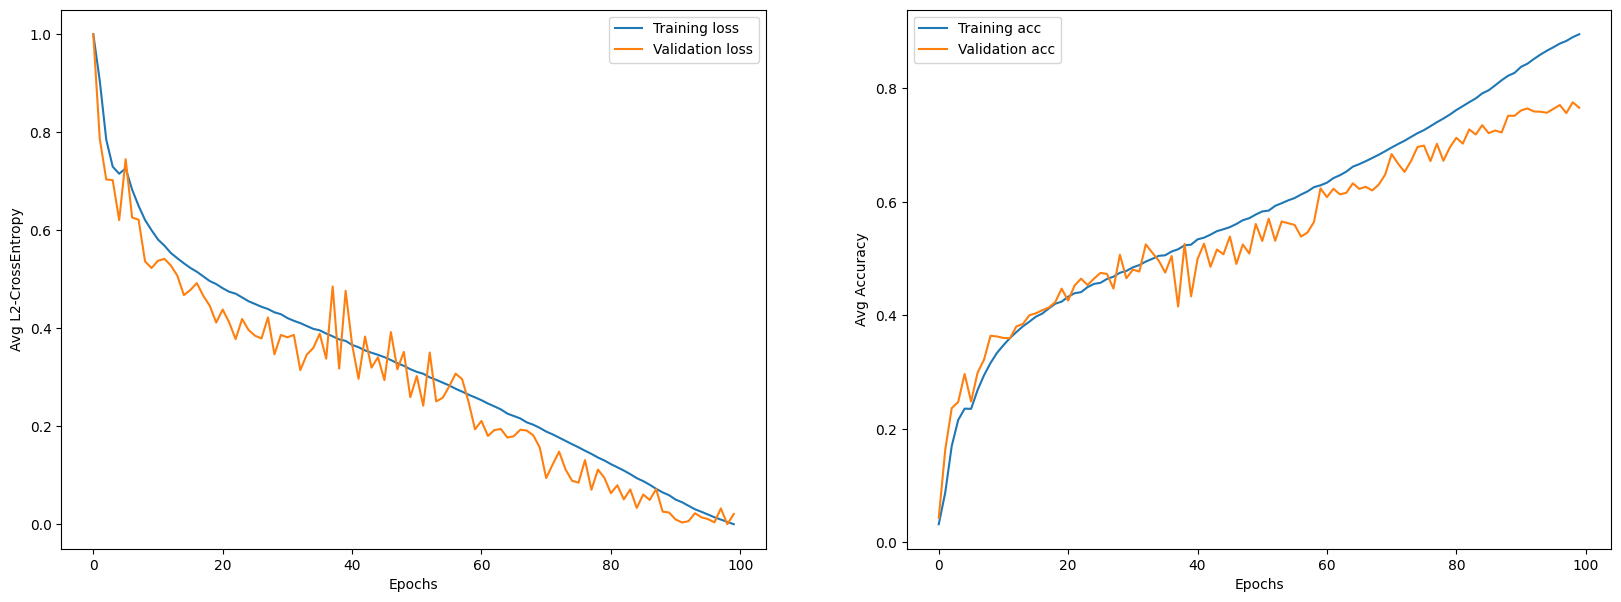

In [18]:
scaled_loss = (res_df['Loss'].to_numpy() - np.min(res_df['Loss'].to_numpy())) / (np.max(res_df['Loss'].to_numpy()) - np.min(res_df['Loss'].to_numpy()))
scaled_val_loss = (res_df['Val_Loss'].to_numpy() - np.min(res_df['Val_Loss'].to_numpy())) / (np.max(res_df['Val_Loss'].to_numpy()) - np.min(res_df['Val_Loss'].to_numpy()))

# Plot results
plt.figure(figsize=[20,7])
plt.subplot(1,2,1)
plt.plot(range(settings['epochs']), scaled_loss, label='Training loss')
plt.plot(range(settings['epochs']), scaled_val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Avg L2-CrossEntropy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(settings['epochs']), res_df['Accuracy'], label='Training acc')
plt.plot(range(settings['epochs']), res_df['Val_Accuracy'], label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Avg Accuracy')
plt.legend();

### 3.2.2 - Exporting the model and tesing

In [19]:
# Export the export
exported = SuperNet_model.export(verbose=1)

[BEST ALTERNATIVE for features.4.block.2]:
Identity()

[BEST ALTERNATIVE for features.5.block.2]:
Identity()

[BEST ALTERNATIVE for features.6.block.2]:
Identity()

[BEST ALTERNATIVE for features.11.block.2]:
Identity()

[BEST ALTERNATIVE for features.12.block.2]:
Identity()

[BEST ALTERNATIVE for features.13.block.2]:
DepthwiseSeparableConv(
  (depthwise): Conv2d(672, 672, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=672)
  (depth_bn): BatchNorm2d(672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pointwise): Conv2d(672, 672, kernel_size=(1, 1), stride=(1, 1), groups=2)
  (point_bn): BatchNorm2d(672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE for features.14.block.2]:
DepthwiseSeparableConv(
  (depthwise): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960)
  (depth_bn): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pointw

In [20]:
# look at the exported model
exported

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [21]:
# Test the exported model
SuperNet_acc = utils.eval_model(
    model=exported,
    device=device,
    data_loader=test_dataloader
)  

  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED - Avg Accuracy: 78.13%


In [22]:
# Save the exported model
utils.save_experiment(root='./experiments', model=exported, seed=SEED, settings=settings, exported=True, metrics_df=res_df)

### 3.2.3 - Comparison with basline MBNV3

# Test the baseline model
baseline_model = torch.load(f'./main_models/MobileNetV3_seed{SEED}.pt', weights_only=False)

# Test the basline model
baseline_acc = utils.eval_model(
    model=baseline_model,
    device=device,
    data_loader=test_dataloader
) 

In [24]:
gap = SuperNet_acc - baseline_acc

print(f'SuperNet accuracy on test data: {(SuperNet_acc*100):.2f}', end=" -> ")
if gap <= 0:
    print(f'{(abs(gap)*100):.2f}% less than baseline')
else:
    print(f'{(abs(gap)*100):.2f}% more than baseline')

SuperNet accuracy on test data: 78.13 -> 2.60% less than baseline


In [25]:
baseline_flops = utils.count_flops(model=baseline_model, dataset=train_dataset)
SuperNet_flops = utils.count_flops(model=exported, dataset=train_dataset)
flops_ratio = 1 - SuperNet_flops / baseline_flops if SuperNet_flops <= baseline_flops else (SuperNet_flops - baseline_flops) / baseline_flops

print(f'#Parameters SuperNet MBNV3: {SuperNet_flops}', end=" -> ")
if SuperNet_flops <= baseline_flops:
    print(f'{(flops_ratio*100):.2f}% less than baseline')
else:
    print(f'{(flops_ratio*100):.2f}% more than baseline')

#Parameters SuperNet MBNV3: 262456836 -> 14.03% more than baseline
